Importing required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL #PIL stands for Python Imaging Library
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


Mounting Google Drive to access dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
p="/content/drive/MyDrive/Agriculture Vision Dataset/All Images"
os.chdir(p)
print('yes')

yes


Defining Batch and Image Size

In [ ]:
batch_size = 32
image_size = (224,224)

Splitting Dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Agriculture Vision Dataset/New Augmented",
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=(224,224),
    batch_size=32,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Agriculture Vision Dataset/New Augmented",
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=(224,224),
    batch_size=32,
)

Found 8000 files belonging to 4 classes.
Using 7200 files for training.
Found 8000 files belonging to 4 classes.
Using 800 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cloud_shadow', 'standing_water', 'waterway', 'weed_cluster']


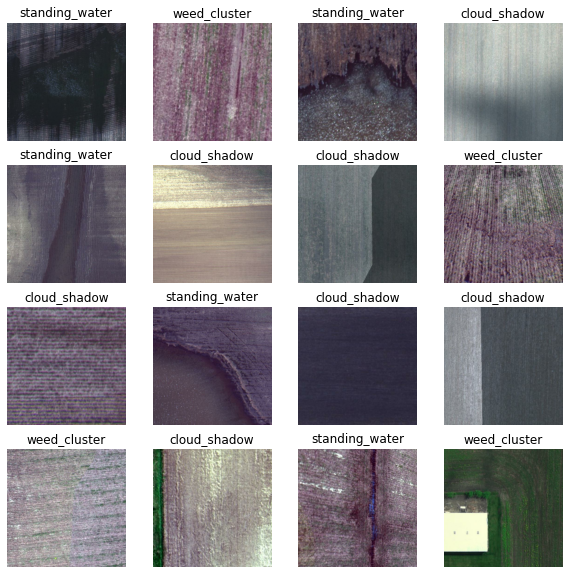

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


DetNet Model

In [ ]:
 '''
version:
TensorFlow==1.7.0
Keras==2.2.4
Python==3.6.5
'''
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import Conv2D, Add, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU
from keras.utils import plot_model

# DetNet59 Model Structure
# _______________________________________________________________________________
# Stage   |output size| kernel size | num_filters | num_blocks | stride | dilate
# _______________________________________________________________________________
# Stage 1 |  112x112  |     7x7     |     64      |     ---    |   2   |    1
# -------------------------------------------------------------------------------
#         |           |     3x3     |           max pool       |   2   | 
#         |           |     1x1     |     64       |           |       |
# Stage 2 |   56x56   |     3x3     |     64       |     3     |   1   |    1
#         |           |     1x2     |     256      |           |       |
# ------------------------------------------------------------------------------- 
#         |           |     1x1     |     128      |           |       |
# Stage 3 |   28x28   |     3x3     |     128      |     4     |   2   |    1
#         |           |     1x2     |     512      |           |       |
# -------------------------------------------------------------------------------
#         |           |     1x1     |     256      |           |       |
# Stage 4 |   14x14   |     3x3     |     256      |     6     |   2   |    1
#         |           |     1x2     |     1024     |           |       |
# -------------------------------------------------------------------------------
#         |           |     1x1     |     256      |           |       |
# Stage 5 |   14x14   |     3x3     |     256      |     3     |   1   |    2
#         |           |     1x2     |     256      |           |       |
# -------------------------------------------------------------------------------
#         |           |     1x1     |     256      |           |       |
# Stage 6 |   14x14   |     3x3     |     256      |     3     |   1   |    2
#         |           |     1x2     |     256      |           |       |
# -------------------------------------------------------------------------------
#         |    1x1    |    14x14    |        ave pool, 1000-d fc, softmax 
# -------------------------------------------------------------------------------

def res_block(x, filters_list, strides=1, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + x
    # Conv2D default arguments:
        strides=1
        padding='valid'
        data_format='channels_last'
        dilation_rate=1
        activation=None
        use_bias=True
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=1, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def res_block_proj(x, filters_list, strides=2, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + proj(x)
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=strides, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    x = Conv2D(filters=filters_list[2], kernel_size=1, strides=strides, use_bias=False, name='%s_proj'%(name))(x)
    x = BatchNormalization(name='%s_proj_bn'%(name))(x)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def dilated_res_block(x, filters_list, strides=1, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + x
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=1, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', dilation_rate=2, use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def dilated_res_block_proj(x, filters_list, strides=1, use_bias=True, name=None):
    '''
    y = f3(f2(f1(x))) + proj(x)
    '''
    out = Conv2D(filters=filters_list[0], kernel_size=1, strides=1, use_bias=False, name='%s_1'%(name))(x)
    out = BatchNormalization(name='%s_1_bn'%(name))(out)
    out = ReLU(name='%s_1_relu'%(name))(out)

    out = Conv2D(filters=filters_list[1], kernel_size=3, strides=1, padding='same', dilation_rate=2, use_bias=False, name='%s_2'%(name))(out)
    out = BatchNormalization(name='%s_2_bn'%(name))(out)
    out = ReLU(name='%s_2_relu'%(name))(out)

    out = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_3'%(name))(out)
    out = BatchNormalization(name='%s_3_bn'%(name))(out)

    x = Conv2D(filters=filters_list[2], kernel_size=1, strides=1, use_bias=False, name='%s_proj'%(name))(x)
    x = BatchNormalization(name='%s_proj_bn'%(name))(x)

    out = Add(name='%s_add'%(name))([x, out])
    out = ReLU(name='%s_relu'%(name))(out)    
    return out

def resnet_body(x, filters_list, num_blocks, strides=2, name=None):
    out = res_block_proj(x=x, filters_list=filters_list, strides=strides, name='%s_1'%(name))
    for i in range(1, num_blocks):
        out = res_block(x=out, filters_list=filters_list, name='%s_%s'%(name, str(i+1)))
    return out

def detnet_body(x, filters_list, num_blocks, strides=1, name=None):
    out = dilated_res_block_proj(x=x, filters_list=filters_list, name='%s_1'%(name))
    for i in range(1, num_blocks):
        out = dilated_res_block(x=out, filters_list=filters_list, name='%s_%s'%(name, str(i+1)))
    return out


def detnet_59(inputs, filters_list, blocks_list, num_classes):
    # stage 1
    inputs_pad = ZeroPadding2D(padding=3, name='inputs_pad')(inputs)
    conv1 = Conv2D(filters=filters_list[0][0], kernel_size=7, strides=2, use_bias=False, name='conv1')(inputs_pad)
    conv1 = BatchNormalization(name='conv1_bn')(conv1)
    conv1 = ReLU(name='conv1_relu')(conv1)

    # stage 2
    conv1_pad = ZeroPadding2D(padding=1, name='conv1_pad')(conv1)
    conv1_pool = MaxPooling2D(pool_size=3, strides=2, name='conv1_maxpool')(conv1_pad)
    conv2_x = resnet_body(x=conv1_pool, filters_list=filters_list[1], num_blocks=blocks_list[1], strides=1, name='res2')

    # stage 3
    conv3_x = resnet_body(x=conv2_x, filters_list=filters_list[2], num_blocks=blocks_list[2], strides=2, name='res3')

    # stage 4
    conv4_x = resnet_body(x=conv3_x, filters_list=filters_list[3], num_blocks=blocks_list[3], strides=2, name='res4')

    # stage 5
    conv5_x = detnet_body(x=conv4_x, filters_list=filters_list[4], num_blocks=blocks_list[4], strides=1, name='dires5')

    # stage 6
    conv6_x = detnet_body(x=conv5_x, filters_list=filters_list[5], num_blocks=blocks_list[5], strides=1, name='dires6')

    out = AveragePooling2D(pool_size=14, strides=1, name='final_avepool')(conv6_x)
    out = Flatten(name='flatten')(out)
    outputs = Dense(units=num_classes, activation="softmax", kernel_initializer='he_normal', name='dense')(out)
    model = Model(inputs=inputs, outputs=outputs) 
    return model

if __name__=='__main__':
    # create a keras model detnet_59
    inputs = Input(shape=(224,224,3), name='inputs')
    filters_list=[[64],
                  [64,64,256],                  
                  [128,128,512],
                  [256,256,1024],
                  [256,256,256],
                  [256,256,256]]
    blocks_list=[1,3,4,6,3,3]
    num_classes = 4
    model = detnet_59(inputs, filters_list, blocks_list, num_classes)

    # check the model
    model.summary()
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    print('Model Compiled')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inputs_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           inputs[0][0]                     
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9408        inputs_pad[0][0]                 
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

Training Model (Adam's optimizer used)

A1tQQfzgbAJQVAbHmgJZ6G/fzSR/XT0N+/mkj+upPoU0KA/O2cXbqUjqsLbB6hZfY7La4NtlluHjZnQ7g6qW6ZTDjvpXF7MdCEjtOo4lYJ38Vuo6l5U9e8QuE5rKLXa71bbw9IgG2uvPIWxIjNsrdbS2X0ApWtQ0APxBy+lX5oVHrlgWOXXKoOaTPtUXW2tKYjLZvExllLalJUpKmG3QysKKEcuSDy4p3vQqKkLe+s9qQV1bfx0S/bKw+2+qDb8PIH5V6+7qr5JDqW7eoyhb/SkMqWxw7oT6jZ9qeeu2T7eVeLleuqs43++Y3KvZssZNp9El2AW5K1CSo3AtMuIDi0+nLfHkkkrCgirz0KaFV1jdqpCmrpmd7mQ7xLx2RmBVb7NJfSpVlebY9QNdpKUutB110nekoCk6CuQ3x3zLXlHUZy89NIMifkK2L3ZpDt6cctDqAmUGme33lBoCOor73tPAH9Naq+NCmhVs0nh599EHWOPj11ZGPQ37+aSP66i+QyM+TmWMY7ZpVxTElGXOukwNcmURmWwlLBWQQlbjrzSkgEKKWnNeAas/QpoVAVRdbtmcvqLasKsN1lIZiRl3a+SQUqS2weTceP5B0p1zmsEaITHX5HIb0eo2YZbYLhCxWyrviJlyZW87dkWmVMi29kHjy/CQoLeJ/I38eCpWgAFXAiJFafdlNxmkPPhIdcSgBSwnfEKPydbOt/G6y6FSCzWda1gVHcb3lyLXjWT2q539+z+rUi7JXbHRMcjll1CXFRy0HU6f7SjxQDx8647ro4W9mt7F4uc+43FuA9cSLSiSwY7gipZaSSUKSlY26HiOY5aI+mqsvQpoVrEzgRj0N+/mkj+unob9/NJH9dSfQpoVCkY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9D4poUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQEY9Dfv5pI/rp6G/fzSR/XUn0KaFARj0N+/mkj+unob9/NJH9dSfQpoUBGPQ37+aSP66ehv380kf11J9CmhQGnZP7Fgf9K1/oFfjL/wDaY9Vr5jmK4/0wskpUZnJC9Lua0HSnWGikIa/+1SlEq/XgkfGwf2bZP7Fgf9K1/oFfj/8A/aS9HL7mWGWXqZjsVcpWKd5q5MISSsRHeJ7oA+iFJ937L38A0B+Rf4cv4ZZ/8ReO5wvH7yiFfsZRAdgMv+I8rvd/m2tXyg/hJ4q+N72POxX7jHUboN1HaMqNOxzKcdlIdSlYKFoUPIP6LQof5pUk/UGpn0E/iWyT+HvH8yi4dbGHLzlCYTbE6RpSISWe/wAlhsjS1HvJ1vwNHYPxULsdn6hddeo0e1R3Z1/yXIJQC3n1lxZJPucWo/lQkbJPwAKA/tVgWTIzXB8ezBtAQm+WuLcQkfCQ80lzX/8AtXeri4TjTOG4bYsQjL5tWS2xrchX+JLLSUA//wCtdqgKz6w29piZiV/Ykz25f3otEPSJzyWe0qR7h2Qvt7IUQVceRHgnQArpZpGj33OcYxO7NuPWqXDuU59gOFLbrzJjpbC9EcgA+4oJPjYB1tII2c46TYd1EmRJuUKyFS4Km3I6IGTXK3NIcbUVIc7cV9tBcSo7CyCr486Ardu/T7Gr5Y4OP3IXVTNtCRFktXmazOb4p479Yh0SCop2FKLhKwTyJ2aqcf09l37TfBqyvE8Q629rcl1b8xwI/hOURsd6fXy7X6Y99m4vcbvGQ864p5wQ4sl1LaSpRKlqCEBAJJUeI2Sdms3TnEpi8OlzsvhSIF8y6Qq73hpiW409HccCQ3HDzSkqHZaQ01tJG+BP1O+pdenViuOPWvE4pcgWa3TY8tyIxoiUllfcS04pW1FKnQhazvkopIJIUrfeu9qi3u2SbTNdmNsSkFtxcOY9EeAP+B5lSXGz+6VA/vUwed3bu+wdWuevhdyB4lcJti6S3y42xtcmTan78uI04pThUWZcnto2SSR7Up/yqO4mv7AvvS6VZ335C80tUhd6ddfKzLIiIkJlLG9cw57dpAADxHxxAn+EdMsV6eCSjGXL9wlqUt1u45FcLkgKUtS1KSmW+4EKUpSiopAKifO6yY103w/Ebk/drFb5Lch5BaR37hJktxmiQotR23XFIjNkhJKGQhJ4p8eBqpxabeMcImecqfgOqSWE8ZjtDj5JPVWZUw3P/iMwWDLK3IzOLX+ehkrUGxIbl2tLbvEHRUkOLAJ+AtX6mrTqG37BbrcupmN9RLZf4kQWS2z7VJhv29T/AKpiU9FcUUOJdR2lp9IACUrHvPjx5WaW03v/AOLS6wH/ABa1eiJ531e6j4xlU2x2HphDu0GN2+1Mccv4U5ybSo7EWyyWfBJHteX8eeJ2kat76z9TrbHtT0HpRBlLnQkyZCVO5EOw4VKBbHasTh1pIP4gbX58oA0TdFKiood4d8lNTusnUyNjFrvTHSqE7NmyJLT8Qu5DxYQ3w4KBTY1Pe7kr/iMtp9vtU57uPhjrR1PdxqZeXOk8FEyPLZYbi93IuLja0rKlndiDuwUpHtZUn3e5aDxCropTMZFMWjrP1Nn2u8zZnSiFGft0Zt6Myl3IiJC1OpQUnuWJC/CVFX4SHVePKQna0+8V6ydTL5dFwrr0qhW9hMWQ+HkO5CSVttqUhH49jZR7lAJ8LKvPtQtWkG5KUBSePdbOqV2vsC2XHpHBhxZUhtp6Ql3IyWkKIBUO9YWm/A8+9xCf1UB5rVmdderMec/GZ6OQHGm3VIS4Xsm2pIOgfbjyk+R+iiP0JHmr2pTFApjKus/U6x5FPtFq6UQbhEiultmUt3IgXU6/MexYnmv6HVj96+5H1m6m2d6C3belMKamTAYlOqU7kI7TqxtTY7NidGknx7yhf+JtB8Vc1KmAKXuXWjqfDs1nuMbpPBfkXBt5clgu5FqOUOFKQOFiW55SAr8Rto+faFp0s5/9sPUn7mfeL/ZbC+0ftIQ/Q93IOPZ7ZV3d/Ynf3yGv/D9v/wDKcvabhpVe4FLW7rT1Pl2a7XGT0mgsyICWVR2A7kWnytzioHnYkOeB5/Dbd/5gge6s2L9Y+pd7fntXTpZCgJi26RLZUh3ID3Xm07Q0e/Y2RpR8ewrc/wALaz4q46UdwKVxrrV1QvF+hWu59JYMGLJdCHZCXcjJaT+o71hZb/rcQP3rVg9dOrEm4R4j/R2A0068htbodybaElQBV7seSnwPPlSR+qgPNXpSqoIyk8i62dUbRf7jard0kgzYsOU6wxJU7kYLyEqISs9mwut+QN+x1xP6LUPJzZT1l6m2S6JhWrpTCnsGNHeLy3chBC3GkrWj8CxPI9qlFP5+Xj3JQraBc1KyqKGXEpq99ZOplttllmQelUKU9cYin5TSnchAjOB1SQgdqxuL0UpCvxUNK8+EFOlq8PdaOpzeMRb0jpPBVNemvRnIndyLihpCEKS5sWIvbJWoe5lKPb7VqPJKbopVBTULrJ1Mk4xc70/0qhNTYT8dpiIHch4voc581EqsaXvbxT/w2XE+73KR45YrN1p6oXFi6Ozek0GMqFCVJjpS7kf47ocQkNnuWFs60pR/DDi/b+QjkpN1UoMincN6w9Sshv7NqvPS2FbIrjbq1SUO5ASkpbUpI/3myMN+SAPLoPnwFHSTz7X1y6rTbpEgyuj0COxIkNtOPB3JdtoUoAq9+PoR4B37lpT+qkjyLypRXyTAoy59c+q8K5y4UXo9AfZYfcabdLuTbcSlRAV7MfWjyBv2rUn9FKHk9DMOsfUvH8hk2mz9K4VyiMhstyVu5ACvkhKj/wCHsb7Xgkj2uq+PPE7SLjpUVxXfJS18609T7ai2qg9JoMozIDcp8KdyIdl1SlAtjtWJzwAkH39tfny2kaKslw6y9TImOWm7x+lUJ6ZPXITIil3IdRw2oBBHCxqd9wJP4jTQ8e0rGyLlpVBTTfWXqavE378rpTCTPauDcREPu5DxU0ptai5s2MPbBSB4YUjz5cSdJV8s3WXqbcbZeZs3pTCjPW6Mh6M0l3ISJCy4lJQe5Ym1+EqJ/CQ6rx5SE7ULmpTPWGmCmMb6z9TrxOfjXLpRBgtNw5MhDiXciJU420pSEfjWJpOlKAT4UV+fahxWkHHjfWvqheMgt1quXSWDBiS5LbL0lLuRksoUoArHesLTXgefe62n9VJHmrrpRXyMCineuvVhE9cVPRyAppLxbDneybZTy1y8Y8U/Hnwoj99ea2ci62dUbRfZ9rt3SSDNixZC2mZCncjBdQk6Cj2bC635H+Bxaf0UR5q7KVClO9anXpuFYNlEiKYN1+9WL/8ABceSWBIuURL7QK0NuFJSSghbaFEeFISdpFxVDOpmCXXP2LHb4mQRLZBtt8t15lpct6pDskw5bUhDbaw8gNci0UlRSvwrwBrzM62mthr/AFN8Is+UzL/knuS4za9o518vBskRMtNpuNw5LCO1BZDjg2D5IJHjx/71hsGQKvoeKrDdrb2eP/j44a573+XSjvWvP+Yrr0rJTw80l9lbCysJcSUEoWUKAI14Ukgg/uCCKrfpFFTbco6nWdiTMdiwMnjNR0ypbslaEmzW5ahzdUpR2ta1HZOyon5NWQ80l9pbKysJcSUkoWUKAI14Ukgg/uDsVCsQ6NYRg18lZHjzmTCdOWXZSp2WXWc3Ic7SGubjUmS42tYbbbSFKSSAhIBGhSzS028o6p+OodxFEY7AV1ChRMRuNyueQW67quGSXldwcLUaM4lShCcQFFClKQppKGAkBCAHTxPEry9TepfU7C3b7cbbi9s+xrShtceTLDimZDfBBdeekIWBFS2pSwQptQ03yKkJVtPesPQrp7jNwZuNm+9DKmJip6I7mX3d6IX1KKitUZySplW1EnRQRv6Vmm9Eum9xus27yrRPUu6SjMuEZN5nIhTnSEgmRES8GHhpCRxcQpOhrVLFInV3S/TotVmNX1+dYVnIIIBB2D8Gq2/iAtzTnTq43tMmczLtqWlR1MTnmUBSpDWyptCghZGvBUCU7OtbO7JAAGhUWz7ppinUyC1bMt+2XIjXL8GBfp9uQ5spP4givN93RQkjny4netbO49xbNLzLnl3yuz2ll7EbQ1OlOyUtulxBc7DOlFTgaCkF07CRwC0/m3vQNc/p3md6yC13uTl0WFb37LPXFc7YW0Q0lltzuOtubLSiFk8eShx0QpQO6zTOlOG3GxW7H7gi9SmLQ8uTCkPZBcFzWXVhYKxML3qCdOLAJcPEHQ0ANeZPS+wfcu44PaZVwgxLsr/fpK5jsyXJQopDocfkKW4sraT2uSlFSUkcSOI0qpjh0+xe1Ota38TpqJV2t1/6wi0ly5ZUnu2tl9ztrNrYSoQWiSNNhzkt47G0mSd71WPDc76i3DK4eN5dZLfbxOtsmWFGM6wtt9tTQ7SOTi0yEDuKJWCg+B7ADsWDdLFab1Y5WN3KEl22zYy4b8cEoSplSeJRtJBA4nXgiuLjXTPEcSuSrtZ49yXJ7SmGlTrxMnJjNKIKm2ESHVpYQeKdpbCQeKdjwNapO7Wnqc1icdaRwOlrvUmabhIyLKLLOhsXy5x1tt2t9t7ih9xKEocVJWEJBA0Cg6SNb+tRdPXfKX5su4wcVny7ZGu7tvTb4+KXl6S8w0+WVvpmIYMfltKlhsAp4gAuA71YSOlOEN5QrL0QbgJy5JmFn7Xmei9QRovej7vpu59efb5b8735rzL6UYVNvir+5GurTzjvedjRr5OYgvOb2Vuw23kx3FE+SVtkk/O6lm+zPHp9ltVmNXkct2Y9VsgzbNsZskbFW4uJTGGGHpSX+c0vRGZCWlBKz2eId4l73g+NN+CKnmJZFHy7GLXk8WO4w1dIrcpLSyCpvkkHiSPB0fGx81V1s6NXe7dUMyyXOLJAatN8mNSoUmzZdcmJTiGo0eOliXHaaYbdbUGVuFK3XEpK+PFQJVVxxYsaDGahQo7bEdhCWmmm0hKEIA0EpA8AAeNUs/xU7ta/dtRtU1rW7nX6/qsSGVpsV1uXeKhqAwHSjWvzbUNb34/yrJY7yq9xVSlWi427iso7U5kNrPj5ABPjzXSpQhjkx2Zcd2JJbDjLyFNuIPwpJGiP/Q1VPSS5xsXwbN57weXBsGS5AptkKKyiOw+shtHI+AEp0B8CrOu9rjXu2SbTMdltsSmy24uJMeiPAH6oeZUlxs/8yVAj9aiuGdHMGwGRNkY4i/6uJeXKZuGTXO4sPLdVydcUzKkON81HyV8eR2fPk1lJ7Te5rjKfjqalbKW9PhDXnoa7GXZdZ5eOv5a1aFw8olIhMs29p3uQX1srdQFOKUQ+nTaklYQ3o6Otb1wso6kdS8evh7mM25qzm9xbch19t3t+ldkNtGQZSVFCVnmdNKbSAdAub8GYWDpfhuNXX7ZtcS4l9HL07cu7zJceGCCCIzDzq2ow4kp00lHt8fHitKN0W6dxbsq7s2u48lz3bouIu9TlwFy3HlPqfVDU8Y6l91RWFFvaSElOuI1ukp6wp3rOPExWHrP6pu4HB6l9QupuIyL1Ns2L29dotUVL7D8htx1EohHJxTrrax6VKD48tubCSo8QfEo6h3jqDaodme6c49aLy7Ku8Zi4puE/0yWLerfdebOjzcT7dJ+uz81r3Xo10+vV1m3mdbbiHrm8H57TF6nMRpyuCUakR23ktPJ4ISng4hSdb8eTvoZz02wnqTFtUPNbGm5M2O6R7zASX3WuzMY32nPw1J3rkfadpO/INRXL5X3qnDCu9/D+tV44yaudfrLAvsAw7j6gspV3OLMp1jkQD4UW1JKk+fKFbSfqDXRrk5NjNty21qs91kXVmOpaVlVtu0q3PbHwO9FcbcA/UctH6g1z/q2XbsOyr2VOGcbpA+/K6T4ZJlPOPPO2C3rcccUVKWox0Ekk+SSfrXevdwdiWG43G3BL78WK860lJ3ycSgkJ8fuNVzcHwDHOnVnTYMXN2TAQEJaauF5mXHsoSkJShtUp1xTaAAAEpIT+1Y8B6a4R0vtEqw4LYk2uBNnyLm+yH3Xecl9XJ1e3FKI2foDofAAFdP63/k2tlxMx861lLH4Q2pjsQTFmGrHc+mt2tUiQZGWwXU3juSFL9ZuH6jvrSSQVpcQAFDWg6ofBApbsZjMdQrfFxi63e63q13N6dk97flLLQZebcUmCpPLtk/iM8GUp00hCVniSnnOse6aYbi1zfvFnt8pMp5CmkGRcZMlEVpRBU1GQ84pMZskJ2hkISeKdj2jXFxroP06xGfGn2BGTMGHKXNajO5dd34geWVFSzGdkqZUSVqPuQRs7+aqf57WHbd8cpI1+MYxz3/PYjee44xccsct2MXa4Tc5mT4VxbkonONtWC3tuICisIPENrQ28A0pP461KB9oUtHD/AImMvlmLdcbcg5bCtllszl4XPt9nuDrE2aUrEdgSI7SkpS0Ul1zkpI5dkeRyFT93oN06dvFwvgGUsyLrONxmtx8wvDMZ98kElUdEoNFPgDhw46AGteKkmbYPj/UOwvYzlCbiu3SD+M3CusqApwaIKVORnG1qQQTtJVxP1B0KxD2UsfrxfN7arkttpt61OVyV2Z2YjyZERl9AWEuNpWAtBQrRG/KVAEH9iNitG/XxVjYaeTZbncu4rjwgMB1SfHyoEjQrfix24kZqIyXC2yhLaS44pxZAGhyUolSj48kkk/JNZa3aiaGLMpVOZYr2q+MOPqs1ztvbXw4T2A0pXjewATsVjy7IGcUxi55E+WdQIq3kJeUtKFuAexBLaFr9yuKfahavPhKjoHr1o3yyWrJLRLsV7holQZrZafZUSOST+hBBB+oIIIIBBBFZtVVDSo6ledP+puW3bIn8ezfHxAc+xvtltbcF6NwCXAhxri6pSnNckkL0gnyChPitzHcl6o5DCx7LItvxo2O/LZkOwyt1EuFCdTyQ53eRQ85oo22EIAKjpSuPu3sd6NYFi2QsZZaY16VeGGHI3rJmQ3GY46yvW23S++vvJBAKUucgg+U8T5r3bejvT+03lm9w7XOLkVwvRYr13mPQYjm982Ibjqo7KgfgttpI2da3WqStYvxC4PMzDrrBeZZxHMy6p5JZrxk/Ty0425FgzZcCDAujrqH5qozy2HXFPJVwY/Ebc4oKV8kpSVLRyIRt33Nsst9uz92IbR6jFGEzYinIzikOM+m7xbcAdBKvBTzBA8g8fGjv3To308vN2eu8+zy1GU6X5UJu6y2rfKcPyt+Eh0RnlH6qcbUTob3qsmTdJMEy+bInX63T3DMieilMR7vMjRpTPFSQl6Oy6lp0gKISpaSpPjRGhrFpN2YV+vOsDaa2pd2vGsTnZNmOcRBhzuL2+zSzk6xGcjzC412VqiuP93upJ9iQ2fZ2yVfHJPyMOW5pneLxrJZEMWefkV1kSNiJDlPJ9I15U+iOk78c2kqC3kJBcGlqJCTuXbolgl7bszc17K0DH46Y1uMXMLvGLSUoUgKJakpLjnBaklxfJZB0VEV0b90xxHJYNrg3ZF3UbM0WIcqPfZ0aYlspSlaFymnkvuhYQjmFrVzKQVbI3W7UT+OfTWrjKmFOXUi1o6uX+74faJLWPRmclvF/lY2yxIWtqM2/HW/3X3NgrSntRnFhvyoq4t8vPcHVXcOtESPlEd224vMkQrczIsEmP3UJnST3S6y8wpwqa1xaCSHFA8978FI27f0d6dWrG5eIwLA41aZk5dzMf18lXYlLPIux1lwrjK5e4dko4qJUNEkn3bsFg4Da7lL6e2Ju4XyUhP4l9vst1yVxPtQ9OeEl8ISCopHFYBJ0Bsmo7nrBeZLjTVfUI4+I9TJub5Dj0TG5tul2yRj6LzeHFQnWn2Vuq4MNhJcPZUpaH9trClJ7CgTs7HbxW79RJ2YZVb8pxy0wcfgvMJsMyLO70iY2pG3C83/5RCtAD6/v81yujOE33ELbf5mV2Kw2295DfZd3lizXB2YwsOEdv3usMqBSkcSkI0SCve1kDuY501wnEspyTNMesaYl5y51l+8yg+6v1S2kcGzxUopRpPjSAkH5OzVxl5dXXpd4yzhTPoqdbyT1+feoF4mvWPrdm7rzrV66ddz7uudwpTG7FojTWyEggK7j7zgVyB5p0g7A1X6CqMXzpvh+R3xjIbvb5LstkICkN3CSzHkcDtHqI7bgZkcT5T3UL4/TVRXzpXV8cTaaV6nzuJBHk84sd6SEsuPIQSgq+FEb4/vVZ9dMiv0I4riFgsUy5vZTc3IimmLkq3IWluO4923ZSApbDZ4bUpCVLKUKSEnlqpfmfTvDeoX2L98bIm4/d27MXy28nnG+xNZ323fYoctcj7VbSd+Qa3cnxSx5jbPsm/xnnGUuJebXHlOxX2XU/lcaeZUlxpY2RyQoHRI3ompa/K6lelPtapmx+NHWnWv0yH2SBaLxgl0sUjHl2CTZXnGp9vgXR4tIlBlLvtfR21PtKQ6hXvSne9KQCCBp3S5yon8OMWeL29BlOY1BQiUCourdcabQlAUPcFuKUEBY8grCh5FSh3phiC8TGFNNXeJbC4XVmFfJ0WU6s7KlOSmnkyHCrfuK3CVf3t16x3ppiWL4y/h1uYucmzvo7So90vEy5cWwgICELlOuLbQAkaSkgA+QAfNHWxas4uOcV1UWfxtWXlJDcAgxH8uy7EJFpudgt0izW5z7vSpAUpAdVKbdlIeZdWlPc4BspSsKBYCzorr3jFissXrbPg4rZxb7fjFibbmuNKVwkzJjnJLStnyWmo4V/wD5KanOKYNjmFokfYbM5Tssp78m4XKTcJLiU74IL8lxxzgnkrijlxTyVoDZro22yWu0SLhKt8UNO3WV62YvmpRde7aG+R2Tr2NoToaHt+K22pnWXnnHwSqTWsPXJ51N6ozPzZcGc7CGG5LJDS+HeYhJU0v90nmNj/tUmpWSnweRuoJmOYZDi+cY9bn5Voh43e2pTCpkmK4tbU5pouobUsOpSlC20OqBKflkp+VgieVws1wfFuomPv4tmNqFxtclSFusF5xrkUqBHubUlQ+NEA+QSDsEgxp4FUYlcs9Vc6GE4zclx7PJyDLn1PwYke3yipFtCSrv9hK1qWoJLJUFuNIT3gkr2EhclwDJD1VwmeMssKGHo1xmWqbGUhSEOLjulIWEKJUjkAlXEk8SSOSgOR7WV9PcVzNqE3eokttdtKvRyLdcZNuksJUAFIQ/FcbcShQCeSAririnYOhrl2zozgNjsFxxmxRr1a7ddZnr5DcHIrjHX3yQVKbcbfC2uRG1BtSQoklQJJNWj2pud3NR0niyYWYvx6+Y5H3ok4470lxNbzq3Fm1s7UtRUo+PqT5NTeoRjmE430fsjrGHWnKbhGV2mkwV3yZcy0lO9dpM2QpLSRyOwgp343vQ1vxMxmXGS1AdwLKIiJCg2p95thKGwfHJRS8VAD9QN1X+ToZsLZspMj/T6BFtPU/qDbLc2WYiBan0MBZKEuONOlagCfBUQCdfOqwjqRlMjGZ3UuHEtasZgPyQqA424JzsaO+pp18OhRQlekLWlktnekpK0lRKelj3RTBsXyReW2l/K/tN0pLy5WY3eW2/xSpKQ6y9KW24EhR4haSB9NECt53pTg798Vf3LdNLrjxkORBdZYt7jxVyLqoId9Mpzl7uZbKuWlb2N0tOWnu9a1SpQmtYkY6ldQOpuKyLvNsGLQXbTbIAlMSH2nXkylhClOB1bawYqUaHkocJBJ0BXZzfKc8tsm3/AHQsUabCeiKkPygwuYS5scGg224hSUqHI933/Ggg1nvPR3AL9dZl5uFvuSZFydDs9Ea9TozE0htLYTIZaeS28jghKeC0qTrfjyd5cj6T4TlN5GQ3GNdY9yERqAZNrvk62uGM2ta0NExXm9oCnVnR8HY3vQ1msLWq6wNY63feqnMjZrnl86JMZ1itgss3LJlpRLj21c5SIRlEDk0XlAEAHkNqCTsaOjvU2sj10k2aBIvkRiLcXYzS5bDDvcaaeKQVoQvQ5JCtgHXkCuNfumuD5LgMrpfeMeYcxeZD9A9bmlrYQWPHsCm1JUn4HlJB/eu3abXAsdrh2W1RxHhW+O3FjNBRIbaQkJQnZJJ0AB5O61SvCOv1nwxzWnHx95evVxgMXSC/b5K5CGpCC2tUeS5HdAP+FxtSVoP7pIP71DOjKCzidwjB15xEbJL6w13XVOKS2i5SEpTyUSSAAANn4FTK622PeLbJtUtyU2zLaU04qLLdjPBJGiUOtKS42r9FIUCPoRUawfpXiPTt6S9i7mQD1anFut3DJblcWitxwuOOBuU+4hK1LJUVgBRJOz5NRXuRbUpRg56NeehLUuNrUpCFpUpB0oA7I/zr873KXmOC3ONcZ2H3ublFwzpmK7ejLSqE5aZVxS22hCe5sJRDcQntBvaVtKWd6KzcuM9OMLw7IckyrG7ImFdcvlNTLzIDzq/VPNo4IVxUopRpPjSAkHySN+aW3p3i1rvr2RtNXKVOdeXIQqfd5c1uO4vfIx2n3Vtx98iNNJQNHXx4pZpas2nuno2vikfGBbVbLsrV68z84kD6845cY1rey7HrGl15nUm5Xj7bktS7PHZ4nvw4w/DeKUpWpTXcaSrXkO8ik7dyaiZx1MyGwX119dtsuL224W1CHlNJQ7KdmhyQOJBKwIzQSo/k0rWuStye+9J8HyW9G+3qBcJDq1IW9FF3mNwZCka4l6Gh0R3iNDy42r4H6CtvKunmKZm7GfvsOYXYqVNpch3GTCUtpRBUy4Y7iC60dDbS+SD9Umsx+MaVNe7os1n47z9eL5rhiyZl1cwDpbkzr1m77lqauN3ZuYeU24t+Gn3pZaKe4QtW9FaAOW9nWjP+mNyFwxURjbIkB61TJVrfYhuKXHDrDym1KbKvdxUU8tHyN6O9bOxk/TvE8viwot3gymvs0FMN+23CRbpEdJACkNvxXG3EoISkFIVxPEbB0K6lgsFmxe0x7FYLe1CgxUlLTLe9DZJJJOypRJJKiSSSSSSd10tObVpq5mLNmLKWJ7u9yNpgOThb5k4tlI7ERsOOq2QPCSRvW9nz8VpWHJFX111pWO3m29pIVynxg0le/okhR2a7VKyaMcgSFR3UxHG23yhQbU4grQlevBUkEEjfyARv9RVO2nqlnl1lWLG2peOKySVfrhbLtCTbX9Qo8QBTj3/iNgcVMEE+FerZ8DyTc1cGDguJ23L7lnsGzNtX67x2os2YFrJdbb0EjiTwB0EgqAClBCAokIToqWpd2v0w7o1rFfG+lcXLrRlMbJnFwLDGl4w3kMSwJlMxJKu6XZDcZx31CwhtJbeWpJQhDqT2yO4DsJkfUO3xGc06f3plotzXsgMNx5CiCtj0ExfbVo6KeSUnR+oB+lfLx0B6XX2VIlXG03X/AHiWJ/ZYyC4x47EoOB31DDLb6W2Hu4OfcaSlZUVHe1He3lXRrCczusa832RlRlQlIXG9Hl92hNsrS2psLQ3HkoQlfBagVhPI8jsnZpZolN6frzPMOreWtcCcVCupeZ3nFm7Tb8aiRpd2u8pTTbLjD0haWEJKnXUtNAc+O0A83GkjmPfshKt2Vkj+OupskTC8ouTMNttpEpotvpcASNbceeDi1fQqV5JBJJ+a1Lljdh6pQmHsmxzILS9bnl+mWLg9bZiOSQF8HoT4WEKGgpPPSuI2DoVHW4qpeRy2dXcgl4Y1MexxhGRyciXjDEd1S2I5kBZ084FcltoDaVLKByOxwCjsKrpzMr6jYc1kNyzK2WG4Wm12xuXAlWxbkd2VJKlhbDjLil9pI/D0sKUDzJ0NarftvRzpzaLDccYg4+tNrussT34zk6Q4lMkcSHmubhLC+SUr5NFJ5+/8xKq2LH0swbH49wjxrS/ON1ZMea/d7hJuciQyRrtLeluOOFvyfZy4jZ0PNKxv+ku8vl8B30u+/ULnWpqwn+rrV0Zj3cYo5BlQX3FSIzb6Vw5Y49tvtrX/ALw2dr2sFs+we0ctiM4/1dyS8W7o3enYFsbjdSo6DOYShznFdVa3pvJpfPRSCzw4qSTpW9+NGXY10rwvFLp9tWuJcn5qWy0y9c7zNuJjNn5Qx6p1wMJPwQ3xBAA+grlxegnTGFcbVdYtquzb9im+vtSRkFx7Vvc4LbKI7Xf7bTJQ4tJZQkNFJAKCANbstJ11fzvXLiZweevOsDWh5V1Ruue5LiVsi416PH1xHkzJCH0qeQ+grEfglZ0oAHb29fGmzs8eB1G645Jic7Jp9gsUa62PD0Nm4rZiyXVuOBAceZL2kNMrQhSSOPf/ADDl2/gTG2dGcItGVyM1gPZSi6y3xJkKXl12cYeWNhIXHXJLKkJBISgoKUjwAABWDKeg/S/M5F0fyGxzn0XoH7Qis3qdHiSVlAR3Vx2nksl3iEgO8O4OKSFApBGbFGtrWl8Z5ltQ5g37zf8ALZ2Wv4jh4tEVVvgMz5ky5NuPA95biWmm2m1IP/kuFSyv2+0BKtkp5cnMOoNli4dcMqgWG3tXK4m2X5DC3JCYzjilojKZd5JHFbgbQSpJILqfHg11770rw7I24abii8oegxxEbmQ7/PhzFsj/AMt2Sw8h55O/JDi1bJJPk7qL9WcBy+f01kdLulGJYmLXcoT0J9d0vD8IwwtQPNlLcR/uOHa1BxSklK+Kved0mFx18U1mvetOtTtYhl2YZRjeSZFFgW19puVMaxkFC4wnNNApQ46VKXxQt1KglY8FASvQ5BI7uBz8tumHWi455aIFryCRGSu4Q4Er1Edl4/KUOa9w+P1/TZ+Tli4xajhzWGzLWyi2qtotr0Jt1SmwyWu2psL0lRHHY5aST86Br7huH430/wAWtmFYhbRb7LZo6YkKKHVudppPwnksqUr/ADUST9TVhKV8RwmedPqKyW4fz1iOVfvDbvsuRb7JcJ8RHN+NFdeaTre1pQSB/wCoqqsRabs8rpld7Y7JelZdDcN4kOyFLVL5QTJ7zg3xKg6lIBAASFlKdJOquIgEaI8VGcd6bYfit1evNkt8pqQ4lSG0PXGS+xFQo7UiMw64pqMkkDaWUoB0NjwKWWlM6v7z0DrGsu0dSShxsuFoOJ5gbKd+QP11X52625nOk5YyxLg5XbYGM32wswFx7LcixcJL9wi994vtNFlTSGVlpKSs8luOjjsI3ckXpphELqHN6rRrGlGVXG3N2mTcO+6S5FbVyQ32yrtjRP5gkKP1JFZM06f4z1AjwomToubjMCU1NZbh3iZBSXm1pW2pYjOt9zitCVAL5AEAgbrMVsvJp8n668yu5rWp6ciM9VbeyxfsJvrMiaiUvJoMNQTNeDJaKHyR2eXb2d+VceRAAJIA1y+tmR5AnJsR6d2KxyLmrJBNfVHRcVW5h8xg0Q1IlIQtxpni4tau2hS1FtCNFKl1K826S4d1CuEO55MvIi9byhcZNvye525ptaCopcDUWQ2juDmocynlogb0ABv3zp/i+R2OFYLxHnPsW0oVDkpucpudHWlBQHETEOCQlwpKklYc5KClBRPI7lizspp/+08IS7qTVpy01lHGW+zgh7hxS5dM4z99dVilksVwdF5t8WSpbTjjDjja4odASt1tT/FQ4pCnNJSU+5SK7PSGzXq0WS5ruLUuHb590dmWa2THlOv26CpDYSytSiSCpaXXeGz2w6GwdI0Pd66NdP7/AGOzY7Og3VqHYJJmW8wr7PhvtvkK26p9h5DrizzUSpalEqUVHyd12sRwux4RDkwbGu6uImSDKfcuV4l3J5bnBKN92U645rihICQrQ14Hk1tOHaef163wvlmIolrH3W6X8HdpSlQopSlAKUpQClKUBpWT+xYH/Stf6BW2tCHUKbcQlaFgpUlQ2CD8gitSyf2LA/6Vr/QK3aA/Pua/wJfw35tenr/IxCRaZUlfcfTapi47Livqe15Qjf6ICR9fnzVg9KOgfSfonDdjdO8Rj296R/x5jilPynvjwp1ZKuPj8oITvzqrBpQClKUBUWd9aMpxPqC/hMPGMTWwmLbH40y6ZPIhuSXJspcVppLLUB88u8gAnkQAtKiQN6673Wyw44zabZ1Ftl0sWT3G3InKssK2TrqSrYS41HdjRyJSmyocg0CpKSFKSlJBrjZp04y29dTJWXtYZiN9tpgWqPERcb7JhPsyIUx2Wh4duG7r8VxHtCtHt+dhRSOLcLpnVjzvAYV3yXEJuZM2m8pmxJcwsMyRIlRSyy28lrm2rijSVdlXPsrHH5UmWXSyne2+VY18YltRtOLqdlPWS03Oo+HNYy3lqro6YDy+02hMN9Utbw3thMUI75eBBBZDfcBBBT4NerZ1DxC62CXkrV1XEgwB/vouMV6C/EOgQHmJCEOtEgggLQCQoEbBFRb/AGcZSymLlcaZajlEe9SL4uItTnoFqej+nXGDnHuJAaCdPcN8wVFvSiivM3ppk2SM3/IL3OtluyK8ItiIzEVTkqFETb5CpMdK1KS2t8qdWvmri37FJSAOPJVet3vp2mLWsKay2H+suP360X6Phc2XGyC12l+6tRr7jtwh7bbH/ELMhDC3GyohPJKgCSdE6NbfTbrBivUOJb48OY8i6ybazcFMu2+TGZfSUo7i4rjyEoktpUsAraUsJ5J2fI3gnWrqzkFsvyLxExOEZVoft8CBFmvvhbzg0XnpamEKQkDwG0sq+pKj4A5tswHOol96ZXB6JYEx8Qs8i23MN3J4qK3WmW+TA9OAsDsg+4o/Nr6bNsRNpWt0f7p/66klq5Rvn/bH/YtWqquPU/KGMsnR47NoRbrZfYljVaHWnDdZqX+yDMaX3AlLae/y49tfJDS1c0/CbVqqrl0tv8nIJyGBaF226X2NfnLu8+4LpELK2V+mbQGylSD2AlK+6nihZTwVrapZ/mpu+14n9wW1/Bxf9PzH6kl3UfLX8MxSTc7dD9bdZC24Fph//wAzOeUG2EH9E81AqV/dQlSvpWnkcvqawi2WvG0WNpwQnJF0vl0aUuK242lIDSY7bqFkuEqVyKglCUHfIkJpcMdvl/6mW67XIdrHsbiKfgt8kn1dye5IU6oA8khlnklIIHIyFH+4K5fU7GuouUXWDBtECwXPFENByfbZt4kW9yZIC9pQ6tuM93I+gNt+3mSQvkjaTPOvvfScS+Na4n2D1IvuQ4Vidxs9rhwL7l6+wwmbzdixiltxx17SShbzfBlamwCguBTeygEkSHB8gul5Yultv/o1XWxT1W6Y7CQpth5XbbdQ4hC1KUjk282SgqVxOxyUACeVcsczW62PHru+3j7GV49MVNajMuPfZywpDrKmO4UdxILDpAc4HSwFcCPYerg+PXSys3W435UT7Vv1wVcZjcNSlsMq7TbSG0LUlKlhLbSAVlKeR2eKQQkbcbTjV0efOBlXKdap4xJLSlKyUUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgNKyf2LA/6Vr/AECt2tKyf2LA/wCla/0Ct2gFKUoBSlKA4F+zrFcZudus96uhYmXWQzFitIYddKnHVFLfIoSQ2lSgQFL0nfjdZcoy+xYfEal3pyYe+vtssQYEidJeVrZCGI6Fur0PJKUnQGzoVBuueQ2e3pxWBLl8ZDWTWme42ltayiOiR73DxB0kaOz9NV08ovEKDluI5w9JP2B6C4RnJSWlLQhb/p3GVK0CUpIZcGzobUkfJFVJP+ntY7TXCLL8tcA6W9ncn1a8LmTOzXm2ZBbI95s8tMmHKRzacAKd+dEFJAKVAggpIBBBBAI1XNgZvYrh9uuocdZi49MMCXLeQEsqeS2haw2d7UE9wIJ1+cKT5INQW3ZFcMK6W3jI24axPvd8uDthhymy2t92bNX6NKkH3J5FxCyCApKSSQCDqZYpZLf00weLbbhdlyE29lT0+4vj3ypC1Fb8hYH95bilrIHxy0KmDepv6Y3XoPLUfeHwzqY7klnyq0ovlkkOuw3HHWgp2O4wsLbcU2sKQ6lK0kKQoeQPj9K5mN9RsRy24vWqxz5Tj7TZeQX7fJjtyWgQC7HcdbSiS2CpIK2lLSOSfPkbhuCTomX9NclxnH7olFykvXxLZUlaC16iVJ7Lh2AdEKSoEfTzXMxRUjJL90uYt0V+O7h9qki/IWwWxFcMREcRlbAHIunkAnY0yT8cd2yptNPCOMzPKFzFqiTW/hdHOXyLrqO3vPsYx7J7LhtykTjeL+h52DHi2yVKCm2lNIcccWy2pDLaVPtArcKUjmPNSKqvv/8A+JXCf/zLyP8A/XLRSzW2rPz0TfgOllvV6RaFKrrK8X6h3G/Spljm9uE5w7SfvI/F1pAB/CTEcCfIPws7+fG9DBdMT6lyGYCYU/itmKG3/wD5ofa25yUSdiGrn4I9x4n6a8bMVVIxgsylVrKxTqS5Y4MRmdqYy88p9X3nfTtKuPD8QQyV/CvBSnj9Cd+PLWJ9S02SRFcn/wC+LkNrbV96HzpsJVy/E9HtPkp9vEg/OxrRAsylVpbsT6lMQLkzLn7efZQmMfvQ+5pYcST7jDBb9oPkBW/jQ3sfbBinUiHOU9dJ3NksPIA+877/ALyghHtVEQPzEe7fj50daIFlUqr7PiPU6NdYki4T+UZt5CnR96pD20A+fYYaQrx9Cob/AFFYZOG9VVynXGbjptTiikfe6Qn278e30R1/ls/50xBa1KrO/wCJ9Spl5lybXP4RHHCppP3ofY0n/wDtphrCf8go/wCdfb1inUmU5FVbp3FLcRpt3/5ofZ26B7joQ1cvP946J/wigLLpVZzcT6lu223MRp+pDCHBJP3ofRslZKfeIZLnt15KU6+PPzWT7rdRvu16H13/AMQ9b3eX3mf/AODwI13vScvn+5w19eX0owWRSqyh4l1MattwYkT9yHktCOfvS+vRC9q95hgo8folW/jx81ksWK9R4jstVznc0uQ3mmv/AJmff06pOkHRiJ4+f742R88T8UBZNKrGyYl1Mi3aLIuU/lGbcCnR96X3tp/+ww0hX+RUP86wRcO6qNzGXXrjtpLiVLH3tkK9u/PtMIb8fTY/zqkZatKrC84j1OlXabJt9w4xXX1rZH3qkM6QVEp/DENQR4/uhR18bPzWS/Yp1Jlzw9bJ/BkMMoI+877HvDaQv2iGsfmB92/Pzob0IqqS4ll0qtbpinUiRBtjUKdxeYjqRJP3nfa2vmog8hEUXPaR7iEn6a8bPlzE+parGxERP/31EpxxxX3ofG2ylASO56PZ8hXt4gD52d6AFmUqtYuKdSG7HOiPTtzHXWVMK+876tJTy5/iGGCj5HgJVy/Ua847biXUxhqemZP5Keiltj/5pfc05zSQdmGnh4CvcOR+mvOwBZ1KrfG8V6jQbu3JvE7nFShwKH3mfk+SghP4aoiAfJHnkNfPnWq04GHdUmZ8d6VcNsIeQpwfeyQvaAob9phAK8fTY3+oor4BalKqudh3VN2dIdjXDTK3VqbH3tkI0kk69ohEJ8fTZ1+prbyPFepE68PybRO4RVhHBP3nfj60kA/hpiLA87/vHfz43qorhiWTSqyumJdTJCYQhT+JaiIbf/8Aml9rboKtnxDVz8Ee48Sf0GvPuZinUl2zW+LHnalsqeMhX3nfRsKI4fiCGS5438pTr6b3VBZVKrVGKdSRj7sNU7/flTEOIV953z+EEKBHd9HseSPZwIPzyGtH5bcU6ksQbk1Mn8nn2EojH70PuaWFpJ9xhpLfgHyArfxrzsAWXSqzsmJ9Sosp1y4z+TSozyEj70PvfiKQQg8TDTr3Ee7ZKfkA60fNlxLqbFu8OTcZ/KK08hbyfvS+9tAPn8Mw0hfj6FQ3+opjALOpVUuYb1UMtTiLj+EXCoD72yB7d/4fRfp9N/8Aes95xHqdJusuRb5/GM48tTI+9UhnSCfHsENQT/kFHX6mgJZlnUDGMHk2iNksidH+3JrVuhutWyVIY9Q64hppDrrTam2Oa3EJSXVIBJOidHUjqpeujUmP0/xJiarlIbzLEkOnul3axdogV7yElXnfuKRv50PirarSX4O1/qa5Ky/JHS0luT62l4FK42VRcxl25LWE32zWmeHQVP3W0u3Bkt6O0htuTHUFb17uZA0fB3sa2IweoUJMr7+ZRjt4Kyj0xtFhftoaHnlz7syTz37da460fnfjKKzvuutsNLeeWEIbSVKUT4AHkmuLi+bYzmZuacbuKpf2PMECZuO60EPFlt4AFaU80lt5pQWnaSFDR+a7bjiGm1OuK4oQCpR/QD5qp+kuU2K4dQOpTMSfzVdcjjy4O21pEhlFnt7anEEgApC23E7/AFQofSlmtprdPVe2HRSSuL1YwOZkv3Tj3h9U4yFxEOm3yUw3ZCB7mG5ZbEdbo0dtpcKwUqGtg6l9UtacwxnNspt8MP8A2LYLTcz9mWhqGtEi4zg4eMh5CUfgspXzWlJ0VEhaykDiYl1VkXq65FlE7Hc7y2PIhuiG3jzTNyiS5TqGmxxtkhmQmLxXvfcdjPlKyvkpKQAhY/KFn2p7uFqk7u9fV5+lq4OW51i2DRG52UXMxGnVBKeEd19Z2pKd8GkqVxBWnataG9kgV3QSQCRokfH6VWf8RF3t8HpjdLbJfIlT0tCMyhtS1ulD7RVoJB+B5pcVVLNpVX9Vr7Av2IWtVjzG5Wlq6T+DFzhRJj0dJQhwqEn0rrL6GTxI5Jdb94RtXEkHS6dZC9hnTzKMiya9z7zFtMp15qe65JLU1CWGuIiolOOPIQV7bCVOukuciFHkAJMTOGvIiWksSw7fllsumU3bE4TUlyTZGIz0x/t/gIW/zKGQvflwJQFqTrwlxsk+4V2qr3GLVcsL6YXO75Q9NcvlwZlXu8uWxruPplOoKlIjpIPItJCGmwQdhpG91COkcG8xs2YYe6gXXKYL9rld0pF1ipiK5M8fVNzZUj8dQ5ce32OOnPwzv2aiuzqdYmZUTgXlEnQ56HHIUpp9LTq2FltYUEuIUUrQdfBBBBH0IrPVI9NoOEYbkMy1Sp+Yi+/eK4Ijw3rpeZjS23XVqbdW0pxbKkFtYV3VgpB8lQUKjj0zNmr1cV3C8SYGTN3d8sd2/wB4W2WA+eyEW1thUZ1ss8BpOydklYUCRLP5NJY/Xstr8Z3ffo/SNK/PMWXjyOq/UyBmOY52xHgXSIq0sRrzc/Ttly3RnXUMJZWeS+a+XZIKRyHFHlVXVgzmQu4bZXMsQUXlUFkzkqACg9wHLkE+ArfzrxveqicqS2lDg7lKj2XQs/mtxhgeTY/Z3EKV6lV3sb9yDg8cQgNS4/Ajzskq3sfGvOfFYmZw4Djeb3+y3aaXSW3rVaHbc0lvQ0ktuyZBKt793MDyPHjZqIzqTJTUGI/NfS8puO2p1aWWVvOFKRshKEAqWrx4SkEk+ACa5GG5tjufWld7xmRLdjNSnoTolwJEJ5p9pRQ42tmQhDiClQI8pFdW4T4drhPXG4PpZjR0Fbrit6SkfXxVN9J8jErGc/gYxJC769fsguFtZcaUnuBbyyw4OQAKFEpIPwQayn+TW5vk14b5Gtn8U96XNP0uZdlKp2wTGF3zGlYResknXKRKByJi6zpzrbMX07hcLjL5LcdwO9sJS2lB5eNcd6h95fvNyzh68WXPMneH3majHHezc4c7izOS2523BIVDVD02pezF97PIF1KjyG4/JWc/rpUxNJ1j1p2P0lSvzn1ccu1yybIpNj6g5LbpEBtMVFkEe6MOy3QylQFtfjyG45K+YHJ1iQUub3pPECd9eJ1viWrEl3S49Q4Aeym3tt/cwnurcJVpuYUg/wC5Hz3f10moqpPNrqV3tZJvkWjWher5bMegquN2kKaZSeICGlurWrRIShCAVrUdHSUgk/QVv1zr/e7Vj9tcuF4mIixx7O4oEjkfgeBXP+radiw7SvSKlLMllvNtyKzwb/Z5HqIFyjNy4rvBSO404kKQrioBQ2CDogEfUVuEhIJJ0B5JqB9DLtAuHSfFYsR8qet1lgxZbakKQpl5MdAUhQUAQQfkVkxbOY3VzCr5Mx+0X6zLQ9Os6EXmAqG8XmwUd1CSTybJIKVD5/Ygiun9abG1sKYl66EsRajacTQ6eO9R8Qyq6O2azT5SpTaFOtiRb5MZuU0kgKdjOPNpRJbBKdrZK0jknZ9w3s2fN8Yv99uON2e5mTPtTLT8pCWHAhKHFuIQUuFIQv3MupISolJSQdeKrrFpar/dOmtrt0SUJGKwXV3oqjKbRDUIfp+wtSgBzU4vYSN7DSj8Ab3rRmGOOddb6hFzSfU2G1W5lXbWErktyp5caCtaKkhxBI345D9asfls/PHeuxm04sO1jThLSfSpOPvpjf3obwwXBSru6048llMd0o4t8CsF0J7YUA4g8SoK0oEDVcnJOreF4rkhxC4m/SbumE1cFxrVjdyuZbjuOONtrWqKw4lAUplwAKIPsPjVcLL8ux2B1dxViXcktqgxLm1J/DWQ0t0Ri2lRA0CrR1/ka5XUpnAI+XXe+3ZGaW7JPsRiLDftUicw3cG21POMts+mVwecS684C255942kpINYmIeHemB0hOmP3jwLjSoLSFjelDY2CD/6H4r7XJxI344rZjlXb+2vs+N9pdv8nqu2nu8f258tVr5ZDzmZFYRguR2K0SUuEvuXayvXFC0a8BKGpUcpO/qVK/y+tbtrZtNXmLD2kmd6lcLE4ecQ4jyM6yKxXeUpzbLlpsz1ubQ3oe1SHZUgqVvZ5BSRrxr61i6h3a4WLCL1drVb35suPDWpppgrC9ka5DtpUv2glXtSpWk+AToVLVFJVVkipX536MXXKrZ1HmY7Nz9eSxJtiU+w6IF3biCchxPsS9PlyQtXBRKg0WwB8p3rXWw6TY5asVfumQdQnM0deYVdYDU+eWkyAPx0yI61emajpVyPtSkEBPAqJAVYu3+2vHJrMk37vSfnuXlSqBuj1vnQcgZz/I+o0DLPtGdHixMenTmXTHLyxD9GyyfTuBTBaPcWlQCyrmpJSeO9n1xRZoXUu0zrrlUeTPgIuNkZizbguQH/AEqvEUsKKkAOoHJtshI8kjR84tWtmztazNqzNrZ1kXhSqSzG9WaSvpvKnZrkFsVJQlVwXCuMplLsRUJ4kvISeHl4IHNSe4DripJr51REq32PGMbxXKp9qtFwMmeq/wBwl3afwSkIU3HUqPJZkuKc7qijk+kANEaV4TWrS2XG+Na3GbP5RzLupX55xDI8ym9J7SL5d8heixMqmW+/zY8OXFuDdrS4+GFhDq1ym0EmLyUVrdS0pRK9gqEpx/HcbykZfY8Ry/qL6O5WyPDFwfvE5UaE8C8QuDIeX3u970lwoWUaQ0nYIIo7pWqJ8L+Yxh6rHifgt2lUr0llZJm+TsXK/JvFvGAQVY5OaRdZnpLjeAQJDvbW5qQ2hCUFDjoWol87PJG67HTWbbZHVbqXGiXPqJIkMS4QkMX8q+x2CWToWoEABB/8z9VaNWFMLe+GHNVJNJe7njyuLSqM3rqPiGPXtnH7rPkolu8OamrfJejxuZ0j1D7bamo/I/l7q0b+m6k1fn3qDbLoxYut2DuR3X7x1DDn3bbQ0SJHqLTHhITz1xT232VlXIjijSjoGor407qeeBtJO9x43n6CqO5jn2N4G3AXkCrmpV0kGLEZt1ol3F91wNqcIDUVpxeghCiSU6GvmtTL87hdOouNs3a03y6rvl0i2NC7XAVJ7LroOn3+P/DZHE8l+dbHg1y+qaMNfm4+jNWMhjxo778mLdLZIkx2or4aLfbdejLS63zQ65xPhB4kFQJSFS3K/i8Y7T0dDNhz/JYTride69TcTseKRczuxvMa3Tn2osdtdhn+tW845222/Rhn1IUpXgAt71o/B3XSx3KrVk9rVebezdI0ZC1IULpaZVtdHEbJ7UpttfH/AJuOj50fFVTCTDu3S+KrqXGy1yzDJnX7VLBki4RYbUlaoUiQts+oSnSU+8+8JW2XNHkoe3IuTZF0r6mWnp9Ouz7L8eTFxmReHJMhx5ZiJC+K5Cu642XitKVKURvfE8dVbTVmy7SVb44Kj31aZUptKzO6eLqt2KLFsfUfE8jkzGLRKnOswGi+7OctcpmApA+VNy3G0sO6/wDya1eAT9DWLFOqOE5rcHLXj9ylOSUNeobTJtsqImSxvj3o6n20JkN7I/EaKk+5PnyNwXEsjhsR5CJF8v8Ak+PRscelZB9qWwnsvAI4sttBhG1LR6gLYSFceCBxTyHLe6d5Jbs3y1nJLlcAxPTAdatFiYbKk22IS2XVPupSUF9ZDYICuCQkJRy0tarFY1ivHKpmaTrAtelKg92tHW566yHrF1CweHbVOEx48vDpcl9tv6JW8m5tpWr/AJg2kftUxKTilfBvQ2fNVN1nROxG8WbqvHOT3G32tuRAu1mtdxmBL7TrZ7LyIrTgQt5LwQjZT+V5RJ9iSI3BbKktqtC+XqHj1qkXi4MznY8YBS0QYD818gkD2ssIW4v5+EpPjz8CqKyKzZfhuAYlhj+S3aBNu63Jt6yG5XS7XFqFIShKvS8mZKJHFfNSUAPto0ySSVEJV3+hOazI/Ta5P57kMp9y03qbDTLnQpcVxUbun057clbj4SUEce44tWtbUasTtLL2l3dM1UmFl5/b8Fp45kNpyywwMmsMhb9uubCJMZxxhxlSm1DYJbcSlaD/AMqgCPqBXSquegV6tlx6YWC2RJPKXbbew3LZUhSFsqIOgoKA0fB/9KsVSkoSVqOgkbJ/araozNhu1ZTd5HsWz7G8xm3W22Ry4pl2R1DM1idaZcBbZWCUEJkNoK0qCSQtG0nXg1IqqbBMwxyd1fzQRbklYujdrRDV21hL6m2Xe4EkjR4/WuEudchbLi9NvGTJ6lpmy2odvZmTfSKV6lYjcYwPplRy12yXFJOkFRUoKB0tUaSy9FVU29Xl7Ur87dX1Xa5ZLf37P1EyK0yLfFTFFnEa6MmU72QsfZr8WQ2wVr7gSS6zIKVp8pCdA9zq5Kl3LJLZao+dXXE5MK1omOiTDuLlvkd1akhAegSoxMhJaO0rUtPFYIQfJGZomXGNYey7aVTd4kvRP4XHJOTyuo0FxvH0eqftEhTuTJPgc2nChKi+fB2pCSNnkEkECzcQcadxOyusPXN1pdvjqQ5dARMWktp0X9gHun+/sfm3Wov3R1n0Sbt89I9nQmzYltiOz58hDEdhJW44s6ShI+STWhjOU2TMLV9tY9KckRPUPxStyO4woOsuqacSUOJSoaWhQ3rR1sbBBrfnTolthvXCc8lmPHQXHXFfCUj5Piq56J5DaLnZbzbIE0Kl/b98mBtTakq7LtyfU257gPapK0qB+oINRY/AtOEnm46N90iUxuoeLTskOK2+RPmzUqWhx2La5T8Nlad8kOS0NmO2saPsW4Fb8a2RUkqgei72TWSJi2N3fKL7cMnbdei3+2PQSzChstpcBWgdrSU80tcHC4S73Crat6Fpx+ottk9S5fS5NjvyZ0O1Iuyriu3qFuW2pfDtJkb0XQfJTr4+vgiqlMLWYz1uOfknWvA8Tm3CFfE5M0LWoImSmcTu0iGySlKtmU1GUzoBSdkL0PqRo11Mo6lYfh8tmBe50v1DrQkKah22VNUwwSR3nhHbX2GthQ7jnFHtV58HXI6q2p3KnsWwosvqg3K9sTLkpCTxEaF/vIQs/ASt5phBB+QpQ/Wor1Kjvxs6vk1+9XDHGJ+MR4cWTBiJkG8PpclEx3AtpwDtdxBSlvg4r1C/cQBxxMKt/wBT1fyzcS+XeOiqWTkmcY7isCNcbm5Pfamf+HRbLZKuLro1vklqK24sp0QSrjobHms0LMcYuGNJzCNeo/2MW1OmW4S2lASSFBYUAUKCgUlKgFAgggEaqPSrxZcewWy2TJH5mLqlWxpkegbdUISm20cmkvJQpKCnfFIV5UAdA6OqsumPZm70GsjONy7pFZtuVNz5EyTCUq5TLQJ61Ga4ytO1SSlSJJ5oBKkcu2DpFatUtOyrpSnjHS++7mYsflZVp5XcJ+i8sWzGzZjGfl2Vm7Iajudsqn2eZA5nWwpv1LTfcT/zo5J/eu3UF6ZXWbcZN8ZjXS4XawRXmUW24XBJDzzhRt9KSUI5tpPDivR2pTg2eOhMbi3cXYEhu0So0aappQjvSY6n2m3Ne1S20rQVpB1tIWkn42PmraoLNbzZpUNxy1dYot2aey7O8NuVsAV3Y1uxOVBfUdHiUvOXF5KdHRO2zsePHzUyqFFK/P8AkuK3uNmtx6aw77m6o2X3e33iLcGr/ct26E0lRnMNvh78FO2dBII2ZifBCBx4XXW5ZvHuWSfdvKrnYnMatqGrPBRHvU+Vd3BHDqX2vTS2mtBai2VPofG21FzSfBztJLaes/mtN9TSsza2VrV5fOXdQsXwZ+1MZK9cWBeZjMCK8xaZclgPuuttNIdeZaU2xycdQlJdUgEnwfB1JKpfrdlVqkdO8badmlyZLvmMXPtoZWpSmG7rEddd0B4SlCFqP6BJP0q3bXdLfeoDVztcpMiK+CW3E70rRIPz+4NdNmE5vTa6L2zmrUxGKT7m3Sq/623S82/DExbK65Dcuc1mE7cwZPC2tq2ovuCMUvFG0pR7Fo8uDa0DahW/Ta/521iXUmxw8mn3642xaXrLJFunsKcZVGb5qjJnvyHXB3A5xJdUkq/KAPFZVVaeX17NOjSz+/R+iKVT9idxs31DvTm/ZvdrqbXLPan3KfJtrbhSC2qUJailtzmkJShGlDkvadAlPJw96wTziEiXkfUx3MFuR3brAE2dxEgI0+mYws+lYZSoqJ4BAPFIbKtgKsPt1bVPiK5UzJNJ+eiTrlM04l7Ur8/Xi/M2TFINnkX7K0Xux5igcUzbk66mAq7DzJWFHuselOgXipHEgDyQK7GXy8Yd6yeiuucZJb4DtlWmdFiXmdHjKlB1ntAdtQDK+2VH8IoKtnlypZW04W/op+i2vxmcPcF00qgOsqsjTf2MfteXXCwQ7RaG1x3Vs3qfIuzq1LTwaTAlx1LcR207LinCS4CUge47beRXu94901n5hdb3Gxq4WF5V+mwHZEN8XZKY/ZQ+4wUvNNnUzeilPNKAo+UhWU9q7V/rqsxc41h7L0pVLSMecyDp7epHTzIs7cdtt4bu9tcu12nMCaY6GyuI24paX1xHAhbe3CQVrUscwAa7nSCc/m67x1fUu/Rbfkpbbs9umzJHbagspCA+mKpZbaW8sLWClIJQWyfJVu61xnlI1rW4s2lVf/DrNt07AZD9rufUOcyLxPSXc6JNxCg8dpTsD8Af+X+idCrQpkMWRlnqPiD+THEW58n1/cUwlarfJTEW8kEqZRKLfYW6AFEtJcKxxVseDUmqhGodydx20dMUtvuZHEzsXSRphQSiG3d1zjJUsjjxWxpIO9lbgT871aN96h22wZ1jeAyLJfZEvJkSlsTYtvU7Ci9hAWoSHh4aKgdJ2Ds/pUsTaspu+edE56tcC2/xtNYfbXhPie8s6k4nhMhuLkEi4oWtvvLVEtEyYhhrZHceWw0tLCNg+9wpT4PnwaxZP1Qw3ElWlu5yblKcvrTj9vbtFmm3Rb7TYQVuBMRp0hADiPcQB7ho1xOsF4xeXYbjiV4yfJLHJdiqcQ5Z4kjvPBSVJCGlJbUl5R+raCVfG9bBqPzYmMCxYA/1Ts16xq6QrF2krsb8uLEguraZ70MuxF8m/LaeKSrRDZAUo+CVU51f2hagjo1G/wAeyy5WZ2CDjrOUznZsWC+gLbS/bpDclWwSE+mUgPBegfZw5ePivT2ZYzHxRvN5N2aZsjsVuYiW4lSAppwAoPEjltXJICdciSBrfionjmQrtfSRq55hMmxy+mY3HXcUuepUwp130odChz7hYDW+Xu3vl53XIx7OsWsvQfH7zOtjt6+xrfa46oLcXk4melDQbSQ4AltSXOJLiiAjXIkapP5W1lHWZ7LmWKWXnPSPbJ7iOd41nDMlzH5MznCWluTGnW6TAkslQ2krYkttuJCh5Sop0dHROqkFV50qmwrxNvd/k39m6X+cI5niIw4iJDYBd9PGZUtI7nAFwqVsqUpRUQhKkIFh1p0MqopSlQopSlAKUpQGlZP7Fgf9K1/oFbtaVk/sWB/0rX+gVu0ApSlAKUpQClfn/qXfMlg9bF2O3WTNb3bpdusJcTaL0qLFthlXN6M9JdQl5DpT2khWmm3AC0SvgCV1LY+Q51YrliuAY3LtGUtzLPKdcv1wmrStTkNxlt1S0tpX3FKLwGgRopVs/QrP5WVazbXKZLaWzadnKOqT8llS7bbp7sV+dAjSXIL3qYq3WkrUw7wUjuIJHtVxWtPIaOlKHwTWzVdp6l3Z5yLjjFmhqyR+8SLMtBkKENpbMf1KnivjzKS0UaSE75LAJABUEzqdc7F9t2a+WWM5frSi2OMtxX1ellJuEhUaOeak8m9PIcCwQdJSFDlvQOnHqS/W/wBliUquMlkdRXbBkkDJrVa2Ld935khq5Wi5PIebkpT7W+JCVp8bUHEq/u6IHjfO6bZ7ljaMExvMrbD55Pj3rYsiPLceeQ4wywpaXytICioO75JJ9wI0d7q2VtNpYR12v7WLX4w856bP9xbFcW6Ydj14v9symdDd+1bOh1qHJZlOsqQ26ptTjag2oBxClMtEoWCklCdjxXar87dWsjzHABnmYLsGV3O8Qn2ZeMuRJLibWmEmO1tDie4lkEPJfC0LBcc7iAgK2AmL+SWsvPKSxK1rSP0TSoF1ZuNwl2iBgdinGFeMyf8As5DyD+LFiBPKXISP8SGuSUq+A441v5rVz+yY9Zodpeul5u8ey22Iq22/H7Q+8w7OlKCQyEKZWlxakobUlKNhIClLV4TtMnWuCWbe4irGtYzlBY9KqlETKomPdOcJzK7TXJV2mORrs7HlqQ8tLcOQ+hlT6ClZILbaVLSQVlB34URUi6cPPMycqx8vyXYljvfo4RkPrfcS0qJHeKS4slSgFvLA2ToaH0rTUNoicpMmlKUqFFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKA4uR4dj2WO253IIbsoWqW1OiteqebaD7biXG3FtoUEOFC20KTzCuJGxrzXapSlygbxSlKAUpSgFKUoBSlKAVrXC2W27RxDutvjTWA60+GpDSXEBxtaXG16UCOSVpSpJ+QpII8gVs0oBSlKAUpSgI3YsCsmO5Jespt0i5esyB4SJyHprjjK3A2htKg2o8UkIaQkaA8CpJSlNwFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBWrcoCbnBegLkyY6Xk8S7GeLTqfO9pWPIP+VbVKA4eIYfasJtbtps7s5xl6W/NcVMlLkOKeeWVuKK1knyoqVr9Sa7lKUApSlAKUpQClKUApSlAKUpQClKUApSlAczIo+SybaprE7tbLbcOaSl+425yayE/UFpt9lRJ+h5+P0NR62WrrK1cY7t5z3DJUFLiTIZi4lKjvON78pQ4q5OBCiPhRQoD9DU0pRUch1FKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBUayaB1JlzW14blmNWuIG9ONXPHpE9xTmz7gtuawAnWvbxJ2Cd+dCS0oCOYvB6hxJD6s0ynHbqwpADCLXYX7etC9+SpTkx8KGvoAn/M/FSOlKAUpSgFKUoBSlKA5OTY3Eyq1rtE6dcorDuwtUCY5GcUkpKSkrQQrWifr+n6VnsFkhY3ZINgtvd9JbmERmA64XFBtA0kFR8nQAH/at+lFQXilKUApSlAKUpQClKUApSlAKUpQClKUApSlAaVk/sWB/wBK1/oFbtaVk/sWB/0rX+gVu0ApSlAKUpQESuvS7EbxksjL5P24zdpcVqE8/DyC4RAphtS1IRwZeSgAKcWfCflRJqF3Ho5Ji5VicPGcbt7eJY7CnRg8cruMW5srlvtOurbU20pa9don3SBzLmjxCRuWZ5l+T4nc7EYdptb1oud1g2x592U56kLkOlB4tBHEBI4qCi4dnY4j8x38pv8AeYt3tOMY2iCm5XVEiR35qVLaZYYCOauCClS1FTrSQOSQORO/HEkqK2rk2uMV/wCQb/KHfCfC5doPTnTvEXbSzZV257sx5KpjTwmviUiQoEKeEkL73cIUpJXz2QSCdHVfGunWHtWq4WddrcksXXgZjkuW/IkPlGu2VPuLU6SggFJ5e0+U6NZsJyV7KLGZs2M1GnRJUm3zmmXCtpEmO6ppzgogEoKkEpJAOiNgHYrkYdluR5hj92yi0RbVKiSJzqMdQt5bDcmI2Q2HnHkpc8OLS6tJSjXAt/qTTdu9C6usTOnpThYRPS7HusldyhLtz78q9zn3xGWQVttuuPFbSVcU77ak70N/Ar3G6W4ZEnY3cmIlxEjEoq4VoUq7zFBllaUpUlSS7p7YSkbcCjpI8+K+4zmTkzC5eVZKmPF+zXbiiWY/IthEV91tSxvz5S1vX71yMb6g35+745FymDAisZnCdmWlEcq7sdaG0u+neJJStRaUpXJOgC2oaPgmqZaWEeY/7RxzDuU7/E+J4FhVwJWD47Pu/wBt3BmbLfDzchLMi4yXYqHW9cFpjKcLKVJKQQQgEKG/nzXfqEX/ADK+xOquMdPrUzATGu1puV4mSJCFrWERXobfbbCVAAq9WTyOwOHwd1FW0kr/AKnwHczsNYfCGcP53KfVImm3ItkNC0jjDZ5lx7gf1dUGir9ey3+lamR9M8SyrIYeVXdq6i6W+MuJGfh3qbD7TS1ArASw6hO1EDatciABvQArTyLrh0WxC8SMeyzq/hNlusTj34NxyCJGkNckhSebbjgUnaVJI2PIIP1rDcOvfQu0tQ37p1pwSG3cGBKhrkZHDbTIYJKQ42VODmglKhyGxsEfSl6Tw9z99Rc3rL66HcdwTG38ejYw+1PdhwnA9HccucpUppwKKgtMoud8K9yhy570SN68VvWHHbTjMJVvs8dxttbqn3FOvuPuuuK/MtbjilLWo6HlRJ0APpUXkdeOh0S0xL/K6zYKza7g46zEmuZFDSxIcb49xDbhc4rUnmnkASRyG9bFeW+vnQp61P35nrTga7ZGebjPzU5HDLDTywoobU53OKVKCFkJJ2Qk6+DTN61cIu1rEnlKgkLr10MuUOdcLd1owSVFtbSX5z7GRw1txW1LCErdUHNISVqSkFWgSoD5NfbP136H5FLVb8f6y4Nc5SWXZCmIeRQ3nA02grcWUocJ4pSlSlH4ABJ8CgJ1SoDbP4gegt6uMa0WbrbgM+dMdSxGixslhOvPOKOkoQhLhKlE+AANmsL/APEZ/D3GkORJPXfp40+0stuNLyiClaFg6KSC7sEHxqm4FiUqCXjr30Lx25ybJkHWjBLZcYa+3IiTMjhsvMr/AMK0LcCkn9iKXTrz0Nsa47V76z4Lb1y4zcyOmVkUNovMODaHUBTg5IUPIUPB+hpIJ3SoHL6+dCoEGDdJ3WnA48K5pcXCkO5HDQ1KShZQstLLmlhKgUkpJ0QQfNZP9unRL7C+9P8Atiwf7F9V6H7R+8MT0vqePPs93ucO5xBVx3vQ3rVLgTilQOL196EzoM26QutWByIVuDapkhrI4a2owWriguLDmkcleBsjZ8Cvdo67dEMgcktWHrJg1yXDiuzZKYmQxHizHbG3HlhLh4oSPKlHwB8mgJzSoFauv3Qi+3GPZ7J1rwK4T5aw3HixMkhvPOrPwlCEuFSj+wFYY/8AEV/D7LktwovXXp49IecDTbLeTwVLWsnQSEh3ZJPgAUgXFh0qA3T+IHoNZLlKs16624DAnwXlx5UWVkkJp5h1B0pC0KcCkqBBBBAIIrJd+vPQ3H5gt9+6z4LbZRaafDEzIobLhacQFtr4rcB4qQpKkn4III8GiqpQ3E6pUFuHXjodaokCfdOs2Cw411ZMmA9IyKG23LaCyguNKU4A4kKSpO07G0kfIryvr30LatDN/c604Ii1yJC4jU1WRwxHcfQlKltJc7nErSlaCUg7AUkn5FATylQWP146HS7TLv8AF6zYK9bIDjTMua3kUNTEdxzl20OOBzihSuKuIJBPE6+DXiD1+6EXRuY9bOteBy27fHMuWpjJIbgjsBSUl1wpcPBHJaE8jobUkfUUBPaVB7F106JZRckWbGuseD3ae6la0RYOQxH3lJQkqWQhDhUQlKSonXgAk/FasT+Ij+H+4TGbfA659PpMqS4lllhnJ4S3HXFHSUJSHdqUSQAB5JNMYG8sKlV7L/iJ/h+gS3oE7rp09jSozimXmHcnhIcbcSdKSpJd2FAggg+QRWzfOu3RDGbm7Zck6yYNabgwEl2JOyGGw83ySFJ5IW4FDaSCNjyCDSZqLnBOaVA7h196E2lMRV161YHCTPjpmRTIyOG2H2FEhLrfJwckEpUAobBKT58V6k9eOh0K1wr5M6zYKxbrkp1MKY7kUNLElTZAcDay5xWUkgK4k6JG6AnVKgqevPQ1dmcyNHWbBVWlmSiE5PGRQzHRIUlS0tFzucQspSpQTvZCSdaBr5B689DbpEnT7Z1nwWXFtbSX5zzGRQ3G4rRUEBbqkuEISVKSkFWhsgfJoCd0qCWrr30LvshyJZOtGCXB9ph2U41FyOG6tDLSCtxwhLhIQlCSpSvgAEnQFebV1/6D325RbNZOtmBXC4TXUsRokXJIbrz7ijpKEIS4VKUT4AA2aYwN5PaVXi/4i/4fG5KobnXbp4mQlZaU0cnghYXvXEp7u978arLc/wCIHoNZLjJtF5624DAnw3VMSYsrJITTzLiTpSFoU4FJUD4II2KAn1KgHUTqDPxqy4zlWLvWm52i83q025xW1OB9ifLYYQ8w6hXHQS8Vg6UFDWiPmp/VhxO+OKh+UJrG6e68MUpSoBSsb5eSy4qM2hx4JJbQtZQlSteAVAEgb+ujr9DUQ6eZhkGTXHLbTktst0KXjV3atvGC+t5tSVwIsrfNaUFRBklO+Kd8QdDeqKra4+PIJnSq4fzjPbVerU9frBZ4lnvd7VZ4sP1KzcUo0vtyPjtr5dtS1NDRQ2eXMlJTXWyPq907xOXPiX/IfTG1dsXB5MR91iEpaQpCH3kILbS1JUgpQtQUoLToHkNl+V2rvaDpeTGlKhfVTLsnwjHXMjsdptcuLECVS1S5TiHE7dbQlLbaUEL2FK2orTx0PCtnQXk0pXKyPKLHicNqdfZimUPvJjsNtsuPvPuqBIbbabSpbitAnilJOgT8A1jxnL8dzGNJlY7cfVIhSDElJU0tpxh8JSpTTiHEpUhYCk7SoAjfmiqLjs0qHY3mM293vK5779vYxawvC3x5B2HFyWAozHVuFXANIUUtga2FMuknWgM1h6o4Rks9u1Wi6vrlyIi58dl6BJYVJjIKQp5kONp7re1oHJHIHkNE7pv4jcSulQfCerVjzaQ9DiWfIYjyJ8uEgybDcGmT2FqTyU84wltskJ3xUoEE8fnxW4rqrgSL2uwKvpEhuYLct70j/pEyzrUcyuHYDpJA7ZXy2QNb8Uy3i4llKhEvrT03g3a52KTfX0z7KspuTCbbKUYSQlK+69xbIaZKVpUHlabI8hR0dTRh9mSy3IjuodadSFtuIUFJWkjYII8EEfWiqpQdHDPdKUoBSsckSDHdERbaHyhQaU4kqQF68FQBBI3rYBH+dRHplmF1yyzXaTkDUJmVZ73cLQ6uKFIacEZ4t9wBalFOwN6JOv1qJy43TwlLyiw4nfHd+GTKlRyydQsTyKc3AtNxecW+guRXHYT7LExAGyqO84hLchOvO2lKGiD8ea053Vrp9bLmq0zr+WnUz27UXjEfMb1ri0oTG9QEdkvFSkjt8+Q35A0auME3kvpURyPqxgGJy5sO/X4sKtjSXrg4iI+8zBQobSZDraFNsch5AcUkkEa3sVu5l1Bwvp7HtsrNciiWhq8XFm0wVSCQH5bu+20nQPk8T+3igJDSlR7NMlfx2HAZt7bDlxvFwatkFL5PbDqwpRUrWiQltDi9AgnjrY3sSYEEhpUWwvKbheZt8x2/MRW7vjstuPJXF5dh9t1pLrTqAolSQUr4lJJ0pCtEjRMlfeTHYcfUCQ2grIHyQBujaSnAQ7jJSq3xHqRfJy8XkZU3Y48fN2lu2hmE+tT7JDJfS25y8O/gpUVLTxCVAJ0oK5DG/wBSb9auotpwi7S8SemXaQ6PsW3TnHrnEhBLhbmuBQTts8EhW20JSpekrWQOVx2cRMKSzKVWPUXqZfsCvsCK6/izv2rNZjWuxmW79r3VsqbS+4wgD8zXcKigIWnikFbjYUSnY6sdQr107iuXpy6YdbrcltKITd2nOIlXWYeR9IygABK1BICOPdUoqPsGvdE5UlisFjUrDDfXKiMSXI7jCnm0uKac/M2SN8Tr6j4NZq01DgynKlClK158+DaoMm6XOYzEhw2lvyJD6whtptAKlLUo+EpABJJ8ACo3FWVKaI2KVHcX6g4lmbrjGPXJ15xtlEkIeiPRy4wskJebDqE9xokEBxG0n9a0GernT1+7RLM3f1d+4SzAhOqhyExpcgb5NMyCjsurHFWwhZI4q38HTcJxJjSoZkfWLpxiT05rIMjEZFrUlufIER92NDcUkKS28+hBaacIUkhClBR5p0PcN787qFittiXqdLlTEtY8sIuXG2yVqYBSFBfFLZUtvieXcSCjQJ3oGpKiSw5gklKjN/6k4Vi3oF5BevQs3RvnEkOxnvTuniVBAeCe2HFAHi2VBavhIJrHI6n4TFtEO8yLpIQ1PkrhRY/2fJMx6QjlzaTF7ffK0hKiU8NgAk+PNUhKqVHh1Aw37rffQ5BGFmKu16lXIfi9ztdngRz7vd/D7WufP2ceXiuWx1k6dPxb9JTfH2zjEZqXeI71tlNSYTLnPtrcYW2HQCG1ke38qeXx5oCa0rhffXHxeLRYFuzkT75FXMhMrt0lPJpABWVkt6aKeSQUuFKgVJGtkCsVh6hYXlGR37EcfyKLOvGMONM3eI0TziLcTyQFbGvIB+N0jASSKlKrLK+q1xswzG/W6JDcsHTzX293QoyXuMZuU/2NK4gtx3W1DkDzUSn265FjBUm7izaV4adbfaQ80oKQ4kKSofBB8g1A+q3UC44O7jUS2mMhd+uLkFTr1vkzijjGdeAQxHIccUS0BofAJP0qWns36wIvyqif0qvrh1FmtYNZr1j8uy3u4324M2uLIBcjQUvrdUhRcCipxBRwWC2TzLieHtJ8btu6gtQ4OUIyiTBVOw5AduRgE8C2pnvIUELJKFFOxxKj5Hz5qtQm3hryiJy0sXrwyaUqvMG6ku5Rbrzf38gxCfHtCHPVW3Hp4uEiA6gFRZfeSoJ7nEHaO2nSvAJA2fGG9RL7cH8aGXJsMf76Q3JtpYt763FtBLYe7alq9r34StlaQkbSQAQQasPW+7sJS1rMsalKVCilK4FwznHbZk0fD5Ts43aXEcnMss22S8lTCCAtfcQ2UDRKQQVbBWgfKk7SDv0qHM9XcBfsDWSpustEGTOVbI3dtctt+VKHLbLLCmg68scF7CEq/Iv/AAq11ImQs5Zja7xg91huqcUttp2THcUht1tZQ4261tC0rSpKkqQeKkqBBHjVHQHdpUd6d5JMzDBrHlFwjssSbnCbkOts74JWoeQnfnW/1qRUdCJ7SlClQ7EMnyC5ZblOK39NvWbEYa2H4bS2w43IQtQCkrUr3J462Do7+BW491Gw6Pd1WZ66rQ6iQmGuQYj3o0SVKCUsKlcOwl0qUlIbKwoqUlOtkCq1Dgs0kktKiWS9V8BxGZMhX++lhy2x0yrgpuI++1BZUCUrkONoUhgEJJHcKdgeK3Mhz7FcXkR4d3uDwkSWVSUMxob8pwMJICnlpZQoobBIBWrSRv5qSCQ0qMTepmBW/AFdU5mTw28TTCTcDddks+mVri4NDZB2NaHndd21XS33u2RLzaZbcqDPYbkxn2ztDrS0hSFpP6EEH/vSAbVK1bou6NW2S5ZIsWTPS0oxmpT6mWVua9oW4lC1JTv5IQo/sag/TvqNKyvJr9jLt1xy9CyIa78+wPKcYjyVKWlyG8CpXF5HAK1y3pXuSjxyKrgOiksKlKrmd1PuJ6oW3DrPbIsizKlrtdxnrcVzRO9I7JDTQHtPBtpPMn6vIA8hVSawHRSWNSq4zLqqxZ8ti4bEyLErI864hgysguCWjIkrAU3Fix+aFSHClSVK9yeIW3oLKiE5eqWd3rp/bjfJF6wy02xtkJbevU1xpydNPIiK0gABJUEjiQpxZJIDft9yaSWHMFhUqLSpudXa32i54+i0WdqVC9TPavEd159hxSW1IaCG1oA1twLJV4KU6B2SPHSvLbhneCWzLrgxHb+0w69GWwhSG34vcUGHwlRJSHGghziSdc/k1YhtPAynKTWJLKUpQopWOS+iLHdkupcUhlCnFBttTiyANnilIKlH9AASfgCoc11hwN+2227tS7uqJd5hgQnPsGf+M+PHADs7HnYBIAPFeieKtFVwhdUmtKirvVDBWchXjCr8lU9qU3Ae4R3VsMSnAC3HcfSktNuq5J4tqWFHknQ8ivGU5FkFgynGIjAt7tqvtxNsdQtpYkNr9M+93ErCuOvwAniU79xO/pRViMRdJLaUrj5Nl2PYfFYl5BcPTplvpjRm0MuPPSHiCQ2002lS3FaSo8UpJ0CfgUB2KVHmeoGGvYw7mQv8duzsKU29IeCmi06lfbU0tCwFpdDns7ZAXy9ut+K1bJ1SwS/zbnbYV97EyyxUTrjGnxXoL0SOvlxddRIQhSEHgvSiNEJJ+KbhGJK6VDrb1dwK7Txa4N0mKmOQ3bixHXapbbkqK3x5vR0raBfQOaPLfIHknW9itqJ1Kwqe5jKIl4U6nMWPUWN0RXuzMR2VPgJc4cEqLSFL4KIVxSTrxSNa+HyJKJPSobI6v9PYl4l4/JvT7dygOhqTFVbpQdZSdaeUnt7DHkfj/wDC8j3+RWxeuqGCY9eHLFdr+hqZHDSpQQw663DDp02ZLqElEcK/ul1SQfpS+N5bp3EqpXAyPOsYxWSxBu818zJLa3m4kOE/MkFpJAU6WmELWGwSAVkcQSAT5rTgdUcFuv3eVar2ZreVF4Wh6PFecak9oEufiJQUo0EqPvI8A6+KAldKj0XP8Tlx8glpua2WcWccau7kmK9HTFKGw6rZcQnkA2QvknY4qSQdEb2sTyzHM6xy35diN3YulnurIkQ5jBJQ82fGxvR+QRojYIINFVSt3W7ngHTWV516VgmzGLfCkT5SuLMZpbzh/RKQST/6CoNjed5HLn44vI4NtjQswYcetrMdSy/GUlrvoadUSUuKLIWSUhISpBA5A8qJTdrUB0LApSq26kdVZuKX23WLHbdEuDqJduF6U84oCHGmTG4rOuP/AJq1uLUkHxxZX+1SapZuOYwksmlQLP8ALM6x/wC1Z9hs1nbtNhtRucmbd5Kmm5SxzKo7akb7XFDe1OqCgCtACT7iPeUZvcrfiMDNUXDHMXs7sJubPm5S+pgQu4EFtpaNpSFEr4qKnRxUAAlW/CaN5ffp6gsVSz+va1JOqVXjXUa+TsAxnI4lljx7jksmPDT3i4qJGLnLT6jpK1NKCNo2ElRcbB4lXjuYHk9zySJdGrxBaZl2a5vWxx+Ny9LLKEoV3WSrzx9/BQJPFxDiNnjs6iW1l9e1qTMwk8/v0yT0pSoUUpSgFKUoBSlKA0rJ/YsD/pWv9ArdrSsn9iwP+la/0Ct2gFKUoBSlKArLrDZeq2QyLHFwPG8TmwrZc4V4dfu+RSYDqnY7xWWUttQXwUqAT+IVggk+w62enkdmzyUrH80slnx9zKLVFfjyLXKuzzcFSZAaLyETExlOe1bKClRj+4AgpRy2nfvvVjpZi91csOS9S8VtNzZQlxyFOvMZh9CVflUW1rCgD9CR5qQWq7Wu+22NebJcotwt81pL8aXFeS8y+2obStC0kpUkjyCDo0Tezsq6Z40XZLl8h/yl3xHC/wAvmV3dMQy229N3sRtau/ecqubv2nNhkNtQETH1Oy3UFRCuLbalobOioq7ZIGyROXoUnHsZFtwiyW1btvipj223vyVQ4oShIShsuIadU2gAAbData+K61KYNLWXLD5YvcvU38/BWfTzGeoS8YveH9TsbxmDBuK56kuWXIJE9biZb7rjiFJdhRwjil3QUCrlrek1jxDp/mbd6xp3MxZUQcEiOw7M7b5bjz1wUtlLHqJCFstpjqDQUO2hToJcJ5jiAbBv18t+NWabf7sqQmFb2VSJCmIzshxLaRtRDbSVLVoedJSTWe3XCHdrfFulveD0WYyiQw4ARzbWkKSrR8jYIPmqnVtbp6x5jiHWJ3x0nxJsVVuWeqgfxCYNeHLTdnrevGr5bFS4ttkSWGZL0q2KaQ840hSWQpLLpCnClPsV58VaVR9jPsQlZd9xYt8ZfvgjPylRWkqWEoZU0l0KWBwStJfZ2gqC9OJOtHdSzS2mt/Zp9GH/ABa1fJo33pfjWRXR68T7nlrT8jjzRBy+7QmBpISOLLElDaPAG+KRs7J2STWOb0mxa4NxWn7rmSRDZDDZYzS8slSQSdrKJQLivJ969q1ob0BW9lPUPE8NkMRL/PkNuvoLvGPBkSuyyDpTz3ZQvsMgny65xQPO1eKkPeZ7PqO6jtcefPkOPHW97/TX1pctwx3kRf6U4vItkW0uXTMQxEcccbWjM7wh5RXrYW8mUHHB7RpK1EJ88QNnflvpNizdtetSbrmRZfdQ8pSs0vKngpIIAS8ZXcSn3HaUqCSdEgkDWY9UsNaw2FnkubJj2q5qSmDyhuuSJhWohsMsNpU66VgckpQkqKSDrVb1rzzErxjDuYwLy2q0sJcL7zja2lMKbJC0ONrAcbcSQQUKSFA+CN0dJniFWDmROk+LwosyGzdcyU3ObS06Xs0vDq0pCgoFta5RU0raRtSCkkbBJBIP21dKcYs8pUuJdMxcWppxkiVmV4lI4rSUkhDspSQrROla5JOikggGuvi2YWLMobs2xvS9R3ey+zMgPwpDK9AgOMSEIdRtJBHJI2CCNg7rtUuBCrf0ixS2TmLhGu2aLdjOJdQmRm96faJB2AptyUpCx+qVAg/UGsb3RvEX31yF3jOQpxZWQjO74hIJO/CRLAA/YDQqc0oCG3XpPi14uD9zl3XMm3pC+a0xc0vEZoH/AJWmpSW0D9kpApcelGL3RbC5N0zFBjsIjI9Nmd4jgoQNAqDUpIWv9Vq2pX1JqZUoCGSek2LS4cSC7dcyS3CStLSm80vLbigpRUe44mUFunZ8FZUQPA0Bqsn+yzGfsb7C+1Mv9N6n1XP743f1HPjx16j1Pd4a/wDL58N+db81L6UvBDI/SXFosOXBauuZqbmhAcU5mt5ccTxVyHbcVKK2/PzwKdjwdjxXu2dK8YtC5DkS6Zg4ZMdyKv1WZXeSAhY0SkOyVBC/0WnS0nykg1MKUBC7b0kxW1TmbjFuuZrdjr5oTJzW8yGif+Zt2UpCx+ykkViY6OYjHkNyW7vnBW2sOJC87vi0Eg78pVLKVD9iCD9RU5pQEKuPSPFbpPkXKTds0Q7KdU8tMfNr1HaClHZCGm5SUIT58JSkJA8AAVkunSjF7vKEyXdMxbcDTbWouZ3iMjihISDwalJTy0BtWtqOyokkmpjSl1BvIdN6U4vPjQoj90zFKIDRZaLGZ3hlaklRVtxaJQU6raj7nCpQGhvQAHxfSbFl2xq0quuZBhl9chKxml5DxUpKQQp4Su4pOkjSCopB2QAVEmZUoCHM9KcXj2yTaW7pmJYluNuOLXmd4W8ko3oIeVKLjY9x2lCgFeOQOhrzD6S4rBblNsXXM1CWwY7hezW8vFKSpKtoK5RLatpHvRpWtjeiQZnSgIfZ+lmM2Oei5Qrpl7jqErSEzMxu8trSklJ209JWgnROiU7B0RogGteL0dxKJKZmNXfN1OMuJcSHc6vbiCQdgKQuWUqHjylQII8EEVOKU3gg8no7iUuS7Ldu+cJW84pxQazq9toBJ2eKEywlI/RIAA+AAK2Lv0qxi93B25zbpmDbzvEKTDzK8RGhoADi0zJShPgedJGzsnZJNTClIG8hk3pLi1wTGS/dczSIjCY7fYzW8skoBJBX25Q7i/J2te1HwCToa9SOlOLybdEtbl0zEMwi4ptTeZ3ht5RWQT3HUyg46PHgLUrj5CdAmpjSgIcnpRi6bUuzC6Zj6dyQmSVnM7wXwtKSkAPmV3QjSjtAUEE6JBIBHyH0oxeDGmRGLpmKkTmg06XszvDy0pCgrba1yippWwPcgpJGwTokVMqUBDbb0nxa1PrkRbrmS1OMuMESc0vEhIStJSohLspQCtE6UBySdFJBANebb0kxW1T49yi3XNFvRXEuoTJza8yGioHYC2nZSkLT+qVJIP1BqaUpvBBldG8RW+ZJu+c81L5kDO74E73v8ol8QP21qslw6R4rc50i4ybtmiHZLinVpj5teo7QJOyENtykoQP0SlIA+gqa0oCpuucV1OO4bilntd9uL5yzHXWyxDlz+3Hi3KK467IkBKwgJbSVFbywVaUdkg1bNKVU3s7O9vmkvAalp7o6t+TnXzHrJksRMC/W1mbHSsOBt0bAUAQD/wC5rDYMTxvFw8Mes8aAJHEu9lOufHet/wCWz/6116VLgeHi8llxUdtC3QkltK1lKVK14BUASBv66P8Akaq3pjZesdnzTKrrmmKYZDtmVXNF0W5a8nlTX4qm4EaKlsNuW9lLgJi8irmnXPXE62bVpRUc7o1yQd0FO4tYOuiM7Vk2aYtgssuyFMIuDWTS3XLdbt/8KLENuQkLUACtSnyVK+VFKUIGtnXTLqLl10vUdOP4IyzdXymJkTcuS1crawEoCFqjdhTct1JSfCnW0EBKVck7BuulLP4w8vr11eYdZ3618I+AEAAnZA+f1qvOt9i6jZXiDuLdP7Jjc03EASn7zen4Aj8HG1o7aWokju8uKgdlHHQ1y2dWJSjqFQr3J7X1JyfFLYmZh2Du3RElbtwtMy6yZENTYSsNhmYIqHELO0ErMfwCtOlfJ0rNYM7wrp7kK7fZbejILpIU9b7Va5apUW3uOIbZQA++hpTjaFAvKJbRockpSdDdn0qNTO8Jw08iK27Dl4n04TheICIqTDtq40VdxSpxp+QUnbsjXlfNwlSz8kqV+tRfAcByq05ei+3fGsUx6LDhvxAixXGRK+0S4pshxxt2O0mNx7Z0lKnSeeuek+60qVqZtbRIpBXmP2bqnj+STLXFhYqrF5d1k3M3FyfIVP4PrLimPSBkNghSikO+oPjR7e/FQaX0EyBu7SrMxBRcscn3B6e5Lk9Q7/EWz3X1PKR9mMkx3QlSjrTzQPglIO935Sovxaaw14RX+Up4n55xXK7+/wBb+qdo6bz8Cu8uRdoRmRLhelR5kVtq2xGlvpbZadU+hLhUgtq7QC0kdwEkC7sPx1vEcVtOLtSlSU2uI1FDyk8SvgkDevp/l9PiuxSiokity5OTfsUx3KEMt5DaI89McqLQeTvgTrev/QVkseO2PGoqoVhtjEFhay4ptpOgVa1v/wBhXSpS4hpXl28sWqU9j0CFNuSGyY0ebLXFYdc+iVuobdUhP/MG1n9jVVdOcJ6rR7Rl2KdQLDilutuTy7tPEyy5HJmyGVzVqPa7TsFhOkhZ9/PZIHt8+LipUhS3mo4OH4XIu04hZzrmytoOLdRb3drHGzODjkC1YrMTNhS7TcpD0i4LQy4ynuMLYbTFSUuFSkpde3+XevJ4Fw6adQ73khenY7g0Bo3sXIZDb50lM9MdqX3WWlQyx2nXFNIQha1PhIUpSghXEbuilalynx40r0RmFctKvtlOdQOnOf5Vdrw3GxjBXY90PYi3pydJjXG2s9pKQ4WksLRKcSvmQkuNJ4hKSSCdS/qZZM6vMGws4O1ib78S9xJNx+8UVx5AhI33VRwgHjJGxwUdAefIqaUqYJZeCurb+euuAqL9QMZn5FbrfKsqYi7tYri1drc3LdU0w682laO24tKVqQlSHFp5hCinkDxVrRlFKjU6yKnBD8Bxi/WuVfMpywW9q95JIZfkxLe+t+NDQ0ylptpDy221u+ElRWptGysgJAA3l6es9T2bJMT1TlY3JuxnyTENkQ8iOIXL8AL7vu7vH8+hrfxv5MrpV+CVd5U+G9J30ZTBzLIcIw3GJdqdfdjxsfdXML7jiFo7jkhyOwpCdOuHspb1yVyK1aArcu2MdTstya0sZFCxWDZbFdW7oxdrfPkLuMjtq2lkRlsBEdKx7HFCQ7yRyTxHLabMpROGmsO4dU1mVr1BxvqZmjknEE2zD041NWhQvD0uQbjCA0dtROyW1PJI2h71COJIVwPHire6g2/qbdmZGPY1Y8OudmukYxpDt5nSGXYnIcVL7KGHUSvB2ElbHka5edieUqbKahllpyjnY5aDj+PWuwqnvzTbYTEQyZB26/20BPcWfqpWtn9ya8X7GLBk7DUbILVHnNMq5tpeTsJVrWxXUpWrTdptszZSsqEcyxYzYMYYci4/amILTy+4tDKdBSta2f8AsK088st5yPDrvY8fupttxmxVNR5IcW3wUfpzQQtAUNp5o9yd7T5Arv0qOt5VQpTAemWfWPPW8juOJYXY7VKsz9olxrRfZkuSyeaFoeDr0VsSFKKSCFBso+eTh8DvYdjvVextWTDJ9vwxON482yw3dUSpEibMaZSEo/3RTCG4zhA8rD7ujvSfPizaVZu1i33b5ki/WCXZIqqNh/VPHW5+G43Dw2bjtznzZyrpdX3zKjiXIcfcbXBSyW5WlOKAUZDW06BT49zN8M6mTZWWQMRjYy9AzC1elfm3K4SGXoT4jrZHGO2wtLyFbSdl1sp2fC9aNq0rNqyrVnZZpN2bW0ioshsPWdxvA1WbCsFnLxlLcuamdlUuOn1Qiuxy2yU21zkgdwKDighR0RwHzW/1GxLP8raxq5xLLjtwegtPfadgn32VGt6pDqG+LqZDUZSn+yUuJSlxlIWHOXsUkVZ1K1ae05ec611Mr8YjKClcY6S57Y8QjQXTjCLxj2VTshtDbDz5gTG3+9pp4Kb5xzqS4kFJe4FCF7X5RUtgyL1Btl7yfrWnCLBbnoqI0hqNMU/HajgqBMidIbY7iVFwgILKAnZ8q5eJ7So6rZ1dHZFxnV892Uj/AA2xoN6j3TK4WaRMmtlpedxTHX48oSOzbIrhKS6sE8nnCU8lE+9tphX97zOcPsmdW/OMxueRx8SRZLi/GXZV2qM43cHG0t6cM5ahxWoK8I4k+39PiprSrPb9v5brxJGuy4Kgqosz6U5TdXM1xqwC0jHOpoV9vy5M1xuZAK4bUN0xmUsrQ9zYZRrm43wXtXvB4i3aVMZNJtXEVzKJ1FS1j7HTSTj0ZDF2jC8i7tvK5WoAh5Mft/D/AOXjy9vzsis2Yq6iMIizen7FgnONFaZNuvEh6Ih8HXFSZLTbpaKdHx2VhW9bTrdSSlL+5EkrvgrGP0+yO09ObhZX7FjGW3i9XSRdrhAucpyFbS4++XVIQtLD6wG/aEqLe1FPI8SrxggdCLI5gmY4rcIVstjmdRVsT2rQyUMRQpktpSgnSnSkqUouKCSsknike0WrSo0nZdnBqOGXQsva2sZnjmVtg+IZxCujN2yaz4pavsW0OWa2xLJKedaltqU2oOvFbDfZA7QCWkpcCOa/erdaODdJPS5TCzi/YLhuMT7WmQiNFx51csLU6CkuLkuMMEDitwBpLWgVklSvAFr0rUuZ1W/nLMwojW4VGZ/TXA7nOduVwxaC/KfX3HHVo2pSv1NSalTeU+AADQqCdWMMynJINuvXT2fb7fltjfW5bZU8rEftvNqaebd4JUVJ4qCwnWitpvZGtieUqNJ3lTi4qbMOleQs4/iFkwpm3Xm34y2piRZbzdZFvj3EltKUSHX2GnlKWghau2ptSFl0k6UlJrx04w/qr03wu/WmLjuGT7jJvcm4W9hu9yocRTEhfNSVqMR1bKkbIACXArQJKN6FuUq1Tbz9p+F2Jgll9ryyv+i1o6jY1h8PFeoFixuCbRGZjRX7Ne35/qdBXNS0uxI/a17dAFe9nZGvM+cKwhRaSlSwDxClaBP0BOjr/wBDWlebFZcihG2361RbhEUoLLEloOIKh8HR8bFceD0x6dWuYzcbdg9jjSoyw4y81BbSttY+FJIGwRVvdSJbKhEOwq1dbIPUi95Hk2G4RFtOQCIh9cDLJcqTFTHacSClpdtaS6VFQ2C4jiN+VfB8Dp51Bj2Wb0ujNY8rEbg5LWu9uT3/ALTbbkPLeW2IgY7a1guFIe9QPosoJHE23Sjc3hUuKf6g9Os7yi6XZuHi2Cy41ySIkW7SJ0mJcbcz2Up7pShhxMpaXC4pKCtoaCQVeTro5/iWeXe8x37biOD5Pbo9vaYbF6uEi3TG5PNfecDzMd4cCkM6QEp93I8k6G7PpWYpBcZ1qhXcvCc0tPRE4JjU3HrrkkW0phRXb9FWq2vOgAAPtp5LLevH95R0Cdne5tYmLhFslvjXcQxOZitIkiEgojh0IAX2knyEct8QfOtVvUrU37/v2SLt2vBqXUXU26R9iLiJn8CY5lJUpnn9AviQrR+Nj4+dH4qEYbjWdSM2lZ9nVux+zSlW37KbgWO4vTm5CO4lzvvvOx2CVp4lKEBshAW57lctCwqVFRzrLsV1UazItirXUtvJMoXmkvHnbCuW0caRbm3kym43b/EEsr9pXz/Lw8aHn50K8m9C5Fm6k4nfMEtPasVsu8m83NUzOrxy78hD4c7MBSXY6trf7hJWjfuTrR3V2UoqQ8o6B/kmsypMp6XZOzmuR5PhVpxed994Ue3Xd+8SHWX7ehpBb7jAbZcEhJQoHsqUyOSAeZ5e3v5bbupiLe1juJWXEb5a5EJMKSq/T5Edxn28VOFDbDyZQI89sln41z920zylRpNQ9aksw5WtQiFyMJvMLpCOnVkvZeuLNjRZmrjMUpKlKDIaLyikKPLW1fXzob+tSq122HZrZEs9uYQxEgsNxmGkDSUNoSEpSB9AAAK2qVp2m228deTKSSSy14NK72e136A5a7zCalxHSkracG0q0QRv/uAa0rDhuLYu669j9jiwFvpCXFMp0VAeQDXapUuLeKq2wdJ73bOpj96n3eM/iNvkybvYLakq7sW4zEhMkrHHjwSe+pshRO5joIAQkm0qUVHIdVB+e8m6OdVZ9zlSYNpwy6yGchj3+LerrfZ6Zcltma3IRDLIjrbhpShAaC21OpIQFdoFZImXUe3dZ7vkWOysRw7CpdvsFwRdO5csqlxHn3DFfZW1227c8lKQX9hfMkhPlKd+LSpRUSSw14XL5Dq289e9QYYS5jkNhdxYZYlKbSX2mXS62hzXuSlZSkqSDsBRSkkedD4qCdWcRyvJ/sWRjcK03dq3PurlWa7XSRb4svmgJQ4t1hl5Si2eRDamylXPZIKUkd+7dOsCv09263vDbNOmPce4/IhtuOL0ABtRGzoAD/tXQsWN4/jEZcLHbLCtkdxfcW1FZS0lS9AciEj50B/6UdbwqFTY70hzu3YnJtUs4vGuFuyn7zWdMRx9yE/45dh9taAtkAqWkKSp3RCHNbHbqSOYr1Dzex36JncbFbC/dIPoY7VndeuSm9EqSt2U61HLiORP4IaSB7veeXix6Uj8dnD6S7JB1e1j9t92yE4031WuF6RJzizYdaoUNpbbf2VOkXCRKUrxy5OsMCMnwCUDu78DkNea6sHSzrDZ/wDZZZHIWHOWjphNQwiQLxK9TcoQtz8IPlv0nFh0JdSvs8nEqOx3U62b7pVTacrWpfP4EUazKoxiy9Y7X1TyLJLhhmEJsuQvxW1SWMolLmsRo6FISrsm3JQtSt8uHdASSRyV8mI9V+iPUzNXM1g26Pid0byVpZt12vV2moftaewlCYjcRtlbSUc0qV3kuA/iEqaWU+79C0qWfwhq/Xn1c2i2ntSnrX3epK7vFp6pW++ffPErJis+43S2RYNyttyvMiKzGWyp1YWzKbiOqdTt5aSlTLe9JVtPlNRTrdlVo6ddKo8rLszxW1ZlbF/bFjZDjcNqVPbc2GWmnHORaUHey4vfhDqlnj9LvpR5LWmRbyE4hikmw9MjarNJtsy73CG/NdmP7eizLjJCnFvOa8raU4v4B/JoDwBXU6d27JrRg1ktmZtWJu+Robbc5FiZW1b0ugeRHQvSg2PgbA/yHxUipVbq98dJ9kSunDzHo17hCZuUCTbpO+zKZWw5r54qSQf/AGNV1iOD5vHumOxcsbsabVg7CmLRKgy3XZNxJYMdLr7K2UJjENFW0ocdClL3tIGjZtKJtTGOvLK1JFIjPU8dSZ702XjhwM2xoQmW0Pfagn8z3C4T+F2eOta92/kDWzX3V7oXJyKWm74FbSblc77brteHJmcXe2xyIrzC+SIzCXWXFqQwEDaEcfaoEkVdlKipDyr1kOs7/UFR9RLB1qvuZtu2nGMLveJ29Db8GDccomW1TswDZdlNtQH0vJQfyI5hO/eQVBBRLcgf6rNWi3Lx2wYhdZ7kcIukO4XSTCjpdKRyUy8iO+paArkOKmkkgg8k/Bl9KiUKNa+shjOtfZV0npde2OmtmxlgWe6TrPPXc3LbKUuPa5pWp5RiLIbdUhhBfHD8Neuy3tJ1qu/0xxG54larj9qs2+E/dp5uH2XbHVOQbZtptvsR1KQ2VIJaLhPbRtbqzxFTKlVUbax+vS1IdYTw15YpSlAKUpQClKUApSlAaVk/sWB/0rX+gVu1pWT+xYH/AErX+gVu0ApSlAKUpQH526l3SMnrtMbY6sWrEFRrRjTkkS7g1GTLaYuz78iMVqPIFTGwUgjkHkhXtVWvert08v8AfcHvByPKsQw2+2W6R1x7de5lrgBMSTHRHUoxnUtxEHm6Q62WysKQhSyClB/SNR25YW1csut+Ym/3aPItsdyK1GZW0I6m3FIU4lQU2VHkWm9kKB9g1rZ3LKhWbOCbfOS2nLdrOOiS8FXuXW4/dmBGm5BfG8DcvsiE5ekTZAmG1CP+A4uYD30tGRtPqgoKKAhZc0orr61eLxbccypHT+93u64hb0WxMC7KlP3WWCqQftL00h4uOyktxyhaVlTmnC4hJPDgm8aVXXV/znrfMVLtfHYoWO502tcDL3MK6jZPe4LWMTDMVOyOZd7Uw4sAJPqZTjgRIOtBpLnhPIlKeQKtLppMt+F5F0ut1rzq4zmcxxt5VxYuN9dmNOPsssdlTDTiy3GPIvI4MJQlWiCklII/Q9Kth7Lbzjptf3dCWvySWU9dn+3qKp7Ks4wqD/ENiTU3MLJHXBxy/wAKUl24MoLEh2TalNNLBV7VrDaylJ0VBCiAdGrhpUVLStZT1TXkuBVuRZDa8MzbKpOUykxmL5Y4abVybJMx1n1CXIzWh+I7t1spaHuVz2kHStad7YvzPTbCukDcsxb9kdvi2ue4CC5HhMsI+0HU6+FcNtJV8JcebNW9Wsq2W1dxReFW+MZ7TKoyJRaT3ktKUFKbC9cgkqSklO9EpB+lPnUT+mPjVxCepGY4r0ztVlEiDaxNLioliE55qNHjuBkpKlSHCEsoDewSDyKSUpSoniYbc4cS7dKZlyxbJ2MqkM5Ta73fp0JAUxJMabEflJYSnaVISw1pKUlRPDRKl8ibxpSs7WN/Jp91XMUUJXFZ4O+1kvVzLc6x+azMxyRY7PaGJkdaVsypjD0514tqB0sJRJYSVDxy5J3tBAsylKovbb1SPApSlQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQGlZP7Fgf9K1/oFbtaVk/sWB/wBK1/oFbtAKUpQClKUBXHV1E6FJxO7wb7dYilZPaoa2I8xbTLjbj+lhaEEdwKSdEK2n48b81vZu0q+5hjuFSp90i264Q7jOkG3T3oTri45jpbQXmFocSn8dStJUN8RvY2Dv5l07tOcvQnbtdbywm3vsymGoc5TCEvtL5tuED5UD/wDoFbd1w23XiHb48qdckSbX/wCGnsy1Nyk7TxVtwfm5D8wI0To62ARU1/h7Lv2m+DVld03xD/ntLJLjL9o4OE5Ui14Lebrk1zeXDxm4XWIuZJWVuqixJDiUqWo+VqCEAFR8qI2fJr500sFzk4pNyDIGptqveYyVXea2HAJEJK0pSxG5eQFNMIaQdeOQWR87rdvHTW23DGrbhtvmOQbPGuDUyezxLzlwQhwvKbW4pXLbj3FbizyKxzB/OSJTcIf2hCehGVIjd5PHux3ODiP3Sr6GornN93vm+28O9Rdf6XBd1kQHE7zcLF0nvV5S/LuUmzu31bHrJDkh1wR5UjtoUtZK1eEJSNn4AFR/FJdwx+/9N5Me+3m6ffy3PuXYT7g/JbLqYiZCX2m1rUiP7gpPBoJRpwDXhJFhYhgttwtmRGttzu0piS448pqdML6UrccU44pIPwVKWon/ADrHjnTnGsXns3C2tylrhxlwoKJEhTrcGOopKmmEq8NoPBsaH0QkfAAq2aWm3jHCJnnK5B1SSwnjMRyh8yUVVuWCTP8A4hMFs7l3uzNvbxu+XNUSJc5EZh+SzKtiWlvNtLSl4JS86AlwKT71ePNWlUIv+HX2X1WxjqDanoC41ptNys8yPIcWhwolPw3O62UpUCU+kI4nQPMeRqlmluy3v/4uOsB/xa1evBo5X1cbxi/SrIqJZlmNw90i9pYcPJAV5bLZ4/P6+fmsF06zNW1mA6YdjPrYwkjuX5CANqI9p7Z5Dx+bx/7VZlKiuhjErWV1jajWODefR2Qia881xVfUpQO3x/Kvt+4+7yNDXj53XlrrO07ZJN49HY9R5DbHEX5BQeaVHyvt+D7fA158/pVmUoCtLd1lanwLlNEOyD7PZQ8Qi+oWk8nEo9yu2OA93z586H1r7YOsbV8nKhCHZE8Y7z+2b6l1XsQVflDY8ePJ+g81ZVKAq+z9a2rtdYlsEKxJMp5DW27+hxY5HXhPaHI/tusMnro1HlOxvQ2A9txSNqyJCT4OvI7Xj/KrWpTEFZ3/AKzNWO8y7SYdkUYrhb29fUNLP+aC2eJ/bdfb11katDkVsw7Ir1MRqV+LfUtEcxvQBbPIfor6/pVl0oCs5vWdqHbbdcDDsZ9ehxQCr8hKRwWU+1Xb9/x58DR8Vk/2wN/dr7xejsuvW+j4/bie1+Qq33O3rl4/Lr487qyKUYKyh9Z2pdtuFwEOxj0KWiQm/IUk818fcrt+39vB38VksXWJu9Oy2hDsqfSw3pf4V8S6T2070QGxxT+qvp+hqyaUBWNk60NXi7RbYIVjSZLgRtq/IdWP8kdscj+26wReubUmYzE9DYB3XUt7TkKFHydeB2vJ/arVpVQKwvPWpq03abazCsSjEfWxt2/obWeKiPcjtnifHxs6rJfusjVkniEYdkVthl7bt9Q0r3tpX+Utnx7vB+o8/WrLpUVwxK1unWNu2wrZMMOyH7RjqfAcvqUJGlqT7Vds8x7fnx52PpXlzrM03YmL16Ox6elORuJvyAj2JQrYX2/J9/lOvHg/WrMpQFaxesbUmxzrz6OyAQnWWuKb6lSD3OX5l9v2n2+Bo78/Gqx23rQ1cGp7ohWMeiimT7L8hYOlpTpR7Y4j3fm8+dDXmrOpQFb431gbyG7N2tMOyoLiHF7YviXl+1BV4QGxv4/Xx81pwOuDU2fHhCDYR33kNbRkKFqHJQHhPa8nz8fWrUpTEFVzuuLUOdIhmDYT2HVtbXkKEqPEkeU9rwfHxW3kfWJqwXh+1GHZVlkIO3r4llfuSFeUFs6+f1/erJpUVwd5WV06ztW1MJRhWM+siIlfiX5CNcioaT+GeQ9v5vG/08V7mdZGolmt93MOyET1PJAVfUpQO2QPavt+/wCfPga/erKpVBWqOsjS8fdvvo7JpqYiLxF9QW/chStlzt+Fe38uvI2d+K+W3rI1cINymCHZB9nsJe0i+pWk7WlPuV2xwHu+fPnx9asulAVnZOszV4lOxhDsie3GekbavqHT+Ggq8jtjQ8eT9B5815svWlq8XeHahCsaTLeQztq/IdWOR14R2xyP7bG6s6lMQVSvrm0iWqL6Gwe1wt7OQoB+dfHa+f2rPeetTVpusu2GFYlGK8prbt/Q2s6OvKe2eJ/bdWfSgKi62S5LuL4Tl1tu1zt8v71Y42n7Ou8hplxiXcoqHm3ENLS3IQpCin8RKhpR0Bs1btQfqnht+zmJYrRanYDEWFf7XeZj0hxYcCIcxmSENoSkhRX2lJ2VJ1sHz8VOK0mv8Nr/AFN8Is+UyP8Akvhc5teIORk2UW3E4CbldI12faW4Ggm2WiXcXeRBOy1FbcWE+PzFOh48+RWviua2bMRJVaYV+jiKUhz7Vx+fbN8t64erZb7nwd8d68b1sb79KyU8OoLrS2wtSOaSnkk6Unf1H71XfSczmMn6mWiVerncWLbk0dmKZ8tchTSFWe3uqSjkdISXHHFcUgJBWrQG6sVxHcbU3yUnkCOSTojf1B/Woli3TO0Yjerjfrdeb6/Ju74lTky7gp5uQ8GW2AtST42G2W0jWvyj60s0tNvKOqfgO4h5tM6L1EgQ7HmGRXnIUTlTb84bk6LXCt6iSlhcQrUwhZSUJbCEh08S4pWuW8/UTrPlGC3e5QGumrsuJEQ2uNNkSpLEeWFISSoyExXIsdKVFSCZD7R2gnXEpKpDj3SSw4u+lyz3vImmvXLuLjBujhbffWsrWp3+85tR88id+AdjxXmf0cxC5OXlMp+8qhZDIXJutu+03vSS1LSlK0qa5aCFJQApKdBQ3sHZpYpE3fqnxfp0Osxq+vzrCs4BBGxVddem5rHTu43q3Xy626TbuytowZi4/JRfaHuKCFEa2Nb0QoggirFAAAAGgPgVHM5wO1dQLX9i3ufdGYSvDrUKWpgPe5Khz4+TopBH/ejLZ3nzP8pu+H2NN3s+MSL2sPpbdaZD6iy2QduFEdl55YBAGm2lnagSAkFQ1OneeSc1s9wutzszdn9BLVGU2p9wq4pbQsrWh5pl5k+8jg62lWgFa0oGti49PrXdYFrhzrvfFvWeQuVFmouTjclLikrQSpaCOY4uKHFQI1rx4rUunTSLIw+8Ypab1MhuZA6k3K4PqVJkPtq4IeTyUoaUphBaSoeEbCgDx0ZVT06a1Re0cjps49fmsg6xot8mS/kaQizR1LCFLtUYL9IlIUQlHeUt17Z14fSFflGseC9W8gy3I0Y9c8EVZnFQn5JMlyawpLjamx2wiVDY7o9524yXEJ4jZ9ydzy6Y9arvj0rFpccptsuIqC40ystkMqRwKUqTop9vgEeRXMsmA2iyXNm7ifd7hJisLjRVXC4OSfTtr48wnmSdngjajtXj58nesYw1p6nNYnHX6RH+meRdTL2qcclsliTDZvNxiqkMXp115pDby0oQhoxEJWBpKdlaTrz8+K4Cv4iIokypCLZZl2uLcXYBSm9LNzWlt4srcTEEcpPuSohHd5FI3rftqcsdOLJFvTl5i3K+xw7NVcVwmbq+3EVIV5UotJUAQT7ig+0kkkea+q6dWcTnpUO632CzIfVJdhw7o8zHU4pXJaglJBRyUSSEkAkk/JO4r1N2PT7LaxjV/wBHAt3UbP73mGW4vZun1ocaxSczEXLkZCtr1QdjNSEFCBFUUrCXQFJUeIOtLOzqa4vkEPK8ctuSwG3G49zjNyW0OABaAob4q142Pjx48VW9m6VX17qVnOTXwv22Bkkth6O/aL++086y1EYjht5pKEhJ224oKSsqTz0D5q07dboNot8a1WyK3Ghw2kMMMtp4obbSNJSB9AAAKWf4qd2tfu2omhy8pzOz4c3Hdu0O+yBKKkoFqsM65kFOt8xEZcKB58FWt+db0ay4zlNsy2Cu4WqLd2Gm3C0U3Ozy7a6SADsNymm1kefzAa+fPg12KUW8jMUuM3NivQ3lOpbfbU0otOraWAoaJStBCkHz4Ukgg+QQaq3pHePu9g2ZTbtdLrPhY5kd+Qhc6c/OkIiR31lLfdfWpxQSlOhyUas+4Q/tCE9CMqRH7yCjux3ODiP3Sr6GotinS7H8QTcWYM+7y412dkyJkafNVIZddfVydWUq+qiTv6eT4rMNWm9zXGU12fM1K2Unmnwhp91yMLOd3+DMsgyrGYFvg5DKRChPRboqU6h5bS3UJebLCAnYbI2lawFEfTzXAv3WXJLFlisde6dOojm5xoLUyTIlMNOMuvIR3w+Yhh/CyoNGT3FFIQEhagmpdaOndjtE6HOTLusz7N2YDM6e5IaiEoKNthZPngpSQokkJURvya0WukOKNOOIVJvLsF65uXhy3O3N5cRUpcgySotk/l7x5hH5NgeK3SVl+vvVTFY1v+veBwuovWDJsEu06Ex05fnQ40dL8ea69LbYkkp2rbzUR2PHSlXtKpDzXwTrjpRluc37M7FFtT2EYGMqdmXSPFnN/arUH0UJe+7L5OAh3hofhp9yt+D4rRufSfGbrKu778y9oZv7hducNq6PJjSiW0tEKb5cUgoQlJ48dj53Wzn3TLEepcSzwcriSXWbFdo16hJjynI/CUxvtqPbI5JHI+07H7VMF8qfjHVJ3Fd7jJ88NYbyV1CeqNxlMR8dsbEmXGZyG/MWuW/EeWy82wpp1xXBxBCmyotBHJJChz8EHRqbVzr9YbfkduVbLiHQ33G3kOMuFtxp1CgpC0KHlKgoAg1Gpj5Xe7iVOJ+H2v4ES6byJcDJMywo3CdNt9gmRPQOTpTkp9tD8VDimlPOqU45pZUoFaioBYG9AVOpHeLDgjkB3geG/jlrxv8A71y8bxW04tHlNW1Ly3p8gy5kqQ6XX5TxSlHNxZ8qIQhCB9AlCQNACuZ066Y4l0sskzH8NjS48OdcJNzeS/MdkK9Q+rk4oKcUSkE+dDwKNSobw1+911aJyWtYFW9P8nvVnyjE7E7Z+oH2nd3XouTyMgekKhIlJjPOkRg+soI7jW0qiJ7IQQFEEoFcydl+YYTkDEq82jOZmUzc0ZtshanJJsKbNKuSWWFtDkImxGda9qAZAcSsrHEKJu6zYNZbRc0Xxx6dcrk0yuMxMuMlUh1hlZSVobKvCAooRy0AVcE7J4jX1jB7Si8ovkyZcrg/HfXJitzZi3WYriwoFTbZ9qSEqUkHyUgkDWzWrLi0rT1VU8fDjeZdbLSx9Ovn5Se4rnMLBk2PZNknUa9R7lcbDCfZuLIjZzc4JjRGY7XdSmA1qO7723VlK1Dny0d71W7f1ScuzTMrfJv96t7OKWaDMtqLfcX4aQ+8iStT7naWnvjbSE8HOTY4H2nkak9z6SYfdp8mXLTcRGny0TplubuDqIUqQgpIW4yFcVbKUlQ/KsjagrzvdyPp7juTzl3Gd6xh9+KIEtUSStj1kUFRDL3H86AVuaB8juL0RyO812Y0nnr5vNytqcO+vq4z4BfZmUYHjeTXBgMyrvaIc59sDQQ46yhak6PxoqIrJlGX2rEIzMq7RL0+h9ZbSLXZJtzWCBv3IitOKQP3UAPpuuwyy1HaQww2ltttIQhCRoJSBoAD9K91v+o1atN2VCOdhOzZStVZxcXy61ZfFemWmJemG2HO0oXSyTbYsnW9pRKabUoefzJBG/G91s5Fe4eN2Kffp7zDTECOt9an3e2j2jYBVo62dDej8/Bro1zsgsNsyezSrDeGluRJiODgbcU2saIIUlaSFJUCAQoEEEAisu6hpX1K/wCnXWxzNb7LsN1xSXZnI9s+1UOuRrg2hxoLCFAeshxiojkDtsLT+48b6uP5rnuRRrJfYXT+3GxXrsvJe+3j6uPFdTyS84wWAjeinaEuqPn61t2bpbYbLlKczRdb9MuwiKgqdm3R19K2CQrtltR4ABQ5e0Dz5O682/pNittet/Zfu64NpeS/AtrlyeVCjLQdt8Wt6IQdFCVbCdDiBoatKaxfiMsSVrrBeZzwOarqHnt5tlyvuBdOoF6gwpUuFGRKv3opMx2M8tlzggsLbSkuNrCStxOwNkDdbF66iX+1wM4ksYtb338PaElttd1W2mYx2O8SpQYUWl6BHEJWN69w34z3DpDiNxVPZWu7R7ddX3JM+2Rbk8zDkuOHbpW0hQGnCSVpGkrKlFQPJW82Q9LcZyRy4GW/dYrN3iCFPjwLg7GaktBBQAoNkEEJUU7BHjQOwKxanZpebUbVbvBq5BnuS25zE/sTDolzbyhXZ/EuxjrjOmM4+NgsqC2wGyCoKChvwhXxWtmXU284PZ7Yu7Y1CdvlykOtItkKTNmkto8qcb9NCcfcABRy/AATzGz8b6Nx6XWe4psiV33IGPu82lEEsXFSCkhtTXNXj3KKFqSSfoa3L1gNpvirZIk3G7sTrTHcisTos5bMktOBHcStafzBRabJ39UgjRrVq/8AHPoZs4Tl1IzZOsyr/iNovVvxV8Xe93mTYottkOuR0iSwXi6pxbzSHG2wiO6v3MhfgDhyOq6buUdU4sLInpXTG2rkWu3ty7WmLkRdauj57vcj8jGS4ypIQ37i2UqLoA/Ko16t3RzCbXjasWis3EwxdF3lhxy4PLkxpi1lanmn1KLiVFSlknkd81g7CiDu2/DI2JquN+sbMq832Y02yX7rc3FrcbQSUtBxQWGkAqUrSEaJJJBPmju1kvM6oMdZ+o1U5GM9U3cwvmOQMetdumW+7Y+m/T5jdxc5QUOEJZQlosAuc1BwArLZAac2nY1Xaxy/ZrcspyO1ZBgIs1mtjrKLNdvtVqT9roUjbi+wgBcfgr26WSVfI8VxOj2BTMMi5Hcb1ZoEC7ZHfZd0kJhzFyWw0tZLSErWhBSEpJ2kDjzUtQ/Ma6+MdMcRxDLcozexxZLd1zB5h+6uOS3HEOLZRwQUoUSlGk+PaBVpM7u9Y4XT0rSYawx43krqgs+yK8uWjrLnbN5usS49MO99hx2J77MQ9m0RpwL7CFhuQHHHlpPcSr2gBOiNm/ai196b4xkVyeuNyZklMwNJnRW31JjTw0doD7Q9rmvjz8pASdgAVFfOldXxxNppXqfO4kkR5UiKzIW2UKdbSspPykkb1VcdaMwulkfxTErLAvEmVllzchf/AAx1LDobbjuOqHfX4ZHtBKx7uKVcNq1UkznpxivUX7C+9EaU9927xHv1v7Et1jhMY5dtSu2ocwOR9p2DXRyXF7XlURiLcjIbXEkJlxZEZ9TL0d5IKQtC0+QeKlJP0IUoEEE1LX5XUr0p9ozZ/FQ6061+mVz6xpFks+FQXcjtKpmS/Y94TIvsibNY/wB1XJKETFurcCXEpa0pCwpKXNAIVvjqXzJLvguJdQLZaJ9yfbsM6BDt8mZKdmSI7ctMcLV3nlKW4Wy8tYK1HXgE6FWAnpzjScfVjqkznG1yxPVLcmuKmGWFBSX++Tz5gpSAd6CQE64jjWzBwewQ7JcrC6y/NYvPc+0XJjynXpZWgNqK1nyfYEpGtaCQBrVHLstYx4XSZjLiwqWk8Pt/RX0m53DptlOS49ZLhdbhBYw53ImW7ncJFwcZltOOIPFx9a18XBx9nLiC2eIG1Vv49GfxjKMRTEvt8uQyqBJcuRuFzflIW62024l5DbiyhjypQ4spQj3ga8J1MLBg1jx9+bNb9VOmXFluNJl3B9Uh5xhvl22eSv8Ay0lxwhPxtaj8k1ixzp5j+Ly2ZlvXPeMSOqHBRKlrfRCjkpJaZCieCTwQP10hI3oVqzRQ78+LfZpcPgltbTlUWXCz5TfEk1Qy6dWcWtFzftMu1Zk4/GcLS1xcKvMlkn9UvNRVNrH/ADJUR+9TOlTEp8B2N/rULynO71jWc2DGnMftxtF/ZlJbu0i6LZLcxlsuiOWgwoe9tK1hRcHhpzxsAKmtR7PMDxrqTjj2K5XEdfgPqStQaeWy4CP8K0EKTsEpOj5SpQ+CajnDWry2YxIKOt93jYBZMvumJ29m4ZE9u2WqLPmTnJEXRUH0pjwVvqPHiopSyoJC0kqHxXdwjLIXWfBJkuZbbrZwJkm3SmGZUyDIbcYdKSUOcWJLYOgfKW1aJBH69q/4DYL+7bJSjMt0qzNuMQZNtkqjOMsuBIW0CjwW1dtslJBG20H5SK0cf6V4/itjn4/j1yvkOPcpzlxec+03XH++4rk4oOuFSverZVsnZJq0/KbsOa8TxJWLMX49fMHnovJlzOlGKyZ86VMkLtjJckSn1vvOnX5luLJUtR+qlEk/U1NKhdnsuPdH8bDEeTks22MBqOzHSxKurjKRsAIbZbW5rz5OiPA2ayQOqGM3eaza41ty9t2UsNIXIxC7x20k+AVOuRkoQP8AmUoAfU1X+ToZsrZspM4/TuIu09SM/sjN1vEqCwbZIYZuF1kzgwt1pwudsvuLLaSQPakhPjwK9jqndnrBLzqLisVzFITknnKVc1JmqZYeU246mP2eGvw1KALoUU68AnjXUsfTG02DJJWUxL9kD02d2/VCRcVONvhtKkoCkEa0kKOtar250vxdyQ97riiBIkqmPWtE1xMFx5TncWpTIOiFOErUn8qiSSDs7WnLUZeiqiI31G6wZLgt0lxYvTmRcITEMSmJy3JaGJCuJKkl1mI8zHCSACuQ60Bvf5Ryrq9QOo98wx+2/Z2EybvDmsqcclsomPoZWCNI4w4slY2CTzWlCND82/Fbl06V45dpl2lvTr4yi/L53KKxdHkR5P4SWiC2FcUgtoSk8eJP1JrNdOm1iuV9OSMTrxbJ5gM2xSrdcHI6FRmluLQgtpPDwXV6VrYB0Dqs1ha1r4esdbvvVVpt5xllz6StZ9jOCM3fIJNsRNjY+ze2EoeeUAewJuu1+vv1rxUstMifLtcOXdLd9nzXo7bkmJ3g76d0pBU3zHhfE7HIeDrdR2+dLMLyDpvK6Tz7c8MbmQvQOx2ZTiHCzvZ/FCufInyVb2STsnZqQ2e1Q7FaINjtyVpiW+M3FYDjilqDbaQlIKlElR0B5J2a1SvCOs+M+GOcuPj7+8OH1RzBfT3ptlOdtRRJXj1nmXNDJBIcUyypYSdedEp86+lQzpVcQu82+TkEbKmLxkdocuERy63xx9qSwhTPcV6JDhjxXB3WSEpRsJWRyJ5CrXkR2JbDkWUy28y8gtuNuJCkrSRopIPggjxqo1i/TjHMSmNTbau4PuRYn2fDEya5ITDikpJZZCyeCSUN7+p7aASeIqWaWm3q/wCuszQtqqSWrvslNUHiV3vsjJrXe5E3JVqnZNPt7l5eual2WdGS5JSiMxC734SgG0IDhjoBU2SHHAoFdp4r01xTDMlyjLLDGlN3HMZbU27Ldluuocdbb4IKELUUtjj40kAfH6CvsLp1jsC6tXKMueG48lyYxBVMWYjL6+RU4honQJK1nXwCokAUs3pvd9+t+KFqqaWstcmUz/EF1HnR8lt1rhZjIxyLjeS442+0xLcjvXR2TcogdQriRyiojOOBaTtK1OEHXaINmdXcculysUm92FnIrhcokZfpINsyR+0p5gKIc/CUlLqt6HFzaTr4+d9/N8EsvUC3xLXfn56I8OdGuTaYklTJL8d1DzKlFPyEuNoUB8bT53XzIsFt+SvLdlXvIIqXmfTvNQrs+w24358cEq0knZ2pISo/U+BqR/49nGW+aXlFT/KcIXc4SoX3+6Y2G8MXa7Xlx61xprS7Zd5FlNxWtpB5qcZUlbYOyoJJ0CdEVn6K3G73Lp9DVf35arnGky4kpmW93n4i25C0+mce/wDPU0kJQXh4c489nluuzOwe0ybbbbTbplzssW0sCNEatM1yKhDISlIQUJPFQASkJ2CU+da2d7uNY3aMStDVksjDjcZpS3Cp11Trrri1FbjjjiyVLWpSlKUpRJJJJrdpp2rTVz1rpjOLKas2U70e7/fYWN2t28XFi4vMMlIUiBbpE588iAOLMdC3FeT50k6GydAE1zsWzyx5g8+xaYORR1RkhazdMbuNsSQTr2qlsNhZ/ZJJH1qRUrK3mmY5CpCY7qojTbj4QotocWUIUvXgKUAopBPyQDr9D8VU9t6z5ZclWG2M4RY/tu632fZpluGQulUBEQKLr6lej2pOgk6KUj8ZjSj3PFuVGrd06xK05vdOokG2du+XhhDEt/uKKVBKUJJCCeKVKSyyFKA2oMtg74ii/lW7Xe59A7qX67X9MaQa8/xAtWvMhj0fGXLhbReYllXcoiLg62h555DJ5OphGIkocc0pKpII4kfm9tdzqBCMTOcCvkS53dh+VfDb5DLV1koiPMehmOcVxg52FnmhB5FBV7R58V9ufRDDbqkx3Zl/ZhpuQu7MOPeH2o7EwPh8OobCtf8AF9/E7TyJOq6mS9NrXlNyg3S4X2/su215MiImLcFNIaeDa2+4EgfmKHFg7/xGlmiU3z6+w6txdr6JbUO6l9Qh0/t0J9i3JuM2fI7EeEkSluuAJJWpDcWPIeXxGt8WyBvZIrJcuoWPYxLNinQ8tkvREISp2Ni10nNr2kEHvsR1trOiN6UdHYOiCKwLhYx1RRFvccZJbZNpcdZjyVw5tolIDiU9xIS+22pSFAI37SnaR52nxHVfiVUvOLZutRvOHRr8ziklF1m3xWPR7a6p2OFSgo+VKkMtutthCVLJWyF6SQEEkA9ORnOaY9HvdyzXA4cK22q3olx5dtvXrBLeKlJMcIWy0tChpB5EcT3B58Gvdv6N4Rbsfm4y0zcXYc25C8FUi4vOvszgsL9Q28pRcS53EhfLlvkT+pFbcXpfiyBclXMXC8u3aIbfKduk52Qoxj8tI5HTaSfJ4BOyATsgauG/6X/aXy+Bju+/ULn8rzEvnU43AR7lgNkZiuRHnkyo+RLdDb6ePbacSqKhQC9q96OfHifB2Kjlj6z3C8wuk90+6UdmH1PjocUftNSnba6q3OzQgJ7IDydMlHLk2dkHj9KlNo6dWS1XePfHp94ukuE0tqGq5XF2SmMlQ0ooSo6Cyn2lZBVokb0TvkQuiGF2+VjsiJIvbbeJSC/ZIwujvp4I7K2e2hvfEo7TikAKB0k6BFasxNdX/XLnmsPM8w8+zu5ZrkOI2/A7UpvH3YpXNcvy0JeZfQVpIQIxUHQB5Qfb5GnP0j/Ur+IiN0+ul2jMY05eoVhaQ5cn4SJ7yo5KQtTa1MQ3Y7SwghWnn2/BBPEEGpnbOmlptOUTctiXy/8Arbk627LQu4KUy9wBShJQRrikHQArnZP0PwjLWb3Cubt7agZE4p65QYl2fYjvulCUFwoQoaJCEkgaSSNkE7JzYo1tXa++JbVz2TqXjK8hGSP4vieOQbjKhQ2Zstyfc1w2kJdW4ltKShl1S1EsrJ8AAa8ndc+XnmX2hGJPZFg8K3N324G23QqvXcNsdVzEcp4slL6XFJSnypshTqBo+ddS6dPrTc5TNx+07zDuDURMFyZDuDjL0hlJJSl0p8LIKlEEjYKlaI5HcV6mdPL3K6VzemHTewW1TNwjOsiVcLq605EeW5zMoK7bi3HwtSnQsqB7gBJ8k0uXHXTWa9ncxLO8gy2x5FfYeJRyzb5syJZEt3In7YEcqR3NraQGUrdSpAPvGhyBKSCe7ht0yO9YtbLtl+LDG71Kjpdm2n1yJnonT8td9sBDmv8AEkaNeImJ2lvCm8HVEUzbfswWtTLT6gpLJa7ZSHBpW9b9w0d+fFMHwyw9PMRtOD4wy8zabLGREhtvPreWhpPwCtZKla/c1aKV8eZ508RjKuH8+I5V8zhvXya7bLLcLiwgLdixXX0JI3yUlBIH/qKq7EnJlon9O7y1fb3cXs3irVdvW3J99lSjBVJDjbC1lqPpaOIDSUJ0vRB8at4gKBSoAg+CD9ajGP8ATnHManMTbd61YhNLjwGH5a3WYDS9ckMIUdITpKUgfRICRoeKWWlM6v7yuQdY1l28kor899ZOoyncpagMZXLx+PjF+skYNNTXIrl0kyJ0UPckpILkZEdxaSFbQtbivH4QJtiJ0wxGF1Kn9Wo8WUMjuVsatEh4y3S0qM2sqSkNFXAEEk7A35P6mtzMcKtWbw4sC8Srg3HiS2JqURZKmQt1l1DrRVr5CXG0K1+1ZV9l5NPk/XUruaWtPoU7/FPn8y3WK7Yva8xlYuq22R2+SZsZ5caRKWAtMaKw8kgpJcQXHCk74oSg+Hd1NupWK5Tmt2xi64vKek2WPHmKlxo+VT7ImQp0MlhwuwwVrCQlzwRr31L82w61Z9jczE749MRb7ggtSUxZCmVuNkEFBUnzog+dVrXrAbRfHYMx64XeLPt7Corc6HcHGH1tK1yQ4pJAcBKQr3A6UNjRqq6Hm9a+bw751r9EKmZGq5YfhFmhG626Nfchcx64FF1kPSmkx0S+6lMwqDx5OxOHd5BZSrYIJ8d3pnLmRb9mmGLnTZkDG7nGZgOzZLkl9LT0Jh9Ta3nFKW5xW4sgrJVpQBJ0K7gwHG28Xi4jGjvx4MJSHYy2pCw+06lfMOh0kqLnMlRUSSoqVvezW3jeL2nFYsiNa0OqXMkKly5L7hdflPkBJccWfKlcUoSP0ShKRoACive/69N8d7DiFTD3Xsv0jr0pSgFKUoBSlKAUpSgNKyf2LA/6Vr/QK3a0rJ/YsD/pWv8AQK3aAUpSgFKUoCucl6oXuyZtMxGJj9kU3Eh2+WJtxvjkRLhmSVxmWglMZz3l5viBvR5o87JA3mOreMQINoRmzwxq+XWGiWLPKKlyEk65No4p/FUknyEjYHkgCobnvSK9ZV1b+/0rp5hOQxIMC1tWl653h+LNhS4kt2V3m1IhulsFa2wQlfuDelbBKa49zy3Isf6ldPrNlOT9PpOfmz3pD9ulXkRQ6JEuJ2EML7Pd2UN8R+B+IWl+PBNSy6WU723yrHMtpLacXQuynrJc6s2xRFiRkqr9F+zXF9pD/LfJzkU9sJ/MV8gRw1y2CNbFfYeZYtOs8q/sXyKLfA5erfdX2xGKUhRDgXooPEpOlAeCD8EVCv8AZ5lrT0PK2V2hy/Rr7Jvirc7Jd9Dt6J6YtIf7fNJCfd3O0dlS/YArx5uPTfK8i+8GQXV20W+9XdFoSzBjPuyIaPs+UqSjuuKbbUsuKWUKUGxpASADrzXTV3vgRa59KHam9VsZl2u9HE7tCuF5tVreugt75cYUppA/OQU8ggnxyAI3WxgXU/FM+gW9y13aKq4TLc1cVxELJIQpKeRQSB3EpUsJKk7AJG9bFcy52rqdkNuvibljuGQpMmzSbdBSzcZEhxbroA98kxkFpoa2UJacJPE7GtHkWnAM9g3vpdMXAx1uJiFkk2y6paubxUFuNMtgx0+mAcSOzv3Fv82tePNsQ21a3R/un/qS1co3z/tj/sWzUOdzO9xOqFswObZYSIV2tNyucaY1MWt3/dHYbfFbZbSE8vWb8KVrh9d+JjVZ5BYeqErq5ZM0tWP4s7aLNa7lah6i/wAhqS8mW7Cc7nbTCWlJR6RQ48zvmPcPNSz/ADSd1ezjrBcCTZJkt6sV9sUJu1Qnrdd56IC31S1h5tamnV7Dfb4kDtgb5/3j4GvPVyK+27F7DccjuzwahWyK5LfWfohCSo/9/HgfrUU6h2vqHdbtYXcTsWOy4louCLi4u43p+I4tQadbLYQ3EdGvxAeXL6Ea+tec1s13zO84ritysxFmS6L1fHG3OcYuRihUeJyISV8n1Jc/KAUxyFActVL1G/XKouc4RrwZ4uQdSPulj77uMQJGR3lQVKaDjjEO2oUlTn4q9OLJQkJb8D3uHfsSfbpt9VJEbEbnebvZ44ultvSMeEeJKLseRNdfaZZCHSlJCSt9AVtO0ELGjx89Dqhb+pN2tMW19O3rWx6iQE3N+VcHIj6YoGymO4hh4JWo+0qKdpSSU+7RHJkdO7reemreIP2OxY7Itdwh3C1RrbOdlRkLiSWpTPccWy0o83WiFngTpROyo1W5beHiVMcJjffcEohPV53cWzCdcMku+E5FDiRb3aIsS4KER1TrDsSSp5DS0qUlJCucd5JSR44pO/d4llQnEMTvzWZ3vqHljdvjXS7W+DaW4VvkrkssRoq5DiVd1bTSlLUuU5v2AAJSBvyam1VjFxdrzPAUpSoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoDSsn9iwP8ApWv9ArdrSsn9iwP+la/0Ct2gFKUoBSlKA4N3zzDrDeoeN3bI4Ue6z1tIjwi5yfV3VFDaigbKUqWkpClAJKhre/FbV/yay4xHZkXiU436l3ssNMsOPvPOcSopbaaSpayEpUo8UnSUknwCaq/+IXqN09xRWJWnKc7x2zThk1ouHprhdGI7vpUyfc/wWoHtjira9cRo+fFdnLsyxW05Fh3Ue5ZTaI+HuW6e39tOy2xAC5Hplx1+oJ7aUrS24Er5aUVAA7UAalP9Pb/1NdLL8tcA6W9ncn1a8J8Sf2i72y/WyNebNOZmQZjaXmH2lckOIPwQa5qc6xTs3yU/eWIsTHJPo7lKknssMu8ELKe4vSToOIBIJAUePyCKgtkyiRh3Sq95e1EW+u43m4ybHGdSWzLVMnLEJISfIDqnWyPG9L3Uqxe22rpT0/aRlOTREIt7S5l5vM5xEZp2S4ouSJLilEJbCnFqOidAED6VM29O/pjdehklX194cTv2O+2rJLai7WWWJMRxbjaXOCke5CyhYIUAQQpKh5H0rRseb4vkk9622a59+QwguaLLjaXWwriXGlLSEuoCvBWgqSCQN+RVbdM80xTqH01ynH+nOe2C7Xnu3woTbbozIcjl+XJ7Dqg2olCVbSpKj4I8itDCb1a8ryLpjbsTnxXJWG2qSxksSMtHO1kw0MiJISk7acLwSQ2ryQyT8J3VSm01lHGZ7Qp+Q6JP54RHeafBetcW6Zhj1nv9sxedNcF1vCHXYcZqM68pbbam0uOK4JIQhKnWgVrISCtPnzXaqr7/AP8A4lcJ/wDzLyP/APXLRSzW2rOc9E34Dom9XpFoUqm8+xr+Iuflk6XguVJh2Rfb9Kz94oMXjptIX+E7j8tadrCj5kL3vftB4p1b7i38TL8a0psmXpadagpRPP3mgN9yTzUSrascdC/aU+5IaHjXbGipUVVIxgu6lUpPxj+JRzFrVFg5alF6akSVT3vvLAT3Gjw7I7hx1SF60vwlhojflTmxx8R8W/iaTjEyK/l6VXhcxhcZ77zQDxYCV9xPcGOBKdqKPaWFk68LRohbMZF3UqkrNi/8TDNqvTV3y5Ls1+M2m2r+80BztPB1BUeSccbDf4YWNqbeB3rgkkLT7xLGP4lIl1W7lWWpkwjEkISj7ywH9PlpQaVxRjsc+FlJ5dwga2UOAcFAXVSqMxzFP4oI1+t8jIMxS/bG5Lapbf3ot7vNoKHIcEY0ypXjfgOtk/4k/NaszEf4rlz33ImapTGU8otJ+9duTpHLwNHF1EeNeCpR/wCY/NMUgX7SqRy3F/4mJeSXCTiuXpjWlx4mI195oDHBvQ8dteOSFJ+vgvOH/mr1k2L/AMS0l6ArHMuSw23b2G5Q+8sBnnKCfxVaXjj3LZ/vAtg/RpHxUmkguylUhdMW/iadslmYtuXpbuDLbwuLn3mgI7iy6S2eZxxaV6RobS0zr4IWfedj7s/xIfcn0X3sT94vtMO+o+8kH/wfbI4d77vcPz6PD03L693XsNdAqlz0qkLbi38TbVku7Fxy9K7g8lgW9z7zQF9tQc257xjaEo2jx7mnt/ACD7qzYpjH8SUR+4KyjLUyGnLbJbiD7yQX+Esp/CVpGOscdK/vkuJH1ac/LR0UgumlUdjGK/xOxb/BkZJmCX7Y28DKb+89ve5I+o4IxthSv8g6g/8AMK1YGI/xWN3GO5OzVK4iX0KeT967crbfIchxGLoJ8b8BaT/zD5qpSRuC+6VRmSYr/E/JyG5SMdzFLFrdlurhNfee3s8GCo8E8F408pGk69pecI+q1fmOfK8X/iWl3VLuL5cmPC9LHSUfeWAx+MGkh08V46+fKwo77mjvYQ2CEJynKkuMF2UqlL7jH8Sr9rsbVky1LMxiIpFzX95YDfdf7qyFclY66HPYUDklDA8a4EgrV4exb+JlWKxYrOXpF6ROecfe+80AcoxQ2G09z7uFB0oOHiGEkb2XFghKLmC7qVSkHGP4lW8WusWblqV3p2RGVBe+8sBXbaHPujuDHUoRvaPCmHSdeFN6PLFZMW/icYj3VN5zBLrrsFTcA/eeA525PcQQracba4ewLHJQdHnXbJIWgMi8KVS+FYz/ABIQshZkZjliZVrS28HGvvJBkbWW1Bs8G8ejKOllJ33hrWyFgcDzrViX8VLV2hu3TNEuQkSG1SEfeq3L5NBQ5DinGGyr278BxBP+JPyKlLgYSXzSqFumJfxVO3SW7bM0S3CXIcVHR96rcji0VHiOJxhZT414K1kf4lfJ6GZ4x/EnNyOVJxDLUxbUoN9hr7yQI/EhCQr8NzHZKh7uR8vK38+3fEZTlJh0cF1Uqj77i38Tb6LWLJl6WVNW9tud/wDM0BrnKClc1e7G3eewU+5IaB1/w06JVluOL/xKuY1Z41vy5KLuyuQbi795YCO4kqT2vxDjq0r0OX5WWdfUufIoyLrpVJtYv/EsMQkQ3MuSb6q4tONP/eWAdRQ2sLT3fu6EDayg8THUo62HUgFClkxf+JZi13pq85cl2a/FQm2r+8sBztPd1JUeSccaDfsChtSHh51wBPNLPWE63jIuylUljGL/AMTEWe+5kmXpfjKhSUNJ+80B7UgtKDKuKMcYI0spPIrUBrZbcA4Kx4xiv8T0XIrbIyTMEv2puS2qY1957e9zZChyHBGNsKV434DzZP8AjT80VXAd0l40qg3cR/itNwW41mqRFLxUlP3rtw/D5eBx+65Px9OZP/N9a2ckxX+J+Tf7hIx7MUsWxyS4qI396LezwaJ9o4Lxp5SfH0LrhH+JXzUksFs5FmOPYm7bmsgmuRBdZbUGK56Z1bRfccS222pxKShsrWtCU8ynkTob812qqHrW1c2Om+GsXp7u3BvLsQRLc7qXObwusQLPNLbSVbVvyGmwfkIR+UW9W1Z/B2v9TXJWX5Mt1S3J9WvApXOvbWQOxEpxubb4srmCpc6Kt9so0dgJQ4g73rzv/tWKws5WyHvvRcrTLJ49n0EJ2Px+eXLm65y+mta+vzWSnSffYisOSpTzbLLKC4444oJShIGyok+AAPJNcjF81xXNWZcnE77FujMF9MZ92MrkgOKaQ6kBXwoFt1tYUkkELBBrsPPMx2VyJDqGmmkla1rUEpSkDZJJ8AAfWqV6K9U+mOT9SeplsxvqNi92mXPI2JcGPBu8d92UwizW9C3WkoWStCVtuJKkggFCgfINLP5WnZ3T1WuAdFJYsfqfgUvI/unHyWMu5mS5CS3xWG1yW083I6HddtbyU7Km0qKwASQNGpRVAWbq30f6gZlbMVsPUDE7farPeecK0x7jGNxu1zDiySmOlZcaZS4pSiSlK1rBJ4tjbnB6u5bDfyDKPsLrVPj36K+iDb8ajy5EO4rcQ233GLewHAzMUsqUoLUy6QpZT3GwkFCx+cLPtSvN9ha/Gd3etOS7n6drg5PneH4X6dOUZFCtzkvZjtOufiugKSlSktjalJSVo5KA0nkNkbrug7AOiN/Q1Uv8TebYZinS64wcpy6y2eTdEtiCzcJ7UdcotvtFYaStQK+IIJ470CN1G4LZW0W3Sqo6mZ5hF9wi0Xe09XoFssl2nlDd7t8xTkGQlpLhW25LjOILLYKDycS6jSkcSobIOHpXl0W0YBlOVXHLnsjstqmSJES6omKmRpERuO2rUV5ZUpxAVzRtS3CXAsc1HzSYmcPr2S+Ix14LHh5PZrhkdyxWHIW7cLQxHkTEhpXBpL/PtpK9ceZDajxB2AUkgBQ31qrnFodxw/pjeMozCauBe7q1Kv8AeH47PeVDeW3sNto0e52G0ttJ8Hl2h481B+kVxiy8+Ytll6uOZnF+yJQujcS7SX/SSebPBUtt551UV5QLgShJZAIcAb8bTqK7OPnWJJUbWBfEaZEmpWuHKZfS24tlZaWFBLiTpSTr4UCCCPkEVmqhemL3SnEswm4s9ml5GXoyC4pZscjKLnMfU046tTbzkJb6wpstrCu8tBT/AHirY3ULnZr1BiZtOizcoxm2Zd9tu+it1w6iT2X3YQfKWm27Gm3qbebWyB7m+aiSVB0Ee2WfydlLH69ltfjLy+/R+rqV+b37/h8Dqr1EtHUDrDkWPsxLpFRj8NWQSIzYedt8Z1wRgV/7y53HNiKQ4gchpohdXrhEu/T8Ps03KYxYu70Jlc1so4FLxSOW0/3Tv5H0Piln8rM61r4tpbLjWtfPbpXJvzOVPIZGMXG1RFgq7xnwnJAUPGuIQ63r673v/tWWxtZE1FUnJZ1ulSeZKVwYq2EBGvgpW4sk7353/wBqEN2S+3FjuynQ4UMoU4oNtqcUQBs6SkFSj+wBJ+lc3GcqsWYW9d0x+YuQw1IdiO9xhxlbbzauLja23EpWlSVAgggVtXi82fHrXJvd/usO2W6E2XpMyY+llhhA+VLWshKQP1J1VH9E+p+IX3H+oNv6fZrjd9yJN/yG5wLfCujEh15BfWWXe2hZUWlKKNL/ACnkPPmsq1+TWSb5NLy+RrZ/FWt6XNP0uZflKpLFcosEjJLBF6e9QJmTX56UG8st8m9Oylw2Oy4XHH4qlFMBxLwQAhLbWySjjr8sUv8AlkKfnK3Mb60S5t5VlTMVWNR50iPcvTMzktSGm4SnCy5HQG3Cp4MJKkJWS8PNbiqs5/XSt/yYmjesetLvg/TFK/NvWTJ4ByLJEwOtkm13qG2mHbrAJkiDKXIDKVluAhLiWpji+4D72XyFKCfaNanvX+9Wu0WnD3rt1DyTDkysst0dlyzRVPLnOrK+MN/ilXFlz+8Toe0eaiqk82lzK6NrJN8kWrWld7xbbDb3bpdpIYjNcQpXFSiVKUEpSlKQVKUpRACUgkkgAEmt2oH1cdVAhY5kEmS3HtNkyCNPu7zpAbaiBt1BcWT4ShDi21lR8JCCo6A3UbiPldXE8CpTPw+3klVhyGz5NANysszvspcWysKbW2404k6U242sBbawflKgCP0rokhIKlEADySarnpZOiZDk2cZnYZbczHr1Phqts1hQXHmlqG026+ytJ04jkkI5jwS0dEgbrpYf1LxTqviN3vmFiXcYkORNtTrT0ZyKpyQztLjae4Adb8ch4/fxUtNqy2lcp1rEJKUpv1r4Opj+f4hlM1dusV5RIkBkyUIU04132OQSXmStIDzWyB3G+SdqT58jaJn+IT8hfxaFeUPXGO8qM4lDThaD6Uc1M97j2y6EnkWwrmBskeKqPpTdY17zTEY8PJLVkq8cxyXb5jUBHFzHnVelAYlFK1fiq7SkcFhCvwlEJ8K1yZFvfmT4vTrpX1Usd5at2dt3u4QIMZL063I+1fWTGpb6HSlpIJfQnm2la9oR59yj0STt2bOfuJ5VxW9GXSy7WXpuOdMHuZelyzzE7ReWrBcbuliY64yz5acLTbjp4stuOhPbbW4ogIStQUokBIJIrDeeouKWG+nGZsme9dERW5q4sG1ypi22HFrQhxfYbXwClNOActb4H9Kq7M77a7fC6kdO7hco4yvKpa149bNp9XNDsRhtl5lv8y0NOIVzcA02GlKUQBuvfVNfS2yZvOyLKM9yHHMqk2GPbrezHnvQm7iplx5xkRUoCRNfDkhYLG3B7kBTfkE8lblJtb+kwt6d5uJbSv+1V7oqi8kqCkhQ3ojfkar7XKxORfJWLWaVk8ZEe8PW+O5cGUflbkltJdSP2C+Qr7fWsmdZaGMz7ZFeCvxFT4jkhJTr4SEOtkHf1JP+VdLS2W0YsvaSZ1KVzLE1krTDgyafbJTxXttUCI5HSE6+CFuOEnf12P8q5nUy+zcZ6f3++21mQ5KhwHVs+nIC0K46Dmy24AEb5E9tegknir8pzaeypNWVtOCTUr849Fs/iI6hqxSD1eteYtXSwLlMKZusiYzJuLK09xLD77q0uKCFkrQxxSkAEtorfwnIsPvVzxlL3V3IXOoC32nr7j8e6PPrQ5x/GYk27akQ2EKI94Q34Sna1cjy1DlLP2145RmZmjeXpPzznIv+lfnW+ZFjtzXfLbnXVzJMXz124zI1ss9quLzctEVLy0RjEtyCRMS4yELLpbcPJa9Lb4AI6HUfMMdxdvqRjt9zm4Wu5TLcLtYIRvclqc64mKpSlQ0Ic7pQl1v3Ia9g0eSQCaxatbNnb1nrTNqztWtjWRfVK/PufdS+niB0zmXHrzAxl28MIdkyUZS1HTJty4Tyi723HOyoLdSlIfKCpJPsUFarZ6n32x47YcOs0Hqmu1YxeVybgMkuWSPCO8yEpWzGE1C0vPFzvBTQTIQpSWle5YHE7tLZbTzjWs+ObL2kmsVJfNK/OmLdRLtdOksRyZm0xcC35XNsuR3phLiZlttrTjxbLvc28wSkRUrdcHcQ06XFKB/FEkxG24rm8XMbf026wZTeLTcrdHiRZzN4kzYltkpLxK4lwKyp1wlaC4kOrKQhKSQCEiO5taon5GMPVY8ci56VS3Sq63rP8phz57N5tScDtv2Hdov2tLXGkXs6DyCFr1KS02kKS64FFXqUknkjx0umF5tVw6t9T7bC6jZHfJVvmQkS7NcIym4dlUpklKIqykBaVj3HRPnX+dWKwt74TTmqkmFXdz+ri164d1zbGbLd49iudyLUyQWglIYcWhHdWUNdxxKShrmsFKeZTyIIGzXcr85dSZSLba+tuBXK4Rm8nz4OfdCCp5CZNyDlojRWhHSSCstyWneWv8Ahj3q0Duor407qLfjwNpTe48b3uP0bXPvt/smL2p++ZFdYttt8YAuyZLobbTsgJGz9SSAB8kkAbJrhZd1ExvprFxtrMJkpLuQ3SLYISmIbj/dnPA8ArtpPAHir3HQFRD+IB29wlYddmcsZxiwQrwtd7vTjDTn2c2qM6lp/wDGSplACyE9x1KkILiSQdeJacXVrHbw5M2PyiaUnv6gnb+fYrDxp3LrlcHrfamlpbU7PhvxVlalBCEpbdQlxRUpSUpASSoqATsmsrWb4q5j8nKXLyzGtkLl6p6WlUcxynW0uocCVNq8j2qAPkePIqsJWRW69dN28mv/AFRtUG3WO/MSLHl16bYaiXJLaU8HXU7ZaUlalvNhTfBKuKVt62muj05u92tis16h5jkbc6xzpEV2HLiWp5iP2W2QhbzTfJxamfKfxSSkhClghGjVwbnUL3dQidUo1XXEnuPZxi+Uqmt2a6c3rbwMyPIYcjPx0rBKFLadSlaUqCVFKiNK4nROjWPG+oGIZdIVFx68plOBkSW9suNh9gnQeZUtIDzROvxGypPkefIqpMKm2zI8p6gXbFslX1Ntlyx9DRvLbrJQlxBe4Wpp+MlDC0gOrV7E9xBc/EUoqRrodLL5Fv2WWGNDza05auwWGRBmKgNBpyzvExh2pSUrVxeX2yOCw2odpXs+dVV5e/XXKodHGsPeeF0yldlKVGp0XqQuc6u2X3GmoZXtpt+0yHHUp/RSkyUgn9wkf5VCklpXwb15+aqPrVObwG9WXqzdLjflY9BQ/bbzBh3OW22A6g+nkJjtOBC3A6AzopJPqAfltJEbgqUlu1qXS5xbPAduUxMlTLIBWI8ZyQ5868NtJUtXz9Aa/PuUO3Tp30/wzHMrzi4Y4u/SnJ19v17yaUIsNaW+XoFSlud1JUVpS2ht5kq7C1cyeSXO/wBFeruONdNbzcs66mWkRsevsy2LuN1m+l7TBdJipeVJX3ElSFJ4F1RWtPEkqJ5G/wDslh7S7umZLlZef2/HYuCyXq2ZHaId+ssoSYM9lL8d0JUnmhQ2DpQBH+RANb1VZ/DfnOFZb0tsUDFMwsl6k2m3R257NvuDMlyIpQPFLqW1Etk8VaCtb4n9KtFa0NIU44tKEIBUpSjoAD5JNW0oZmw9qymciw5fYcll3CBaZL6pVqWhuYxIhvRnGisEoPF1CSUqAJChsHXg12apLpz1d6T37rVmltsfU/ErjLuqLW3AYiXqM85LW2w73EtJSslwp/vBO9fWuW7mDHGeqZnM2P1aRMk+hxdu7O7W2iQoMNJtvItuR1shPKT2iQlS19xBTtC0oaSy9FTlM/QNK/OHWfJYP3gyFMfrY9ZLxDiph26xKmyIDy5fYDnCCEOJbmOr7qPC2pBSopGhsV3+sWU46zkVutV76xNYS/FtSJvpbnNft0d1by1JaUZLLzSVvAsuJ7KlOJI2e2qszCT1nrTNRWNYLyXhSqUu95kQf4UF3rNM0yvGX2ccbcuF9bZU7doqgE8nwkICisnz+RJ0dlKD4Fp4a81JxGxyGLpLubbtujLRNmN8H5KS0kh1xOhxWoe4jQ0SfArUXrKOs+jM3b56R7N26XW12O3SLverlFt8CI2XZEqU8lpplA+VLWogJA/UmsGPZHZMrtgvGPXBE2Gp11gOoSoAracU2seQD4WlQ/7Vnu12tVhtsm9Xy5xLdb4TSn5MuW8lllhtI2pa1qISlIHySdCqv/h96jdPcttd6tOKZ3j16nNZBfJrka33RiS6iO5c3y28UNqJDagtJSrWiFDR8ioqtrcLb2Unm46N+FzLbqLwepuC3O9N2CBkDT8p6Q7EZUlpzsPSGuXdZbf49pbiOC+SEqKhwVse06+Yr1LxTM8lyjE7DJlOXHDpbUK7IdiOtIbdcb5oCFrSEuDj52kkfH6jdc5dmWNZN1MxaJi/UI3q62y8NIl4WnspVGSCpDs95sNpkslpC1LBdV2laSAnkpKqWfytWUsY64ltfim8p6YFmXTqHhtlvqcbuV8bZuHBpxxsNrUlhLqilovOJSUMhakkJ7hTyIIG685T1HwnC5LcPJr+zDfXHXLLfBbimoyCAt9wISe0ykkAuL0gH5NVZ1Ukli55piWGdS7GjIcrgJDuOphCZdw4qN2EuNIS8kttqQEfiONlCCFKJ1sU6h9VOnGIXlfT25ZziGNZVcLPGZv14vM6PGUxCCHOHBLqkmQ4St3ggbSnmpSvohcmk6x7Yliut3fAua9ZHYcds7mQX27xYNtaCFKlPOhLfvISgA/UqUpISB5JIA2SKyWa8Qr9ARcoCJaWXCQkSob0Vzwf/pvJSsD9yPP0qmep62rVZOmVzxvMGcdweD7JGROMNvi3RlQ9RJAVISppvlrt955Kkp7vkbI1YvS2/ScjxUXBy9qvcUSXWoF3U22g3KMkgIkabShs8vOlISEKACkjRFbah2llrSMJyk3jrTJfStO7ovDkBxFhlQ480kdtyWwp5oDfnaErQT43r3Dz+vxWlYWMxZddOT3SzS2ykdoQIDsdSVfXkVvObH+QFZNHZpWKVHbmRnojqnUoeQptRadU0sAjR4rQQpJ/QpII+QQa/PON2+7XPOonR9665giXiN2l3e8XJzJLjuZa3EgwU8u97w6VpQUnaUmHJ0AVEkq2o1v5X5h0U63c3TkfouuPPy2xWy+wccnyJDM25qKInKG92XV8VL4B4I7XPi2tXEq5aSTqvzRlnVg2vNpmSXDqtHssu35ZDhO47Kuj6n4NqTMaYeekxkFuOww42Vuh19pzSXEEP7KQLK6wdWulWO5dgltyDqZilslw7+mbJjzL1GZcZjrt0wIeWlawUoUVoAUfBKk6PkUs1StZv0/PRh0bs5a1wLlpWGHMh3GIxcLfKZlRZLaXmH2VhbbrahtKkqHhSSCCCPBBqrP4gMmRZYeP2ubmDOJW25TXDNvUu5KgRG0NtkhhbyChwLcUocUodaJ4K951wVH+N4VS2aV+csW6h3md0pmNM5tMls2jK1Wu8XVht1U63Wcr5h1SXuT6B21IHdd5LS0vulR4867NmvVm9BmN96K9SsgzBlmzoRGbTNevcCLJSpZWuPKcLnefKVAlnuL1wQOKQrRTTawv6Tdxj5nIsQ4x6Xxfwn4+S9KVSuEzOmWR5QiFgXWLI8mUq2yGbrDjZDJnsoWvjp19wLPoXwUqCUIU0dqVpA47TBsV6s2x53oJCn9S3FZIHEWPLojl5WSiX9kSSqPPZ58EyTLbRxDqQ6VJITvzWrNnacaxu5dUZmjeX7P1HSvztYMt6bZJ1py3E/8Ab+UlqdD+ybNFzMdxU8oUXw2gula+K08TGG2knYLe9ajHXPqlc7Pfc4ubHUb7uXbFGkGy2J+fIMmYlplLy5aITJbQuMoqUkuPCQgBtZJa0UiWPzaSx1rdXONWlszu1rU/rClU3nuZYOvJWHs+6nLxzD5FoYl2WbGvyrXDuMhxbncImNLR3VJQGShoOaUHFK4r0CnDdHFY5gOKdTW8ty+6WzE5Dku6PTnpEd2da1qWl1+RHTwDvaSUvJ5I8obOh7qYS89Tq4mMLWu5dVKqvDWLix0zyfNMgyG+QfvI3NvTWpT8t2zwlNqLAjodKylaWwHShI13FKSkcQkDt9DrhBu3SPFLlbcvvGUxZNtacZvN3ZLMycg/DrqClJCj+42Ro7O9mw6zhHWe0ccCSqRjPSPfDEnNcCy53imRXFy1We7CRIbS4pP4LiG3ktrCHFMuKSEPJSohKi2VBJIB1sV0b7HlS7HcYkFXGS9EebZO9aWUEJO/8yKqDB8hs+SXHprj2OXOK5c8QhuN5HbmCnvWrUEsdiS2DthReKeKVAcu2SnYG6WVM7vvtHUWnEay7z0Ltri5HmeL4i7bWcjvLEFy8TEQIKXASXn1kBKAADrZIGzobIG/IrmxOp2IzepU/pLHlSjkdttjV3kMmI4GkxnFlKVB0jgSSD4B34P6GqN/iEnZdi2TJyLKHsETbLjfLBAx9VxyxyFJajtXKK8+ERVQ1JW4pxPJxYeOmm0HXsIVlOXZWDaXWNaRXRPd++xfOU9R8JwqQmLk9/ZguFgy1hSFrDMcKCS+6UJIZaCjouL4oB+tbGQZxjGLris3e5KD81C3I8eNHdlPuto1zWlplKllCeSdq1ochs+RVU9WurfS6y5Xc+nr2c4hi9+uVvbZv91vFyjRXYlvKHC2lpDx3IePcXwRrgjmpaiTptcoyTMOmuJdPLPav9qTeC2qdbGG7JenXWGwlhCEdsIdmtrZUso17FgrIJIGxsE5su1rH1xrkVqLSs6w98KZkvdzbFW8bjZcm9MPWiYlpUWTH28JHcIDaW0oBU4pRIASkEk+AK27DkFnya3JutjmpkxitbRPFSFIcQopWhaFAKQtKgQUqAII8iqXQ+bT0Zwe6TXmrVHtd69Su+XFC22obCVSQm4yEOqBCX0lJUFqASZXLaeOxMeiUhu4wcnvUd+NcY90v7kti9xNiPeWzGjpEhlOykITx7AKSUq9Pz2Sok6Sm1aWX/z7fL5jLorLz+/S5lkUpSoUUpSgFKUoBSlKA0rJ/YsD/pWv9ArdrSsn9iwP+la/0Ct2gFKUoBSlKAUqhOp2Z51Yurb1jtmR5YLQ9Cx/jHtTFr7UN2dc3Ibjzi5EZ10pCQlYSOWylQJQDsSiVl3VPF7pj2A2+x2nNp82zuyDfpl4FrS+/GW0h9T7LMV1LST3kFPa57VySUIA5VE5sq1m2uV5Wtm07OUdUn5LIn2m2XRcRy5W+PKVAkCXFLzYX2XglSQ4nfwoBSgCPPk1t1Xo6o3FyIxao2LsuZa/cXrQbYbgUxG5TTAfWpUrtFXZ7akqCwyVnmkdsHYD/apLtUW6wMsxpuJkdpbgOLt1vn+rYkCa+piKWpC22iQp1CkKK20FJSTojRNdL/38Zkv1qKlhUqrr7depd1xjJ7TmmFRcfjixS5TF1sGVPvKS8lPsbCwxGeac+Vck+Bx1yO9Vg6YdSMrkJxDG84xlmE5kVhTNtk1q7qmvSCyyyXfVILSA04Q6lQ4rdB921A63bK2m0sI67X9rFr8UnnPSP7i2Kj16wHGcgyezZlcY80XiwIeagyI1ykxglt1TS3G3EMuJQ8hSmGiUOBSfYPFSGq0npulu/iBxtgZJd34d1xm/PuwXZOoqFMybWGillASgqSHndLUFL04octaAlmtpL56JsYFl0qqur9nK303STmeUtT3m0xcas1gnuQ1rn+SXVpbWEyR4SVB8KZbQhRUnyTUizPLLthXT1FwltImZJIaj26HHZT7ZN0f4ttpA+iO6rko/CUBSj4BqTS773fPtZlxjX69PImdKrq5YPFsnTe2Y7dM8udos9ob798nsTHI8qckJUp0mUhSXGObqualNkKI2lJSDUZVespxjpEHvWX1pm65FbrVaH7q6py5xrZNnR44W8tZ590JecKS4S4AW+5tQUKr/AJbK+FxcLnPR5EVUm9ax4Zl10qtcCcexnqVkfS+LOus60W6y2u9xHbncZE+Qy5KfmtOtGRIWt1aP90QtIUokFawPboCyqb0LnD1SezFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAjuWYBjGbyLRJyWPOkfYc1q4w2mrnKjseoacQ60t1ppxLb/BbaFJDqVgEHQ8ncipSlygbxSlKAUpSgFKUoBSlKAVqXS02y9wzb7xb482MXG3Sy+2FoK21pWhWj42laUqH6EA1t0oBSlKAUpSgInjXT5OM5bkOWMZZe5hyV9MqXAkpiemQ6lttpC2yhhLo4tMoQAXCCNkgqPKpZSlMIF9RSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAVp3eDKuVtfgw7xMtTzyeKJkRLKnmTv5SHkONk/T3IUPPxW5SgI5gmFt4LZ37SjIbreTJmyJ7kq5CP3lOPL5r2WGm0kciojadjet6CQJHSlAKUpQClKUApSlAKUpQClKUApSlAKUpQGheWb4/CLePXGDCmcgQ7NhLlNhP1HbQ60d/vy8foa48C39TG5jK7nl2MSIiVgvNMY7IZcWj6hK1TVhJ/cpVr9DUnpRUF4pSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlARy7Qeob091yxZRjsOEePaZl2F+S6nwN8nEzGwrZ2RpA0CB51s9GxMZHHjLRk11ts+QV7Q5Bt7kRARoeClbzpJ3vzyH+X1rpUoqAUpSgFKUoBSlKAVEOpHTs9SbQqwS8zv1mtr6C3MjWxMPjMQSk8XS/HdVx9uilJSFBSgoKB1UvpQGKMyY8dqOp5bpaQlBcWEhS9DWyEgJBP7AD9AKy0pS8KgpSlAKUpQClKUApSlAKUpQClKUApSlAKUpQGlZP7Fgf9K1/oFbtaVk/sWB/0rX+gVu0ApSlAKUpQENufTcTsul5rAzTILTcJkJi3uJh+kU32GluLQkB1hZHudcO97936AAQuX0ln2rJ8NgY2zfmrVjkK4tC9MXRhuSh6ZIZcWpbak8HU/huFSVNlPuRxTtIKZxm2a3TEJ1kQ1jrc2DdbrDtbklU7tKZVIc4BSW+Civj4OiUgg/PitvKcmutquFusOO2aLcrtc0PvNNS5qojCGWeHcWtxLbqh5cbAAQdlX0AJolRWlcm1xiX/AMp4husO9pPhcu0Go50yx9dpj28SriiZFnKujV1TJ1OTNUCFv89cSVJUpBQU9soPDhx0mg6Y44/abtbbs9cLm/fC0qfcZMjjLcU0QWSlbQQGu2QFIDYSEq2oDkpRPTxDJRlNm+0Vw/RyWJMiDLj9zuBmQw6pp1IXoc08kHStDYIOh8Dk4fl97yq3XvIIlviSLci4vRbGlpwoVLYZ02t5bhJTpTyXSgpGuAQfO6bt3r60hv1j9mP/AGXQ3k3N255Zkdxm3O3rtRlyZTRVGjL/ADpZaS2llKlaG1lsrOhsnQ19i9LbXEuOJ3NF/vKncOhOQIKVLY4utOJShXd01tRKW0DaSn8v6kk72NZmLriMnKr5DZtSYLs5uWhEgvobTFecbWsL4IJBDRV+UfOvPzXIxvqTc7ldbHByLGWLQxlURyZZXEXAyHXAhCXC0+jtIDLnbVy0lTifYsctgbtmZaW6esf9uodynf4nx0J7UMuvTUXXM4mcHNshjToDEiJFaY9H2WY76mVvNAKjqUQtUZkkqUVDj4I2amdQy/51dbb1Mxvp3a8fiSxe7bPusmZIuCmPSsRXoraghtLK+6tRlggFSB7D58+Iv5KL/qvSQ7mebv0wYuWUzMwiZhf7XPmxkQ1mIYqw20kflaLzDi2gT7iEKAKvJ8gVuysJVMyPG7vJvL78LGo7wYiPI5relrQlpMlx4nalJaLqda8l1SifAFbtxzfC7RMct92y+yQpTWu4xIuDTbiNgEbSpQI2CD/ka8SM9wWIllcrNLEymQ2HWS5cWUhxGyOSdq8jYI2PHg0Wa1frqGa2bYFBzn7LVNu9xgqtMr1jHpeytCneJCVLbebcbUU72klO0q0QQRuvScGhyMdn43frzdr41cXC67InvILyFe3iW+2hCWuBQlSeCRpQ5fPmthzO8HaiMz3cysSIshSkNPquLIbcUnXIJVy0SNjYHxsV8TnuCriLnozSwqjNLS2t4XFktpWoEpSVctAkA6H7GkUYyZ9xnEIONOzpwmS7lcrmpCplxmlsyHktp4toJQhKQhAJ4pSkAFSzrkpRPdrhMZ7g0ll+RGzOxOtRUhb60XFlSWkkhIKiFaSCSBs/UikPO8HuLxj2/MrHJdCFOFDNxZWoISCVK0Fb0ACSfoBSZEQd2lcCN1AwObIbiQ82sD77yghtpq5MqWtR+AAFbJP6CvC+o3T1pxTTmd48haCUqSq6MAgj5BHL5oCRUrgzM9wa3SnIVwzSxRpDKuLjL1xZQtB/QpKtg19lZ5g0FTaZuZ2KOXm0vNh24soK21flWNq8pP0PwaA7tK4Lue4KwwxKfzSwtsyQpTDi7iyEuhJ0SklWlaI0dfWvX36wn0P2p98bH6Lu9j1P2gz2u5rfDny1y151veqA7lK4LWfYK+w9KZzWwuMxgkvOJuTJS2FHSeRCtDZ8Df1r1EzrCLgpxEDMrHJUy0p9wM3FlZQ2kbUs6V4SB8k+BQHcpXBi5/gk6Q3Dg5rYZD7quLbTVyZWtZ/QAK2TXhvqL0+ddSy1nWPLcWoJShNzYKlKPgADl5NASGlcCV1AwOFJdhzc2sEeQwstutO3JlC0KB0UqSVbBB+hr1MzzB7e8I8/M7FGdKEuBD1xZQrioBSVaKt6IIIP1BFAd2lcKRneDxGmH5WZWJlqUguMLcuLKUuoBIKkkq9w2CNj6g18VnuCpiInqzSxCK44ppD5uLPbUtIBKQrlokBQJHz5H60B3qVwm88wd2I9PazKxLix1JQ68m4slttSt8QpXLQJ0dA/OjXxjPsElJeXGzWwvJjt914t3JlQbRsDkrSvA2QNnxsigO9SuHBzrCbpJTDtmY2OXIUFKS0xcGXFkAEkhKVE+ACT+wrEz1D6fyHkR4+c4+664oIQhFzYUpSidAABWySfpQEhpUed6idP2HVx386x5t1tRQtC7mwFJUDoggq8EH6VlnZ3hFskrhXLMrHEkN65tP3FltadjY2kqBGwQf8AvQHcpXBkZ9gsQNGVmthZD7YeaLlyZT3GySApO1eUnR8jx4NfXc8wdmKzOezOxNxpJUGXlXFkIdKTpQSoq0rRI3r4oDu0rhDPMHVCVcU5nYjEQ6GVPi4s9sOEEhBVy1yIBOvnQNGM8waU0+/GzOxPNRUBx9bdxZUlpJIAUohXtGyBs/U0B3aVwYue4NOcU1CzSxSFoQp1SWriyshCQSpRAV8AAkn6AV8i5/gk6S1DhZrYZEh9YbaaauTK1rUfACUhWyT+goDv0qPHqL0+S4WVZ1jwcCuJQboxsH41rl816ldQMDhSHIc3NrBHfZUUONO3JlC0KHyCCrYP7GgO/SoP1E6hz8Kg49erVZYF5td5vNttL7/2mplbKZspmO080lLS0vAF7kQVo8JGid+JxVhtbW+OKh+ULnG6e68MUpSoBSvDqloaWptvmsJJSneuR+g39KiuC5rccruOVWq6WBu1ScYuzdsUluZ6gPBcKNKC98E8TqSElI5DaN8jvQKrjj48gltKr89Rspi3WAq74I1Asd0uptMWQ7cyJ5WVKShxUQsgBtRQSNOqUEEKKQN67t56j9P8cmvW6/5tY7dKjpC3mZU9ppbYI2CoKUOOwQRv9aL8rtakOl5I6UqJdS80umBY67kcHHWrqxF4GQHJ3p+CVOIR49iyo+8kDQHt0SN7oCW0rn3vILFjUL7RyG8Q7bF5hsPSn0tIKj8J2ogbP6V5seR4/k0ZyZjt7g3NhpzsuORJCXUoc0DxJSTo6Uk6PnRFAdKlRLHctuN9yfJwUQWcasK27ezJJPdemoSpcpRVvgGkBTSB43zQ9s+AK3bP1CwTIZJhWLMbNcJAaW+Wo01txfaTrkvSTviOSdn4Gx+tMJ4jGCQUqGYf1dwDN5LkCyZNbXZiZkmG3GTLbW46WVKClpSkklJCSoftXTPUHBE3s42rMbKLqHRHMIzm+8HSNhHDe+Wvp80BIKVFpPVTpnDnybXLz/H2ZkN4x5Edy4tJcZcASSlaSraTpSTo/RQ/WpOhaHEJcbWFJUAUqB2CD9RTeLqHqlKUApWKUqSiM6uG007IShRabdcLaFr17QpQSopBOtkJOv0PxUW6bZtcM3s9ynXiyRrTMtV4nWh9mPOVKaKozpbK0uKaaJCtb0UDVE5cbp4UXlFik8PPhkupXFtObYffZy7ZZcotU+W2CVMR5aHFgD5Ogd1ryuouAQbobJMzWyMXBL6IxiuT2kuh5aglDfEnfMqUkBPySRQhIqVHr31EwLG5jluyHM7JbZTLYdcZlTm2loQRsKUFEaBH1NbmQZXjGJtQ38oyK22hu4S24ERc6UhgPyXN8GUFZHJatHSR5OvFAdWlK4WX5MvGoUQxISJtwucxu3wIzj5ZQ6+sKPucCVFCQlC1EhKjpJ0CfFRuBEndpUaw7LZWQyLvZ7xamrbebDJbjzY7EkyWT3GkutuNOlCCtJSvXlCSFJUNeATIX3kR2XH3N8W0latDzoDdG1ZUsGSlQHFOpN1vCrE/kWOQbTEytJXZVM3UynXR2VPBLzZaQG1FpJVpCnACCOXxvHE6k5R9r2kXrAPsuzXy5OWyE8/cT6/mlLikOOxO0AhCw0ojTqlJSUlSU+QnUVgjaSksKlVhK6xSm+oNywluNiMZu2z40EuXPJlRZcjustO8mowirCv+LxSC4OSk62N1Jsjy+6WDJ8dswx9t+BfrgbeZpm8FMr9LIf2Ggg8//D8TtSfz7861UVYFp7KbeCngSmlKUKKUrHIkR4kdyVKfbZZZQXHHHFBKUJA2VEnwAB53QGSlcXH80xDK1vN4xk9ruqo6UqdEOWh4oSd6J4k6B0dH9q1muo/T967IsLObWNdydeMduIme0XVuj5QE72VeD4HnwabgSOlRq9dSunmNy3oGQZxYrbIjgF5qVcGmlNgjY5BShrwQfP61sy86wyBFuc2dldpjx7M4Gbi65LQlMNZAIS6SdIOiDo68Gk4g7lK4l0zjDbI7FYvOVWmC5OaL8VMmY22X2wkqKkciOQ0Cdj6CsT3UHBY9nYyF/MbM3bJTpZYlqmthp1wEgoSreioaPgefBoCQUrlDK8XVYRlAyK2mzlPL1/qken1y4/8AE3x/N4+fnxXNY6odN5UK5XKNnlgdi2ZlEi4vIuDRRDaWVBC3Ty/DSSheirQPE/pQEnpXHGYYqq42y0DI7b668sKlW6N6lHdlspG1ONJ3taQCCSNjzXq2ZZi97u9zsFnyK2zrnZFobuUOPKQ49DUsckJdQklTZI8gKA2KA61KVXOUdW3rArKLnEx9iZYMG85FNXOU08xqOiS52GQ0oPcGHULO1o3viNkGl7gsN3FjUryhaHUJcbUFJWApJH1BqPZtmMfDrfHfUwy/KmvGPGaelIjNFQQpalOOr8NoSlCiVaP0ABJAo3F5F+VxI6VEHs6k2jDm8nyG324vyXm2Icaz3P1rUlbqwloIfcbZHknalFISlIKirQJrBDzq/uYhOyl3GrfcnG1pbgxMduyrmZK1KCAlS+y2lvSlDkRyShIUoq0DR0l5a0gqxvJtSoLYuod5kXjIMayfGItuu1htse7KTBuRmR3WHu8EDuKaaUhYVHXtJRrRSQVbOud0g6uyeqMKFcHo+JxEzbYzcRFtuSqnzGe4lKuDrRjNBPHlokKOlDWvrVSm7V/phuL9Xe0WXSlKgFKVxp2Z4jbL6zjFxyW2RrxIYVKZgOykJkOMp/M4lsnkUjXk60KSDs0qMsdTenUmynJI+dWJy1CQYfrUz2iz3xvbXPeufg+358Gt43/7Yx5V7wd21XwuAmMVTy3GdIVpQLzaHSnWlfCFeRrxR0F52KVwMByd7NMLs2VyLciA7dYbclcVD5eSypQ8pDhSnmAfrxTv9BXfo6ETVpShSojiGY3u+ZNkuL37H4NufsCopQ5DuK5aJDb6FKSo8mWihQCPKfcPPzXTczfDmbx93ncptSLnzDfpFS2w9zPwnjvezsePnzVahwWZqdulR6+dQsDxmWu35FmVltkltoPLalzm2lobO9LUFEaHg+T+hrYveZ4ljS47WQ5NbLauUkqYTKlIaLiRrZSFEbA2PP71AdmlcaTmeIw8XVm8vKLUzjqY4lquzkxtMQMH4c7xPDj5Hu3qunCmw7jDYuFvlNSYsptLzDzKwtDrahtKkqHgggggj53QGalYJrsliI69DieqfQkltnuBHM/pyPgf51w8CyqXmFjeuk60t22RHudwtrjDckyEhUWU4xyCyhG+Xb5a4+N62dbIjcRONO78MkdKVBI3UqRe8qVYMYhWSTFjy3Ij8ibe/TPuKaWUSDGjpacU8G1JWglRbBWhQB0OVFVwW5STulVheOsUq35/cMKajYjHRb3YjReu+TKhSHy8hK9tMCK4Fa5BI2scj48V1cq6h3q0ZBPx/HsYi3Fy0Wlu8z3ZtyMNPp1rdSEsaZc7rg7CyQeCRyRtXu8SaTqgVdcCdUqLTsgzCbb7RdcLxe1TotxierfN3uztuXHCkoU2ngiM8VEhS+W+PHiB534dMszk9QcJt+YSLUzbxcS8pltiUqS04yl1SG3kOKbbKkOISlxO0JOlirENp4ETlSiU0pShRSsciQxEjuypTyGmWUKcccWdJQkDZJP0AFRhvqv0xdhQ7i31Ax9UW4yTDiPi4tFEh8a22hXLSlDY8Dz5pe4F1SV0rhO55hLF8GMvZdZ0XcuJZ9Cqa2H+4obSjhvfIgjQ1s7rRyXLb5j2U45aRYYMi03+abcZn2itEhh70773/A7JStGmNb7oO1fHjyVYgErpSubfcjx/GIiZ+R3uDa4y1hpLst9LSFLPwkFRGz4Pj9qA6VK5TGWYvJsasnj5FbXLQkFSp6ZSDHAB4nbm+I0fHz8+K1bLn+DZG7KYsGYWa4uwWg/KRGmtuKYaOwFrAO0pPFXk+PB/Sm4bzv0qMwepvTq5yHItuzqwyX2WHJS22rg0tSWUa5uaCt8U7G1fA2K2o+c4XKessaNldpddyNn1NnQiY2o3Brtlzmxo/ip4Ar2nftBPxS8HcpUZd6mdOmJz1sezmwty40gRHmFXBoONvH4bUnlsK/Y1s3TO8Jsl0RY7xltnhXBzhxiyJrbbp5nSPaTvyfj9aXg7tK49/wAwxTFi0MlyS22svgloS5SGisD5ICiNgbrAxn2Dyl2huLl9neVkHc+yQ3NbV67t759nR/E46O+O9aoDv0rjxMxxOe3dnoWS2x9uwuLauqm5SFCCtCeakvEH8MhPuIVrQ81tWO+2TJ7REv8Ajl3h3S2Tmw9FmQ30vMvtn4UhaSUqH7g0vBvUrDLlMQYj02SvgzHbU64r9EpGyf8A0FQvHOod4uc+yIvmMRrXByhlb9ndRcS++vTXeCH2u0lLSy3tWkrcHtI38bKtwdCdUpUBzrqNe8HmtOSbBZXbY6+0y0XL72rhKKlJSfTxewQ6oFY9vdST/wClMYGEk+pUD6h5rnOE2+9ZHCxHH5lissBU5cmZkD0V9zghSlpDKIbo8aAHv9xPwK35N76ju2+1TbRhNj5yoKJE9q5X92MYb5SkllJbiO9wJ2oFZ4fHx58Jo3rH1qUHRpZ/XsltKq6Z1nmROlNg6kuWC1MO36TFYQxLvKmYbKH3ClDypXYKuBTpY/CBPIDQ+amOD5M7lljF2eXYlqLy292a6m4R/br/AM0tNHl+qePjx5O6Ksxh9e0HSJx14JBSlKAUpSgFKUoBSlKA0rJ/YsD/AKVr/QK3a0rJ/YsD/pWv9ArdoBSlKAUpSgK96r2fNb+bFFxewQZjNtvMC7vOybj6ckMPc1NhPbVskAaO9ea38gtGSyLvjua2y0RHrlbIsqLJt7s0tp4SQ0pfF0IIJSthHykAgq+PArfvXUvpxjdwXaci6gY3a5zYClxpt1YYdSCNglC1AjY8/FdyBcIF1hMXK1zY8yHKbS6xIjuJcbdQRsKSpJIUCPgiqm1Z2VdM8WkuyQf8peUd35ZWlysGX2Dp1Ixu1suqv+X3iSH34AUpq2Ca+46873CBpLLRWErIHJaUDQKwBPYdqj4pjEayYlZmBHtMRuLAgpc7LaW20hKGwrR4gAAb0a61KiomlqLuVeYdXL1N/OnIrzC8ZySRiF6w3NrHGgxrm5ciXIlx75W3LfeWU+W08SlLoG/PmtPGMCytV2wt3KWoDMfA4D0aM7GkFxU+QthMcPFJSO0kNhwlG1HksedJ82Jdbrb7HbZN4u0pEaHDbU8+8vfFtA8lR19BWWHLi3CIxPhPofjyW0vMuoO0rQobSoH6ggg1U4ba3T1juw6xO+Ok+JM1VXlT7cD+IzBZszk1Gexa/wAFDxQeBkOS7WW2uWtBSg2sgH5CVfoatSuOxmOKyshVicXIYD15Q068uC2+lTyUNlAcJSD44l1rYPkc0/qKlmlpP57NeQ7mtXyc29dPot7ub1zcyK9RVPcdtR3mktp0kDwFNk/Tfz81imdOIk1uM2rJr636VkMgtvNArAJPJW2zs+fpr4reyDqBhWKyfR5FksGA8Gw8pDrmi22SQFr/AMCdg+5Wh4PnxXeS60poPpcSWynmFg+Cn53v9KXLcMSKvdOoj1ujW05JfEpjLccDqXmu4vnrwo9vWhx8aA+T815R03iIt7tuGTX0pddQ6XC+1zSUgjQPb1o8vPj6CtxHUXClYvGzReQMMWWasNxpchK2UvqKyhIQlYCl8iPboHkNFOwQa3bfluM3WxLye3X2FItLaXFLmIdBaQGyQvkf7pSQQQfIIO6XSMjjxenESJGlxk5LfXBLbS2VLeaKm9KCtp034PjXnfgmvts6dRLZJVJRkl8fKmnGuLzzRTpSSnfhseRvY/eu3YckseTxXJthuTMxlpwsuFve0LAB4qB0QdKSdEfBB+tdKgIdA6aQ4E1ianJ786WHEuBDr7RQrR3ogNg6/wC9Y3el0J15bxyvIUlairil9nQ2d6H4XxU1pQEQufTiJc5789eS31hT6uRbZfaCE/sAWydf96+3DpzEuC2VryW+s9hhDADTzQCgka5HbZ9x+v8A+ipdSgIhI6bw5ESLEOTX1AiJWkLQ+0FL5KKvd+Ho63oaA8V7/wBnkT7I+yPvHe+PqPUd7vNd3fHjx329cfr8b39allKAiEfpvDjxJUQZNfliUEArU+1yRxVv2/h6G/g7B8V7tvTuJbVvrRkl8e77Dkch55ohIUNchpse4fT6ftUspQEPt/TaHbprM5GTX54sq5Bt19ooV+xAbB1/3rGz0vhMvofGVZCooWF8VPs8To70fwvippSgIdP6aw7hOkTl5PfmjIcU6W2n2ghGzvSQWydD/M17uXTmJc5IkryW+skNtt8WXmgn2pCd+Wz5Otn9yal1KXUG8iUzp1EmR4cZWSXxsQ2i0FNvNBTgKirattnZ868a8AV5X03iLtzdt+819CW3lvB0PtdwlQSOJPb1ocfHj6mpfSgIkz05iM26TbRkl8UmSttZdU813EcN+Ent60d+dg/ArxE6bQ4aJKE5NfnPUslklx9olA5A8k6bGj7ded+CamFKAidp6eRLRORObyO9yChKk9t95ooPJJGyA2D43sefmsEbphCjSWpKcpyBZaWlwJW+yUq0d6Om/ipnSm8ELkdMIUmS7JOVZAgurUspQ+yEp2d6H4XxWe69Ool2nOT15JfI6nOI7bDzQQNADwC2T9P1qW0oCITOm8OaI4Vk1+b9Owlgdt9ocwCTyVts+fP018DxX1/pzEft8W3nJL4hMUuEOJea5r5EH3Ht6OteNAVLqUBEU9OYibWu1/eW+FK30v8AdLzXcBCSOIPb1x87+N7A80idOYkONLjJyW+uCW2Gypx5oqb0oK2nTY0fGvO/BqXUoCI2/pxEtzy3kZLfXitpxni680QAtJTsabHkb2P3/WvNv6aw7dOYnIye/PKjuJcDbr7RQrR3pQDYOv8AvUwpTeCFq6XwlPl/71ZCCV8+IfZ1871/wvivc/prDnzX5qsnvzRfcU4W2n2ghOzvQBbJ1/3qY0oCpOvIZjYxh2OMOvSJi8wxpTDfErddbYukVTrh4j4SgclHQAGz4FW3SlVOLOzvb5pLwHVp7o6t+Tl5FjdvyiCm33KRdGWkuB0Kt11lW93YBGi5GcbWR5/KTr48eBWvjWH2nExIFrl3t/1PEr+075NuOuO9cPVOucPk746343vQruUqXC88uFaW1KbQFrAJSknWz9Bv6VXPTq0Z5aMwzK6ZFjVviQcou7VzacYunfWwlFuiReCk9pOyVRlHYPgKFWRSio53RrkCrMesnUl/Mk5Xm+K2mZLRIdYguN3f8C0QVq0ew0WdreUhKea1EFRJSChHiuLnPTDM8tl5OlrHLPEkXd8ohXKPe5SI62w22ht6fbikx5biOOiFhQUhCE7SANXbSln8Wnl9eurDrOtfG5HxIIACjs68n9agnWayZblGFS8YxO0Qpj1xCQtyVO9Olng6hY+EKKthKh9NaH61PKUCoQPMrTlWVWO0ocxG3OPNzFPTI5vb8V+MkIcShyLMYSlaHdlIOuO0LWnfnzy7ba8t6e4Hk0u32Z2TdrhM7lqgtyXLi8h11DLDZkSXAHHgHBzWtZPBsa3pA1aFKjV+8qcNPIh9swteJdMlYbjbEO4TGbe82n7U2pmdLcClOOSSPKg66pSlkeTzVUfwbAL1ZctiXp2zi1xIkCRFcadyKVd+SlqaKUx/UDcdtPbO0o4hXsBT7Rq0KVqayZikEExuBnuN3Odam8ftMm1zLzLn/aCrottxLD7pcI7IZO1pKinXIA63sfFQ5XSPK2W52NuLm3C0S7nInJcGQelQQ7JU/wC5sRlLSpKla2lZJKQdjehdlKio08vr0V1neULhl/mnrV1ch4pBxm9yH7nAS6y5dksSmw3bIiFc0hCypoKVx+BxVyGiT4t/CMecxLD7NjD0z1TlrgsxVPBPELKEgEgedDx4G/A1XZCEglQSAT8nVeqiUKCty5OLkuI2rLEMN3SXemBGKlI+zL3NtxO9b5GK62V/HgK3rzrWzWXHcat2Lw1wbZJurza3C4VXG7Srg5vQGg5JccWB4/KDr9vNdWlW4l5r3B2axCeet0NEqShBLTK3e0lxX6Fejx/z0aq/BMNzpjHsxxbJrTCtjWS3C8TmZkS5GQpkTFqKElPbR7khfkg62KtilTZUt5qODh+EXacRvnlPtlds43mN6mYrHvNot1ni4tLTM9RCnl5UgojuMhtCe2nghXc2rZ/KOOvOxGrh00zG8Xd2S7jtstz68gTcBLjX6W5AXHamh1t1y2OAsKkqaQjkrWw770rBA1dNK1LmdYejMJKNY+2U5nnTjK8puGRljGba0u5/gwrhFyCXFbcR2UJSufCSCxKUlXIaWFhTYSkgAVJurGPZXkFux1jGMXwu/vQr/CmTU5RHU63HjIKu5IihIPGUnY7aj4GzU9pUy3R0Lnx6iovn2NTMgiWmba0NOXCwXVi7RWnXS226pCVtqQpQB1tt1wA6OjqpRSpHvlUqcEPwbGrzbrvkuWZCiMxPySWw6IkdwuoisMx0NIQXCBzUSlayQkAcwnzx5HL09d6nPWSYrqrCxxm6ifJEVFjceUwqFy/AK+77g7x/Nr27+NfFSulW67X2Ry7yn8X6LQImb2rMjh9ssCbH6lyMw3cHp7ncdSpIQypzSIkcBx1SmWkgLWUE8e3pW5i1l6mu5g3lWeYtaJU4vPR47rF4UY9ogqJ9sdktErdUEt9xwlJWd64JARVqUoqQHWSuM3s3UrJrffMOZtOOfZ16Pp27sZDjbkeIsALKmOCub6By4KDgSTxJCdEVn6g23N7hfsVkY3jkGdEsFz+0nnZFz7C3NxJLBQE9tXnb6VbJ+AasClRKNZC1+SaeMrneY463nI7S5LIadUhJcbC+QQrXkBWhvR+uq5eSYrbMqjsxrpKvDCGFlaTbbzMtyyda9yozralD9lEj9q7FKrqFQ4+N4tbMVjOxLZKu76Hl9xRuV4l3FYOte1cl1xSR4+AQPrrdYs5t1/u+I3S24vOTEukiOUR3VL4AHY2OfFXAkbAVxVxJ3o61XdpR1vCoU1gvTjMLF1DVfpFreiWh+xuWpapOYTrvLbdLiVhxPqQUoHt1pBHnyf0HZxTHc9s9lxjDJmLYuuHj/pmnLo7JU8VIYAT3WY/bBQ8sA6JXpBUT79aNmUqzdrFvu2SL9/pLskVTHw/OrHYb5hUHFsVvkO7XG4zETbrIUWlolyHHtSo3bUXi33OHELAWlCfKN+3Nl+J54+M2hWC12mcjLrUIqH356oojvCKpk8kBtwlOyFAg/XX02bQpWbVlWrOy9YGladm1tL58lXX3Hs3lN4EGsNtNw+7S25ktD9zCQl4RHmOLe2jspU4lQX4+D4Brb6h4vmGTuY/JhRnvRxmpC7ja4eQyLU4qSsN9pYlRwHFIRp4FIKQrmFeeOqsalatPacvOTKWz2KSxfpXndow61xJkW1uXOwZfNyFiG9dH5bE1h5b5Shch1Jd7iBJ5Ba0qPcaSo/PiZNxpDq8hvnUmwYlY7ROtzUCUsvh199kFzYkyVJbSGh3lBDejorWeXu1U7r4QFDSgCP0NR1Wzq5Lsi47Wr57spb+HuPIvy7nlUvLY2RQbC4/iWPy2ZIfUuDGd977zg/M+6Q2lR+FBhCx+epbhGPZVa+oGc3i9YphVutd1kxV2yfZ46kXO4IQ1xWq4rI04tJ8II+E+KniUpSNJSAP2Ffas47v2+LrxJFI1uXBUFVFmPSvI7lF6i4tZBENq6ng+vmvSCl23KdhNQXyhrie7+CwhSRyT7yQfGqt2lTGdfHQ0m1cRTMR1EgsY9H6aQ8febRdYzV5F4ceTwtQBDxj9v5f/AC8eXt+diuT1X6cpzaZil/atcO6ysSuxuTVvnPFuPJCmVtkK9qhzQVIcQSkgKbHxvYsGlHW/Oe3oi/Giyjv7Kayjoxcsz6fTbLcYNqhSX8kj5GzZmnlG3hLS2iuG4pKEkofSh0uEI1zkLJCxvl2UWbqTaLRlF6xXHLBAvl2MZq32xc0mGx208FSVqQ0nkvirfAABQabTzTslNmUoqWdlXfSXzcl+xjtO/wDfsr7BLFl9jt13hO2KFDnS2/Vfa025qnvT56gUlchCW29ISEtABCgOPsSlASN+7XZ84vGW2W+ZNZLRZo1iiSWwiDPVJMl54ITobaRwaSEE6OySU+Bx8z6lWSQKiNy6X41dbi/dJVzy1D0hzuLTGy+7R2Qf+VpqSltA/wCVKQP2qXUqYyU+AaGqgfVbE8svDNsyfp07AZy2wuPCCqctSI7rL7ZbdadKQSUb7bugPK2EfHzU9pUakqezcVRkPTLI4dhxDGsbmyptnsTLjdxis3l+0yZz/FPbkGUwO4NK7xUgFPIugk+3ir30oxXPenmG3q2TrFClzpF8mXCIyL6/JCmJDnMBcl9BcUtIOiVbKiN+N6FqUqpw286dU/C7EwSy9NeSEdILVlmOYTbMXyuzQ4T1piNRkuRp3qEvkA8j+RJTrx+u9/tU2UVBJKU8lAeBvWzWje7JDv8ABNvnPT2mioL5Qrg/Dd2P/wAowtCwP23o/WuLA6b49bZrE+PccpW7HWHEJkZVdH2yQf7zbkhSFj9lAg/UVb3UiWyoRwMRtvUCF1FyLIbxitujW6/phIC2rt3XGBHbcSSUdocuRUNaPiuenAczYw+5dMWoNset9wlTVi9uTFB5LciSt4uKZ7ZKn0dzQPMBS0hW070LYpUf5XlVLin886c5Pk9yyBTGMW/lcWhFh3CNkUuGHW+wlKVT4iElmVwcLmgsLBRpJA876ea4hlF6yGM/93olxgxbW0w1Ng5DMstw9SVrLyFqj+FxyAyoIJ8K5eD41ZtKkDGdYeisp+D5ZC6BrwG2WXDr5fmbOITMC8xN2V9wa02802lPJoDx4Snet6TvQnmOx5kPH7ZEuMODElMQ2W348AERmXAgBSGQQCGwQQnx8AV0aVqb9/37JF2769GCc7LZhvOwIqZMlCCWmVO9sOK+iSrR47/XRqFdKrZmdihXG2ZRYIUJEi63O5tPRrj6jYkzHX0tlPbTohLmid/IqeUqKjkNbSSyc915ZFsWd6luZJlCM0iY61YUS2hjS7c48qU5G7f4hlhftC+f5eHjR8+Rs1xZ+iF0xmfd7RZLZbFQ7zmCMqVf3ZJ9ewkykSXGOBbOyFB1pJCwA275G+QVeFKWfxaaw+n3SK/yTWsfZXmd2rqRkMHIcSt9mx1y3X2OqFHubkpxtyKy61wcLrPBXdWglak8VpCtpB46Kjy896WSMhvzlylYxZssjKtDNut7V3dCTaJCFO9ySzybXpbgca5KTxWOwnyfGrXpUhRGtdSy9a3EWvlhyR7ppKxe2XZL98cs/wBnonvko5Plrtl9WgdHe1ePrXcslngY9ZoFgtUdLEK2xWokZpI0ENNoCUpH7AACt2labbbef37ZlWUkll9ejQvllh5DbXbVPentMPFJUuDPfhPDRBHF5haHE+R50obGwdgkVz8awmzYo8+/a5t/fVISELFyyCfcUgA79qZTzgQf3SAT9a79KipcW8VVGP8ASzJYHUVUm53GI7hVmnS73YISFHvNzpaAHA4Na4NKXMU35P8A4oDQ7QJtelFRyHVQUDk/SrqddJ5nBg3Kc1k0W8CW9mE6PEciMTkPtspt7aewFhpCW/clXuHMqJNTzP4Ge3W/YxJsOL2+VFsV1Tc3XHrr2VOAxJDJQlPaV5Cnwdk+Qk1YVKKiSyrrkHVt5mOOt5yO2uSyGnVIBcbC+QQrXkA6G9H66qD9UMYyfJHbN9jLkPW+I68udBjXp+0vPqKQGVCSx+IEpPPaAU8uQJPt0exd8AsV7uDtzmz8kbee48kw8luURoaAA4tMvpbT4HnSRs7J8kmujYcegY5FXDt8i5vNuL7hM+6SZywdAeFyHFqA8fAOvnx5qNTeLio7B0ozqHhyrbNjWwT7fmAyWHGkXaTPZls8+QZekPJLpWkE6cUFacQhetDiJNecUzHNoORtXTHsbsLtztP2cw+24qXLfUFFSUvOhCNMAqUO2Aonmo7T8GyaVf8AKrOC9Kz2RW5btO9+2+7IbbGs3ud/gy71iGOWqLCjvNrkJlKmSiVgDtsHtthpG0pKid8gkDiPzCvMe6adS7RE6PWF+0WZcPpo+lmXLTdFc5jKbW/CDrbfZ9pJdSspUrwARs/NXrSqm7Llav8AbMxRorTG7Bmdu6n5Rk8/D7UIOQKhMIlIuQU+2xHbUn3J7Q2CVcgnl42ahPVvpB1NzeLmsGKsznb4lTVokLyydb4kSN2UhLTkJhPbdUFhey5z5chsgDgP0DSpZ/BprWOuOZbX5UZBJtszS3Zc9mNpx623FVztMWC/FeuBYXEdZW6v2r7agtCu9o+EkFAOjvxDOrd6h9POk0e95BcsTsWUY9IXfLNb4rgjx35CXFf7o0lRCl91t4sLcCRtTxXxTviLurypCF/mQDr9RTCFrEYyyD4niUyx9MpNvjtW26Xy8RpNwmrlqLkWdcJKStfcI2VMlSggAb00lKR4ArpdMLTfLF0+sFnyWx45ZrpDgtsyoGONKatkdwDRRGQoApbH0B+Pjz81KPilWb4xjpMdyRdO/rE9jWuUFm6W6VbJBUGpbC2FlPzxWkpOv+xqvcXwvLUS8NiZJFt7MXBoy2WJUeUpxU9303pkudsoHaBbUtRSVK0SACdbNl0om1MY/ftlanWsiKRHup56kz2ZsTHBgYtjRhPNre+1DP5nuBwH8Ls8da17t/JO9Di9S8fzHNrfLxaPitkEd5xsw7y/cCp2CoEKElDXZ2HmyOSAlfyE+4fSxaVFSN3uRmRbqJjt1yyzQ8ft/phFk3OG5c1PLIIhNOh1xKAAeSlltLejocVqO/Gjl6j2O95Pg16xrHpqIU67RVQUyVKKSwh32OOJIH5koUop/wCYD4+aklKkKGnWdR8fZZaaaoyN3eBfrHZbVAwO1Wh5i2raZXAmqW0FRENlKUsuJBDa0kIIKkqBCSn2khQ0en+N3+13HJ8kyVuFGmZJcW5aYUN0utxmm4zTCQpwpT3HFdoqUoJA8pT547MypVltu06tkShJIUpSgFKUoBSlKAUpSgNKyf2LA/6Vr/QK3a0rJ/YsD/pWv9ArdoBSlKAUpSgPzb1NzNi1fxBTIdv6w4ViK2LLji7k3epaGnpEZu6yHn2GnC6kNLVH5ghTa+QdSPwwedbLuZdPpUvAbpZOoVxw/p9crNdEhLc4RYboiSI7TG3tqSyklx0haVpKwUAq/un9E1D7z0+l3fPbVnbXUDI7f9lR1xU2qK3AMJ9txaFuhwuxlv8AvLTYJS6nQQOPHaiZZUKzZybfOS2nNp2s46JLwQNWZXFNkgKl5bJYwxy/yYzmT95PJdsTGLjKjJ1pDantteo+qUD3bWF0Xml2bseVO4RlEi9YxFRalQcgbcE5cfvSC3PDTulB8MMpS8FHnxU4pJKgnim7KVXXXf6giprfhp9ijJGS9PvsnL7jjfWx6/2uNi80TGHbmmdBjOEDTypflLTh3x7Sl+QSUpGia5nTbMLfi946R49H6lpurOZ4u8t5iXcmnEvOssxy0uOgH2eS8jij2kA7BUnY/Q1Kth7Lbzjptf3cI5LX5JLKeuz/AG8Z5qpXLepfTi2fxHYjb7l1AxuJKhY3f4clh+6sNuMyHZNpLTS0qWClawlRSk+SEnQOjV1UqKlpWsp6pryMCsOt2U4wzj8vFZfV9jCLu+wXGQTHLs1BSpPZS08krdSonRDBS7vXFSSfOHJ7jd5fTrFMEssX7EvOYxY9u7JJK7ZEDAVMWN+eTTQUhJP/AJi29/NWrWi5ZLS7eWMhdgMruUaM5EZklO1tsuKQpaEn6BSm0E/rxH6VElc8b+E08c2izisCCdT806c9ILFj8i+ItrMmK8IWNRpMpqKgP9kteHXVJbaQllS+SifCOWgpRCTELgIV26RTb5jWW2nKlu5bbLzkEuzuIdh8GrhEdltt8SQW24zeiCSpQQSdlRFXxSrWdp3/AGnXOWqkVISu1rVKuwK6RMq6v5dmOK3SNc8YkWGzQG50N5L0WRPZenreCFpJStSGno4UR+oTvaSBaNKVWMW9XRreKUpUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUBpWT+xYH/AErX+gVu1pWT+xYH/Stf6BW7QClKUApSlAVv1YF6tlxxa+W7KrvGadyK1W9y3srbRGWhyRpxStI7iypKuJSpZRoAhIV5rpZmXbxl+O4U7cbjDgXCLPnyjAlORXXvT9hKG+80pLiE7kcjwUkkoAJ48gfnUHplI6gSbe8rqJk1iYtshiYzFtbdvLZksrK23lGTFdWVA69vIIIA2n53v3rBl3q22tpWX3yHeLQnixfYwiiaoqSEuFaFMKjq7gHuT2eOwCkJKUkVNf4ey79pvg1ZXdN8Q625V0JcZfhrkc/BcnMTCbpcMouzi2canXOE/cJegtyPEfcQHnCAAVdtAKiANkE6G9Vr9PbbkF8w6dkF2uN5sl0y+Qq6JSSgyLWwsJTHYSh1K20KSyhHNPEjuKcPyd1tXbpjCmYfCwW3XFyNahOak3QvJL79xaDpeeQtwkaU85ouLIO0qcGhyBEru0KTcbbIgw7vLtT7yChE2IlpTzB/xIDyFtk//chQ/apm38fN0vi/i55i9qPn0uC+cMiEYrkE6y9K7zf5L8q5vWV29rbMl5TjrqI0mQG0FZ2T7W0prhYvdLtYr909ecvdzun39t767mJUlxxpMlMUSUvMtqUUx0+Ft9tGk6WnYJTsy/BOnb+ERZkCRneQZHDmOOu+nu7UAIbcdcW46pPpozJPNS1bCioD4AFecV6X2jFbmzckXm63JNujrhWeNOUypq0xlceTMfttoUQQhA5OqcWEpACgNg1UtNvGOF885XIOqSW/xHKvMmVVllEidL6/YTj6rpcWbaccvd0cixprrDT0liVbUNKdS2pIdCUvujgvaTzOwfFWbVfZRieYP9X8Rz7H4tmlW22Wm52e5tzJ7sZ9tuU/CcDzCUMOJdKREUOClNg8h7h5pZ/nZnf/AMXHWA/4vWK8Ecz/APin6b9OcsnYdfnYiZ1v7fdDmVY9DV720rG2pdxZeT4UPztp38jYIJ1b7/Fx0vx6NaZU56GEXmCmfH5ZdjbW2ytSRou3NAcG0H3NlaPoFEggXdSoqWYd4d5Sk/8Aiz6Y2/FrVlz70P0V3kSY0cnLccQnmxw56dXcgy5/xE+G3FqT/eCdp3jj/wAXPS+TjEzLG3ofooMxmE6fvdjZHcdStSfxRcyynw2r2qcSs/KUqAURd9KZjIpKzfxb9ML5ar1eIb0MsWGM3Klay7G3QELdQ0NrbuSkN+5Y9zqkJPwCVEJPvEv4sumWZ3VdntL0MvtxJEw8MtxyQe2y0pxfsj3JxY9qT7inin5UpKQVC6qUBRmOfxg9K8nv9vx23PQjKuUluKyE5hjL55rUANNs3Nbi/J/KhClH6AnxWrM/jR6SQZz9vefg92O8ple80xZJ5JOj7VXUKHkfBAP6gHxV+0pigUjlv8XHS/DckuGL3Z6GJlteLLwVl2NxzyAB8tyLk26j5+FoSf2r1k38WvTHFXoDFyehhVxt7Fya5ZbjbH4Tqdp0H7kgrGv76Aps/wB1Sh5q7KVKwCkLp/Fz0vtNks1+kvQ/TXxt52NvLsbbBDTpbVpa7mltz3JPlpSwPhRSraRsf/vW9NBhP3970T7N+0xat/evHePe7Zc/4/2j6ffEfk7vc+vDj7quelV7gikLb/F10uulku9+jPQ/TWVLC5OsvxpYAdc4J2tFzU235/8AqKQD8J5HxWbFP4sOmeYP3CPanoZVbbbJuj3HLMckfgsp5L2I9ycKBr++sJbT8qWkeaumlHcCjsY/i96W5Zf4OOWx6EZVweDLQTl+NPnkf0bYubjqv8kIUf2rVgfxn9JbhcY9sYfg96S+hhGs0xZZ5KUEj2oupWfJ+EpJP0BPir7pVUEe4ozJP4wOlmLZDcsauT0IS7XLdhvhWYYywebailW23rmh1HkflWhKh8FIPis+V/xa9McPuqbPdXoYfVFjyxyy3G454PNJdR7JFybX+VY93Hir5SVJIUbspWVRQy4lKX3+LPpjj9rsd2nPQwzf4ipsXlluONAtpdW2dKduSEO+5B9zSlo+hUFApHh7+LnpexisXLlvQ/RTJz1vbP3uxsJ7rSG1q/FNzDKjp1PtS4Vj5UlIKSq7qVcwUpB/iz6Y3DFrrlzD0P0VokRoz5GW44tPN/nw26m5FlH/AA1eHHEKV/dCtK1isn8XnS6/R7rJhPQyizwVXCRxy/GndNBxDZ2WrmoNjbifc4UI+nLZSDeFKDIpfCv4rummd5CzjVleiGW+286kIyvHZR022pxX4ca4uunwk+QggfKiACRzrV/GX0nvF2h2eK/CL82Q3Gb1meLuHmtQSPY3dFLV5PwlKlH4AJ8VfNKqvkmBQt0/jM6TWi6S7RKfgh+FIcjObzPF2zzQopPscuqVp8j4UkKHwQD4ro5n/Fj0ywbI5WMXl6GJcQNlwLyzHIx96ErH4cm5NOp8KH5kDfyNggm6aVlTCK76FH33+LvpdjyLY5OehgXa3t3Fjll+NNfhLUpI13bmjmNoPvb5IP0USCBluP8AFp0xtmNWfKZL0MQ72uS3GJy3HEAllQSvTq7klpzyoeGlrKf73EkA3XSqMik2v4tOmLuISM1S9D9BGuLVsWfvbjhT3VtrcT+MLl2AdIV7C4HD8hBSFELL/Fr0wv1rvV3hPQyxYoqJcrWW426AhTiWxtbVyUhv3LHudUhJ+ASohJuylM9Ye6gpLGP4t+l+Vz37dbHoZdjwpM5fHLsbfPbYaU4v2sXJagOKT7iAhPytSUgqGPGP4vuluV5FbcZtj0Iy7pJbiMhOX40+ea1ADTbFzW6vyfyoQpR+gJ8VeNKqvDuKDd/jQ6Ss3BdtU/B7qHiwf/nTFgeQVx/Kbry+foRv9t+K2ck/jA6WYvf7hjlxehCVbZLkV4KzDGWDzQdHbb1zQ6jyPhaEqH1ANXnSslKj6u39yXh2EZ1jt2uEJczJMbSyYlzPadiTbhFQ624GHFMSEqaWU724nSiUK87NuVXvWDE8xzVjGrNjUWzehi5Fa7xc5U64OsustQprEjiw0hhwPKWG1p9y2gk8fKtnVhVtNbD/AP0+UWfMmX/Jf/lc5teIOdfL7Bx6ImbPZuDjalhsCFbpExzZBPlDCFqA8fOtfv5rDYMotmSB426PdWvT8efr7TLg73vXH1DaOfx547143rYrr0rJTG+2t5hxpt9xhS0FKXWwkqQSPChyBGx8+QR+oNV50ldu7WQdRbFdcjud5RZ8jjxoz9wcSpwIVaIDyhpCUoSC464rihKUgrOgB4qxHkKcaW2h5bSlJKQ4gAqQSPkbBGx+4I/aoLhPSqZheRXTIj1Qyy9KvcgTLjFuLVsDMiQI7UdLh7ENpaSlthoAIWlPt2QSSSs0tOcvKfhh3HBkW6/2vqBaY1vzi/3jIZFxVOu0VLurZFs6y4lLa2DttoAJAbUn8ZxxKiVKQFhPrqJ1pyjB7zcIkXphJn26AGUJmvy3YwluOBPHsr9OuOEBSwgl59pXIKCUK9vLoYv0YfxS6Knwuq2Zvx37gblLhvptgRMdJ3p55uGmQ4kDSdF3fFKU70NVlvPRa3X2ReGp+b5Yuy5E+t67WMy2VwpaFJSlTO1sl5lopTopZcb3tW97NLFGtq79U78ZeNFrGNX11hCwLEquOu4vMLBZmR2fKbta3LWltQYhONttvqU+0AXFcC57RyASlaUnkeQV41YwASAkDQHgCoj1K6eL6k2cWF7Nb/YYK9iS3akQj6ockqTzMmO8RxKNjgU/J3vxoy2d5s9QMpvOI2NNxsWLSL9LcfQylhsuhDQIJLjpZaedCBrXsacOynxrZGt03zuZnVon3C52EWd63TVwnWvUl0KUhCFKUObbbiBtZHFxtC/GykbFfLh09m3SzWu3zeo2Vm4WmQuS1eGXYjEpxakrSA6huOmO4lKV6CCzxPFJUFEbOtI6ZvIwu+Yxb8ruC7jka+VyvU5Dbkl4LShpxXFkNNoV2EdtBQlKUkJVxUQQqVU9On2KNo0endzk5A3kfVofaMyJeD27JCQv2rtsULDTjTZITykLU64FHRUhbIJASK18F6tZRlORpxu99PfsR56A/PZLkyQCkNqbSG3ESIrKuRLnlTIdbTr852nc6n43bpmMP4kyp+BBdhG3oMJzsuMNFHAdpQ/IUj4I+NCuLjnTlFjvLV8uOY5DkL8KO5Ft6bq5HUITThRzSgtMtrcKu2gFbynF+383lW9YxhrriZrE466YHA6YZT1hv8iX97cWxZq3M3e4xHZUTIX3n2UtOrShCGTAbS4AUpTyU4kke4jftMPmfxgYBBySXBlX/BGrVCui7U6lzNYqb13EOlpbgtpTsoDgPjuhwpHINnwk2TG6Xsw8kcvkXNcoZgOzl3NVjaltNwTKX5UslLQkFJVtRbLxbJJ9mvFF9MQ3dHZNqzzKbVa5D6pUiywn46YjjqlclkOKZVJaClEkpaeQNk6A2dyzfZm7Hp99C2sY1f8ARw4/U/qLdMuynF7D0ut8xGJzm48mU5kJZTJbcjtPthhJjHb5Q75bWUNpOvxTvYsDHb7AyixQMitZWYlxjoks9xPFQSobAUPoR8EfrVTWnpzlVy6pZ5eZMnMcUgX2dHeamW6db+xcIzUONH7a0qLrrSytt1SVtpaWEHytJ0kW/arXb7JbYtntUVEaHCZSwwyjekNpGkgb8/ApZ/ip3a1+7aiaa1rdqX7JrbjaGV3GPdHQ+VBHoLVKnEa1vkI7ayn5/va39KyWO/wMhiqmW9m4NNoX2yJtukQl71vwh9CFEefkDX710qUIYpMduXGdiuqcSh5Cm1Fp1TawCNHitJCkn9CCCPkEVWnSa+qtWG5dNvl2nyoWO5HfGUOzJTsp5uHGfXxT3HFKWvihOhyJP71Yt2hSbjbZEGHd5drefbKETIiWlPME/wB9AeQtskf8yFD9qhWEdIUYYm7RZHUDJcht97dlyJtvuzVu7Dj8lXJ5zceK0sFRKvby4AKOk/Gsqdpvc1xlNdnz+TUrZSeafCHPdcvgywOoGRMXG1jMcTg2a2ZDITFtL7N2MmR3lNqcQ3Ja7KEMqUlCgO248OXjfkE8K/8AWfJbDlwsT3TV8W1y7RrSxNflvMLeU66hvvJ5x/TFv3EpSJJdVx0GwT4ktk6ZRrVc4k6fluQXuNa1FdpgXN2Oti3K4FAUhSGUOuqCFKSFPuOqAJ87JNaJ6OQnZjgn5zlk6zPXRd4cskqUw5EVJMkyE+/s+oS2hziUtJeDekJBSRve6SsvFOt91LvkxWHrPpdfvOX1H6x5Pgt2nR4XTSRcbZbo6HVznpL0dMhSk74srTGcYABISpT7zOjvQI0TK+oOV5PicW0P4vgE7K3Lhdo8CW1FlNsGDGc33Jaiv8yUaG0jyd/Irl37pFGv027OO53lke3X9ZN1tLUphcSU2W0tqaAdZW4wgpT57C21HkSTvWunn3Tm19QodmhXC9X21osl1jXdk2ieqKp5bO+LTpAPNlW/cj66HkVFcvlT512K738PnFNdyV1zMhtT14t/pGr3cbYkLDji4K0IcdQAdtFakqKUq35UgpWNDipNdOuVktmn361qt9tym6Y+8paVettrcVbwA+U6ksut6P19m/0Irn/Vsu1YdmzeVXnK6U3CddumGI3W5ynJMyZY4L8h51XJbrimEFSlH6kkkmu5fLgq02W4XVDRcVCiuyAgf3ihBVr/AL6rjdPcIc6f47HxhOXXq/RITTceGq6IiByOw2gIQ2kxmGgoAJHlYUr96xdPOm9q6cWObYLfer7d2J0+TcHHL1PVMdSp5W1NpUoDi2PhKfoP1JJrp/W/Pa2HEzGtXEsRZiVPoiWLybtZrpgV0OQXa4DNojgujMySt5n1BimSl9pCyRH1wWjg3xQQ4NpJSDXXxVF4t3VrJbJOym7XeN9h2ye2mctviy47KnpUEIaQhCQENtp2E8iEAqKjsnoYz0wtWNXZm6qvl4ugtzC4tnjT3GlM2mOvXJpgNtoUrYShPN0uLCU6CgCoHTg9LLlCzl/O/wDavl778pLLD8Fxm1elcjNOOuNxzxhB0ISX3PcHA4QfKzoGr/nnCvBZa+DNpN2GsacYab5pQQrOMhvMLIb7dIt9vseda79a4cF9px37HjRXDF7zUpA/CJUHXeSlpLiQtBQpJA1yv4l+uGN427PwJHVW14fdLXaVX2St67swZUlWlCJFYDigpfNxBWvgD7UBJ/4lWpd+l1rvF5fnv3+8s22bIbl3CyMuMphTpDfHi46S0X//AC29oQ6lC+ACkqBUD0OoGFjqBi8vFHcku1ljT0lqS9bExi640oEKb3IZdSAQfkJCvA0RXOLWylj9e698jdKrWsOx3YUlibDYmRZDb7L7SXW3W1BSXEqAIUCPBBB2CK0r9kdvxxlqRcWLm6l1RQkQbXJmqB1vylhtZSP3IArfisqjxmY65Dj6mm0oLrgSFuEDXJXEBOz8nQA/QCstdLV9DNmYUnMsWRW/I2HJNvYuTSGl8FCdbJMJROt+EvtoUofuARXrI77BxfH7lkdzcQiJa4rst5S3m2k8G0lR2txSUJ+PlSgkfUgea6NcrKcbtuX4/Oxu794RZ7XbWphwtuIOwUrQoflUlQCgf1A+azauoas31IJ0060Sc3u0mz37E12J1FtTeIyw5JcQ7FK+JKlPxmPeCU/8PuoIPhZrcsfUHPr67Z7vE6ZsLxi+ONmNORegZrEZaeSZD8UshKEFOjpDzihyTsD3ccuP9JBZcubzad1Ey2+XIQ3LfIFydiKYkR1EEILTUdCG+KkhQLQbKj+crHivdl6SQ7JOgFrNcpfs1pWHLbYnJbSYUQp/IAW2kvuoR/dQ864kePHhOtUlaxfiOM7jNYesF5nhBz7j1OzqXFuV8wHpg3kdmtsiRDC1XoRJkx9hxTTvp2CypCm0uIUnkt1CjwUUoUOPLbvfUbJrXbc3lRsStkiTh6UyW2nLw42iXFLHeKisRlFpwJChwCVpJA94B2PU3o7bJEyUmFmGUWuy3CSuZOsUCY2zDkPOKKnVc+2ZLQWolSkMvNoUSolO1K3kyzpJb8rk3RSstyO0wr5C9DdIFtfYaamIDakJUpamlPIUEq1+G4gEABQUNg4tTs/jfrWqbUbVbjxkvUTJLM7iy7PhDV4jZOOygN3PtSGZJjreQChTXAtcWzycLgUn6IWdA6uW9UMmw6w2hV0wuCrJbxMciM2ti7OPskIClKcQtqMuQ6jgAfZGKhyHIJHurNd+ks+5oxxMfqxmFtVjLKURVxWbUouuhpbRfc7sJYKy24pJCQlH1CQfNdHIunByAWaYM2yG23myxnYiLxCMRMqQ06G+8lxK2FMe8tNqJQ0kpKRw4DxW7V72c+mum8zZuU5a14OPaesqL1hVsyCFi8tV6u1zfscWzqcLfKeyp1LoLriElDSQw64VqQF8E/8AD56brL99+qka25Mu5dJIqbhY7e1NgIi34vxLs4oulbLTvp0uIUhLaPzM+VOAAa9x9Wvonjlqxd3Fmb/kLrabu9e4E1+alc23S3FFSlsv8OS/ctwnvdzkHFpXyQeNdOzYq/hEa5X1VzyjNLxJQgOLmSowfdQkni200PTxGgOSieKUcv7xUQKjuef0vM8Ar9Z+o6nNsHU+bk9/xW22O1Wafb77j6cgnT413cWIbSwA120GOO8lxZISpRaJDbhKQU8T1sYyzKL1l2UWC89P51ltlkeYbtl3elNuNXdC0clrbQn3NhB9ulb3+3xUe6IYS5i8PI7xccWmWK4369yZSosqQw8WYnMmO02WXHEpaSFqVwBAS447oaIJkOL9OrbiuW5RmES+X6ZIyp5h6RFnT1PRYhaRwAjNkaaB+VDZ2f0+KtJnd3qlwVOBMNYXvjeSuqLznLb0bX1dzuJdLhGldLCv7KhsynWozxj2xievvtJUEvB0vlo8geKEgo4q2o3pUKyPpVY8lu0mfJulyjQroGxerVH7Ho7wGwAgSQtpTh9oCD21o5oASvkkAVFfqjpXuo3m00r1PncTCK/6mKzJ4KR3W0r4q+U7G9Gq561ZvNxxGOYvahfvX5XPcht/YbDLk0obZW6tLSnyGW1KCQObhASkrIIUEmpHnPT62579gi4Xm+W4Y/eI96ZFqnqi+ocZ5aZf4/8AEZVy9yPG9DyK2svxCFmEKMw9cJ1tmQJKZkC4wVITIhvhKk80dxK0HaVrSUrQpJCiCDUtfldSvSn2jNj8aOtOtfpkGVd47lgsmK2KTktnXdMgTabom4XByTcoZ9OuS40X1Ou8StCEJC23CEpd5NlJ0odjF40+SvMcCbyK9MMWuW0xCuBkB+Yw09HbdKQ8+FlZSpSwFLClAEDZIBreR0vsycYVjy7veHZS5YuSr05ISbgZwIKZPPj2+Y4pSEcO1wAb4cPZWe39PocHH59lXkV9kTLq76mZeTKSzPefASEucmEIQniEISEJQEcU8SkgqBuFdUV3GYnywr1Gr/rl8EN6bS783nmXYjLfySzwEwIr1rhXycmfN5cnUPzWHyp5JZUeyA2pxZSpJKkNhYSqTdMxcWHsstdxvtxuxt1+MdqROcSt0pMKKs/lSlCQVrWrihKUjkdADxWfGenLGPTbhe5eVXy+X24x0w1Xe5qjl9lhOyhpptllthCQpRV4a2pWisq0NYML6bXHDrxPuzvU/Kr6m5uqkyolyZtiWXHy222Hdx4bSwQhpAACwnwSUkndVPPLz6v37g92fj3qSbVGZ/UKwW6c7b5EHJFOsr4KUxjVyfbJ/wCVxtgoUP3BIqTUqA+A7G6hGS51klh6g2HEGcZtblsv8eSWLpJu7jCvVsoKzGDKY6wVKQCsEuDaW3TraAFTiov1G6eWPqdjTmL36ROjMKdS8iRAeDMhpQ2CUOaPHkhS0Egb4rUARvdRzhrV5VGJB0dcchZ6eWbMLlhVqbuWTTvS2a2xr47ITJZKVKS+VJiB9QKUFfBlh1fFSVEAcuEnwjLIfV/BpEyXbrjaHEypNunR2ZciM6y+w6Ur7byQy8EkpBBKW1EHSkpO01tZP01tl/Nmk2q83TGZ+PtORrdNs/YDjEdxKEuMcH2nWihQbb8FBILaSkjVc/HekacRx2647jXUPLIQulwXcjMW5DlSmHXDydCFyI7gUFq2T3AsjZ4lI0BaPanhzXiX8krFmL8ev0bvRydNuXS3F59ymvy5T1tZU6++4pxxxWvzKUokqP6knZqZVAcWxyP0YxgQ5uYZfklsjJZjRGH7W1MdipTsaQi3xEOqB2NlYXriPI876ELqZjl2ltWyJAy5l6UsNNuP4jdWG0KPgFTjsYNoA/VZCR9arq6GbK2bKTOVgKX4HUbO7Ci53ORBifZj8dqbcH5fZW804pzgp5alJSSB7QQka8AVjV1WuyoUnMo2JxnsIhuPNvXP7UKZ3Bl1Tbr6IhZ4KZSpKjsvhZQkkIJ4pVnxrpRcccy2Vl6+rOYXR64lr10WazagxKS0hSW0q7MJtaQkLJHBaSSBsmsy+klqVMeaRkl+ax6S+uU/jbbrCbe68tZcWSe16gJUslSmkvBpRJBQQpQK05aay9FVE1rE4vUnrFk2C3OY1b+msi52y3wky3J70l+O2+SFHgytEZ1kcdAKU+6wBvxsea6/UTqJkmGyIDNlwR+8NSGVyJMlS5KWWEpI9gMeNIPcOyRzDbeknaxX2/8ASZi/Trq/9+8sgwr6rVztkeUwqLJa7SWi0A6ytbCSlJ2WFNrJUSVfGtm/dNl3S9pv1lz3KcakCAzbe1a3oyo5YbW4ofgyWXWws9zRWEhekpAI87zWFGta36x1u+9Xa/8AtEv03o611Nx3ApN4ukq0t3KJj8aeypx9S0hSWkyBts+DvmNgj43Uvs0yXcbRBuE+2O26VKjNPPQ3VpWuM4pIKmlKT4JSSQSPHio1duluO3Hpi/0nhzbvaLQ9B9AiRbpy25rKN75ofVyVzJ8lR2SSd73Uls1sZslog2aPIkvtQIzUZDsl0uvOJQkJClrPlSiBsk/J2a1SvCOv0Zy4+Psw5JCvVxsM+Bjt5TaLlJYU1GnmOl/0qyNdwNq9qlJ+QFbTsDYI2DB+mKX0ZNfGbDkV7veLR2GY6Zd1lrlBdzbW4mQY7q/cpGgkLCT20uApQEkLAl+Z4ujM8Zn4w5e7paUT2w2qZbHUNyWxsE8VLQtPnWiCkggkfWuXg3T+VhSilzPshvkZEVuJGhz2oDMeI2gkjttw4zCQfptW/AAGqWb9a1OAtXa1prEl9UhbcmvCrLYuqbl2uj0y85amzPQfUuCG3DdnrhJaEfl2wWwEOF3XNSkq93E8RYuKdPLbiOS5TlEK932Y/lktqXIjz56n48RTaOATGbPhpB+SBvZ19AANWJ0rssLIE3Zm73T7OamuXRixFTP2exOWVKXJQO33uRUta+JdLYWsqCArRCy0mm1lPlcbp8Ni0pTS3/T8x5SIRl+buXjqNeMXehZtKtOJtMLuDWOuohNN95oO9+TJLzTyglJPFmOoq9qytKtoAkHUFy4xrlheQWbLrsiDNvduhehbdQIzrTgcKlqIR3XCpPEELWU+0EJCtk9bKOllsyW8PXljIr7ZHLgw3EuzdrkNtt3SOgni29zbWU6Clp5tFtziojnoDWLN+lruZv2pUfqHkuPRbM6zIiQ7U1bi0l9rlwdJkxXVkgK1x5cNAe3eyb/TasW7Fp3K0m/hOX0ovUC2nas2ksU1xahdb/Zg6quTxLx5mQ9kzWPLkPquqseakrlKUG/wEKMUF9LRUVFRb0eSUAniSDtdIcomZTi8l+Yzc0G33SZbmlXNntSnGWnCG1up0CFFBTvYCvHuAO66t3xW7XS2W63sdQsitzsIJTImREQQ/PASAe9zjqQkq1slpLZBPt4jxXSsNhtWNWtqz2aMWIzJUoBTinFrWolSlrWolS1qUSpSlEkkkkkmsqjesqldY1nQ93e7RbJAcuU1uY4y0QFJiQ3pTp2dDTbKVLV8+dJOh5PitOw5basjddat0a8NKZSFKM6zTIQIP+EyGkBR/YbNdmlAYZapSIry4LLT0lLaiy286W0LXr2pUsJUUgnWyEqIHnR+KqSB1ozm4R8dZawHHPta932bZHreMnfK4fpeXddUfQ+QntrJBCQApnSldzSbhqI2rpditm6g3bqVCbki63hlLTzanAWG1cW0uOto1tK3EsR0rO/IYb8A7JKlqt2u9wd1L9dr+hD7p1/EDOncbj4r6yzRbzFsEq6MSnXVNy31ttpHFphbCQlbqApLshtwefwz4BkOeNOwMzwW6wrjcmHZ17NuksouD4jPR/Qy3OKo/PtE820Hlw5e0edVy7v0Ctd0DsVjqBmVttgugvcS2w5UZMeHOEgSe8jmwpbg7219p5TjW1HSBpOurmHS645feLdd/wDatl1oFpeTKhxoDNrLTUgNLaLv48JxaipDrmwVFO1eEjQ0s0Sm+fX3zQd7i7X1yJ5UN6ndQXOn9sgPQbQ3dbjdZghQ4apC2u4vgpajppt15YCUEkNMuK+ugASMs7P7JjL4sV0ayyfKiNtodlMYrcZaXjxB592LGLKid7PDQB2NDWho3G02nqoiDfrLessxq4WZ15qPPRa1wJKUupSHW+1cIxStCgEe7tnRSOKgQajr/Eq3mhZ+tDd1whnIzi0xF4kXZdgatAUpJcuCVFPEOOobUlrSSsrW2hQQCSjkOJ2o/ULMbMi+SOonTxu0Q7Nb25yJtruwuEeYpSlp7DRW0ysODinfNCR706JGzXi2dEsbtuO3DGlX7IZjEy6C9MSJU4LlwZuwrvMvhAcKuYK/xCsHkpOuB4Vv27pbbkRLrHyjJcgyt68xjDlP3aUhJEf/AOm21GQyy15JPNDaVk6JUdJ1cN/S7+6d0RvFJ3ffqOM8MFuynqs7cTCvHS61w2n4T8mLKZyMvtIdRx4MSf8AdkqaUvkfLYeSOKvJ8b5Nk6zz7yx0quacTjtW7qdFS4Fm5KU9b31W92aEdvs8XUcGVJK+aDsj2kfEhxzp0uyXdF5uud5TkbsdlTENu6yGA1FQrwrSI7LQcURodx3uL1vShs7j1v6A2e2TcXkRM6yxMXCpfqLBAL0QxoLPYcjmKE+n5ONdl1SAp1S3UgDi4k7J1Zia6v8Aa5c81h561x5Z2OpGfzcyv2H27prAkKsEiOp6X9vlDTkR5JUhSeUcH1GgT2SO34O3h43yOov8QrWB5Bdbcxi/2tbcbaZfvsuPKdcdipcSF6S0ww6hKgghfGQ7H2CCnkCCZHZ+lc+zZpcMzZ6qZc8u6vtvTbe8za/SvIbBS217YYdShKToFLgUdDaifNc3L+gFgy9GRQXcyyy12jKlrfulqt0xluO9JU0lsvhSmVOpPFCCWw52lFO1Nq2rebF62rteJux3VWrWOzrXbfRyDJMwyZm/KxfB8Uh3m4xorc6Yq4XQwIzDTilpbSFoZeWtxRbXpIQEgJO1DYB5y+omXxfua9eOn7VrYyOa5b7kJd2Hdtb2llkcW2lIeDnDQPNACloHndb166bLusiPdIGeZLZbw3DRAlXO3mH3pzKSSA827HWxsKUpQUhtCklSgkgEio11XxS8NdKZPTjCMSvt9kTI6m41w+0mC7BkdwLTLW7JkIcU8hZLqOO9rQASgEGly466Z49Zfy5afQ72KdQb9k9myq9s4iy4xZZ02HaBCuJeN49PySop7jTYaJdSpr5UnklRCikBSu7g99vWTYjab/keKScZuc6Ml6VaJL6HnYbh+W1LR7Va/Ua/yB8V4t2JW6PgjOExxNgwhaxbgW3giS0gtcCoOIJ04Nk8gT7vIJr3g+Iw8DxG04db7ndLjHtEZMVuVc5Rkyngn+864fzKP66A/QAeKsJSvjzPOniMZLcP58Ryr53dC9T1WuzT7mhvuKhxnXwj/EUIKtf+1Vliku6Wqf0/uzt+u9yeziM6q6CVJWtjumIZSXGmVEojhJQpsJbCQUrHLkoBVWwtCHUKbcQFIWClSSNgg/INQ/GOmFrxi5sTm77eLhGtzS49ngTXGVR7SyvQU2xwbS4ocQlILq3FJSOKSkEgrMKZ1fPOnIWpcRq7tXmTKqk6g26/wr8Jdvzm/P5Nc5rCsetEBwtxI0RpTYfMhkbQ40eSi687sjmhLfBXEKl8TpzbIfUuf1QRfb8udcLY1a125y4KVbm0IVyDiI+tJcPwVb+PoNknhP8ARh85Rdsot/VbM7c5en0OymI6bYU9tJ9rCHnIapCGh50kOjXJRBBJNRXpvVddiu5pHJ6m5pPkdRYXTO3W/MpqWrUi9zY2MrYjvSGluuNJDsp5xrstpLRJDTiXVKKACUhYPQM6BmV7xfE7TfL0xj8ixyrupUe4SGpUktOssobckhffASXlKUAsKUpKQokBSVSTL+n8fKZ0a8QslvWO3WOwuIZ9oWyl52MshSmVh5pxBTyAUFBIWkj2qTs7xXLplaXrZaIWP3i7Y3JsLKo0C4W1xpcltlQAcbV6lt1DqV8UlXcQolSUq2FAGpZoq7/McqcmW1V03eJ51Ig3lV5uOGYhZ5lynB2+ZPKxuXObWWpK2Iq5u182+JQt1MJIK0cSO4SnidESXpxcJ7V7zDC5M2XNjY1c2GYMiW6p58sPxGX+2t1RKnChTi0hSiVceIUSQVHpSOnlkcxOJicKRNgIt7iZEKaw4lUqPJSoq9QFOJUlThUpRVzSpKuSgoEEitvEsRg4jDkMsTJdwmT5Bl3C4zSgyZr5SlPccLaUIBCEISEoSlKUpSAABVVG51d6fPeyOKQtV+lw3I7tKUoBSlKAUpSgFKUoDSsn9iwP+la/0Ct2tKyf2LA/6Vr/AECt2gFKUoBSlKAgOQ9W4+P5fLw5WHXmW/EiQpapaJVvZjLTLfWwwhKn5LaitTrZQE8dlRSBvkK2musPT6NbIk3LMlt2IzJMFq4O2rIZ8eFOhtOHinvNKc9nu9u9kcvAJqEZ704lZH1Zeyu6dNn75Ai2+zJtsuPKiNvsTIU92ZySXVhSEEqaSdaKglQ+NGtWdeMwY6gdO52U49Y52TNWm+mTbkTWWn2EOSYgaMcrJQpzgEggqSD79K8aMsuUk723yrHMtqFacXU7Keslvry3FWsfGWOZNaUWMth4XNU1sRC2fhfe3w4/vvVerVlOMX2z/eKx5Ha7jauKleuiTG3o+k/mPcSSnQ+vnxVefcXLGVwctRaor0uNkkm+qsKpKeCWnoxYCUOa4B9P/G8+0rW4nkNhdeLvgOWZO3leQqt0W2yryLSI1lfkJU296CQX1KkrbCkhb4V2VceYDbbeyr8qa93698CLXPpnUkUzq3iVyxu93Xpxk+LZZcbPBem+hjX1rioNjZC3GUuqbHwOXBXkjx5rewXqTiHUCAw7Ysis8q4+jYlTbdEuLUh6EXEBXB1KTyTonW1JG9fFR+7RMyyJm/Sj02t9tW7YJFtiuOymF3GS658NhaD222B8nkslSte1PH3cmx4XlNrvvSmQziiYkTGbBKtd07UhhIYU40whKQlKvekKZKvbv5T9d6tirtbW6P8AdPazzFq5Rvn/AGx3ZcFQ5zO7mz1Rt/T2Ti5YiXK03C5MXJc1BUtUR2I2pIZSD7FesSQpS0q2gjhog1MarPIIuZudYrBlUHB5cq1Waz3W1OPpmxUl1ct6A4hxCFOBXFIiOBWwDsp0D51LP80ndXs46wMDa60dW0dJsZdu0KyIvt1DD8xq2es9MVRY6Och5S+CylCE6G+JBWttPjlsTO73qBYrHMyG6vBiFb4rkyQs/CG0IKlH/sAaq3rz0mvmYY7lE3DbpeRfL/ZFWP0jDkFMdTenOPJUlpS20cnCV9taSfB0SBrt5paLll8zFMBmW64LtTikXa+yHGx2ltxShTcVxxACCtx8tlSE+FNtOjXE+YpdNaSqVwmnhXxHxijbTmGfowmyXNvBWp+TXzSk24SlxokILCnB6qTwcLQQ2AlSkoWVOeEp8jXiL1TW3hs+/X7HvRXe2XJuySLaxLEhtdwccaaZbaf4p5IWt9oBakJICjySkgit3qU5npt0OBgsBxz1bxbuEph1lMmLH4nywl5SUFxR0kKJIR+bir4qPysCl3vpinF7digxt20XODcrZFfmofXIchymZSFPuIKvc640pK1FS1HkVkknVVuW3h2UqY4T8v4IlEJkjwvM7terpcsUy6yQbNklpYjzJESDcFzoyoshTqWXW31ssqVtTDySC2kpUg/IIJl1QbEMbvD2eX/qVf7ebZIuttgWaNb1OodW1HirkO9xa0Ep5LcluDiCdJbSd7UQJzVZMXF2vM8BSlKhRSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoDSsn9iwP+la/0Ct2tKyf2LA/6Vr/QK3aAUpSgFKUoDm3DJcdtM2Lbbrf7dDlzXENRo8iUhtx9aiQlKEqIKiSCAB86NauQyMKshbyHKnrJALakttzrgppopV5KUpcXrR+SAD+tQTrvkGK2f7pN3a92qDM+9Vne4yZLbTvYEnyrSiDwBB8/Hg11sqvlohZxhuTT7tAasK4FzQme6+gR++4I6mSHCePubQ/o78jYHzVSmxt/6muSsvzHAOlvZ3J9WvBOoU6FcojNwt0tmVFkIDjL7LgW24gjYUlQ8EH9RXPiZbjs168MMXRv/wCASExbi4tKm2mHS2hzgXFAIUQhxBPEnXIA6PioBjeVJxDpZfsuRH9Uwu83V+zMJ9omB+c4IiG/+V1a0cSPBCwR4NSfC8eYwPA2YeWXWG/KCVzr3cHQlph+Y6ouSHfd4SguKVxBPtSEj6VFWu7q/WPAPLf21TiSS13a1XuEi5WW5RZ8RwqSh+K8l1tRSopUApJIOlAg/oQRWrassxa/TJNuseSWu4SoR1JYizG3XGTvXvSkkp8+PNV5gN7h5J0wyW2YPkNvl3f1F+9MIkxtamnXJknsqPE+0ElJBPiuLh1xhXm+dI4uJvsFyy2OUi+R45HKEx6RpHYfSDttXqA1pCvO2lHXtNVKW1lHGZ7RX5Dok/npHeafBeVcu5ZTjNnukCx3fIrZBuV15CBDky2235fEpCu0hRCl6K0A8QdFSf1FdSqvv/8A+JXCf/zLyP8A/XLRSzW0rOc9E34Dom9XpFoUqusrh9UXb9Kcx2deW7eeHZTHl21DY9g3oPRVuDzv5Uf20NCsF0g9WlMwBb7he0rTFAk9uZawS7yVsq5xFAnWvKeKf23smKqkYwWZSq1lQuq5scFEe4XsT0vPGSpMy1hZQePDkTEKCPza4pSfnZPjXhqD1aFkkocuF7M4yGy0ozLXzDfFXIAiJwA3x2Ckn40R52BZtKrO3QurKYFyTNuF7VIUygRCuZaypK+4nfEpiBIPHl+cKGt6AOiPVghdV25ylXifelx/TvAB6Za1J7nA8DpuIhW+WtHet/II2KAsqlVfZ4PV5F1iKudxviogeQXw5NtSkFG/OwiGlRGv8Kgf0IrBJt/WYynSxcr+Gi4rgBOtAHHfjW4ROtfqSf3oC16VWd/g9WXLzLXZ7he0Qi4SylmZa0oCf2DkRSwP/uUT+9fb1C6sLcim13C9pSIjQe7Uy1p29r3k9yIrZ38lOk/oBQFl0qspsHq0q225MW4XsSkoc9UUzLWFE8zx5FUQpPt1rgEjXzs+ay+i6qfdrt+vvX2p63lz9XbO52OB8cvSdvjy+nDlv+9rxR0BZFKrKHB6ti23BMq4XwylJa9MVTLUVA8/dxKYgSPHzyCv20fNZLFC6rIdlm73C9LQYbwY7su2KAe4+wjtxEkK38FW0/qk0BZNKrGyQeriLtFXdbhfFxA4O8l2ZalIKf3DcNKyP8lA/vWvFgdZRMZVIuV/LIdSVhU60Ecd+dgQgda/Qg/vVgFrUqr7zB6vLu01druN8TDU+4WEtzLUlAb5HiEhyGpYGtfmUT+pJrLfoXVhyeFWi4XtEfsMghqZa0p7nbTz8ORFK3y3vzrfwANARVUjGCy6VWt0hdV1QbYmBPvSX0x1CWW5lrClOc1aKiuIpJPHj5QEjWvG9k+XIPVo2JhCLhe/XiU4XFCZa+Za4o4gkxOGt8tAJCvnZI0ABZlKrWLC6rixzkSLhezPU6yY6lTLWVhHu58SIgQB+XfJKj8aI87x22D1cS1PE64XxS1RSI3OZaiQ7zTop4QwAePLyrkn58b0QBZ1KrfGoXVVu7trvs+9Lh8HOSX5dsWjlwPHYaiIX+bWtK1v52NitOBA6xpnx1TLlfjHDyC6FzbSUlHIb2EwgojW/gg/oRTGAWpSqqnQOsap0hUS5X4MF1ZaCZtoCQjZ1oKhFWtfqSf1JrcyOF1WcvD67JPvSIRCO2lmXbEoHtG9B2Itfzv5Uf20NConKkOjgsmlVldIPVtSYX2fcL4kpiIEjtzLUNvbVsq5w1bOteU8U/oB537mQurBs1vRGuF7E1KnvVKTMtYWRscORVEKD43rglP77qgsqlVoiF1Y+77rarhe/tEzEFCjMtfc7PBXIBXpO3x5cfBQVb1pQGwVthdWEwbkmdcL2p9TCREK5lrKg5zTviURAkHjv84UNfTeiALLpVZ2SD1ZRKdN1uF7W0YzwQHZlrUO6UHgR24iTvlrRJKd/II2D4skHq4i7w13W43xUMPIL6XZlqUgo352G4aVka/wqB/QimMDCSz6VVK4HWUy1FFyv/Z7hIAm2jXHf6ei3rX77/es15g9Xl3WWu2XG+JiF5ZYDcy1JQEb8aDkNSwNf4lE/qTQE7vOVYxjsmBDyDI7XbH7o+mNBamS22VynlKSkNtBZBWoqWgBKdnagPqK6tVL10TLT0/xJM9S1ShmWJB4rKCoufa0TlsoCUk73+UAfoAPFW1VS/Da3tclZfkjcNLcn1a8Clc2/P5HHhpXjFqttwlFYCmp9wchthGjshaGXSTvXjj9T58ecOPSsvkh/wC9djs9uKePY+z7q7N5/PLl3I7PHXjWuW9n415hTrLWhtCnHFpShIKlKUdAAfJJrQs+RY/kKZKrBfLfchCe9NJMOSh7sO8Er7a+JPFXBaFaPnSkn4IredU0lpanykNhJKyv8oT9d7+lVL0eyjEZ+f8AVGBZsis8lcjJozsZmLLaWXG02S2pKkJSfKQUqBI8Agj6Us1bW6eqXkO6Swmc3wyRfVYvHy6yuXlCilVuRPaMlJA2QWgrkCB5+Piu3VHWjJ+neZ5La7Di19sFtx2xXxyShSpbRl3e6dxRKY6VLKw2HVuFbhG3COKPZtSuP1Sz+/x5+XycX6sxWxaXBGRboshpu4QXkMtlbLUF2Or17i1EqSQ82D3AgaKeRWPyhZ9qV69s0LVJ3d606d8j9E1zb1kuO44229kN/t1rbdUEtqmSkMhZJAABWRs7Ukf5kfrXRSeQCtEbG9H5qrv4j7vjtq6W3YXm6W6HIfQ0Ivqn0NrXp9orCORBOhrev23R0LZ/K4tKlV11LzGEcdtMrHOolptibnP7MeUqahpibwbcUtkS+28hk+wnkUK3wKBoq2NXpzmkiJiOVZDleSfacSxzHnDKbfalMojtxmnClmQ220HwCVe4tpIUVJ0eOzJvnD69ki5LEncbJrJMyOdicWb3LrbYrEyWwltemWnlOJaKl64clFpz275aGyACCepVb4ixccY6b3vN8vmNWe83tEnILm+WS8m3cmvwmylPlwMMoaQQPzFtRH5qjnTbIskm5rBtM7qFGvsWRapTi/s66sXBCnEqY4vOcYzKop0pXFG3EnkRv2gnUV2cda1SSr8Nd+mO+6G3WnQS04lYSopJSd6UDoj/ADBr3VL9L5GO49eLharp1WmKugyS5sps82fGC31LfWUEtBsOEqSoLBGgfB+Kj5z3Pjc7g87lEaDeI94fabtc2+wY8ZLCJCkNtqjqZL+ltBKuQUVEqCgdaFSz+TSWP17La/Gd336P0RSqHiZSpfU/qLYsq62zrDEslwiC1RFuQ2Aht2Aw8shbrR7oC1q0nyUg+d8hq28Ful4vWG2S75BE9NcpkBl6U12y3xcUgFXtPlPnzxPkb19KJypK1suDu0rkZDKy2Mhk4pZLRcVqKu8LhdHYQQPGuJbjvct+d7CdePn6ZLDIySREWvJ7TbbfJCyEtwLg5MbKNDyVrZZIO9+OJ/zpeQ35MmPDjuy5b7bDDCFOOuuKCUIQBsqUT4AAGyTWlYcjx7KYH2rjF9t93hdxbPqYMpD7XcQdKTyQSNg+CN7BramzYVtiOz7jLZixmElbrzzgQ22kfJUo+AP3NUz0hzO1u4r1DXil3tl2u8fJMjnRIceUh1b2n1qbPFJ2UqPEb+Dus7X5NZJvk0vPQ1s/invS5pvx1LtpVSWbLFi8YunHOoTmVybvKDV2gKfjLEZgx3Fre4tICmeDiUDSjo8uHyQRFr7nl9cyJ+TYeqsSXGTlDNv9HDmM+sbQiehh+J9nORgpeuLiFPB8HjtxIIASdxVWdYe7/NDE0nWPq6/gfoSlUD1Uza+xLtlS8c6rQoxtLQZTbm5rMaZBfSwlZS3FdjL9ctfMKT+K2CVBA0QVVLuuuTtY5asSkO9WXcA9flNvhh4Wf15uZcKv/h5To9nu6/4v9zj+9TLe0ueuOEldG1km+WvZaFatyutss8UzbvcYsGOk6L0l5LaAf/uUQPoa2q51/uVjtNuVOyCfBhRUEaemOobbSvzx9yyAD+lc/wCrb/w7DtrBFSlm1BnQrnCYuNtlsyokptLzD7DgW262obStKh4UkgggjwQaz1Aeg96s946QYebTdoc70tht7L/pn0u9pwRkbQriTxV+x81s4/1Fxfqxhd7u/TG/JuaYzk21B5LLrPbnMgpUjTiUn2q15A0fkEiun9X/AMe1CmJ6aXMWFtNJuJod+1Zbit+mybbY8ltVwlw//Ex4sxt1xnzr3pSSU+fHn619byzFnb4vGWskta7w2Nrt6ZjZkpGt7LW+Q8efj4qq8Uutou906VW/HZMZ6fZ7Y+Ls1GIUuEwIaW1tPa/4ZMgs+xWiVIJ0eBI4NhlOnEsWw+NJZZzKHn7km4Q0rAlJbFzfdlPrTvkEORitXM+1SXU68KArVmzNvZnFLm4n4WJhuLG1uno3Hyy9rtkePWB2Cxfb7b7c5dJKYUFEuUhlUqQr8rTQURzWfolOyf0rBecwxLHZTEHIMotNskyv+AzMmtsrd869qVEFXnx4r8/df0Xq25rYclyaDAUx98cehY+45d22wzFE2O4+Q0oA9xbo96gTpDbQ8aO+51TemRM0zMwr/YrEi4Y1EjSmrywX3L0gCVpqEQ812Fp5qSVEPgqcT+Gnj+JEp/p7e9rkrL+ccuGJp0t7G5Pm2vBfnz5Ffa1LQALTCAYdYAjt/hOq5LR7R7VH6kfBP61q5BJymMw0rFrNari8VkOouFychpSnXylSGHio7+hA/wA6WlDgll7STOrSuVj8jKJMd1WU2e1258L00i33JyYhSNfKlLYZKTvfgA/5/StTqBkQxPC7xkPB8mFFUtJYUhK0k+0K5LBQkJJCipQKQASQQCKjopKqkgpVE9Leo98kdRZGG3TMbPey7YVXBlmNkDNyWqSh1IKQ4iJHSklKiSkBfgA+0fO3iOVx7xHxO6Tutkpu/wBzejrn2BDUd0KdWPxYnp0t95lKFEgrJ2gIJWdbNWLt/trw9NEm/d6T8l10qiLjl7l0tGRy7/1sk4TkEW43CHGtzLEdwxW2n1ojFMRbanpSnGktue07WXNI14A384zdePwepMSf1EdtMqHARc7IH3mGX2/91K+LSHEbWjuI0QQo/I3WLVrZs7T1ibVnatbPAuilUzl+bNcunL7PV2NYft3j64iREKJEZUJ50upDgISS4hICx7R8aNZuoWTTMagY1YLVnDrhuwlTk3q43qJb2HI7YQe2qT6R1Kie8koShsKUlCiVaB3u0tlw84Mr8oaykuClUFjPVW/XrpparhKy2Oyy5lsyw3e/RlokehhtOSA0suFpCAVluO33VtJTp4L4jYNSWzpk5E7l1jwzrrPvDr1qjogupjx5As8vk/8AiiS232nCvbW2VAqSGt/CxqO6dXJ9mMY1fHgtilU/0xzDIuouTxXfWXW3RsRtn2dkcFxTa23b4o8VsKX2wVllKCsqQUpUH2jr5FdDptkrV36q9SrKjq45kqrRLhNqx9Vn9KMd5sk9sSND1Pc/NsE8da+asVhb3183p3R8kmk/GuHctCuVcMrxe03SNZLpklrh3Gbr00SRLbbee2dDghRClbPgaHzXVr869RZD8PH+vOOz30IyLIgTi0fuASpgXaIzMURxvkSmYh4Dj+Ve1eN7MV8ad1Fvr0ZtKcY8b3uP0VWvcLjb7TDduN1nR4cVhPJ1+Q6lttA/VSlEAD/Oo9lPUPE+nUXH0Z1fUQHsguUaxQSWXHBIuDwPBv2JVx5FKvcrSR9SKh/XpzIES8GEG7260WVV+Iu9znMpdRDT6d0tLCF+zkVjilS9pStTZKVaAMtUurWO3ufgzY/JS6Unv6gsGPmOIy7I5ksXKbQ9aGSQ5PbmtqjIIOiC4FcR5I+v1rPbsix+72o321Xy3zbakLUZkeShxgBP5jzSSnxo78+NVVUnJ3rnaLHeLveYd2sVjzBDT17S2hEaVFEdYakK4koHCQ622padI5tFYCB4TsqhW7NrL1Vbj5DEi2O8LDMe6BaVxEqEBpLrvLYStsLGl6UAeKkkjzRv8XaWXhPzwC/krL1VrwWTYcoxrKY65mMZDbbuw2QlbsGW2+hJ/QlBIBr2xkePSr3JxmNfbe9d4TSX5NvblIVJZaV+Va2geSUn6EjRqocLuHUO/dT7nkTUnGpsGFi3okNWZbq4C5pdSpgKlqADqjxeJQhH4KFoBKy5uuJ0kTc7N16esWRtwzkD2JKmXh9FyaeckTFzEqWvtpG0J0UpQg/lbSgbPzRObVlZz0VprnszxXyWPxtPKOuzPKY3wfoqlKi9wuPU5ue83asQxeRCSvTL0jI5DLq0fqptMFYSf2Cz/nVISilfBvXn5qq+sGRz+nV6svUO55Pc4uHMtyIN7isBsoZWpsqjyfKCsnmktcQfKnmzr2ncb2b9auLZW1cWrWpdLra7JAdul6uUWBDYALsiS8lppsE6BUpRAHkgeapK45FmmI4ViNjyLKZ7OQ5IXbhKnXS6RbcxDShKVKhrkGK6kKAdSEpS3zV2nFcgAqu70U6os5BgN1u+XZbaHDaL3OtippuDam+2h0hnk8W2graSNK7aOQ0QDvZsP8llXql3ZJpZeD+34LRtl0tl7t0e72a4xp8GY2l6PKjOpdaebUNhSFpJCkkfBB1W1Vcfw+3+xXnpRjbFnvUCc7EtrCZCI0lDqmSQdBYSTxJ0fn9DVjKUlCStaglKRsknQAqtQzNh7VlM5dkyvF8ldmM47kdrujlvcDUtEKW2+qOs70lwIJ4E6Pg6+K6tVNgeZ4fcesmdxbfldnkvS27QmO2zOaWp4pYd5BACtqI+uviuSrOrsqxXK/Sc6ci5jGmzGY+KcmOKlNyloYj9go7y+42lH4gV55806TrS0oaW70VVUl30qhequZ36LeMmOP8AVW3wVWqIlr7NE9mJLgyQx3CW2HYznrlLDiFJHcbTv2b3sjt9SMwltZJb7Pa+olusslq1InybZcLii1OKQ64pLb/ecjPpWQWnUloBOj5J0RvM0nWfjSqXGNYLzplv0qm7pltwj/wuOZhfeqEzF5rePpfk5Y/ZkyHYrngGT6NvaXNnyEp8EKBFWdiUpM7FbNNRejeEyLfHdFxLPZMwKbSe9w0OHPfLjrxvVai/dHWfXrGJN2+eke/eB0n32IrDkmS8hplpJW44tQSlCQNkknwAB9a5mP5dimWIedxbJ7TeERyEvKgTW5AbJGwFFBOtj43Wj1Im4Rb8HvEzqO6wjGmo5Vce/wAihbWx7ClHuXyOk8ACVb46O9GK9MLzaswyq6ZkLvZUTpVvjxo1mgzGn34cBC1qQuV21Ed1S1q8D2oACQSeRMVXGtfstqinWv1iWfXOlZFj8G8Q8dm323x7rcULchwXZKEyJCUDa1Ntk8lhI+SAdfWuXjPUfC8xyHJMVxu9pm3XEJTUO8xww6j0rziOaE8lJCV7T52gqA8gnfiqbku5Haes2Jyc3gWhq9XzJpXZW1dmyUW5uFNRFabaICyAlZUo/wB51xetAgCTVRjHW7vPwLVE3lp+vkvGfmOI2q7sY/c8ptEO6SUhTMJ+a02+4CSAUtqUFEEggaH0rYvWQWHG4f2hkV6gWuLyCO/NkoZb5H4HJZA3VK9YBkVocziBh+TYn6zLITSDFlIcfusZ/sdlKGIzZ2/3AG+BUpsNrKlnmnYH3Nn8st3V3GU5FmFuxjH2sUWpu7ym2XD9pocAkNNl7baFKQWFFSgVFDa0o1tagTmFq5vxHErUV1el5n4TLYuPUPAbPHgS7tm9ghMXRpT0F2RcmW0Sm08eS2ipQC0jmjZTsDkn9RXTs18suR29u7Y9eIVzguqUluTDkIeaWUqKVALQSCQoEHz4IIqIsZ3Oj9Hv9pF4t6EXBmyrmlpKCkOrCCU8EkkpDhCCEkkjkASSK6vTLFHsJwKyY1LlGVNixUqnyT8yZjhLkh4/ut1biv8A+KtRDaeH36qZmi3689yT0rSvDt6Yt7jmPwIU2cCntszJi4rShsb24hp0jQ2R7Ds+PHzWjj8vNZLrwyrH7Jbm0pBZVb7w7NUtW/IUFxmeI/cE/wCQqFO3Sschovx3WEvOMlxCkBxsgLRsa5J2CNj5GwaoPHb1nF3zWH0lVmmRC9Y3eJs3IZq0xwl608Uqh6/C4/jd5lI0AQWZY3tI0VbWzrfyv+A6Kdad3zGZ+gK5crKcYg3uLjU3IrZHu80FUaA7LbTIfACjtDZPJXhKj4Hwk/oaoHKOst6t+Si9x8vg263pyuHZ1224X+OmQhj1rcZ8qhJh8kIKebgUuQCElK9ge2rB6q5jiNsyjp/FuWU2iI8zkgfcbfnNNqQ2bdNAWQVbCTsaJ8eR+tFVJ5uO3sOjdnLXgtGleGX2ZLLciO8h1p1IWhxCgpK0kbBBHggj61XXWTLZthRZLPbbqm1P3V91RmyLozboyG2UAqQ5Idjv6UrkOKUo5K4q8gJNRuLwq3FkUqgMe6r5Bc+mi5qsrikxsv8AsO43qM4iZ6CAXf8AjFfZbSdgpQHlNJSA4HCFJGz2nMnetLOXXDDOrUnMVQbGl9mAqMzLRAfStfJ8vx0JCypKkkMK934RI8E6TRWsP/na7PSqVqG1q+PGpRctKqux3GzzsmiW+xddrhflTIEkOQGTFlnZCSmR3GGh6fhpQHP2qKwNbABg+L9XLhNZ6CCf1FaXd8gSmDlMBTscKdkfY8h1Yeb48mnRJbQOI4+fbrzqtKzLjWPrqjM0by/Z+jKVSliyMX/qzl+MK62uNxYEmD9m26PJg93vONqU80CpBUtIICeGtjzsnxqJ9aes+RY47md4x/J4tqOJAMNQbje2GFyHkNJdK24QhuOutKCwNqeRy0ojgByqWPzaSx15La/GWz9L0qsMoyqE/mK7ZdupH3XsqbRHnQJLEmMyme4446HSHnkqSsISho8Ua/4mzvY1zbhf7nYsIxfqK31Hul5sdknuG/TFQm46J9uW442ZC0dsEJZJbc5t8UqbbWobCgaYTrIFw0qscPuGRP8ATfJM5yXL5cBi8pm3W2OvMod+xbd2yY6ggIBWoIAeUlWztXDyB57PRe8IyDpTi17bz1ebJm21p4ZCq3+hNy2P+MY+h2t/4CNjXnzVSdZwjrPaPUwyN1W+eke/cUJrXJtmW4rerhJtNmya1T50PfqI0aY266zo6PNCSSnR8eR81sX5qY/Y7ixbiRLciPIYIOiHCghPn6edVUeF3W2XV3pNbMclxTJs9udF3hx1DuQmxA7a2nkDy2RILQ4q0eST+hpZUzu++0dQ3Eay7z0LqriTs3wy2XlrHLlltmiXZ8oDUF+e0iQ4Vfl4tlXI70daHmtOL1Lwib1Dm9KY18SvKrdbm7tJt/YdBbiuK4oc7hT2zsj8oUVD6gCq0y3J+nN5yC99PLTfMftDK7mzIyy5zZbaFqkDt6jMBxQK3yENJKx7Gk+BtftEVWt/uNb6XldE9b9bqlt3vL8Txp5iNkWT2m1uyv8AgNzZrbCnfOvaFkFXk/Ss17yPHsaionZHfbfaoziw2h6bKQwhSiNhIUsgE6B8ftVOdXn5sbMciELIsfx9MzE2IslV8jl4XZvuS9R4hDzfZcRyVyWUvA95v8M8Ry7jFxtuO5Rgl3yBIsVn+6UiJHN2fAVEllUNQYcdWdd3tIcBJO1dtf70sfmm9f5vXX4lb/Fpa/y++nzFkyL9Y4lo+35V5gs2vtpe9a5IQljgr4V3CeOjsaO/rXu03i0X6A3dLHdIlxhPb7ciI+l1pejo6UkkHRBFU3FXLiYLgl5mOoZs8XM5c6W68eDTducen+kcO9AICnYhBPge0/AqV9LZCLllPUK92t5L9kn3yOqBIaO2ZC0W+Mh9xpQ8KT3ElJUnwVIV9QaKs7vr3GqVqIrqvqfgsWlKUIKUpQClKUApSlAaVk/sWB/0rX+gVu1pWT+xYH/Stf6BW7QClKUApSlAYnYkV9QU/GacIGgVoBOv+9fVMMLaDK2UKbGgEFIKRr9qobqjneQ491acxw59mNutsuHYREjWa1Qnm2pM65OQlKdfehPBtA02sBxaeR5hJOwkTNWX9QsTuGMYBMsDeWXu5Wp1927plohMF2OWkvuPIDf4aSXm+PbSskkjgkDdLP5WVaWLa5Xla2bTs5R1SfknN1x+zXxVvVdoDcn7LlonxAsni2+hKkoXoHRKQo63sA6I8gEb60IcSUOISpKvBChsGoOOp/ONGgs4+6vI5Nzds4tXqE8USWm+64pT+tBkNcXOfHkQtI4cjxo91SZtUW8xshsT0a+WRMNS7bFfS/6oS3C1FUw6oICkuOhbe1hBSpCuQCdKUuWq+9ZEv1v6VJqzGjRySxHabJ+eCAN/+lekMstqUttpCVLO1FKQCT+9V3fsnzl+0ZFarzh8mwlmwSrhGu9vuaZDKXUD2tBXBC0uj82uPHQ8KPnWv016nXq6MYfZcwx163zMlsIuMGUqUh5UhTTbJeDyEgdpwh1KwAVp1yBUCAk2ytqUsI67X9rD/GHnPSP7kWfUeu+D2e8ZbZ82efmsXWyR5ESOuO+UIWw+tlbrbifhSVKjtH9fb4Pk1IarmXKvtr664/aPvNcZNsvOPXya7Ae7QZacYkW1LXAIQlXtD73lRUTzOz4GpZ/kkr69n4kYFjUqqs9g9R3M3lzrbbbvMxyPZmHGkwr8i3j1SHXy+kJAK3HFILHHkEt+D70n5kOTdQ4Nk6at5ta0Oy13GJGFnjqG3ZcqSEpita/Va3EAn6DZPgE1MJ1p4D/Ns6uT6TUmlKgb+LXy14NZrRP6hzoTNrQJOQXdb+5UlCUKW7xec5BpKnSCSPytgpRx8ERY5flNk6Wu3L7RubqbnksKz2W4XJlKZggTJzEZEhaeKfcA84psrSFFIaKwSTuv+WytS0lzmnw8gqpPWljwLlpVf4fdrhbOpeR9NZFwm3GHb7PbL5EkzHe68j1TstlbJX/eSDDC078/iKG9AAWBTeLnD1j2FKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAjuX4NZ83NrTfH5vYtNwj3NqOw+W23JDDyHmVOAeVBLjaSBvXzve6kVKUuUcdchjIpSlAfCARojYNYmocRlfcZistq/VKADWalAYEwoaFh1ERlKwdhQbAO/869GNHU4HSw2Vg7CikbB/zrLSgFY3o0eRrvsNucfjmkHX/rWSlAYvTRg2GfTt9sfCOA1/6VpXrHLJkNqVZLxbm5MBbjTqo52lClNOJcRsJI2AtCSR8HWiCCRXSpQXHwpCgUqAIPgg14bYYZUpTTLaCr8xSkAn/OslKAx9hju9/st9z458Ry/9aKjx1OB5TDZcHwspGx/3rJSgIhj3TiLj2W5DlgyS7z1ZJJRMkQZiIhjMuoZaZQpooYS6NNsoTpTigfJOz5qX0pTCBfUUpSgPK0IcSUOICkq8EEbBrG1EisK5sRmm1Ea2hAB/9qzUoDGhhhtanG2W0KX+ZSUgE/50EaOHO8GGw5/i4jf/AK1kpQGNUaOtYcWw2pYOwopBIP8AnXpbbbmg4hKuJ2Njej+teqUArw6008ng80hxPzpSQR/717pQGNphhgFLDLbYPkhCQN/+lekNttgpbQlAJ3pI15r1SgPCGWW1KU20hClnailIBJ/f9aBlkOl4NI7hGiviOWv8690oDG6ww9x7zKHOJ2nkkHR/bdfXGWXSlTrSFlB2kqSDo/tXulAKUpQCvhAUClQBB8EGvtKAxNxYrRBajNIKd6KUAa3819THjocLyGG0uK+VhIBP/eslKAxqjsKdDymGy4PhZSOQ/wC9Fx2HFhxxltSgNBSkgkCslKAwLhQnAkLiMq4jinbYOh+gr2uPHcQlpxhtSE/lSUggf5CslKA8BlkJUgNICVnahxGlH9/1rVn25cm2vQLdcH7St0aRJhttFxo7+Uh1C29/T3JIrdpQEcwXC2sGtcq2ov8AdLyuZPkXF6XcRHDynXl8lg9hptOgfj27A0N6AAkKW20KUtLaQpf5iB5P+deqUArwplla0uLaQpaPyqKQSP8AI17pQHlbbbmuaEq4nkNjej+tFtodQW3EJWk/IUNg16pQHjtNBvshtPb1rjrxr9NUDLKWuylpAb1rgEjjr/KvdKA8ttttJCGm0oSPgJGhXkMMB0vhlAcI0VhI5Ef51kpQClKUArytCHE8XEJUn9CNivVKA8Ossvp4PNIcTvelJBG/+9eTFilKkGM0UrO1AoGif3rLSgOZdG7pCgqXi1qtj0wqT+HKkKitFP1JWhtw7H0HH/uK5cGb1McmMoumM4wzEUsB5xi+SHXEo+pShURIUf2Kh/mKk9KIGBEKE0sONxGULHwpLYBH/evfYY7vf7KO58c+I5f+tZKUBjXGjuLC3GG1KB2CUgkGjseO8dvMNua/xJB//TWSlAeVIQtBbWhKkkaKSNgivoAAAAAA8ACvtKA8uNtuoLbqErSflKhsGvDMaNHJLEdpsn54IA3/AOlZaUB5S22hSloQlKlnaiBon/OvKmGFuJdWyhS0/lUUgkf5GslKA8dhnu9/so7mtc+I5a/zo6yy8ni80hxIO9KSCN/9690oD4UpUOKkgj9CK+0pQClKUAryEICysIHIjROvJFeqUBiVEirUpa4zSlLGlEoBJ/zr45ChvK5uxGVq1ramwTWalARy6yuoTE5xqwY7jkiAkJDTkq8PsOnwN7bRFWlOjsDSj40fHxW9Z/t6bEWMstNqjPBz2Nw5a5TZToeSpxpsg7340f8AOurSgPAZZSFJS0gBf5gEj3f5/rRpllhPBlpDafnSUgD/ANq90oDG1HYZJLLDbZV8lKQN/wDpXz0kUK5iM1yKue+A3y/X/OstKAwiFDS53kxGQve+QbG9/ruvq40ZxZccjtqURxKlIBOv0rLSgMS40Z1CW3I7a0p/KlSAQP8AKot1H6ef7SLC/jEnMb9ZLbNYXGmsWoRB6ppWuSFl9h0hJAKSElO0qUDv6S6lAnBhjR0x4rUTkXEtNpb2pKQVADWyEgJH+QAH6AVkQhDaQhCQlKRoADQFeqUbkJRQV4Qyy2tTiGkJUv8AMoJAKv8AP9a90oDyG2w4XQ2nmRoq15I/TdYlQoa3O6qIyVk75Fsb3+u6z0oDw4yy6Ul1pCyg7SVJB0f2o4008ng82laf0UARXulAeVNoWgtrQlSCNFJGxr/KiEIbSENoSlI8AAaAr1SgFKUoBSlKAUpSgFKUoDSsn9iwP+la/wBArdrSsn9iwP8ApWv9ArdoBSlKAUpSgK+vvSafdc3mZ5aeq+YY/MnQI9tcj25m1LYSwytxaABJhOr3yecUSVH82vgACDT+m+S49lOFYri8TqI5bbLb7gw5mEKdZe409NlMuqU80+sBxI7ThUBEUAFI4AkHjZWZ55PxG62WEMUky4V1uMO3OXAymm2mlyHC2AlG1OLWk6UQUJTxPhZPtrdyvJrpaJNvsuOWVi6Xm591bDMqYYkdDTQSXHHHUtuKSBzQkBLaiVLT4A2oEqK1gm+eKz/zTxDf5NO9pcrl2g5q+ldoVaGYjd8vDV2jy13FF+Q4yJ/rFt9tbx232SVI9pQWi3xAAQABoz0qszlpuMK+Xm73q4XZMcSrxMdaRNV6dZcjlJYbbab7SyVpCG0jkSSCSSe5iWSN5VZUXQQnIT6HXYsuI4pKlR5LTim3WypPhXFaVAKHgjRHzXKx3NblkFuv17hY85Mhwbk9BtbcV5vvXBDPFtxwF1SG0jvB5I2rRS2Fb9wFHWm71d0uGv39minpbMetl3g3fqlmV1kXaC5bhMkuQUKiMr/N2mWoyI5X4/O40tXyN6OqxQuj7EK64VdhnmSurweA7borTiYPCa04lKFGRqMCVcW0DbRbHt+Nkk97F8wTe8Vdya7w27UIrs1qU33+8hr0zzja1c+Kdj8Mq+B81yMY6kTrvdrZCvuNotEfJIrk2wu+sLzkhpCUqKH2y2jsO8FhYQFODQV7gUkVbMptLd5ju/mpHcp3+J7LoTqq8vfSS4XnPonUFHVrMbfKgMSIkSFFZtRisx31sLeaHchLcUFqjNHallQ0eKhurDqHX/OrlbepGN9PLVYY0xd7t866yZciepgRo0V2K2vghLS+64TLSQklA9p2oeKln+Si/wCq9JK7mess6eO5RPM2NnuVWJt9kR5sW2SmQzLaH90h5pwtHRI5sFpZB8q2EkfZOBodv2KOx32WLDicd30tuS2STJ7aWWF8ifyttF4Aa2S4Dv21LqUVA6kN6l9NGepkK3QJOW3yys2+WmbwtyIbiJK0+UB5uUw82tKVALSOPhSQfoKzNdPkScUmYrlGV3vJRMeEgzrl6VEllxKkLaLfp2WmkFtbaVoIRsKGzupZSpF6LNzI1iODxsVfnXORe7lfbxcw03MutzDAkvNNcu01phpptKEdxwgJQPK1E7KiaktKVW5IKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApUN6kZ3c8AbsVwYsEW42+53qBZpbi56mHoypcpqO0422GlpdAU7tQK29BPjlvxMqJStrCY4qH5QdHHHuvDFKUoBSsb7i2mXHW2FvKQkqS2gpClkD8o5EDZ+PJA/UiotgWdTMyl5LAuGNPWSTjl0btzjD0lt5aucOPKSpRb2hKgmSlJSlSwCk6URRVccQS2lV8nqXkLN8iJunT6TBx24XQ2eLcXpqRKL2ylDrkQpBQwtaSlKg4pZ2lRbSk7HfvfUfp5jV3bx/I88x21XR5kyG4U26MMSFtDe1htagopGj51rwaKt2sQ6EipSoh1KzufgFlN7jYpJu0driqS8mU0w1HSXEI9xUS4VHmSkJQoHieSkeCQJfSudf8ix/FLU9fcovtvs9tja70yfKRHYb2dDk4shI2SB5P1pYsjx7KICbpjN+t13hK1xkwJSJDR2kKGloJH5VJPz8EH60vB0aVGMeyubkGU5Hbmbe0izWFbEJE0u7XIm8SuQgJ1oIbSpkct+VFY0OPnJYupPTrKXpUfGc+xy7uwufqW4F1YkKY4a58whRKeOxvfxvzTfx4DcSOlV/hfX3o11BuX2LinUzF590XJkRWIDF5iuyZBZKuS2mkOKUtBShSwQPy+fFSA9QsBTlQwVWcY+MlKeQsxubPriOPLfY5dzXHz+X480gEgpUTldW+lMGaLbO6m4nHlmaq2Bh29RkOesTx5R+JXvujmjaPzDkPHkVLKbxuFKUoBSsUpUpEV5cFlp2SltRZbdcLaFr17QpYSopBOtkJUQPOj8VGOm+azs4s8+ZdLKxa5tsu020SWI8wymu7GdLalIcU22VJJGxtCTRVcbp7LyixCnhrkSylcKzZ5g+R3ifj2PZnYrpdbUopnwYVxZfkRCDxIdbQoqbO/HuA81ikdRunsPIVYjLzvHWL6gNlVrcujCZY5kJRtkq5+4qSB48lQ180vISKlR6+9Ren2LXWPYsmzrHrRcpbZejw590Yjvutje1IbWoKUPB8ga8GujeMhsGOtxnsgvlvtjcyS3DjKmSUMh6Qv8jSCsjktWjpI8nXgUB0KUriZbkisat7DsaEmbPnym4MCKp3tJekOb4hS+KuCAApSlBKiEpUQlR0DG4CUnbpUcw7LJGRm5227WtFsvVkkpi3CI3IMhpKlNpcbW06UILjakLSQShJ3yBSCDUgedQw0t906Q2krUf0AGzRtJSwe6VBMQ6j3W/OWp+/4miywMkSp2xPC4pkOPpCFOpS+2EJ7LimklwJSpxOkqClJUADqWrq45cphuTuOtxcTdvTmPRbu7P/HemokGL/4bh7WlSEqaSvuFRPE8Ak8q0k29nHVPndeJhSWNSoleMuyBV8cx3CsVZu8iHxNwlTbh6KHF5AKS3zS264t0pIUEpbKQCOSk7SDp9Vup6emdkans2Nd4uDyXXkwW5Aa1HZTzkPKWUnSUJ1/d9y1tp8ctjM0kE5pXlCuSQrWtjdeqoFKV8UpKQVKIAA2SfoKA+0riY1nGFZmZYw/MLJfTb3OzLFtuDMr07n+BztqPBXg+Do+K12epPTqTkb2HR8+xx2/x1BD1qRdWFTG1HQAUyFcwfI8EfUU3C4kdKjd76ldOcZvCMeyPP8ctV1dZMhEGddWGJCmgCSsNrUFFICVHeteD+lepvUbp7bIVzuVyzvHYkSyyRCuUh+6MNtwpB1pp5RVptZ5J0lWj5HjzQEipXEn5xhVquEW03PMLJDnTYrk6NGfuDTbr8ZtJU48hClAqbSkElQBAAJJrXd6kdO2MWbzh/Pccbxx7w3eF3RgQV+4p8PlXbPuBHz8jVASOlc5GR485YRlLd9tyrKY3rBcRKQYpY48u73d8OGvPLeted1xoXVjpZcrLMyS3dSsVlWi3NJfmT2bzGXGjtqUpCVuOhfFCSpC0gkgEpI+QaOkzgFW4lVK4Lee4K9cLRaGs0sK52QRvWWiKm4sl24McSvux0ctuo4gq5IBGhveq3YGRY/dblcLNa77b5k+0qQi4RY8pDj0RS08kB1CSVNlSfICgNjyKQDo0pVfZR1WVj8q+y41jZl2DD+ByW4rmKachAtJfX2mQ0rv9thxDq/ejSVAJ5q2kL3AiSwaV8SpK0hSSCCNgj6iuJlmTHGYLC41pk3W4TnxFgwIy0IXIeKVK1ycUEoSEoUpSifCUnQJ0knQKtx3KVF3sgzO24wu63XC4rt1SpX+5Wy7B5lCACQ4t95tkhI17gltah/dC69ffXXT6Nnbdhny1y7dHnNW2CgvvuOPJSUMp8AE8lgcjxSBtSilIJB0TeQVWlmSalQXHeot0l3K/Y3leLt2i+WK3MXZbEaf6yO/Ee7obUh7ttkK5x3UqSpA0UggqBBrl9HesTnVhlMxsYY22YEea7EtOVfaU+GXkhaG5Uf0zfZVokHaz5SQN/NVJu7V/pkbi/V3tFnUpSoUUpUfufUHAbLkDOJ3nN7BAvchgyWbZKubLUtxkBRLiWVKCynSFnkBr2q/Q1G0rxEkgpUUidWOllwxyVmMDqXismwQnexKurN5jLhsOaB4LeC+CVaUnwSD5H610131V2xpN/wAEdtF+ElpL0Fw3Htw5KSfzCQ0277dbIKUK3/71XQKp2KVwcEydeZ4dZ8rcgCEu6xG5Kowe7oaKh5SF8U8gD9eI3+grvUdCJq0pQpUSw/Mb1fMjyPGL/YIVulWBcYpXDuK5bb7T6VKQolbLRQoBPlOlDz4Ua6K86whvKEYO5mNjTkbjfdRZ1XBkTVI0Vcgxy7hGgTvWtA1YaoWcTuUqPX/qJ0/xO5RrNlOc49ZrhMQXI0S4XNiO88gb2pCFqClAaPkD6Gs2SZxhWGpiKy/MLJYxcHOzENyuDUYSHP8AA33FDmryPA2fNS8HbpXMk5PjUOwLyuXkNsYsjbPqV3JyW2mKln/6hdJ4BP8Azb1W/Gkx5kdqXEfbfYfQlxp1tQUhaCNhSSPBBB2CKAyUrVuUuRBgPzItsk3F5lBWiJGU2l14j+6kurQgE/8AMpI/euPgeVv5lYnbtLtH2Y+xcZ1udjd8PcVxpLjBPMAA7Le/jxvWz8kRuInGnnwSKlKh7WZ36939y34hjEWfaYEoxLjdplyMZsOIXxebjIQ04p9bZCgoK7aeQ4hZIVxXuC3KSYUqvsw6mX/FZd0nIwCTKxuwdo3S5rmpYd4qSFrcjMKTqQhpKgVnuIPhSUBxSSmtnNctz/HE3O52jDLDKsdqgma7OuWQuQ1rCUKW4EtNxHvCQn5UpO9+B9akqJKk24JxSopJyTM5GO2a54/g7Eifc4rcmTHn3URGIBLaVFDjqW3FqVtRSOLRBKTspGt7WAZjGz3FIeURYa4gkqdaWyp1DoQ404ptYS4glDiOSFcVpOlJ0R81ppptPAymmk1iSGlKVCilYZkyJboj9wuEpmLFjNqeffeWENtNpG1LUo+EpABJJ8ACogjrf0XchxLi31ewpUS4SFQ4j6b/ABC3IfTx5NNq7mlrHNG0jZHNPjyKKrhB0UsmtK4cjOsJh5MxhcvMbGxkMpHcYtLlwZTNdTonklgq5qGgTsD6Vo5Hll7x/KsetKrDBftF/lm3iaLitMlmR2Hnv/D9kpUjiwRy7oO1D2/WircCVUpXOv8AkePYpa3b5lN+t1mtzGu7MuEpEdhvZ0OS1kJHn9TRuBedGlc6HkePXCxIyiBfrdJszjBlIuLMpC4qmQNlwOg8CjQJ5b14rRxfP8Dzdtx3C82sN/Q0nk4q13JmUEDZGyW1HQ2CP8waYwMJO/SopburPSu8KnotPUzFJqrUhxyeI95jOGIhv86neKz2wn6lWtfWt5nPMHkzrRa4+Z2J2ZkEYzbRHRcWVO3COE8y7HSFbdRx93JAI153ql4O7Souvqn0xbfXFc6jYul5q4izrbVeI4UmefiKRz2HvB/D/N+1bt2znCrBeoGN33MLJbrvdSEwIEu4MsyZZJ0A00pQU558e0HzQHbpXEynOMLwaIzPzbL7Jj8aQ52WXrrcGojbjmt8EqcUkFWvoPNYzn+BiXaIBzawiTf+4LSz9pM9y4cPz+nTy27x+vDevrRVuDped+lcW15rht7F0VZcts08WN1bF0MWe076F1AJWh/io9pQ0dhWiNGt+1Xa1X22xrzY7nEuNvmtpejS4jyXmXmyNhaFpJSpJHwQdUBt0rHIkMxI7sqQ4ENMoU44o/CUgbJ/9KheNdQ7peLla27xi6LVbsjZckWN/wBd3X3koT3OMhntpDC1NnmlKVueEqCilQ0SqHQnFKVBMy6gZLh77tykYSyvHIkiPHfnOXdtuU4XVoQFx4wQoOAKWBpbjayQrihXt5MYBO6VAs+zbPMPYvN7g4XYX8fskAznrhcciciLcShCluBDTUR4+0J1tShsnwK37hnU2FYrI+3i0p/Ib9HQ7HsiXkpW2vglTvddPtQ21zAW5o/QJSpSkpJVTa1f6Do0nj4j2iXUqJ3TJsvs+PQH38LZmZDcJQht2+3z3HojSlciHHZSmEFtoIQVKWWtg6SkLUUhWTA80czCPdWLhZ1Wq72C4qtdzhh8Pttvhpt1JbdAHcQpp5pYJSlXu0pKVAgFVtLD69oa1yJRSlKAUpSgFKUoBSlKA0rJ/YsD/pWv9ArdrSsn9iwP+la/0Ct2gFKUoBSlKArPrIMsnLx6BjfT69X1FvvdvvD8iHJgNNpbYe5Lb1IktLLmhsaTx8j3DzrpZKzkJuuNdQrZiNxmyIESVFl2VMiKiYhuUGVHSlOiOpaFsICh3eOlKKVKIAVM3ZsJlZbelstqHylTgB/96yoWhxIW2oKSobBB2CKqbVnZ3zzSXZIOtra3R3fllWSbXmeNdNJVqtsJ5vJsuu8gj0SVPota50hbjjqnANBLDSlHmdJUtAA8rSKnUC1wcExCNZcWx6RIh2WGiNCt0NbYdW22kJShKnloRy0PlaxvySa7dKlyaWou5V5i9y9TeVlglrv17wq/YVlmEXvHUXFd0/HlyILqXGpkh9YCPTyHSFJQ6N8gBv4JrUxTE8tuF7wo5NYHLYz0+gvRxKVIZcRdJK44jBxgNuKUlrt9xR7oQvkpICTomrMvF5s+PWyTe7/dYdst0NsuyZcx9LLLKB8qWtZCUj9ydVnjSY02M1MhyG32H0JdadaWFIcQobSpKh4IIIIIqpw21jE8Jjuw6wnv6xPZGWqgzXILDYf4l+nib7e4FuNzxfILfCEuShkypS5lqKGGuRHNxQSohCdqPE6Hirfrn/eGwfbacZ+3Lf8AbC465abf6lHqSwlSUqdDW+XAKWgFWtAqSPqKWaWk/nqmvIdbLWr0VpnP8OOOZ5lE3Kp+TzYj83t8mW8dx6SlPBCUDTku2vPq8JB97itfA0AANW9fwxYzfI9rjv5XOaFqhJhNlONY05zSFKVyIdtawg+4+1sIR42Egkk2nkGS45idscvWVX+22a3MkByXcJTcdlBJ0NrWQkbP71tQLhAusCPdbXOjzIUtpL8eTHdS4080obStC0khSSCCCDog1FSzCuQd8sqWb/DNjU7GbZi68pmoZtb8iQ26MbxtSll7hsFtdsLKNcB5bbQo795VpOvDH8MOMx8bl4ynK5xZmS2ZanTjWNBSVNpWkJDYtYZUDzPuU2pY17VJBUDYyc+wv7rHN38nt0THxyJucx8RowCVlBUXHeI4lQ0FfCvBBIIJ34GQ2C62VGSWu+W+ZaHWjIRPjyUORlNAbKw6klJT4PnevFLp664DLWryq7T/AAx4zaLXeLUzlU5xF5jojOrVjWNtlsJdS4CEt2tKHPKANOpcSN7ACgFD3i38M+NYpc13SLlM2QtcWRFKF43jbACXW1Nk8o9sbXsBRPEq4n4UlSSUmzccynGcwtib1iWR2u929a1Npl26Y3JZKk/mSFtkp2PqN11KXApbH/4WsXx6+QL7Hy2e87AkIkIbVjGMtBRSdgFbNqQ6n4+ULSofQg+a1pf8JmJzJr05eYXBKn3VOlIxXFVAEnetqtJUfn5JJ/Uk+avKlMU8gU3lP8MWM5XkM7IpeVTo7090uraRjWNPpSdfAckWtx1Xx8rWo/vX3Iv4ZcZyR6C9JyqcyYMBiAgJxrG3uSGhoKJftjhST/hQUtj+6hI8VcdKkUgKhTVy/hhxi52e0WZ3K5yG7O2822sY1jSy4HHC4SULtam0aJ1ppCAflQUrajm//drxv7m/cv70TfT/AGiLl3/u5jnLn2yjj2vsz0+tHfPtdz6c+Ptq36VXUKhTNu/hgxi3We62ZvK5y27sllLizjONILfbXzGkItaW17Pj8RCwPlPE+azYx/DTjWLPz34uUTXzcLfItywvG8cZ4IdTxKgY9sbKiP8ACsqbP95Ch4q4KUdVAKYxz+F7GMavsK/RssnPuwXQ6ltWM4yyFEfQrYtbbqf80LSf3rVg/wAJ+KQbhHuKMwuC1x3kvBJxXFkglKgdckWkLHx8pUD+hB81eNKqcEamhS2Q/wALeL5Hfrjf5OWTmXblKdlLbTjGMvBClqKiAt+1OOqA38uLUo/VROzWbJ/4ZcZym6JusrKpzC0xo8bgjGsbfHFppLYPKRbHF+QkHXLiN6SlKQEi46VEoUIsy5KdvX8M2NXu22a2P5TOaRZYqojS043jbhcSXFObKXbYtDZ2sji0ltHjZSVEqPh7+GLGXsZjYucrnBmLNenJd+7WNFSlOIQgp7ZtZZAAbB5JbCzvSlKASE3LSg14KdhfwzY1Bxm54wjKZymbo/HkOOnG8bSpBZ56AbRbAyvfM+XG1qGvaU7VvFZ/4X8YszF0js5XOdF0hGC4VYzjTfBJcQvkA1a0BZ22BxcC0ed8eQSU3PSmvAKgw/8AhrxvDb8zf4eUTZLrLbrYbXjmORwQ42pBPONbGnRoK3oLAPwoKSSDz7Z/ClitrukS6tZfPcXEkNyEoOLYsgKKFBQBU3aUrT8fKVJUPoQfNXfSicOSRSCkLl/Cjilzucq5u5fPbXLfW+pAxbFlhJUoqI5OWlS1fPypSlH6knzW/l38NGNZhkEnIZmUzYzskICm0Y3jkgJ4oCR75NsddPhO/cs6+BoaAuClRKEkV1clM3v+GDGL4i2ofyuc0LZBbgI44zjTnNKFKIUe7a18D7z7W+CBrwkEknJcP4ZsZuOO2nHHMpmoZtC5C23RjeNrU4XVBR22u2KaRrj/AOU2gn+8VHRFxUqgp1v+GXGW8UfxIZVOLD89u4F77t42FBaG1oCe0LZ2CCFk8i0XBrQWElST8s/8MuM2a23i2M5VOdReYyIzq1Y1jbZbSlxK9hLVsQhzykDTqXE+dhIUAoXHSmetw15Kbxz+GPGcanPTo2VTn1Pw5EMpVjWNMgJebU2VbYtbaiQFb4klB+FpUklJx45/C7i+NX+35BGyyc+7bpLclDasZxlkLKDsArYtbbqfj5QtKh9FA+auilFRyL1BRrv8J2KOz1zzmFwClvF4p+6uLEbKt65G08v+5Vv99+a2ch/hbxfIr7Pv0jLJzLtwkLkLbTjGMuhBUdkBb1qW6r5+VrUo/Uk+aumlSILJSXXmdjeKYh0+waTkMFu4SMuxePbIsh2OxJnJjXSH3FNMNhCVcU6UoNICUg/lSNCrtpStK09l2Xm3zSXgy1VPJJcm35OZf8egZJDTAuMi5MtJcDgVAucmC5sAjy5HcQsjz+UnXx48CsOO4na8XD4tkq8veo4lf2jeplw1x3rj6l1zh8nfHW/G96FdmlS4t54dWptpbiGlOqSkkIQRyUR9BsgbP7kCqv6YOZjHzbNpd96Z3+zQsnvLV0iypcq2uIabbtsOMUOpYlOLCy5GWRxSoaKSSNkC06UVHO6Oz8DCCn7G71AvWbx79m/Se996PKLFtKp1t+zbTHJUlUkcZS3nn1IP5+ykgHgkIBWpXC6h9Pcmy2blcOP0rdZn3qY2IN3bvqVWqSltDSW5FzgrdAcKQjjxSy6ooQkBTZ0U37Sln8Wnl9eurDrO/Wvg+DehyIJ+uqrzrpHya7YLLxrFsLul+lXQJAVEkQ2kR+Dra/xDIfaPuAOuAV5B3rxuxKUdQqFdZu3e8sx6ySneldzlFFwL8q3uXlmDcoCUIcSl5h6O+Wy6SQAA+kcXDtSfIrm41CyLp5gWV3eBiFwbm3C4OS7TanlidPLjrbTTfq3WlOcyXQVKcLjnFrRUvSTq16VIv3/Xos3bteSFWrDHsN6WPYraoTV9uKbfILyJjnBN0nOhS3lvL/u911ayo/TkdeBqot08wi4W7NbfeWsEumORbbaZFvkC6XtNzSpS1slCIKi8642yO2vYIZBHb/DJHst6lams6x9mYpGtUK5xpzPscvU7G28AXJgy77Lnm9LucduImI+6XdhAKny8nkU8C0EEjfcANVrN6PdRGplyxpd5zqZb517eu7D8F7HGbcC5ILyVOuPQ1T23Eb48kB1XtHFfnSf0hSpZ/Fp5fXotr8k1n9+yhbKq7Q+rnV1229MWsnRc7hAgreRJjNFGrTEPak99Sf8Adzz3tsOK3y/DPirfwixTMYw+zY7cJolybdCZjOvjelqSkAkb868eN+darNBxTF7XdZN9tmN2qJcpgUJExiG22+8CQTzcSApWyATs/IFdWpZUJItp7Tk4+RYrbMoQw3cpV4ZEcqKPs68zLeTvW+RjOtlfx4Ct686+TWSwY7b8aiLhW6Rc3m1rLhVcLpJnub0B4XIcWoDx8A6/aupSrcS81bpMkQLfImxLXKuTzKCtESKppLrx/wAKC6tDYJ/5lpH71U/Ti05u7YM0xW94PfMZcyC5Xq4w7jIlQHW2ky3FFoajyXFhxIWCfbxBSfd8buKlTZUt5qOcPwjW04S3zyn2yrrdZ8rvU3EbXIwh7FWcQkJfemJlRXI8lCY62exEDSy4WllYJLrbRCUj28viL3bAMkv18UE9L5NrnfepF1TcDfkSbK5HZmhYkOQ1ukiS4y2COEfaXFJPdTokXzStS9pWuPb0txiKRw7+yjOpGB37J7jlcZnpZLXJvQRGg3aHkCUQZISygIduUNbqEuJQradBp8lCfhPipb1nx+9X+3Yw1aemeP5q5DyOFKkNXeQllFvaTy5TWeQPJ1vftSPPuPzVjUqZbo6FdZ3yuYqI9RrBcLxDs91tMRcybjl3YvDMRDiW1SQhDja20qWQkKLbq+PIhPIJBIGyJdSo1Mc+VSpxrMhXT+x3pq75Nml+tirXJyWWw41bnHEOOxWGGEtIDqm1KbLiiFqIQpSQFJGyQTWx07unUW82Ka/1NxC3WK4onyWY0SDPEtD0NJ006pWgEqWN7T9PG9b0JbSrC131mRtu/WvBTmI9K4r2YWTKGsHueLQ8cU85GjXS9KnPFxbbjfbjtIkPMRo4S6o6QQVEIHBAR51bt0gt2ZZTHKen90xyJb8jZv8AIlyb1ziyn2JSZCXYsJmQtpK3nG0lxxxtpYC1+FKUSLtpVT2WrSw/fj4DqmniUTl/SaeM7yrIIvT1jJ5eVemXarw/MZT93n0MIYWri8eTSR20PBcdK1rVtKgkJST7669H8nv1uveRYfk+bP3y72VFiNttarN6dTYCzyUZ7JU2hSlbX2nQpXt8HiNXnSstSoLJrWxL6bbETJ7/AHgw2HO/2+7y4jfPt+zlv54+3fx4rSyHGbbk7DUa5SbsyhlZWk267y4Cida9yoziFKH7EkV1qVq09pyZsrZUHJx7GbdjEd2LbZN1eQ8vuKNwu0qesHWvauS4tSR4+AQPrqtDqTbMgvOBX604sWPtSZBdYjh4N8VFQ0pP4iVo2UlQBWhSQSOSSNipLSs2ltKGaT2XKKL6bYTlFi6ipuLOBZLZLC/jqrOiRdMlauMll5DiVpW416hxDKPzBAYUobJ5JbFdjELJlUG34lhFz6Swj92XWlPX2XMjKi820lKpMRKFKkF9zZJ7jbWite1K17rcpWpu1i33b0jMX7/SXZFMLxXK7baMgwKT0nt2WN367S532tOmR0299p99TiDNSsmR3GUlLYS204ClpvS0b0jczqzZ42c7teO4U5eVZfaAxElpnR48WO8Iq2VIe7i+6NnRSUNrB3pRT5NW3SsWrKtWdl6pBtWnZtbS+eslPZXByKfE6expXR293xiyLauFwjpkWspZcTEeaS0Q9LSlbiXFoVtO0aGwokara6l43fr+9it0hYVeJNtjGVNn2m13GNb7i1OcQgMqVIDyAEp2+HCy/wAiVJI7idg2vSt2ntOXnJlKElugoTFunOd2/p5b7dccPb9Xj+YzL4qySLsmWzc4rjr7iEtyFklakF9LiC+lBLrA5BAIcE7sNidymfk9yynpfBx6Jf4TNukCQ+y7crg0gOA+p9OpbSUJDqggB1avconj4FWBWtcrZbbzBetl3t8adDkJ4ux5LSXWnBvelJUCCNgfIqYRq5LwMZ1e33ZVHRG15RcrhNyDLrqLm3jQfxKxyyrm5NYjvcX5zp0PxXVttoUB43HJHhddrp/j94tnUnqBdp/TDH8fiXKTFXEvcGQlcu+JS0QpclIG0FB9o3+v1+am1kx6wY1DNvxyx2+1RVLLpYhRkMNlZABVxQANkAef2FdCrNU937fF1JGG/wDXQVS+a9OsolR+pOFWW0PS7f1V5F26h5lLVoLsBmC+XW1uJcXpthLiO2lXJSilXADkbopUis8OGXRGladmqIlmU3PrFHxyL07xa33pDl1iw7t6yf6b0dtIIdkI8HuLTpOkfJ39a4HWnp0M2VjF5Xj5yJnGrmuXJsSnkIRcWHGVtqQQ4pLS1JKkLSlxQQeBBI2DVmUqNbX8s57eupLP4fxyjv7K0sFvyTFcCuoY6fygu4ynVW/GrXJhk2yMttKEt8nHWmB5SXFJQshKnVJSVgcj4s136kWLo9Dj2jpdcfvLZ4UK2t22dOgJ7xShttx9C25Cm1ISOaghbjalcOPt2FVZ1KuEfHQYz89Ssum8LJ40e+NT8DusG5TI6ZD94yKXBccusxXcHbU3DdeDTDY4BKdgBKyAnYKlecWtWVXTLLDPn9OI2GwMZt8mKpLUuO6iS49wT2oyWPiMnhz24G1E8Pwxo6s+lWaySBUVuHTbHbncHrlJuOVIefX3FJj5XdI7QP8AytNyEoSP2SkD9qlVKm8p8A0NVX3VrH8wcFqzfprAjzMqsC3mmIsh8MszI0hHBxl1Z+EBYZe/XbAA+dGwqVGpKnBTOW9NsgtmPYLj1st1zyKzY+44/dmLVNZg3KVM7Z7clD7i2+CS4t9TnbdbcJcTpRSFIVm6QWzNuneCXyDeenV3dmG/TZsWBEvEact1iS6XAUSJL7ZWU8jzLpQoq5aCvBNwUqqjtPP2n4XAjqknh9ryyAdE05JbsEtmM5PhV1sEqzQ2Y6lTH4brchWjstGO+6dDQ3zCfzDW/Op6tRShSkoKyASEjWz+w34rnZBj8DJrcq13KRcmWVLSsqt9zkwHtj407HcQ4B+o5aP1rgWzpRi9puEe5xbrmS3oriXUJk5peJLRIOwFtOylIWn9UqSQfqKt7qRLZUIj2FS8zT1OyS73TpXkdst2Qpgtsy5Eu1rQx6dpxKi6lqWteiVAJ4JUfPkCuarEMzbxW5dLPui5KXcLhJloylcuOIyA7JU8mStJWZHqmwRxSGikrbRpxKfKblpRub9agqpRFHdScEvWS3LKWG+ls2TIvEdECDd4GQJZjSQlgBC7lEW6hDjaHFrGu2+SkH2Dxy7XUHH7xcslYdldM7pfYbFnRGbueP38W2YH3HF91hbapDKVx9IaV7lq8q1wV51a9Ky1KjV0eRjOsPRU87B8ktv8N4wJWDY5lV5i2JuF9gPLQxbZjiQB2SrghATofIQhJI8JQDoWJi0V+FjFohybRFtTzEFhpyBEXyYiKS2kFps6G0JI4g6HgCupStNy28/v2SLt316Na5Sn4MCRMi22TcHWWytEWMptLrxA8IQXVoQCfpyUkfqRUD6PLymHCudpyTp/erD3btdLo1ImSYDrTiJM515DY9PJdUFhDo5bSE7B0o+N2LSoqORaW0ksnPRryyK4ndeok7Jcph5filutdlgy2m8emRp/fduEco24463odopVoAfXz9ACaltHRO64vktwh2vEUyZlwy05DHzRyQwXYUF2WJT8PSld9Ktl5kIbR2lJc5qUCVCv0JSln8Wnl9eu+BXVNax9lPZY71BveXyEXjpNfLzYbO+F2aJFnWxEKe+kJUiVLU7KS6AhYPBsNEJI5kOKCAiX9VMev+X4uzitk4NtXW4RGbq6pYHbtodSuUkb/MXG0KaAH/1d/ANTKlRKEk6x1+fnHdQN1bVPH6Ipn6pirWm1f7NPvnaJqFtToKHooWNcS3+FKUhpxBIOyXAU6TpKtnji6UY7d8WwqJaLzEjwXEuvus26O+X2rdHW4pTURDhA5JaQUo2AB7dJ9oFTClVUnWtbxkjRvNniX63OWuc9OaZdKSpUKc/DeGiCNOsLQ4n486UNjwfBrRx3DbRjDrz1tmXx5T6QlQuN9nXBIAO/amS84En90gE13KUuF4qocd6cZhF6iCBdSz9xcdnyr7YeDgLjsqUn/guJ+QmOtyWpO/BDzOvLZq3qUVHOtZMOqjWsD815J056jO3iXcU4FertdfvhEvzs6NkbEO3PQY8xpxpDERLqEuyBHbSg+pQn3BZ7xHEVY/Uibl8nIsVXZOl+RXaNYrsm6SJMaVbEIWgw5DRbQHpaFlYU8ne0hOgrSj43ZtKL8UksPpeA6t2s9eTFFeckRmn3YrsZbiErUy6UlbRI2UqKCpOx8HiSP0J+arzrDjl9v72OOwrHc7za7dMdkzoVontQp6ne2UsLbfccaKEJJXz4OoWdp0VAKSruXzpljeQ3R67z7lljT7/HkiDlt1hMDikJHFliShtPgDfFI2dk7JJrq41i9sxSG5Btcm7vtuud1SrleJdxcB0BoOSnHFpHj8oIHydbJqX3i4pnHem2ds9P5NnnYghiVb8wOQotMu8+tYukUud3s+pUStSwVFW3kpBebTv2nnUmn41kmdRcumDpxAxKZebQi2Myp8pldwmlBUpKJHpS42hgc1JGnHFHmv2p0Aq16Uj8dnD6Vnsity9rV892V9jyb9eclt02f0ij421abe7E9fNkxXZCefH8CImMtf4JKEkqcLZ9qQG9naa7xvDuplqY6LY3J6eyjF6ayExLrcBcYfCQhNqkQkyI7fd5KaKnUrVz4OAEabUd6/QtK0rTTlav9szFGtXQVFj1uvSermV3689Hbv6S/wDo4LF0edtbiER2WylZWkSi6G1K0oJCCo+OSQRoQXrD0u6lZS51Bag4fc7vcb8lCLJNh5E1bbczEbYRwbfaQtDj0gOhwgPIdbPJGnG0+1P6XpUs/g01h+9fLNWntSniVvd2soteZHOovTmZf2rlZWIHo2pUNE22uoccWpCu86lotrDiQstuqPJpPtWCCOJnUGXhfR2FlTWPWWyXvDXfte32m3LJjl0rUkwG1hIJU+h1TOwnRccBCfAFXHXIvuH4llKmV5Ni1ou6owUGTPgtSC2DrfHmk63ob1+gphGr5JjL1gRfG8OuNl6ZXOHOtca85DfY8u4XSNMdHanTpCCVMLXo6aG0sJ8EJbQkaOq6PSO1XCx9NMdtN1wu1YjMiwUIesdqdDsSArztptQABA/b6k+T8mVtNNR2kMMNIbbbSEIQhICUpA0AAPgCvdWb4xjpMd/RIunf1ie3s1brAbutrmWt1ZQiZHcjqUPkBaSkn/3qtsTxvL5Nwwy3ZFja7czgUdxozzKZcauT3pjFQuOlCy4lBQpa1d1KCklKQFeVC06UTamMfv2ytTrWRE4l26judS59mmYlbmsKatjT0O8pn8pL00q0tlTGtpSE+eXx8fO9CJ9VLHkmauKsDPStl+fHfSqx5SqbFLVqJKSZPuKZLbqdEhtttaV8UgrAJ42xSoqRu9yHWSI9TbFd8psMTGrbDQ9GuNzhoua1uJSGoKHA68dH8/MNhriNn8XfwDUY6ydNXMsyHE8wOOfeiJjq5bM/HlPNoTPjyEJ0oJdUll1bbjTSw26oII2d8kp3atKipznpGvkslRPMdUsS6c26z4lhsn1k+dK7zNvkQVu2CE4txbaGUSHGmHVoSUIA5FCTs6WlISqWdL4ki32B+3uYNcMYZYlKDLdxmx5MubyQhTkp9TDjie4txTgO1qJ4hR1y4iY0rU3vMzFwpSlQopSlAKUpQClKUBpWT+xYH/Stf6BW7WlZP7Fgf9K1/oFbtAKUpQClKUB+cupWOLvHX6a5ZRh6X27LjblxRd7aw+6/E+1pHqQ246ri2v0yXBsoWojiE8DpQ6Ma+Wdu7YDjvTrqlLxDCrpZrlGhRURoahzgPsNISy7KZcUFELdBCysKSgFIBBVVzz8Uxa6yVTLnjVqmSFABTr8NtxZA+NqUCa4F36Zw7pklqvCLg3HttqiOwk2cW+OuK42642tzYUkkEllvWta0f1qWaKzZ3t857e2W09q07WcdEl4Iic4yRUWBZ3ctMe3yMjlWVWVdmOVrZbjFbahtHp0uKeBZ5FHAqbICeSkgfJ+e5LYIWWQYmT/bcGxptITkclhgmMuTILcpLvZQhlZjs9t8kJSAl1PIaGzbSrbblQPstVvjGFw7fpi0ntcP8PDWtftqkW3W+DDFvgwI8eKkFIYaaShsA/I4gaquur9bv3FrnpV/VUXSaIEbJ7U/1qfydP3VnSV22VGg82PAAfL0VpsISdlKULG1bUQTxOub03v2QYzcemGNzc5cvcHK8ZddVHkMRW0xXI7EdSPTlptK+J5rSQ4pw+Bogg7uCPjeOxIb9vi2G3MxZP8Ax2G4qEtu/wD3JA0r/vXpGPWBtyK83Y7elyCnhFUmMgFhP6IOvaP8tVbD2W3nHTa/u6clr8kt09dn+3qdCqovb+PW7+InES09bozzuMZGZPFSEKW6ZVo1z+pUQPr58Va9cmTiWKzJirjLxm1Py1qC1PuQm1OFQ+CVEb34HmpZpaVr56pryMCqM5nX5HXiNFmXqxWG0R8ZM+23K6MB8+obfUmShhK1IbQeC2FOLKuXFKQkaKiO9leWX6/9OcdttmSmHkOfNR4bRHj0bbrXclSAN/8AlMBxSdnyvtpJ81YtwtdsuzSWLrbosxtCw4lEhlLiUqHwoBQOj+9azuOWV/IIuUvQgu5wojsGO+Vq00y6pCnEpRviCott7Vrekgb14okoVl3fbfWiwzvFdp2lq5feOVxE81ewHBLNjUa4WdEt+1vIj41bGzpS5CGVITxSSEAIbKiXF+1A2rYOqhl+tMm3dJ50li42qdIk5Xa7rkbVqWDEiMmfEXNZGjsoRHSorKtFYK1lI58auW52WzXptDV5tMKehs8kJksIdCT+oCgdGvUK0Wm2xFW+3WyJFiq2VMMMpQ2d/O0ga80rO07/ALTr8xUKFCV377YEAxF5yd1tzS4Wh5L1iNisjC3WVcmFXJLk1ToBHtLgYXE5a88S0D8CrKrWgW632qMIdsgR4bCSSGmGktoBPydJAFbNUYt6y1vFKUqAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKA0rJ/YsD/pWv8AQK3a0rJ/YsD/AKVr/QK3aAUpSgFKUoCBdSb5l+OXHHZ1pvEFu1zr3brXIiKgFTzgfe4OK7xc0E8SNJDYII3yIPEdDLbpeHcjseG2W7fZTt1YmTXpiWUOupZj9pJQ2lYKASt9vZUD7UqAGyCOP1UwTqNm8q0JxPOsbscG1zYtz7Vxxp+4uuSmHStJ7jc5gBs+0FHAq8E8/Oh0sgxHL7pEst3tmVWiFl1oYWybg7ZXHoD4dSgPpMQSUuJQpTaFJAkbSUp2pY2DVH+HDv2nyizHVMP+dLoXOX4g2sDyaVecbkS79Ij+qtE6bbZslCO006qK8tpTwSSeAUEBRTs8dkbOt1y+n94ynNMSn5hFvLTCMhkrl4+JkHm1Ft2kpYUptKm1r7iUl73LBHeA+E6rXvXTi7L6fjArXcUyPtq4FeQT31dpbjD7ynpqm0JBAU5tTaU7AQHN7PDRm11i3U2Z+JjEyBbp4a4Q3pcJUmOyofBUyhxpS0gf3Q4j/Opg3w7Nv1diMVHz6++BGMYy+Yx08uWVZLI9Yuzu3YvuNtBBcaiSHkDSR4BKGh/3ri41meTxL1hjeS3VqeznsF59plphKEwJKGEyA22tIBW0W+4Nr2rkhJ8ciBv9PcDzewWe6Y7n+WY5kdtuC5TiWrdjz9tUkyXXHHkrU5NkBaT3SAAEkAeSqvOI9MLvZbvapmSZVGvELF4zkLHGGrcqM5GZWhLZVJcLzgkPBtAQFpQ0NKX7CVbFUbTndHWedI+MMTuUb56RyrJYdV/keRZEnrRiWEW+6mHa51ju14mIQw2tb64siA222VLB4oKZTm+Ojvj5GqsCq3yiz5KjrlhmX2/GZlys8aw3i0TpUd+MkQ3ZMm3uNLcQ66hakcYzu+2lahoe3yKWf52Zur/xcdYD/i9YrwdLIur+J4veJFjuVpzZ6TG48127B71cI55JChwfjRHGl+CN8VnR2DoggYbh1pw+2tQ3pFmztaZzAktCPgN9fUlBJGnA3DUWl7SfYsJUBo60QTvX3pD0myi6PXzJel+JXa5SePemTrJGffd4pCU8nFoKlaSABs+AAKxzei/R25NxWbj0mw2UiCyI0VL9hirDDIJIbQCj2p2oniNDZP61FdW8O+lxryOs2IRrTEvTlnzox5rjrTSG8Dvjj6VN8eRcYTELrSTyHFS0pCvPEnideW+tOHu2p+8ps2eCPHebjrQrAb6l8qWFEFLBh91adJO1pSUpOgSCoA7b/RrpBJtkWyyelOHO2+E447GiLsUVTLC3NdxSEFHFJVxTsgeeI38V5b6LdHGra9Zmuk2Got8h1Eh6ImwxQy46gEIWpHDiVJClAEjYCjr5NMxlrWBrwutGH3CHOnMWfO0t25pLzyX8CvrLikqWEANNrhhbytqG0thSgNqICQSPtn6y4hfZaoUKz5y24ll18qmYHfIjfFtBUoBx6IhJUQDxSDyUdJSCSAdiJ0Y6PW+LMgwOk+Gxo1xbSzMZZsUVCJLaVBYS4kI0tIUlKgDsbAPyK+2ro10gsUpU2ydKcOt8hTTjCnotiitLLbiSlaCpKAeKkkpI+CCQaDXA0rZ1tw27XGNbItlz5D0p1LLapPT6/RmQpR0Ct12GlttP6qUoJHySKwv9d8IjyHIzlj6hlbay2oo6c5CtBIOvCkwilQ/cEg/Q1v2/ol0YtM5i52rpFhcKZFcS8xIj2CI260tJ2FJUlsFJB8gg7rG90I6HyH1yX+jeDOPOLLi3F47DKlKJ2SSW9kk/WmK1rEHm8daMPsVzk2ibZ87cfir7a1w8Cvstkn/keZhrbcH7pUR+9Lp1nxCzrjty7PnThlRm5SPS4FfZICFjYCy1EUEL/VtWlp+FJFbN16L9Hb5cH7ve+k+G3CdKX3H5UqxRXXXVf4lLUglR/cmlx6M9H7wthy79KMOnKisIisKk2KK6WmUDSG08kHihI8BI8D6VKwDVl9acPhwYNxes2eKauCXFtJawG+uupCFlJ7raIZWydjwHEpKhpQ2CDWT/AGxYl9hfeL7Izj0nqvR9v7i3v1Xc48t+m9J3u3of8Thw345b8Vlk9FujkyHEt0zpNhr8S3pWiIw5YYqm46VqKlhtJRpAKiVHWtk7NZP9jvSP7G+7v+yzEPsn1PrPQfYcX0/f48e72+HHnxJHLW9eN1Xu1pBbzSi9asOmQZtxas2eJagBtTqXcBvrTquauI7ba4YW75+Q2lXEeToea92jrJiN7cktw7RnLZixXZbhl4JfIgKGxtQQXoiQ4sj8radrUfCUk1mj9FejkOHLt0TpLhjESeEJlMN2GKluQEK5IDiQ3pfFXkb3o+RXu2dG+kNkXIds3SvD4C5UdyI+qLY4rRdYcGltLKUDkhQ8FJ8EfNHdQGlauteHXm4x7XEs2etvSVhtCpeAX6KyD/zuuw0toH7qUB+9YY/XXCZMluI3Y+oYW64G0lzp1kLaASdDa1QglI/VRIA+SdVv23op0as05m6WjpJhkGbGX3GZEawxWnWlfqlaWwUn9waxMdCuiMaQ3LjdHMHafaWHG3UY9EStCwdhQIb2CD53VUYkc4GK6dbcNtFylWqXZc+cehvLYcVF6f36SypSTolDrUNTbidjwpCikjyCR5rJd+s+IWSYIM2z5044WmnuUPA75Lb4uIC0juMxFI5AKHJO+STtKgFAgZbj0S6M3efIut26R4XNmzHVPyJMiwRHHXnFHalrWpslSiSSSTsmsl06M9H73KE69dKMOuEkNNsh6VYorqw22kIQjkpBPFKUhIHwAAB4FZUxW8uJrXDrNiFtiQJsiz50tu5Ml9kR8Dvj7iUhZTp1DcRSmVbSfY4EqI0oDRBPlfWnD27Qze1WbOzHfkLjJQnAb6qQFoSlRKmBD7qUaWNLUkIUQoAkpUBtzejXSC5RoUK49KcOlR7c0WIbT9iirRGaKioobSUaQkqUpWhobJPya+L6L9HXLY1ZXOk2GqtzD65LUQ2GKWUPLSlKnEo4cQohCQVAbISB9BVz1qg1ria8frNiEm0y703Z86EeE4006hzA742+pTnLiW2FRA66kcTyUhKgnxyI2N+IPWvDri3Mdj2bPEJgxzJdD+AX5gqQFJTpsOQ0l1e1D2I5L0FHWkkjcZ6M9H41sk2WP0pw5q3zXG3ZMRFiipZfW3vgpaAjiop5K0SPHI6+a8w+ivRu3Nymrf0lwyKicwY0pLNhioD7JUlRbWA37k8kpPE7G0g/QUz1qoy1qhisXWPEsiuSLVAtGcNPOJWsKnYLe4TICUlR26/EQ2DoHQKtqOgNkgVqxOueFTZjMFmydQUuSHEtIU907yBpsKUdAqcXCCEJ8+VKIAHkkCulZ+jvSLHZ6Lrj/SzELZNbStCJMOxxWXUpUkpUAtCAQCkkHz5BIrXi9DOicKUzOhdHcIjyY7iXWnmseiIW2tJ2lSVBvYIIBBHkGqomtwwNWX10wqFLehPWTqEpxhxTS1NdO8gdbKknRKVohFK0+PCkkgjyCRWzfOsmI4/c3bTPs+cuvshJUuDgl8msnkkKHF5iIttXgjelHR2DogivsnoX0SmyXZszo7g78h9xTrrruPRFLcWo7UpSi3skkkkmti79G+kOQXB27X7pVh9ynPcQ5JmWOK86viAlPJa0EnQAA2fgAVlTCkO+lxp3DrVh1sTEVJs2eLEyOmU36fAL6+UoUSAHA3DV21+07bXxWBokAEb9Ses2IRLXCu7tnzpTE9TqWkNYHfHH0lsgK7jKYhcaB2OJcSkKGynYBrPN6K9G7mmMm5dJcMliGwmLGD9hiuBllJJS2jbftQCpRCR4Gz+tepHRno/Lt0S0SulOHPQIBcVEiuWKKpmOXCCstoKOKCogE6A3obqjLWqmsnrNiC7M5fhZ869M1JREU2cDvgkFakqUCI5id5SNJO3AgoB0CoEgH5B6z4hcYk6bHs+dIbtzSXnkv4FfWHFJKgkBpDkRKnlbUNpbClAbURoEjaT0Z6PotS7CjpRhybY7ITLXCFiihhT6UlKXS3w4lYSpQCtbAUR9a+Q+jPR+3RpkK39KMOix7i0GZjTNiioRJbCgoIcSEaWkKSDo7GwD9KZ6w99BrXA1rV1ow+8yHI0Sz522tph2QoysCvsVBQ2grUAp2GlKlkA8UAlSjpKQSQD5tXWzDbzcotqiWbPW35bqWW1ysAv0VlKlHQK3nYaW20/qpagkfJIrbtvRfo7Zn1ybR0nw2C84y5HW5GsUVpSmnElLiCUoBKVJJSR8EEg+K823op0as0+PdbR0kwuDNiOJejyY1hitOsuJO0rQtLYKVA+QQdiivrcMDQX12wlElUVVj6hlaVlskdOchKN714WIXEj996+u9VlufW3DbRcZNrl2XPnHorqmXFRen9+kslSTolDrUNTbif0UlRSfoTWVXQnogt8yl9G8GU8pfcLhx6IVFW98t9ve9+d1kuHRLozd50i6XbpHhc2ZKcU8/IkWCI466tR2VLWpslRJ+STupUtDl9VcvvlksGK5Zi9zkRGbhkNjgPxJUHgX406dHZWHG3kB1laUOq0PapKjpQ8aqyarDrFjV6uVixLEsKw16TFiZLYpji4i4seLbYcKfGeXyS44hWg02rilpC/ya0PG7PrajYf/AOn8xFmOs9TLnaXwuc2vEdDTud4tNkjiXebpEgMKUEB2U+lpBUfgbUQN+D4rHasgsN9Dhsd7gXEM67npJKHuG963xJ1vR+f0rbkxIsxAalxmn0A7CXEBQ3+ujXmNBhQuXo4bDHPXLtNhO9frqslPb4eUy4mM4ht4pIbWtBWlKteCUggkb+mxv9RUH6ZX/KbpeM4seVXSJcHsdvrEBh6ND9MgtrtkKSQEc1kDuSHNbUo60CTrdTl4PKZcTHcQh0pIbUtBUlKteCUggkb+mx/mKrXp10/6p4plt/v+T9QsVvELJZqbjOiQMUkwXUvoiMRUdp1dweCUcIyCUqQoklWlAEALP8nN0dZXiQ7jHMvfUSx5XY0XTI7bIdvt4djjHI8Hl2raArT4eB5hSEpQtbix2yV9sJCignZy7rxiOHXe6WebbLzLXZu2mauIw2ooW4hK0JQ0pxLz3tWglTTa0J2eShxVrn4j006u4/lcnILt1Rxe6t3GWHZ7n3Sktz3YqSS3FbfVcVtMtpB1pDAGypXHkoqrJl3SfOcvkXW23DqPbVY9eH1KWyvHQblBYITpuHNTISGVpKSoOLZcUlR2NaGljDau/VO/XcmtYxq+ut2+LUqB9Y73l2L4jIybGLxCiItwQp9p6CXnHyp5tKQlZcCW06K+W0KJ2NFOvM7A0ANk6GvNQTrBhGbdQsbOMYnmFjsEaUNTl3GwvXJbgStC2+125ccN6KTvkF7BGuOvMZbO87ebZvasEtjNzukeVI9TITEYZjhAUtxQKtFbikNtjSVEqcWlPjW9kA+cIzm155b5VwtcOdGTClKhvIltJSe4EJUeCkKUhxOlgc0KUkkHRNcy54z1NuuN26I5n9hYvkV9x2XIaxpSrfNSQsIbVEclLcSkckE8ZHIlHgpB0NCPguZWDBMgt1qvdtlZNkL6nXJUaIq3QorjqW2VOsMc3lI4Np7nEuKK3AdqHLwunp0+yXta1hq7Yw/K5t8l5ZnEq7rVi0J5cC2R22ApJRD5iVKBSnm4Vu80ADaeLCSkErJPzDusuP5rdW7PbLNd2X34Tk9gupYWhxpBQPcpp1YaWe4nTbvBfztI0dSBrFW7RhCMMxCYbImJbRb7dIbaS6YnFvg24EK8LKdA6PyR5+aj2KdPspt2VIybLMrs1yVCivQ4SLXYTbVqQ6pBUqUsyHQ+v8NOuCWkglR4+Rx1jGGu+t0wnWu/f70/6i5Jlz0lm6dNr3bGmbnNhercegFhpLLi0pCwiUtwqPEA8UEcj49vmsi+rtlRLfUcfv8A9ixp5tjt+EVHoUSAvtqH5+8UBz2F0N9sEHatAmvFpwfO7Lk8l6B1AgNYtJuL1zXbRY9zi46orW2Ziny32isk6EcLAOuf1qGyv4Y7B95np8C0dOTaJc1yfITccDjzbsHXHC4525ynkoA5ElJcYcUP1PjUs32Zux6fZbWMcOv0SxXWa3ryPIMWgYRlk+bi7qUXX0sNlxDLa2kOocSe7+LyQsENt8nfB/DB1uc2y5wL1bot3tcpEmHNZQ+w8g+1xtQ2lQ/zBqj8ej59cOsXUZrEr/Nxxi4XSM8tV4wua/FlR2oERhbsSUpTDKXQ4lxI2p5KggKDZSCTdGOWGBi1ht+OWzuGLbY6IzRcVyWUpGtqP1J+TSzWym92tfq2oVqFrWt/u63+xWJLa75eoFuS8SGzLkoZCyPnXIjetivdsvNovbCpVmusOeylXBTkV9LqQr9CUkjfn4rLJgwpoSJkNh8I/L3WwrX+W6+xokWGgtxIzTCCdlLaAkE/roUIepLbj0d1lmQphxaFJQ6kAqbJHhQCgQSPnyCKgnSzK7rcccyGZlt4RJNhv91txmuNIZ3GivKSlawgBIISnZIAH7VMry1eX7VKZx6fChXJbZEaRNiLlMNOfRS2kONKWn/lDiD+4qt+n/SrPcfh5HYc3zrHL9ZclfuMuTHt2NSLc+l6Ysqc4urnPp7YClAJ4cvI93jzlTtPKHzlR0nmapsrOVyhz1glNo6iQrnNgxpWP3m0sXckWqXcGmm2px4FwJSlLinG1FCSoJeQ2ogHxsEDi3DrnilvyFzHl2u8vKaubVnVIZZaWkSXHEtgdrud8NhSxt0tdvQPuPjea29Pctfu1tXm2Z229WjH5KZdojRrIqHJDqW1toXKeMhxDykpWT+G0yOXnWtJHNn9Ks4vd2SnIeodqm2VN3+1UJRjYaurIRKL7DDc1MjgltADbZPYK1JCvekq8bpKy8U633KLvgxWHrPpdjN/yb2Y9ccUwu73CzzrZeJjlpaQ7NXEaaPb5p5JShtbiXXzxIJ7KHNb86IOuz1C6kWPprFs8u+wLvKRe7tHs0cW6CuUpDz2+K3An8jY4naz4Hio9mXTLOsslXWGeoNpTYrwotuxZeNh+ZDjltKSiJKTIbDa+QUsLcbd0pQ0ka8yHPcYy/JIdnj4d1BfxR2BdY0ya8iA3MM+G3vuRFBwjgHNj8QeRr4NRXL5XLHVeONd7+Hzw1QldRbP8imWSNZ7dbJKY03IbszaWJCkBYYKkLcWsJPgqDbTnHexyKdgjxUpqP5ri7uU2thqDPag3O3Sm7hbZbscvtsSW98VLaC0FxBClJUkLSSlRAUk6Ijw+VymvQqivw+cU6nOwTILtKvGTYhfZiZ0vG5bDaJoaS0qSw+wh1srQkBIWkqWg8QAQkK0N6EtkOKaYcdQ2XFIQVBA+VED4qN4RiE7Gxc7pfry1dr9fZCJNymR4pix1KQ2lptDLCnHC02lCB7S4sklRKjvx46eYzmWLWSZb8z6hPZdPfuEmSxOetzUTsR1q21H4NnSg2PHInavnx8A02mpw1x6UJTDWvJAsC6uKmXTEoN2z+1Xy4Zi26XrVEjoQ5anUsre4+wlSUo7a2lB3aivRBTpSamGNXjLR1KyDFshvEGdFi2iBcooiwDGDRfkTEFJ5OOKUeDDeyVaJBICQdBjmB5Ai7x8hzzJLXd58Bx1cNFps6rZFQpaSguuNrffW49wUtPIuBIC1aQCd1y7dgnVuJ1MmZzK6i4g9bp7MaA9bm8RktveiYefcbSmQbipId/3hQLhaKTxBDY8itL+Sn9a4ktzsOL6d1PSTldUeqGV2nLbHZ8MSwi3RMis9syCW+0FhwzZLbaYrX6LDSy4tX93k0PPI63etXUTIcegzLTgUuM3d7ZbXb7cn3We8mJDbCu2kpPjm+4koTv+6h5Q8pFafVv+HXHuot2tN/slowa0XWJeol4uNxnYiifMnmM42tDfeS8ypIIb4KKue06AA153etXQbHOrFlnNRrDhEbILgwIjl8vWKt3V9uOEqHFsh1laVAq2lXcIT59p3WZf+HH+aX2sxwTmmXzLrU290LnLnjEcfiC0W1FTaVH5IBrTut8stjaQ9e7xCt7biuKFypCGkqP6AqI2ay2yKqBbYkFfp+Udhto+nZ7LW0pA9iNngnx4Ts6Ghs/Ne5MOHNSETIjL6UnYDrYUAf8AvWrUS4JZmFJr2u+WW+NLfsl3hXBttXBa4shDqUq1vRKSdHVZbjPYtdvlXOUl5TMRlb7iWGVvOFKUlRCW0AqWrQ8JSCSfABNe40OJCSUQ4rLCVHZDSAkE/r4rj51irWcYhdsSemqiIukZUcvJbDgTv/Eg+FoOtKQfCkkjxus2rqGrMTU4uC9XsYz64SLVb48yFLYiJnhqWWOS45Vx7mmnF8CDoFDnBxOxtI3XiF1bttwlWv0+J5Mq13uUIluvAhIVEkKOylZ4rLrbZCSUuONoQrxonknfFxLpLmlmzKPld+zXGpjH2U9Z5VtteKG3MGOVJU32T6txTagpPu5lwKHhIb+T0sWwHqFjr9ts6+pcNzFLKhDUKDHsXauDjLYAbakS1PrQ4kAaPbYaUdD3fO9UlaxfiOLZisPWC8zwg937rNZbIxdblHxfJrzabI6uPOuVrgpfYbfQdLbSnmHXeKvapTaFIQoKClJKF8ejc+pEO1wsnmuY5eHjimlzGWvT83GS33e83yeCSkI2dKKV+COO9A8ZvpvndolP2rEOpce0YxMmSJzsVVjEi5MOSHVvPJjy1PBpCC44pQDkd1SeRAVrXH5mXTHLr/MyBrHs8g2i15TbfQ3Np+yGXKCwyppLjD3qEIbHFQ5JU05vR0Uk7GLU7P43686xOijah3a1qDr5J1QtOLixuzLJe5MbIdIhPQoyX+T6m1OIZLaV93mpKSdhBQNbUpIBI8XrqjAx6wQ73eMXv8V2bLVCTBdZZQ624nlsuOqdEdCCEkhanQhWwASSBXCvfTzq3LbxD7C6kYhCcxdlCnFS8QkyUypQjuMKcATcm+22UOkhslagRvmR4rfzTp1leULxq9w8psEfILCw8y69Ox5c23vKfS2HXW4vqkLZcBb/AA1F5fFK1pPPkTW7V7jPprxvMqqU5dTeidXMQnYdGzOGqY8xNlqtseE0xzlvTUuKbVHQhJIUoLQvagooCUqXy4ArrWPV+EzGyZdwwjK4MrE4DNynQ34bXNxlzu6LDiXSy8QGVlXFw68D83trj2Lote7LjH2Qc7adutuyGZkNkuaLQlr0zkjucm5DCXOD6T330q4dnaFgJCFJ51IrUxlOJWu5ZD1Jy9eRr7aQqNY8cebjtNg6/BhtqkyXFnl7tuOeANJSAdx3N6uXmdXlfC1Xyo4m4znsSRfrDj7NkuK3b/bXLoh5tcZxmMygI33VJdOztxtILYWklXgkAkY8X6lWLLcuyjC7dAu7M3E3mGZrsuCtmO6p1HNJYcPhwAfJFQj+HTGIUGDfMhaiXyM05OdtNmh3i1yIDtus0dajFjNtSEIX2/xVrCtfC0oJ23oTnGMZzG0Zbk97v3UF69Wi7vMLtFoXb2mE2dCEacQHUnk9zV7tqA18efmrjwnncuX7zmFPj31JVVQZj1LyCDE6jZfaZ6Wbb0u36m3dlCzcy1BanSApahyb20+ltHE+FJKlcgeIt+q0y3pBLyGdf4dvyOLb8bzUAZVbl25b0ib+AiOrsSA+gRythttte23NhIKeCtqqL+Wr6X7onobUf5tfG8seO+3KjtSWiSh5CXE7H0I2KgfWHqVH6e2y2R03aPb519mGHFfdgPT1I4oUtZbisfiyHNJCUto8lSwdEAiuxm2M5Vf02BGI529i6bZd4024BqA1J+0YTfLuQj3P+EF7T+InZTx+DuvGfYQ/libVc7PcotsyDHpZnWmdJheraacU2tpaXGgttS21NuKBCXEHfEhQ1UtV/jn0p9rgZsUhWsutTStVwuF+wZNxx7Ppj6g4pyROlWP/AHxttPlbIiBDamnh8BK21KB8FCiRXF6eZLlPUfDrx9lZa9Fdi3n0kK7S7J6eaYzamlOpfgu8Sy6R3WwXEI8cHO3ogK7UPCsztWOS0WrOYSMpuMwXCbdJFm7kN97tob4+kS8laWg22hKUh8LHAErUeXLoYLiV2xtu4z8kyBm83u8yUyZ8qPC9HH2lCW0IZYLjikIShCR7nFqJ2SryAKs3kudNYdRgtZkdxa55uMrze2PZA9erZYYcRiI5IisIeNyU2488gdlCAUhtcTQIJ5KV5+lc/o9mGWXRqys9QnMphXi72dEsRLta4sVhb6UoMgNBod1BQpWuD3FRSdgHRImeK4W9jlnu8J6+vyJ16uM64vz2mktOIU+4othCVcwO03220k72GwSPOq5eOYLmbWSR8gzzPImQfZLTrFpaiWb0BQHdBbslXecDz3FITyQllA2v8PyNWy88lzrPV9CWlln68LqTuuLKzbDIMpyFNy6yx5DSuDjLs9pC0K/QpKtg12q03LPaXnFPPWuI44o7UtTCSSf1J1UKbfz5FRi7Z4zac0t2Dqx27SJV0hPzY0loxkx1JZKQ4jbjyVlY5t+0JPhe/hKimUVDOqXT6V1BscaJZ8kcx29W6T6q3XdqOHnIi1NracKUlSdlTLrqfJ0CoK0eOqjnDWryqMTQb6z2g4ZHzaRi2Qxok2cYERlxuMVvLBUO4VpeLLTW0LAcdcQk6Gj7kcuvjuW27qZiLt4xK7yrfyeeiKdDbS3or7LhQ4gg821EFJGxySQQUkgg1wsu6QuT4eJowi7Wu0PYc2uPbmbvaVXSB2lNpb5KYDzKu8lKAEOhwFIW4CFBZrBh3TTqHguLXyyWPqDYH59zu710izZ2MLU2wHlcnm3GWZbQc93LgpKmwkaBCyCTb9pPhzXiXwJhZa49frqSbpbfbnk3TvHr/en0vTp0Bp6Q4lAQFrI8niPA3+gqU1XXTqzZD0lw9q0dSuouLTbZbmmYkCUxaF2jtgcgQ8p6Y+lxSvbrjw1o+Fb8SKN1EwG5Pot9qz3HJEyQe2w03cmXVLcPhICEr2o7+g8mq6uhmxKsraOThV3yBzOcxxe8XpdyjWj0DsNbrDTa0B9talIPbSkKAKRokb/UmsznVOytuPSk2i7OWONKVCfvzbTaoLTyXO0oEBzvFKXPap0NltOlFSwEqI4WIYB1dsee3LLr91HxC4w716dM+FDxCVEdKGG1pbDTy7k6EH37UVNr3rQCd7GQ9J8hbjycOi5nBawOYp9T1qNnUq48XnFOOMoml/tpaKlqGjHKwkkBYOlBavUZetarVc51frVNjM+uGK4Td59nnW27zHbXFRLmKiNNHtoWCUhCHHEOSFEJPtYQ4R43qujmfVOw4TOhW2dAnypM6OuUlDHZbCGUkAqKn3G0qVtQ02gqcP0Sa5GZ9NM4ymRc4bGfWdux3fbDsOdjYlSIcYtJQpESQmQ321lQWvm4h0AqGk+33buW4T1AudzRKxfO7LFgJgswzbr7jhurPNKnC4+FJksOdxaVNp8qKRwJKSVeM1hRrVNVNY63feqG1ceq2O23pWvq87b705ZkW5Nz9M3b1mcWlAaT6f8ANz8jaTrXnetVJrLdY99s8G9w2322LhGalNIkNKadShaQoBaFeUq0fIPkHxUVf6e3m29Jv9m+DZzMsVyjW1MG335yI3KdirGtOdlXFCgPgI8ADQGtCpXZ4k2BaYUG5XJVxlx47bUiYttLapDiUgKcKU+ElRBOh4G9VqleEdfrL1mtOPj71fgyVzIW7BPXiTEJ689hQgpmqUmP3j4SXOPuKAfJA0SBoEb3UUwe8ZMMxveJ3bJmMkjW2HFecnNw0RzFmLK+5GVwPE+1KHAn86EqHIq5JNSLNbVkt7xe4WrD8nax67yW+Ea5uwfWJjHY2rs80cvGx+ca3v6VHeluEZzg8ZVryPLMbuVsaZCYsa0Y6/b1B4rKnH3nX5slby1k7JJSSdkkk1LN9da/dBauprX6qT6quN76jWfLbCxfb/a3379dJLSsdiRQr01tSlwokB7fcKkBLRcWodsqc4JSklJMoxfGsvs2R5Rdb/1AevltvEpp6z21y3tMJszSW+K2kuIPJ7kr3claI8D9SYhhnTTq9jmUP3689UsWu7Vwlh24uJxB9m4SI6eXbjJfVcFttIRy8BLGvzHXJSlFZvU63e+hbVzjW/XEzdVpmc4pbJN9s2cy1S7lc4dtstqbt0YtJekONsoS4pSFOLSlSlurUFJ0hKta1uvvW3P8ixuyzLTgcuK3kEW1yb5KfeZ7yIcKOgqKlI3rk8tIaRs/VxQ5dsipnfcX+3b/AI9d3p3BiwSXpgjdrl3nlsLZQoq37QlLjh1o7JHka8xHrR0OxvqzYrgwiwYW1kE6Ibem93vGG7q9HjkKGm/xGlpUnmpSD3NJUSeJ3WVRL56RTrfmuZaN11n0u3nbzfLLpabNbrbjrKX8kyEiNbUKTttpXDk7JcH/ANNpG1n/ABHigeVisfRTKbxm/SLD8vyB1py53izRZktbTYQhTq2wVEJHwNn4rHkHSnHcmwy3Y/fMYwu63Kz28RbdIueNNy4MR7tpQVNRVOckNEoT+Gl4HilI5+N176MdOl9JemNg6dOXC3zjYooi+qg230Db4BOllnuOaWflR5nkrZ8b1XSidpfEdfrV2VMIltwuVutMVc66z40OM3oLekOpbQnZ0NqUQBskCta1ZJjt9W43ZL/brgtoBTiYspt0oB+CQknVbz8diU0WZLDbzavlDiQpJ/7Gsca3wISlKhwY7BUNKLTSUkj99CslMkl1bEd15qM5IW2hSkstlIW4QNhKeRCdn4GyB+pFV9G60QpVssdzawfJdX+6u2eKyVQe6mQ3zC+afU+AO09vRJHaXyAGt2LVe2PpBEs3U245/wDbb0iG+XZEC0LZ01b5shLaZchC+XkuhlvSeI4lb52e6QC/lW7Xe6figd1Nfq/4mp7unWvE7Pl33QuES5suidGtqpbrLbTPqXykNJSla0vOpUpaE9xttTYJ0VDR1t5lc79Zctw9cC9OJgXm7G2S4KmGi2pPpJL3ML49wK5MoH5ta34qCXjoBl8h2cxYOoOP2+C7fm8kjqkYn6mcqYiWiSEypPqkd9oKTwAQhpwICE9whPmS59gvVnKL9ZrnjvUPEbVDsctFwjx5uJSZrqpHp3WV83EXFkFBDyyEhAIITtSvO1m5N3zXp99A72ldr66llVHc3ze2YJbGbnc4U6UJEhMZpuK2k7WoEjm44pLTSfB97i0p3ob2QD5ezrErCUWnKc7xyPdmGmxLQuY1F24UglQaW4pSEnewkqUQCPJ+ajmX2BjqmbPkXT7N8bXLx+Q92nJcBN6gcnWwlXJlt9oh5KfyLDgKQtQ0Qoio9wW86MHq9h8/Dvvo05LEf1ptgiBnuSlzQ52xHQhsqDiyvQBQpSCDyCuPur5B6r2lcy9Qcgx6/wCOO2C3t3SYbnER2vTrKwktusLcbdV+GraUKKh4BAJArgWXorebdj060TM7bfmpv5yO0XBi0IjqhyiPcl1sOFt5skuApSlo9tfHfIdyu1HwLL75ZLva+pOfNXZd1jmKlFmtItsWKn5Djbbjshwu78lS3VJ8DSB52rE49Lv7p4LiVxMK779Rxd1DNA6mmbdGrO/0/wAtgyZUF+4QvVRGEokttcdpCw8UtOHmnTbxbV87A0deLb1fx26owSTFtt09H1Ejh60SlNtBCVGIuWG3U9zmhRZbWfCVJ2NctkVnxjHOpUa6etzfqLbrtEZbU3Hh2uwm3JXvxzkKckPqcWBrXb7Sd7JSfAEIs/QvOLO9gMRrqZaXLP04mpVZ4hxtYddgiG9D7Uh71fveDT3h5CG0cgSWlbAGrMTXV9/S7f8ABmsPP699+JLD1dgnJ7riDGG5RJuVmcaMxEeI04hEdwbRI5pdKSgj4bB7x0dNnR1jzXrbiGA3h61ZBGubTURpp+ZN7SG47Dbh0FguLSt8D5V2Eu8f72q08fwHqvZuod5y6T1ExKTa77IYVKt6MTktyEsMoKG0IkG4qSF8SOSy0QSNhCd6Eez3+HnIMrczSJZs9tNrt2bBTsxcrGkzbi092EtJSiUZCB6dIQkhotcxtYS4nYKZYq1tcdfuvzTVrHZLIyDOY9luyLBb8fvF+uhj+sdi2xpolhjkUhxxbzjbaeSgoJTy5q4q4pISSOfC6rWq4JxV5jHb+2xlr70aK7Jioj+mdaStRRIQ6tK0KIacKQEqJ4msF6wrqCu4N5JiWdWS2X2TAYgXVc3H3JkKSGitSXGmEy2nGVBTrmtvODioAhRAVUY62S5uN9LDYS7luRZYECZZ7hbsdlTVIuLTqVtPOekYW202hahtCtFTSVpHM72mFx1HDruJEumWp49Cb2zqRa7nAym5ptF1aj4nJkRZS+0296lbDfNz04ZWsuaBA14Vy2ggKCgOhg2Y2zqBiFqzSzRbhGhXiMmUw1PiqjSEJP0W2ryk+P8A/oJBBrSxnFPsTpzHxawXN6DIVb1pRcTF06mU6kqXKU04B+IXVqcUlQ8qJB+tb2EWbIMexK1WTKsrcya8QoyGpt3ciIjKmuj8zpaQSlG/8IJ1+p+asRKeEeZ8fG+sSZhrf4jz9Y9K6T27VbJdzeSVNw2HH1gfJCElRH/tVe4zlWUtTsNmZDe2ZrOcx3HExGoyUNwXfTGShLSx7loDaVpJXsqISocfKaseVGYmRnoclsLZfbU24k/CkqGiP/Q1BMT6a32yXS2LvuWxrracZZVHx6K3bFR5EdCm+1uU+XlpkLS17ApDbI8qJCiQQsxWeHWfAc0jV0eSwKqrqpluUYNOiXBnKXv/AIjOYj223N48tcEpK20uJmTfKGCrkopcU4yPgBDhBCpVExjMWepM/LJHUJ9/GZNsaiRsZNvaSiNKSslckSAeaipOhwI0PJ2fgcrNMDzrMJEuyr6gW+PiF0SG51vNiK7gWiNLaZmB9KG0q+NqjuLG1aUDopivT1frPwV3NHK6pdWI2M5Xb8GZyN20yX4guMlcOxSbxOWwpa0JDEdhCygcm1lb60LQgJAI2sKSzbI83Ym4bEwyVf7xa7pDmOzLjZYER9x5aEslgqceCYzSVhTp2SnkUgJ8+D3MwwG/XDJWc3wPJbbYMg9B9kyZE+0KuLT8LuFxKe2l9lSXELKilXMpHNQUhWxrzLwTMLPYbRaem+es2d21smO59r2gXKPLSfKnFttux1h3l5BQ4lA2oFBGtRTFb6+Y6RxwK4bprPrPs1pudOv4tiabFeJBl5Tc02dE+ZFQh9hxKHnHytriEB1IjOo48eIXrYIGj08CyK6T7nk2J3yWmbNxe4NRfWhoNmUy9HbfbUpCfalYDpQePg8OQCeXEarvTBbOGWyw2u/cbxZZy7vCus2L30/aC1urcdcZQtvkhZfeBQlaPasgKBANdTB8Ql4w3crheru3db7fZSZt0mMxjGYcdS0hpCWWStwtNpbbQAkrWd7JUSaqvc59KeZ1dKQvjrXxBJ6UpQClKUApSlAKUpQGlZP7Fgf9K1/oFbtaVk/sWB/0rX+gVu0ApSlAKUpQEMvfV3DLBk0jD5qcifu0SM1MeYgYxc5yUsuFQQvuR460EEoWPCvlJHyKkON5FaMusFvyfH5K5FtukdEqK6tlxlS2ljaSUOJStJ19FAEfUVSPU3H4t76yyJ13GYQ4MO3Y68zJtliuEyNIkQrq7MWysMNKSscQ0Nk6SXCRspIrQy224hnObYRmHUjok7LF2st4ZukJy0GY8GGZcX0qpcYo7shtPIrS2W1ltT3LgPcoSy5sqb23yU9484ltKLTSup1SfSWfo+lUa5icwYzAjy8PmSMCRfZDjuMCJtabOqP22UKh/K2Uvbd9NokIUkdvaO3X1rFbrGxzKmum+KTbJiLiLYi2Y/HjfZjrwakFdwVGYVwMZLzCktJQQ2StC1aTzC1V01d86fci1zw0uxb2TXsY1j1xyFVtl3BNtjOSlxohbDziUDkoI7q0I3oH8ygP3rNZbrGvtngXyElxMe4xmpbQcACghxAUnYBOjojfmqWgYr03s0fKpvTDorcMcaXjUuK7KiWF22tynnNcWW4IQlx50lIKnQ1rQSOavITp9PcOteCZV0zlYnhFws5u2PSGMoks2WQ2qTIDTAYM9zt7U4Foe4qePIAnyArzbC2naT3R/unsue8lqiTW+f8AbHd8tx+gqiyOoVpXnzHTz7Mu6J0iDLntSnYZairTGcjodSlSyFLIMpkhSUlB2r3bBFSmqnya/NMddsYuX2JkjsK1WG9W2XKYx6e8wiRJkW1bKQ4hkpUFJjvHmklKeB5EEjcs1tpfPZx1guEkgzLqVcsQkT+HS3LLzb7ZF9XJucF22tRUICSpWjKlsrUUpSSdJIH61KIt7gybCzkjpXFhuw0zlGQAhTTRRzPMfQgfPnxo1GOr1kuuV4szhtuYdVHv9xiwbo4geG7dz5yuR+gW0hbW/wBXRWj1T/8AmSVZOkcGQtkZEtT91DPhSbPHKTIRsflDqlNR/wBeLyyPy+IpajNwvPD0y0nq9Z380bv+1KM3htlyp7F7y5LyNSRa7LFbQ5Nk8wpaBpSktt/hJ7ii4tKUDYUoEVtQeptglYnLyyXFuNtTb3zDmQJjARLYl8koEcoSopU4pS0BHBSkr5oKVEEGsPUnK7ziVqhRcbsUyRIuDhiolMW2TNYtyQgnuuNRkLcUBoBKAkBStAqQNqERnYz9t9LnWMSh5E5Mt2QW69vvXiG5Fm3h6JMjynl8HUoUC4lotoBShIISkAIAqym3F08qrspe+kYkSdJv158zgWBiWaR8pVMhSLLcbHdrcWzLtVyLHqWUOAlpwlhxxtSF8VcVJWRtCgdKSoCRVXeFwZt66nZL1KEOdCtc+z2uxwmp0V2K+8qK7LeceLLqUrQncxKE8gCS2s64lJNiVWTFrWk6ClKVCilKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAeXG23U8HW0rT+ihsVjTEioUFIjNJUPIIQARWalAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQGJcWM4orcjtKUfkqQCa9NtNMji02lAPnSQBXulAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQGlZP7Fgf9K1/oFbtaVk/sWB/wBK1/oFbtAKUpQClKUArhz8Kx255HEyyZFkKukBstR3kTX0JQgqCinglYQQSlJIKTvine9DUM61WW1vP4be3YaVzWMtszTTqiT20mR54gnQJ5EEgbIOt6roZ3aLVk+c4ti2T2eLdbHKh3OS9DmtJejOyWjGDXNtQKVkJceIBB0Rv5GxUpsbe9rkrLn/AHEbi1s7k+ba8E/rXYuECVJkw4s2O8/CUlElptxKlsqUkKSFgHaSUkEA/IINV3heTQ8Q6aX+83DuG1Y5dLwxDbbPM+lYluoZZb/XXENoH7JFdXp3h0uFhbjeYRGhesjecu19bYdVxEp7RLSVjRUlpAbZSfqlpNRVqsl1u8/HErpR59tLSJvSqywpEqx9IL4nFIKESoMjIDbozLY4h1EyT2kJSPH5gBqovhdvtFgyHpVccOt0aO/ltmkyL++yhPduDQhtuiTIWBt1YfU2O4ryC6Rv3EVUpbWUdZ9VDolvnpHuhetKVUeYWWz3j+Jfp+q72mHOMDFMhmRDJYQ6Y8hMy0hLrfIHgsBR0oaI2fPmiraVnOeib8B0Ter4LcpVdZXmebWm/SoFotndiNcO2v7vz5O9oBP4jR4K8k/Hx8HyKwXTOc8iswFxbVyVIjB14fdu4OcV8iNaSdo8Ae1Xn/1FRVUjGCzKVWsrN86ascGc1a9yn3nkPI+7lwVxSnjxPbB5o+T5V4P0+DXlrOc8XZJM1dq1KbkNtoT927gNoUlRUe2TzV5A9w8D6/IoCzKVWluzjO5EC5PybVxdjMoWwPu5cG+Si4kEcVHa/BPhPkfPwDX2wZvnVwnKYuFr7bQjvOA/d24M+9KCUjk4dfIHj5PwPJoCyqVV9nzzP5l1iRZtp4MPPIQ4r7tXFrSSfJ5rPFP+Z8CsMnqD1EblOtNWfaEuKSk/de5K2AfHkHR/zHimMAtalVnf85zy33mXDt9q7kZpwpbV93Lg9sf/AHtnir/MeK+3rOM7hORUwbVzDsRp1z/5cuDunFD3DaD7f/tPuH1pOILLpVZzc5zxi226SxauT0lDhfT927gviQshPsSeSPH0V8/I8Vk++ucfdr7T+y/999b2eH3en/8AD4E77W+58/3/AMv0+aAsilVlDzrPXrbcJL1q4vR0tFlP3buCORUvSvYTyX4/w/HyfFZLFm2cz3ZaJ9r7aWYbzzZ+7s9nbiU7SNrPu8/3R7j9KOlQWTSqxsmdZ7Nu0WJOtPCO64EuK+7dxZ0P/vWeKf8AM+KwReoHUN2Yyy7Z9NrdSlR+69yTpJPn3E6H+Z8VYkTBatKrC853n0O7TYkK0847L622lfdq4u7QFEA80Hirx9U+D9KyX7OM7gTwxb7V3Giwysn7uXB73KbSVDkg6+SfHyPg+QaiqpGMFl0qtbpm+dRYVsfi2vm7KjqcfH3cuDnFYWoAcUnbfgD2q8/X4Iry5nOeJsTE5Nq3KclONLR927gdICUFJ7e+Y8lXuPg/A8g0BZlKrWLm+dO2OdOdtepTDrKGUfdy4J5JVy5Htk81/A8p8D6/IrHbc6z2S1PXKtPFTEUusj7t3Fvkvmka0o7X4J9qfP1+AaAs6lVvjebZxcrs3Eudr7UdSHFKV93Z8fyEEj3uHiPIHg/PwPJrTgZ/1Cfnx2JFo4tOPIQs/di5I0kqAJ5KOk+PqfA+tL3AwktSlVXOz/qExOkMMWjk026tCD92LkvaQSB7knR8fUeDW3keb5zbrw/Dttr7kdARwV93bg/vaQT72zxPkn4+Pj5qJypDo4LJpVZXTOs9iphGJauZfiIdd/8Alu4OcXCVAj2n2eAPar3D6/Ir3MzjOmbNb5rNq3JkKeDyfu5cF8QkgJ9gPJHgn83z9KoLKpVaozjO1Y+7cFWr/e0TEMpR93LgNtlCiT298z5A9w9o+D5Ir5bc4zuTBuT8q1cXYzCVsD7uXBvkorSCOKjtfgnwnz9fgGgLLpVZ2TOc8mynWp1q4NojPOJP3cuDO1pQSkbWdHZA9o8n4Hk15sud57Nu8OHOtPCO88hDqvu1cWdJJ8nms8U/5nwPrTGBhJZ1KqlfUDqGmWplNn/DDhSD917kfG/8W9f9/is95zvPod1lxIVp5x2XlIbV92ri7tIPg80Hir/MeDUkFn0qmOvtstt3xHBciu9mhO3aFmOLKjSXYYS9FU7dYgdDZWObXIeFJ2DoaO9Vc9aS/Ha3tckn5I3DS3J9WvApXIya9XKxQEzLXiF2yN1TgQYlsdiIdSkg+8mU+yjiNa8KJ8jx8618VyS85CJJu2AX7GSwU9sXV6A53973w9JJf1rQ3y4/I1vzqXluO/SvDraHmlsuAlC0lKgCR4Pz5FVl0dtVusuX9V7da4iI8dvLIxCE/qbJbSSSfJJJJJPkk+aKra3T1S8gtClUtAwvFLl1CjScEtTUi42e6uy8gy907krXyPK3JeSAXz7ghTe+20hAGuYSB96l9TOqmLyciuWO2/H3ccsyORujjKZUeHwaSp71xRMbfaKCVEoajPaRwUTslKVn8o3/AFX4qHjrh8l0Ur4CFAKSdgjYqsv4irLa7l0vus6fDQ+9BDC45WSQ2oyGvcE/HIaGiRsfTVAq3FnUqKdRb1ltltMZWEw4U26SJIbTFf7anXWwlSlhhtx+OhxwaB4qeQAkKVs6CTz+n2a3252O/XDPkQ7bIsctbcloMdhcVlLDbp76Q883y0sq226tPEp875ASVXcIdEsSZJuNvXcHLSifHVOaZRIcjB1JdQ0pSkpWUb2EkoWAdaJSR9DWzVadPEzBjd+6sXSJFt92yoKuTYuDnaTFgNoIgsvr+W0pb/EWP7q3na1cIzXqrNyyNjue2SDaEy4El9nnBQhT7zamhtlTM6SlbYC1E9zsrO0aT+bWowx1TgSVfhqpatKrPpSOojwuUi/5dZJ0Jm/XRl1puzvtvHjIcSkIdXLWEJB1pJQrSRx39a4Mfqz1FnuzLpbLAuVDj3SRDbtbWMzVPONMyFMqPre8GQs8Cr/h8R+Un+9UVWlnryV0ncXVSqqsuV9Uskz7O8Xt96w+JDxOfFYj961SHZDzb8NmQO5qUkJ0XFJ5gEK0fYOJ3OsKyI5diNnygxfTG6wmpZa5cggrSDoH6jz4P1GjROVJWmnB26VwspyK8Y+3HXacDvuTF4qC0Wp6C2WANaK/VyWQQd+OJV8HevG8uM3y536CuXdcOu+OOocKBGubsRx1Y0DzBivvI1515UD4Pj4oqkdDsUrFLiRZ8V6DOjNSI0htTTzLqAtDiFDSkqSfBBBIIPgg1UPRxVswXp7nj9msrDEGx5PkbzECG0lptKGn3FBttCQAkeNAAVNqrTwTfJpeTWz+KazS5pvwXHSq/RlOZ2ebjL1/lWW4w8omIhNsW6A607GUuO48F9xTyw6kdohR4I8Hl9NVGsh6k9U7VfnXmLZZPuwm9R4Cbt6dMiKllUtDDiFvNTe+mQCVo4+k4Jd0FL4hShqHMaw9owmnVav9MuWlVB1K6g9Vsbm3yZitps0qxWmPzVOLCJTcRxLQW563U1p5rjsK4tR3jwIV8niJR1QyTKLBb7BJxK/4TbFz75DiSl5TJcZafiuFXNqKUEFUtWh20nYOjsVMt/kv2+V5N6UqB9WkqlRcas0mImVabtkUWFdmXEhTbkVTbpCHAfBQp1LKSk+FcuJ8Go3ELNpc3BUpncm+SknlKrjpbGh2XK89xSwxWYlhs9xhohQ4yQiPDcchNOPNNoT4bTtSV8BoAuE691TO13+x5VbZErFsgt9yZQ47EVJgyUPoafQSlaCpBIC0q8FPyD4NJpKDUOGdSlfnjBLff8JznC8Ya6ZW7G5soykZBc0T2HH7+Go7nOUlDRU4613iypTsjg4lbyEBJ5k14sTDQxzF+osS1MKza450u2XC4KbSqa4x9qPsSYynNci02whem/yoDSSB7d1uzZ2mksWlzccs+xi1a2U28E3yU8z9FUqh81wmw2a9Zf1m9J07yD0UxqatNxsSJU9h6Mwy16ZqZ3fwXeTYKB2yQtwePNdPqtimHZLfpFtFlTk2bXaC0i3RpjiVox5jak+uT43FAVyVzT+I6tsISTx9uE0/k3EMuWla8CO7Egxor8lUh1lpDa3ljSnFAAFR/cnz/wB65mUX+64/GZftOEXrJVurKFM2t2E2toa3yUZUhlJH09pJ/aq6MypaqdulcXF79db/ABXpF2wm9Y0405wSxdHYTi3RrfNJiyHk6+nuUDsfGvNesuyCPiuNXG/yV8Uw2CpH4KnSpw+1CQhPuUSspASNE714o6FVTsUqpenfUvqJdMul4r1AxB22LRZTeI/KJHjurCXQ2pIQzPl8geQ0VFs7GtH6dDG8n6h3yzYzmj9/wyLZ78qI8uE7EfbebZkAFDTckvlDj21JSB2khR2BrxVjXFrunyJN+70n2aLKpVVffLqTkeNX7L8WvWFWaJbJlyhtMXyLIWlHo33GVuSZKH0BlJLSlkBtXFJGyfmtq+ZtmUO19Q5FtnWIvYvGTPtrjkB1xtbRi9/g6kPgrJ0QFpUgaIPE684tWlZs7TNKy7VrZWcFl0qvMhyjPUOYQrG3rAhOSuCPLbnQ3llpRiOv9xtSHR4Bb1wKTvf50/NYM2zDP8Wi2awWtiNf8qua5D3Zt1nBQuIyUhbgbkTmUN8S6yklUjyVeAd6Gn+LhkVVJZVKqCwdXspveG2KS7a7fb7/AHrJZmMlUsD00V2OuRycW2084CoiMUhtLygVrA7hHmu85M6tMLyWzoyLBJ12ZtLMuxNNwpDLvqCp4LMqOZCj2VFLSULQ4Pd3d/ABOinV09mWKxj9x3LBpVXYJ1OvXUHI7PFski3i3RrGmbkrT1tdRKjT3FFDcUHvlLC0qbfK21BwpCEjl7gqu1huR5Vdc7zSzXm/YRMtdokRkWyJZpLjl0hpW3yWLihRKW1qPlASBtPk1YrHz0cfozNJ+OpN6Ur85dSWkS7J1zzK6W5lWTYWHFYnPdZSqRACLPGfjqiqI2jlKW7vj+dW0nYGhFfHHtdvrd8m7NnaotfR+jaVy5eQ2iyxbavJbvAtb1zeZhR0ypKGe/LcHtYb5Ec3CQrSRsnR0KgHXGfkS5eF4hZbIzPjZNeXIc0ypK2IqUIiuuhLxR71JPAntj85QEkgEmlr8ecGbH5qd0lp0qkLpgWO5hgyemrFmwrGnLTlUbuW9FtQ7arg+wG5RQmP+F3ebRBUn5BSsbUE8jhuj0rD+mGeYxjljsFudsEyMxIXjds+zY6mJAjrkOBoKX23EMOrJVyPgJV4+BG1sba+VvUJz1CU2lZ1e/RetKpSTCj4DmuW2DppaItrhpwZV2XBtzCGmUXAOvJYdDaRoOOBLgKtbX2hvfGt7F7FjeNZTgsvC7TCi/eS0yn7pIjJSHLghLLK0PvrHufWFrH4iyVfiHz7jVs/ktpXfbX/AFfAlt7FrZd/1Zf/AGRbtKVDLpnmU2+5vwInRbMrkwy4UImxZVmSy8P8aQ7PQ4B/9yEn9qYwUmdK+DyN61+1V51BzXJMIy2wSJlzskHDLi3KjzpcqA4t6JMQ0p1pSnQ+lCWVIbdBJQSFJSN+8FMdpWastlO1cWJSqZR1M6lsYTjTr0KFcsxyoLnw7ZbbGpJRb0hJUpbcie2hKkB1jkpb6AC4EhJPz3enGQK6xYBcmeoeJwFrYuc20z7dKjMusuKjvFI5tB19sH2glIdcAI8KNah1WX0nybSJKhPB/b7Jlk0qCdCWGY3RzD40ZlDTTVpYQ22hISlCQnQAA8AAfSp3RqHBmy9qymKVV/TXHrBjfVTqPCx2x2+1x3fsmQ41CjIYQt1bLpUspQACon5Pyaxo6iZnIw+49S2FWVuz29+ak2hyE6ZikRpLjKkmQHuKXVds6R2TpRCdn5paWzfkVVUlqUqoupOfdWMfnXiVh9ltM2yWyH3Fy+wiUIj6Wu44Jg9ay60EpUhXFpl9RQrfyQmuvnWYdQYdxt8bp7aoN6bXCTLmtMNsSJbSVq0052npsXiyrg4AsFaipBAR4JrMl129ljUqtHM6yyX0G+/tvveEwciVaBK9ddlyI1iZkjwsvFWnm2QQoHelDXmp5YZMyZYrdLuMiA/LfiMuPuwFFUVxwoBUpknyWySSknzrVai/d9+hdGsvZv0rXuECJdIL9tntd2NJbU06jkU8kkaI2CCPH6VVPT/HoeC9YL1jkOxWOzRLnZW58GLYY3p47jbT5Q47Jb+A/t1tIUPzJCv8OhEptbPz0Uh0s7Xx1cFvUrn2/IbBdp9wtdqvlvmzbS4lm4Ro8lDjsRxSeSUOoSSW1FJBAUASDuqKs0WP93sc6ix7VHOazs5VbJ1wU2lU1bH2q8xIjqc1y7SGEr03+VIbSQNp3WrNnaa3tLndwJaeym8p6eT9C0qluomE4vlWWzrXYbW3c82mOR3l3qRtSsWjhtIQtp1ICmlHgVoZCtuLWor/AA9kd3q7ZbYu64Pe3YiXJzOVW5pt5RJKE/i74gnSSdnZA2R4+Kf07O3as2f/AGaXNpdJ+xbezZtWsk3yUlmUqsurVl+8mQ4vZPuvZ8mS4ie+u0Xt0t29xKAyO8tQae/EQVpCEls77iztOt11ujXcTgESO8XkuxZk+K4w4eQirbluoVHbV/eaaKS22o+ShCSQN6GVUroTelc6/wB0m2e1u3C3Y5cb6+2UhMGAuOh9zZAJSZDrTfgHZ2seAdbOgedi2UXzIHn2rt04yLGUspCkOXR+3OJeJP5U+klPEEfPuCR+hNFUOhIqVjkJkKjupiOttvlCg2txBWhK9eCpIKSoA/IBG/1HzVKWXqh1KvF7tOCtXXF1ZS3fLjEyBhNjkhuHb4yELS+kes2krS9EKSSoH1SfA4K2VXGtLEOiku+lUheutOdRckal2XGFTcPcyKHYftJVvZabKnJaIrpS8uel5RQ6pYBTEUklGgSPdUm6k49YDnvTrJzY7ebynITEFx9Mj1IYNvmqLXd1z4b88d63VSlJ5uO3sOjay14LJpSoN1PzO/4y3a7Vh1tcuV+uzzhjw24SJK1sNAF1enJMZtITzb8qeT+YAAk6rLcBKSc0qnrN1hyufhMadOs8CBf5WVKxU+qCUR47odKe46hp94b0kpDaX1cnClPMb8di75ZnmENZBOym8YhdWIFnE+BHgsPQpanQtSXFOtredAYG2vek7BKtj43ZorSufra7NFahuy717junyLJpUIbf6kwLxEh3nLcJWxcIslLDaLZIjyTKSkKR20KlLD6AkOFYHBWgCCPOojjnVrM7xa+iN6kosiWepEZH2uw3EdCmnlWl+byjrLxCEhbITxWlZ4k+7fmqrLtXamfRmaNly0qtbZf+qN46gZTjEa54qxbrC7CWw6u1SFvutvtlZaUBJCQoAf8AFHg7/wCGNeYp1T65ZviTuS3jDsYVebDiQCLlIMBpLSJCUpW60ZDs5lewlafLUd4AnXuIKQsp22ktfO6aFtfim2XrSoZdb5l1yzKXiWKzrNbvs63Rp779xguyy733HkJShCHmuIHYO1FR3yA14rizs1zSyWnFb/dr3iMm3OXZVryWRb47zjLZW6tlpbDheAa4vhptwLSvRUryOPmKvbwHQs2lV9huWZpkeH5Dl0x+wxozr01zGXHo7sdr0TYUlmRLUXV7StSS5yRw/CKToEkDu9N7tfL9gdivOS3TG7ldJsJt6VLxt5btreWobK4q1kqU0foSdmiqp+Ov6qHRx89NUJJStG+vTI9juMi3JKpTUR5bAA2S4EEpAH186qocKtNjs0zpdf8AGLVEYnZXAW7fJrSE+ouDZgF4uyHAOTyg92/cokgrOtctVbK2p3R1n0RuI3+I9l2UrnN5Hjz19exZm/W5d6jx0y3rcmUgym2FEpS6prfMIJBAURokHzVW9ecKtbFpe6hwscx9U62ONTJ11kME3OPHaWgqMJ75bcCArinYSonR+TuYouZcdKp/qP0wsea55Jyl97p/cnrPY24cmBkljRczET3HHUu/8ZBYCwSORB2Eb86rgZTmV6ztjpHZbficZNrzy2vTpEOY+pqC0tEVt5DLwQAp5AbU+UsgDmUJKtJSqlmbS3/uOcFtfi9369l/0qo3bf06k9M4UPJ7HCs1hst4fjPWK0xQINxktPPMiOmOlvb7bjp7gaSnalpTvkAoGQ9IMTm4pYJ4kW5uzxrpcF3CDYmiC1Zo6m20pjJ0SkElCnVJR7ErdWlOwATUpnWXueG9GZ1zJ3SlKhRSlKAUpSgFKUoDSsn9iwP+la/0Ct2tKyf2LA/6Vr/QK3aAUpSgFKUoCPZN0+w3MZDErJ7CxcHYpSWVOlX4ZSoqSoAEAEEkg/IrYuGH4zdrVFslys7EiHB4+mbXslkpSUgpVvkDxJG97IJH1qss/wCsk7EeqScBl5niVkbnRLW7am7hb3ZEubImTHIoZbbTKbKwlaEKUpKTxSvZACdmSp6oycfVYMazbHbicru9uMsxLPDVJYWtvgHwhYJCUoLiNlZA96Rsk0VbMq5vqr+xWmrUO9Lo1Pk712wLHrta7PYSwuJarNMjzWYMTi2w6WNqabcTry2lfBziNbU2jZI2D27hb4d1hPW6eyHY8hPBxBJHIfpseajyupGNptUe4gTVPypi7czbxFV6xctCVKWz2vnklKVKJ/KEjlvj5o31HxkWy53GeuVb12ftibDlR1JlNF3QaAbTsr7hPFHDkFK2kbUCAwfPXQmWtYm5jOD4ph3e+7NlZt4kEl0NKVpRKionRJGyokk/Uk1ks2G4tjs2RcbJYokOTKBDrjSNEgq5FI/wgnzoaG/NRe7dTfU2++W212y72a+QbJIu8b7VtagypDY1vYPFXuIBRyCgDsgeK99O+rFszKDj8ebFnQbne7Oi5x/UwlsMzEhDZeUwVfISXEnidK4qBAI2aqm03GEdZ/tch/ilOPiPagn1RK94NIuXUPH+oUG9Jiv2S3zbW5Gcjd1EiPKdjOOaPJJQsGIgBXuGlK2D4qW1BZOSZTb+sNlw+TMt71nvNku9yS23DU2+yuK/AQgFwuKCtiW5v2p+E/GjuWf5KL69nPSRgTqlVT1K6my8TyCZa3sxx7G0x7YibbWro2FuXqQS4FsM7dQSU8G08UBSyXR+25nkWZMYpgkjM79GMZUaEmQuLyCll9QARHTr8y1OKS2kD5UoAfNSYTZYqrOevJI6VCI0bqk1iOPwFXi3rvskhd7ucmMlTcQFKnFpaZQWwvS+LKNnYT71cyDy4DHVK9Runsy/Pv265yvvCxjtruTDKmok5UiWzFbkBBUr2JceIVxUQrtK4kBQ1XS1s4/aXdkVUmWtSoTieUXj773zpzkctidOtVugXhqaxH7CXY8pyQ0EKRyVpSFxHPIOiFp8bB3NqDcKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUBEeoeCyM+Zs0BV7TBg2y8QLw+2mL3HJDkSS1IaQlZUA2CprSvarYV41rdS6lKJwtnCZ409IOrnh39sUpSgPLjaHW1NODaVgpUP1BqN2Dprg2LXN684/jseFNkKK3nm1L5Oq4JRyVs+48EpTs+dJA+gqTUoqVQvoRK3dKOnVokx5dtxSHHXEf9SwEcuDbvIq5pRviDyJPx8ndZJHS3p3Kucm8SMPti5k2QJcpwsj/eHhrS3B8OKHFOioHWh+lSmlFS4Ot4rh5ThGKZtHbh5XZWLkw1vi08VcPJBOwCAfKU/P6V3KUBHZfTzCp9qhWWfjkSTDtzypERt4FZYdIUCtCieSVaWobB3omsNx6cYvOxOXhcWM5bLZPcQuWmEoIXISFpU4haiCVJcSjtr/vFCiAR4IlFKXhUNWfbLddbbIs9yhMyYMplUd+O6gKbcaUOKkKSfBBB1quXYcEw/GJJmWDHocJ7tFhK2keUNkglCN/kT7U+1Oh7R+grvUoNxG19OMEcvv3lcxW3LufqBLEhTIJD4Gg7o+O5oD3a3+9JvTnBbjcnbvNxeA9KfWHXlKb9rqxrSlp/Ks+B5IJ8CpJSipcLyr7f0Vhv53leV5e3Y7zFyOU3JaY+z3G344RGYYDS3C6UuoKWORSUAFSv0+bObbbZbS00hKEIASlKRoJA+AB9BXqlFRQHVyxSlKA17hAiXSE9bp7IdjyEFDiCSOST9NjzXDxvpzhGISH5WNY7Gt7korU8WirTilna1KBJBKj5J+TUkpTeNxwLNgWG49O+0rJjsOHICVIQtpGu2k/IQPhAP6JArWj9MOn0W5G7xsRtrcpUxdwUtLI0qUtZcU+U/lLhWSrnre/O6lFKYyNxGJ3THp/crnJvE7Era9MmuJdlulnzJUlISC7rw5pKQBy34FbuT4XieaMwY+W47b7u3bJrVxhpmMJdDEpvfB5G/hadnRH612qUArUutptt8gO2u7wmpcV4Dm04naTogg/sQQCD8ggGtulAaFlsNnxyALZY7czDjBSnO20nQK1HalE/JJPyT5rTxbCcRwe3yLTh+N2+zQ5cl2Y+xCYS0hx9w7ccUE/KlfU126UBx7FiGM4yt1yxWaPEcfAS44gErUkEkJKjs8QSdDehs18aw3FmL8vJ2bFERdHCVKkhHuKiniVfpyKfBVrZHjddmlAR2d06wW5XwZJcMUtsi5B1t8yHGAVKdb123FD4UtOhxUQSNDRGhWvd+lvT++3Gbd7ti8R+ZcUpRMdJUkyEpTxSF8SOWk+PP08VKqUwgbzHHjsRI7USK0lpllCW20JGglIGgB+wArJSlG5qwlFEK1bpa7de7dJtF3gsTIUxtTL8d9AW26gjRSpJ8EGtqlARey9McAx28JyGyYpAh3RLamvWNoPeUggApUsnak+BoEkD6V7h9NcCt92avkLE7c1OYcW8y6GR+C4vfJbY+EKOzspAPk/rUlpQEZuPTTALvc13i6YjbJUt11D7q3WAoOup1xWtP5VqHFOlEE+B+grJf+neD5TJdl5Hi8C4uSGPTPeoa5Jea86QtPwsDkdbB1vxUipSKQMZItP6X4FdEW5E/Go7ybS0liCCpY9OgJKQEaV49qlDfzokVt3fBMQv0ODAvFgiy2bagtxA4CVMoKQkpSrfLRAAI350N7rvUo63hUI3C6b4DbrBIxWBiNrj2eU+ZLsBuOlLBd2FcwgeEq5JCgRrRGx5r1Awy04tAnpwS02u1T5pStb7kdTgdWnwC6QpK3NDYG1eN+KkVKAh3TLBpeD2+8Jukq2y7lfLzLvMyTAhKiodceUNApUtZJSlKUb5eQkfXZPXs+F4lj97u+SWTHLfBut/W27dJjDCUOzFoHFBcUPKiB4G67VKfrgBXGuWHYveLtHvtzscWTPicO0+4jak8FFSP2PFRKhveidjVdmlAcbI8OxTMPs77049Auv2ROaucD1bCXfTS298Hkb/ACrTs6I/Wtm+WCy5LANsv1tYnRStLnbeTsBaTtKh9QoHyCPIroUoCPq6f4SvHUYmvF7abQ253kQywntpd5lfcH6L5Eq5/m2Sd7ratGJ41YbS7YrPY4cW3yC4p6O20ODqnPzlf+Iq35J2TXWpQHJsGK47izTzOP2iPCTIUFO9tPlZA0Nk+ToeAPp9KxWPCsUxqU9NsNghwX5CeC1st69u98U/4U788RoftXbpTGRuFKUoBXMyPGcey+0PWHKLNEutukFKnYspoONrKVBSdpPg6IBrp0oDj5DiGM5W3HbyKyxpwhrLkdTifcyop4koUNFOwdHR8j5rQt/TLAbTZ5OP2nFYMC2zH/UvxYqCy2t3/FpBGj486+frUnpQESi49ZOmdncOC4FLlBRbbNvtTrCFlI3op9S822AnZ8cgfPgGvEDNMkuE1mDM6PZdAYkLDbkqTKtJaZSfBUsNTlrIH14pUf0BqYUp8j4ItaemGB2K8HILRjceNcVEFUlC181kAgciVe7QJA38brZdwDC37wb+9jcFc8vJkF1Te9vDRDhT+UrBAIVrewDvxUgpQEYuPTPALvcpN4uOJW5+bNUlUt5TXuklKQlPd1/xAEpAAVsarLe+nuE5Hcxe71jcKVcBHTE9UpHF7sJUpQb5jR4BS1HjvWyakVKQJOLdMMxK9Yq7g91xy3SceejCGu2OR0mMWBrTfb1x4jQ0NfQV0rfAhWqBGtdtiNRYkNpDEdhpIShptACUpSB4AAAAH7VsUpINW52u23qA/arvAYmw5KODzD7YW24n9Ck+DXPx7DMWxRcl3HrHGguzOAfcbTtboRviFKOyQNnQ3obOvmu1SgOLZcMxPHLteL9Ycdt9vuOQvIkXWVHYShya6hJSlbqh5WQCQCf1NGsMxZm/LydqxREXRaitUkI9xWU8Sv8ATkU+3lrevG67VKXC8iM7pN05uUyfPm4nCdeujpemk8gJKykJKnEg6USkAHY8gAVuZH09wzLpMeZklgYnvReJYU6pX4ZSSUlIBABGzo/PmpFSiURGAdas41yw7GbxbYtoudnZkRYISIyF721pPEcVb5Dx4+fI+a6Futtvs8Fi2WqEzEiRkBtlhlAQhtI+AAPArZpQClKUArmRsax+HfpmUxbNEau9wZbjypqGgHnm298EqV8kDZ1XTpQEPuXSDphd5bs654PaZD70j1ilrYHiRyCu8kfCXOQB5jSt/Wtq+dNcGyWc1cr7jzEyVHKS044te2ylJSCnSvB4qUNjzon9ak1KbhvIlcspvlglmz2npPlF2iRUIQ1LgybWllaeI8JD8xtzx+U8kDyDrY0T9FstvUa3oXmnTubbVQ31GOxdlxVvDadFaFRX3QkEEpI5AnR2NaqWUp8i64jUDptgNqsszG7diFqj2m4OB2TBbjJDDixrSij8oPtSdgfIB+fNZrPgWGWBuc3aMagMC5oDc1XZClSUAEBLilbK0gEgAkgbP6136UBHrD0+wrGJxudhxqFDlln04fQ3taGtg9tJOylGwPaNDwP0rSZ6S9NY9whXVjDLY3Ltsky4TyWtKiukKSVNf/T2FKBCdAg6IqXUpjI3EYh9NMFt99dyaFjsdm6Puh92Ula+bixvRV5862db+KwX7pJ0zyiTMl5FhFouDtx0ZffjhSX1BAQFLT8KUEgAKI2AB58CpdSkQCPXbp/hl9biou+PRZPomTHjrWDzQ0dbRzB5cTobBOjoVH+pPTa6ZT0+ldNMNm2KwWa4QHLZIbctangiOsBKkspQ4hKDwKxsg6JBHkebBpRqaMJw5RzWrDbPu8jGJVviOW70QguRQ1+ApnhwLfA79hT40d+K+47jlhxGyQ8axi0RbXarc0GYsOK0G2mUD4SlI8AV0aVW223mRJJJZCuJaMKxSwXB+62awQ4cuRzDjrTejpSuSgPokKV5IGtnya7dKhTiMYViMbLZOeR8ct7eRTIiIL90SwkSXY6TtLSl/JSD51WtN6cYJcbv9uzsVtz04vokqdW0DzeRrg4pP5VLGhpRBI0P0FSSlLgR/Iun+FZZKRNyTGLfcX0NdjuPshRU1vl21f4kb88VbGyfFbl7xnH8kgN2u+WiNMisuJdabcR4aWkEJUgjykgEgEaOiR9a6lKYQN5GZ/TTA7nbbZaJuLQFw7K4p23tBHERVqSpKlNlOikkLUCfk8j+proY7imO4mxJj47aWYKJj/qZHb2S67wSjmokkqPBCE7P0SB9K61KbwKUpQClKUApSlAKUpQGlZP7Fgf9K1/oFbtaVk/sWB/0rX+gVu0ApSlAKUpQFa5H0yy265/OzO3ZPjCYsy32+Cm33XGnZwbVDkOyGnuaZjQKw67yB4DiUII8jdRCdFzXGs6wbHDlt5uN8h2u6tS767hdwm215cuVHW026tpRQyAltYG5I4BscjogG08k6g2TFrzbbJcod2U9c5MeK281b3TGQt9wtthT5Ab2VDRQFFYBBKQDutzI8pjY6qHGFunXKfcFrRFgwUILzvBPJatuKQhKUj5UpSRspA2pSQSUJPBN88e5W6ub2l6XYjH+y64Npj3mLkzLeTsXR+7qnm3lUVx52OI60GN3eQb7aUAAOhQKAeR87+Selc28NXi45Dk7b2QXZFubE6HA7DEZMGQqRGCGFOOEgOrWpXJwlXLWwANTDHb/AG7J7QxerWp3sP8AJJQ80pt1pxKilbbiFeULSpKkqSfIIIrlwM9tk+Lf7g1b7mqHYJ67et1iIuSqU42E9wsNMhTiwlai2dJ3ybX9Bujrfh0jL6Jdx73nMl4l1Hu9qvNvvfUG0OKuNtegRm4mPKZjMrcGi84hUlbjigNgBLrafcdgnRHOgdLcliXrp9dXcwtjiMJtb9tkNJsziTP7rbbZWhXqT2NBlPghzyT5+NTPHMmgZNZRfIjT8ZgOvsrRKSELbWy6ptwKAJA0pCvrXMxvqNZcnnsQY0OfFE+KqdbH5TaEtXKMkpCnWClRPEc0HSwlWlpUAQd1bM2W4v8AU+3pEdUp1MelpkqqvL5gWf3LqXa8+t+b4/FjWiBOtseC9jr7y1MSnIrjhW8JqAVgxE8SEAALOwdVYdRu8Zzb7RmNlwYW24TLne4smc16dLfbZjR3GUOuuKWtPgKkteEhSjs6B0ai/kmr/qvSS4M52S4Je7ldrlcrBkVvgIvkJq33Nqba1TCtlvuBPaIebDZ08vfJK0nYOvneK8YVOuV5w2ydltzF8bT659TzvJx+YwlCIaCn6hJUt4qPwtprX7TqlFRytRdyvQdVD1nzIZ1PwzJ85tUWzWDL41kieoC7k09b3JInsAbDBU1IZW2gq1z4q9ydpPtJB8SsAul+wlzFMpvVsdfalRpdvftdqVCYhLjOtvRuLKnnCeDjSSRzAUPboCptShZuInieFTrRkF2zHI7zGul+u8aLAdeiw1RI7cWMp1TTaGlOukHnIeUVFZJK/oABUspSkyQUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSo3medW/Bvsp67W24OxbrcotqEqMltTcd+Q+2yyHApYXpTjqRtCVa0SdCpJS9Tw1zQuca1QUpSgFKxvvIjMOSHEuFDSCtQbbUtRAGzpKQVKP7AEn6VwMNzyzZwbum0xblHXZZqIMpufDXFdDi47MhJ7awFpBbkNnSglQJIIBFFWiBI6VCInVvHJl6ZtbdtvSYcq4O2mNd1wVCA/Mb2FNJc3yHuStAcUkNqWkpSsq0DN6XqRuFKVGc36gWXAYjc29Q7s8057iuHAdebbSFoSVOOgdtvy4nQUoKV54hWjoCTUpSgFK4Vqy2JecoveMwoMpQsKY6ZM0hPYL7qSvsJO9laG+2tXjQDyPJOwO7QCladsu9uvDT71tkd5EeS9EdPFSeLrSyhafIG9KBG/g/StygFKUoBSlKAUrHJdWxHdfbjuSFtoUtLTZTzcIGwlPIhOz8DZA/UiuJheZ2/N7ZJuMCDNhqhT5Ntkx5iUB1qQwsocSeClJOlA+UqINL3AiknfpSlAKUpQClK5mQ5BCxu3faE1t50rdbjsMMJCnZDziglDaASByJI+SAPJJABIA6dK42MZVAyliUqNHkxJVvkGJOgy0pS/FeCUq4LCSpPlC0LCkqKVJUkgkGuutaW0qWtQSlIJJPwBR0vB6pUSxXqTZ8sejJi2u7wmLi2t62SZ0XtNXBpPyto7JGxpQS4EKUjakpKQSNW1dXcYvF5j22HCu/o506Ra4V3XDKYMqWzy7jTayeXy24ErKQ2soIQpXjbGBcpJvSoReOruM2O7ybdMg3dcOBMj26fdWYRXChyX+PbbcWDy/8xvktKShHMc1J863+oPUXHemtmResh9U42672mmIjPdeXpJWtQTse1DaFrUSdBKT9dAppIuJRSviVBSQofBG6+0ApSlAKUpQClKUApSlAKUpQClKUApSonfepVhsFzkwJUeY8xbuz9qz2UtmNbO7+T1CisKT4IUeKVcEELXxSQqmMDeSylPmuTk2T2rErWbrdfUrQXEsssRYzkiRIdUdJbbabBUtR8+APABJ0ASAOtSo0/mFxj2qLcDgGSrky5BjpgNoiqfQAlSu4tQf7SEaTranAdkDWyBWK1dQ7fcbdeZ8ixXuC5YJIiTYaonqpKXC224AhERTvc9rqD7dkbOwNGgvJVSuFi+ZWjKsfcySIl+JFYkTIr4mIDa2XIr7jLwUNkABbS/O/gbrQxHqPacxVHVDtN4gsXBhUq2v3CJ2ET2AR+I0NlSRopUEuJQopUCE62QBLKUpQClKUApStS6zX7dAemx7XKuLjQ2I0Uth1zz8J7i0I/fyofFLgbdK5WLZHBy7HLdk9sbfbi3OOiS0h9IS4lKhvSgCQD/kSP3rq0uInKlClR7G8zi5Hd7zYjaLjbZ1jWyJLUwNe5LqVKbWgtOLBBCT8kEfUCpDRqC3ilKUApSlAKVzshyC0YpY52SX+YItutrC5Ml4oUspQkbOkpBUo/QJSCSSAASQK5OK57AymfKtBs14s9xix2Zaol0jBlxcd3kEOp4qUkjaVAp3ySRpSUkja8OlST0pUcsGd2fI7/cscgw7qxJtbLUh0zYDsVLiHHHWwUB0JWocmHPdx4kaKSoEGgbhSyR0qH33qfYcfuUuFMgXR2La3GGrncWI4VFt63gkoDp5BetLQpSkJUlCVBSylPmsuRZ4/j8qa0nB8iuMa3xxJkTYyIrcZKCFKOlvvt8ykJJVxB14381JpJYlwSulRK69SrHaMZt2Vv268uw7lDTPbDNvcWplkoSsl5WuDJCVjwtQJIISFEaqWfNaahuy70ZTTUo+0pSoUUpSgFKVwLxmEex5DaLBNs9x4Xp8xY05AaMfv9px3tq/E7gPBlZ3w4/A3s03A79KUoBSlKAUpSgFKUoBSlKAUpSgFK8rWltJWtQSlI2SToAfrUWx3qNZ8knRokW33OMxcWXJFrmSWUoYuLSCOS2SFFQGlJUOaUFSTySFJBIAldKVEL91Kt2OzX2rhjuQ/Z8N5piXdUwCIjCnOISdqIW4gc08nG0LQnzyUOKtNw3kvpUU6k9TMV6U42rJ8skPJj9wNNMxm+6++vRUQ2jY5cUJWtX6IQpR8CtrK83tWH+m+04d0eEpxDaVxYLjrTfJxDYLjoHbb9zifClBRG+IVo0Vbg6VZIaVy8hvqcfhIlfZNzuTjzyWGo1vjF5xa1b1s+ENp8Ha3FJQPG1DY3rYlmNrzGLNdgsTIkm2TFwLhCms9t+JISlK+CwCUnaHG1hSSpKkrSQSDRVu1qVzQdLzu0pSgFKUoBSlKAUpSgNKyf2LA/6Vr/QK3a0rJ/YsD/pWv9ArdoBSlKAUpSgKk68ZVEtjmMWr7Dyq4Px8gtl2eNpxe5XJpuM1I24pTsVhxAUAkngVc9aIT5G+tlV8RCvOKdTU2u/yLI1b5seQ1Fskx6a16r062lrhIaMkaLBSpPb5IKxyAAURYtKqbVjZ3t80l2S6hw7W1ujq35ZUiLvfMG6YXC4NQ1xcgym+TFWODKALqZE+UtUZLiB8FCFhxxP91KHN/lNTSyWqz9K8CjW1s3OZDskX8V1uK9OmSl/LjpbZSpx11aypauKSSVE6qSqQhZSVIBKTtOx8H9R/616qXKFpJU+86ZC9y9N6plXMqDp1c4+d9Pcmw2Hb8ltM2Wu8gOXfG7jbEpRLkyC0tCpTDYWeK0qIQSpO/IFa2ItXfKMi6fR12K9W13AIL7d6cnW9+KyuUqIIyWWHHEJRKSSVr7jRUgBCdnagKuilVOG2sY6THdh1icJ6xPZCqvv/AP8AiVwn/wDMvI//ANctFWhXIu+H4lf7pbL5fsWtFyuVlWpy2zJcFp5+EslJKmXFJKmyShBJSR+UfoKWaWlaynqmvIdU1q9MrLPuimd5blk7ILN1QTaYcrt9uH3siT2uLaUnxEvcZjyUk+xlHz55Hajq33oT1Busa0sw+rCYqrfBTFeV38mHfcC1EufhX5snwoD8QuL8eVkaAu6lRKFsq4XuSlJ/QzP5WLWqws9VUtS4EiS89L7+S/jpc4cU7RfUvHjxP/EecT7vYlv3cvEfoR1CZxiZY19WErlSZjEluX38m/DQhKwpGzfi97isH2vIR7fchZ4lN0RZcWcz6iFJakNFSkc2lhaeSVFKhseNhQIP6EEVmpmsxkUlZuhXUG22q9QJXVdMl65xm2I73fyU+nUl1Cyr8W/OLG0pKfwltK8+VKTtCveJdDM/x+6rn3Lqqm4MqiSI4Z7+SnS3GlISv/eL6+j2lQV4QF+PatCtLF1UoP2UZjnQPqJZr9b7tO6uJmR4clt52P38oPdSlQJTp6/utefj3trT+qVDxWrM/h56lSZ78trrIltt15TiW/UZX7QVbA9uRJT4/ZIH6ADxV+0pMNPIFI5b0J6g5BklwvVt6sJt8WW8XGovfyYdpOh7dR78w1/Q0gftXrJuhfUC9vQHYHVZMJMS3sRHE9/JR3XEJ0pz8C+tD3fPvC3P8Tiz5q7KVIpAuKQunQjqFOslmtkfqwlh+2tvIff7+TD1BW6VpO278hw6BCfxXHT49pQnSBsf7EM9+5P3Y/2pp9d9pib6/v5J/wALtlHa39ueo+Tv/wAR2/8A8ly9wuelV1v1iFQpC29B+oUKyXe2P9WUvP3FLCWH+/kx7BQ5yUdrvy3ByHj8Jxo/4ise2s2KdDs+sD9wduPVRM9My2yYTSe/kh7TridJd/3i+vD2nz7Ahz/C4g+aumlHVQCjsY6DdQ7Hf4N3n9Wkzo8V4OOR+/k57oH00/f3mv62lj9q1YH8PXUmJcY8x7rGl1pl9DqmvUZV70hQJT78iUjyPHuQpP6pI8VfdKqbRGpoUZknQTqJeshuV4gdXEwo02W7Iajd/Jx2UKUSEaYv7TXgHX4bTaf0QkaAz5X0L6gX+6pn27qsmAyIsdgs9/JRtbbSUKX/ALvfWUe4pKvycvPuUtW1quylZShQizLkpS+9DOoF1tdjgxOqqYrtriKjyHe/ko9SsurWF/hX1tZ0FBP4q3l+PCwnSE+HuhPUFzFYthT1YSmWxOelLl9/Jve2tDaUt7F+D3goUfc8pHu9qEHkpV3Uq563i7XApSD0M6gRcWuthe6rJdlz5EZ5mX38l/AS3z5J2u+qeHLkP+G82n2+9Lnt44rJ0G6h2yPdWZfVpMpU+CqKyrv5Oew4XEK7n4t/cI8II/DLa/d+cJ5JVeFKa8DLd+yl8K6H59jOQs3i69U03OM228hUbv5IrkVtqSk6lXyQ14JB8tE+PaUq0oc61fw+dSIF2h3CR1hTIZjSG3nGfUZUe4lKgSn8TIVo8ga9yFJ/VKh4N80qpw5ESoKFun8PnUiddJc+P1iSw1IkOPIa9RlQ7aVKJCfw8hQjwDr2oSn9EpHgdDM+h2f5Jkcq82vqom2xnw2ERu/kg4cUJSfEa+sNeSCfa0n588jtRuqlZShJZBuXLKPvvQfqFdUWtMPqymKYNvbiPHv5MO84lSiXPwr82TsKA/E7jnjy4oaCctx6GdQJuNWeyMdVksyrcuQp+V38lHqA4pJSNovqHjxAI/FddHn2hA2DddKoyKTa6F9QEYhIx1XVZKpj1xamJm9/Jfa2ltaS3s30v+SoH2vpb9vltSuKkrJ0L6gWy13qBK6rJku3OKhiO738lPp1h1Kyv8W+uLGwkj8JbSvPlRTtJuylM3n6gZa3lJYx0J6g2Oe/Ln9WEzm3YUmMlvv5MeK3GlISv8e/PJ9pUFeEhfj2LbVpYx4x0F6h2PIrbeJ/VtM6NCktvuxu/k57yUqBKNP395rz8e9pxP6pUPFXjSicOQ6qCg3f4eepTlwXMT1jSltTxcDfqMr8J5b4+MiCf28JA/bXitnJOgnUS9X+4XaD1cTCjzJLjzUfv5OO0lR2E6Yv7TXj/kaQn9EgeKvOlSIoWZKh61wJFr6b4bbJcv1T8TLsQYdf26e6tF1iJK9uuOOeSN+9xavPuUo7Jt6uPe8NxDJp1tueSYrZ7rMsr3qbbInQWn3YTu0q7jKlpJbVtCDySQdpT+grsVtWvxad8t81ZXgy1VNYJLq35Ode7dcLnETHtuQS7O6FhRfjNMuLI0fbp5C06/7b8fNYrDaLtag8Lplc+9dzjwMpiO32tb3rsto3vY+d/HjVdalZKeHnUsMrfWFlLaSshCCtRAG/CUgkn9gCTVPdH80t9z6hdQWU4/mEJOQX5m425654jdYDD0du0wWFKL0iOhtB7jDqQlago8dgEEE3JSlmjb3R2fhB3UKOtPUCLnedwmb7imc22FbbkEWi1LxC6sMLkJKgZ0yUuMmOlA2ShAdKR4WSpZSluJ9XcYtmWZBlC42G5y/lMl9ES2Nv2N1yFM7bbaQI9zQ0fs+OvRCiXmk8i4soc2Qr9O0pY/Bp5d6V6ahC1WVn2rTXlnwbIBI0fqKq3+Iy+tQOnM6xos2RXKddkoEVq0Y/OuXlt5pSuZisuBrx5HcKeWjrejq06UZVQqjqZdMazrCLRKmY9m0qzTZ5W6iPjckvshpLnulW6Sx3XGuSfCFMq5KLakpI0a0Onk6B0y6a5VkotlxYtLdwclWpufCdt8iYlTTLbTaYjqUKjlTw7SGw22CeJSgBQ3c1eVoQ4OLiEqGwdEb8g7H/AL1IvjH69DKcNeSBY/jlwwrpZPbu6bhdr5KiyrndzbSRJlTnklbqY/kFJCjwaG/alKBvxUA6RYfj9uz5h7F8dyNmGxaJUS6m8465aQh1a2eCVKLLTU9auDgU6O8RxJ7mlaVf1KuM6/RKxElGdOse6dYNmUqwwuiLsTIk3yc7EucHEO1HYhvLWpDqbh20sJQGl8S2l3ufKeH0qCTsMzmPm05M2RHj5VIvbs2Fd43TS6zpZjl8llKbwiemK22GeKC0520AAhTZ37v1dSlmjsvL69dxa/JNZ/fs/MybT04jdXup6cr6bXq9d68Q0WxVts0ic0xJXbIi3C36dJEJ9SlBRkrLe/B7g4mr+wiNkEPD7NEyp4vXhmEyiasrCyp4JHLah4Ud/JHydmtax9PsYxzJLtllpbuTdyvi+5PLt3lvMvL0hIX2HHVNJUEtoSClAISkJGk+KklLNLKXxrX7tpzak5N+tN1uqGU2vKZ1lLZUVqisR3C6DrQPebXrX7a+ay2O23G1xVMXPIZl4cUsqD0lpltSRr8oDKEJ1/mN+fmujShDTvF1i2O1ybvNamOMRGy64iHDelvqA+iGWUrccP8AyoSSf0qmOkWSzLrYc7sFks2VWm93C8X66Wt274tcrcyUPvKMdzvSY6G9kqSeHLnre0+DV50rOzVvc1zafhGtr8UlmnyTXllJYrAs68ksDeAYNeMfvcCUDlU64WGTEEqOGXEuIdluICLg4p0oKVtuPaIK+Wj5il/xq1X/ADldwtOIZsnJ1ZUzIKLhYHW2HY0eckLdTdkNgIjltouNsrfIICQGVckg/pilbmqtZfXSl3yYijWsetb/AIPzb1kxmy5NkWSLcxTN3shebTBtKvsByZClLSykpEea20pVvbUVlK1l1hPLmratGp71/tlrutpw9N5wrMMiDOWW59prGXlpXDeBXxkyeKk7jI2ee9jyKtWlRUSWTT5a9FdW96a5qNdRUJ6pwZq4dgyCIxLkN43fGLrKjxGFvvux0tOtOBDSAVuKSHufBIKlcNJBOhU2pUaueTT5OSpxO+VzoQDpozNuV/y7O122fAt+RS4htzM+M5FkLZYjIbLq2HUpcZ5LCwErSFaSCQNiujgGayuoOPz7ndMEyHGOxOlW/wBHeowaffQ2rj3kJBO21+Sk/UfHjRqXUpChrDWuIlurKMwvGpN5yXFJthu+dvY5hy31IbyG2KtiGx6ZxhDDbLsdmQ+oJdH4q+SAlGgpSlE16x3qDFzzPLab3iec2yNAnKbstpewy5xmGnQhxKpsuU5HTHHgqDaEuFKeXI81KAReNK0nDnWtX1MtSmiict6gQcny+ViOQYfnUfHrTcUIVFh4bd3ft2W26koWqU3H9OmIlSQry7p3XvKUApc0/wCJbFc/TDvuY2TJmpUeTYnLHAsjeE3C9yWnHQpTq2lQ5CS2XeLaS4tpSUhtI2NkH9BUrGz+MayNTV5GranXH7XDfeUVOOR21rJjrYJJSCT21+5v/wC1XkfB8itW+2u53Vlpq15LNsy0K5KcissOKcGvykPNrAH+QBrqUrdpy5M2VCg5litdztTDjV0yWbeVrXyS7KZYbUga/KAy2gEfXyCa5nUx2+s9P7+rGYDky5mA6iOy0XAslSdEp7a0LKgCVAIWhRIASpJIIk1KzaW0oZqy9lyfnHotCaxrqGqBi9ozBi0XWwLZE244e/aor9xaWlXNxJZQtK+ClfiSQFL/ACpW4R438JseHu3PGYlx6XZUM/tz7Ui9Xk2mTGQqQlOnnX7isJZmMlRJS0hx3+5xQnh7b/pWpqnl7b88ksjMUaz9JeOcn51vmN41dF3ywdSumOWZDmdzuMz0dyt9tkK5QlPL9KmPc0gR4TaWOCVtLdb2oOFSF89r6HUeBbbc31IxiR04ut1eyy3CdbWIGOuzI8iWmKpJWt5DZYaeS4hKgXVpWSElPI6q+qVi1Z2rOybVqLW0fn3PpuG3AdM5V/w/NH3WWEPTZNvw68OyWoSoTyDHecjxi42FPFAWwopUQfcniTWz1Px/G0WHDrRbMRvEXBXlybi/HtuLy57jLykpUxHXbe2rtIWXXVEPMFDamwCltRChfNK3a/Jt751q8yqJLcfnTFoWTL6SxLLdMcy5VqsmVzWr1aX4TjE56zBx5bLbSEaD7KecYluOpSFNoW0kK0WzJMR6fdMcvi5jDx7pvfLBj+S26PbZAnW5y2R3S2XiDGgPpQ4wpJeKistISpXEjkQTVz1p3e1Rb3bX7VMdmNsyE8VqiTHojwG9+11lSXEHx8pUDUdU1u8JeOYxnV86+EU30fs1wyrJ2MgyzGLVGkdOYS8RhSY8NttEmYghMqTHSn/hMcEtIQgflK30fTz2emFrtEPq31PnQcKzG1S5cyEqXcrs4tVuuZDJ4qgAqI4pHhWgPOh+1TvD8MsGCWpdkxtqa3EXIdlKTLuMiYvuuK5LV3JC1r9ytqI3rkpR1sknuVZczu6ur6zQkUjUK7oKoLqBYb6zb+rvTxm0XadO6qB02KTHt0h6Gz37VHgrEmQhBbjBtbCnD3FJ5IUOHJW01ftKmM8OFH4Ruzadmqvv4kSy/LZ2CRccjQ8NyDJTdbrFszqrWwl0wUOAgy5GyOLKePuV9Niov13x26XX7q3pqdkbdlst0cevbGPB8z3IzkdxsKa9PuRtK1J5dn8TgpfGrVpUtLbvzntTmupmx+FLN0R31wIR00kXRrFJkyTFv32ciQ45ZmbwHVXMwkto4h4OkvFalh0pDv4vEoCwFbFafTWG/gXTEX3Ko9wXcrguRkF4ajwXpUlMmU4p5bKWGUrdWWwtLQSlJPFseKsOlX4ySnHjnNG96CwTu12rHyVB0Rv9svmJZBj07HspiKVd7/OeZuuM3K3B6JKuUp1rgqSw2HFKacSeCCVjlogHxXNwPF5l5zDFb3Z79nknHsSYkstJyS2G2ja2SyhlLTsdmS8QlQJdcBT7E6UpRUReNKtl7N2RGtqW82+bnuKjU7GMllTnZUXqReYbLi+SIzUOCpDY/wAIK2Coj/Mk1JaVCnwfHzuqj61Y03aL1ZesdnwBOUXWxoft0u3sW9MiVMhyEFKQ37SQtD3b93wltx/fhRq3aVGtrWvgqcH5yyjpvHwXp/hmEP4stFiclOT8olY/jztyUuf29pQYMdCu60ta1jk4062hLLaSgbQpHf6K5I5hXTW8sZRYs1jMWe+zGYkV7GZj0pMN10rjhliKysLbCVDwyFIbHtPDjxF3UrU1tPP2vUfBIlWVl9+5Kz/h9yGPc+nNosRs+RW6dZYLDExq74/PtmlkHwgymWw7ridlsqA8b1sbspaw2hTigohIJPFJUfH6AeT/AJCtK826ZdIRiQb9Os7pUFephIYU4APpp9txGj/9u/0IrjwMRyCJMZlSOqOTzWmlha4z8e2Bt0D+6otxErAP/KoH9CKOrJZWyoID0/z61XHq9lZbx7NYzN+TbmoMmdhl4hx1qYZd7nJ56MhtsAkAFakgkgDe64btpPGfa5uGXl7qu7MkuwsiassjtISZClR1puYQGG46WuAVGLoJSFoLayrSv0DSjctMKiaPzh1nxmyZLkGQrmYxm71+dipttqcbx5yfCkuhgKT6eU22tVvSVO8Vud1gFQJ5Hidd/rFAxy75Fbo2YY3mJEC1IWxLtuNuX2Al95agWw2hh5aH0dkHvJSgpStPvTyFXhSsxKSZqazrD1qkUpd8bchfwoLxfL8Kya5Lj443Gm2SxyVu3V/iEgttL5qUXDrZHNR+RyX8m08NZZjYjY48eBPgtNW6MhEWesrlMJDSQG3lEklxI8KJJ8g+a7FK1N++Ok+zMXbp6x6OFnGRoxLFbhkTmP3S9iE2FiBbIS5cl88gAENIBUryQToEgAnXioP0gv7OUXm5326Q8mVkEmK16l64YzcLVCiMBay3DimYwyp3jyKlLAJUTyPEcUJtWlRUZXVQRbFc2nZLkuUY/Jwi/wBmaxyW1GZuFwjhEa6hbfMuxVAnmhPwT40Tr52BDLV1AtDnXC7N/YOZoamWu3WdmU5ht3REVJZkzC4DIVGDQQA62e6VBshWwo+atylFRpvVIJaW1ZdnPw5XZFF9RbddnshyaysRMmVOv70R60xINqcetE8NNND/AH+QGi00O4hSHErdbKmkpAC9gGd9YY1/u2FnFceguvyMkmRrPJcbQSmLCecAlvKI/KExw9xJ/vlA+SKnNKkLHX7/AFBqXgV11wvkKw9ObjZ02i/zX7nCdiQ2LPYZ1zVyCRoLEVpztDyNFfEH6HxUyxzIIGT2hm822PcmY73IJRcbZJt740dHkxJbbdT8eOSRseRsV06UirbJ8Gnd4Uy4QHIsC7yLY+sjjKjttLWjR2dB1Kk+R48pPzWlYbLebU66u6Zhcb0lxICESo8ZsNn9R2WkE7/fddmlUGKVFjToz0KbHakR5CFNOtOoC0OIUNKSpJ8EEEgg/NfnnG+kLDmdROnFx6ZWuPi+GXaXkUW6KtTfauCJCR6WOhfHRW2tTodAPLUOMT4WK/RdKL8bW0tZcmHVRrfzR+UMsi3VnNpmYzcXzQ5RCyyHJWm2YnKltRbO1MaQVNz1IcU8lyMCtbERY8uKSWPCzVpdV89tVvyrDIqrDmUw2m9JuUxy3Ydd5zLUdUGU2Fd1iMtClc3WwUBRUCfIGjq3aUX42VZWH1678DradrPXntxww5TU6IxNYS8luQ2l1CXmVsuBKhsBSFgKQrz5SoAg+CAaqz+ICIq5Q8ft10td1kY6ua49dHbbZZF3dSpDZ7LRhspX3ELUo7U4042ngNpBIWmbXbF75cp7syH1HyK1MuceMSIxblNN6AB4l6KtfkjZ2o+SdaGgOjYrVPtEZbFwyW5Xtal8w/ObjIWgaHtAjtNJ1435BPn5qNSVOChMWt+Uf7KZmOpx7L27facrUqda34Socx+xqX3O1GCAG1o0pJLUdRHALZACvw67Nmx2wyYGY3jor09yPGX51nRBZW9BdsbDzqFLVxjQ5AbWy7pw7e7SEqPD3KKSRelKuEfu7Z+/lsTWdXzp5JZFK4Tj3Sm75QhWJdIb9ay3bZEK6P3CwyLZEdS7x5NvolIQJzqijXdSHQAVbXpXug2K+rhu9BLZNwLK03rCHEWPIrirGZnCMfsiTHKPU9rT0dUgtnutlbI0lSlp9pP6jpVs2tlzrH29X5ijWfr9H52sFt6aXfrTlrV36fZQGrhOhm2Ldw27sW8TUIUH5aXfTJYbd5gf7yVAkflXpRJjHXO25Lcr7nF2GL5cvJ4DSPukLPjb85HYZZSsSUTlpW0w4Xe4Cywpl08AODpUCr9YUqWPwaeWvr4ecNatflKz19/PFFN56vFp+SsX/qJgt/yTFpdoY+yGEY3NuaY0srcU93YLbS3WXVILPFxxoceKk8kEkK0clxuxYd0yxzqVFw6XDc6cOPXdqHdXUPzm7cor9S0XFKV+IWlFxKSrfNDaSd7q8qjGb9OMV6iR2YeVIur0dk7DES9TYTayFJUCtEd1CXCFISUlQJSR41S5Qs51n0oS9y8o1l7IjhmFMWTpjk14uuPPm65k3NvV3g2toR5KlPtq4RWuHHTqWuLYVsFTnJZPJRNdzodCgW3pHikG147kNhiM21pLNsyBxS7jFR9G5BUSeY/Qnx4GhrQmrDKI7DcdsrKWkBCStxS1EAa8qUSVH9yST9ayVZSlK6nSY7khuG769YnsaV7guXSzT7a0521y4rrCV/4SpBSD/wC9VVh67pf7pgVmdsN9t8vBI7ib25Ntz8eMXvRKjBDL60BuUFKWVhTKlpAQCopJANxUpZbszv8AE+2Gpjd9eiJxM5nSepU/p8rBshZiwrY1cU5A5HAtkhS1lPp23N7LqdbKdeB5/TcE61SYuTut4tDxnOHcmgyG3rKI8Kb9jyHuSVIclOt7grZSpOymSeaeJKEhRSTc9KipG73JXifnv+KjEc8lWG+5Vj18YlMO489Y4dkbwydepfeeKi4tlcSQktFwJaQVraUlAb+dKIMv6sZc3D6dW5mbbcjuk+6GBIH2TiV0kb7b7LjilstNOri+0KIbeIUNFPuINWrSilLZ366ktJWryI3jNrO9haMiVZMuftVxSph1MOzT2bjHbVySXDFCETUHY0C233BySoDXuEf6E2d+0Wq/ektV4hWCbdlS7P8AbiHE3R9pTSO67J73+8El0L4mR+NwCQrwEirOpRUbax1riW9JClKUApSlAKUpQClKUBpWT+xYH/Stf6BW7WlZP7Fgf9K1/oFbtAKUpQClKUB+fOpkbLX+tcqHjrF+uUVVsxxcqLHyi5w2ojci6vR5MhuPGdQlShHSVE7SE9oKIV5B76btnlvvGKYH0zzzHrlZ51kllq7ZBGkXOcHYLzDTrjjiJTXqivvcSPwylSCoqXvjU7uvTPErzfn8nls3Ru5yWG4zsiJeZsUqZQVFCNMupHEFayBr5Uo/JNRO7dF4b2RYui12e0tY5jcWWww2qZKbmsOSXW1uPMvIPNK/w1DfMFXdWCdfMsylZs73PGY5FtNO07S3dEl1aMo6iZe8mJiTKbO3k0i8ybGq5ORnTbw4zF9Sp9LHdDitoIAZ7wIIX+IQnZ+SOpOU403fMeyFq03S/Wdu0qbmwmHYkF/7QlKjNc2luOrZKFoJUnuL2jiQRy0Ji5gWIO4+3jDljZNuae9S2jkoOIf5lffDu+4HeZKu5y58iTvZ3X2NgeIxrHPxz7DYft91KlT25ZVJVMUpISVPLdKluq4pSnaiTpKR8AVXXV/rXCKmtTTWcFya359KxrKcc6n3PBcgtEzHJ7yGIdpeiPLcSkeFMPyJCXG0g+V7HuKPaPrp9LcqzqzOYDimXPWKZCybHDJgC3xHmXoJjMMEodccdWJHJLv50oa0U/lO9icxuleCxG7klu0POO3eL6GZKfnyHpTkbz+D6hbhdS35PtSoDyfFZmOm+Hxplhns26Ql/GY6otqWZ8g+naUAFI0XNLBCUg8t+EpH0FWw9lucY6bX9y5Etfklunrs+mSaqruVkttv/iRxS5xmXPVXDFMiL7rjy3FEJlWjilPMnggclEITpIKlEDZNWpUVuPTHELrkTeWTWLoq6spWhqQ3eprfaQsoK0ISh0JQhRabKkABKihJIOhUs0tq189U15LhBAur2Kvyss+9F66XIzm2xrYhNrW5OisosEtC1qdlKElxHb5JLR77IW6jskBPnz05Ga5VG6J4vKEfnmeU2632+I3y2E3CQynm8okb4NDuPK8b4tK+tTe+YRjOSy0S77b1zeCUoMd2S6YroSrknuR+Xac0fI5pOjXubilvuGU2vLJciUt+zx5DESNzT6dCnuAW9x1suBKOAO9BK1jXuJolTZd37nncVuu0r19diH5bhXTTH+nNnxnL+TmM2Xss/Zave3d3AgpQw6zomSVrPPt+ebgBIV5FRe4We84P0a9A3a1WWDdcktbCbQw/zFotMu4RmXowWNhIDS3eQR7G+akoPFIVVrZLheO5c5BfvcWSt62OLdiPRpr8V1lS0FCilbK0K8pJB8/Br5b8Ixi22adj7FvW9BuanFTUS5LspUgrSEqK1uqUtW0pA8n4A1SW228+dU4fzEfBFCSSwIT09tttw/qxlnT/AA+zwrTi8KxWe5tW+AwhmNFnPvzkPcG0AJQVtsMKKQAN+7W1km065eP4zZcXjPRbNFcbTId777j0hx915ziE8luOKUtZCUpSNk6CQB4ArqVW5Ji3rTv+WKUpUKKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAaVk/sWB/wBK1/oFbtaVk/sWB/0rX+gVu0ApSlAKUpQEJ6h5PlOKzMfftQtSrdcr3AtcpMhlxbxS+7wUUFK0pSQCCCQrzvxW5ll8v7V8tGJ4vJtsS4XVmVLMq4RVyW2mY/aCgGkONFSip5A/OABs+fitDqXiGYZeuztWC72eFGtdzh3U+siOurcdYd5hO0OJASfA+N/Nbt8xnIbhKseR2+4W1i/Wlh+OtT0ZxcV1t9KO6kJCwpPvabUDyP5dHe91VH+HW/afKLMdZD/nS6Fzl+INnB8mkZFYXpl1THamW6bMts1TO0sqdjPLaW4gKJKUq4cgCSQDok63XI6e5DkeZY7cszi3CO7CvUxb2ONus8WkW9IShp0lIC1h7ip4En8rqQNAVz73gWQs9P1YNaHxLkZJdHVX24BQYSyxKeW9McbRsq8pKmm0glQ5oJJ4qVU9fiPw7SYOPNw4zjDIaiIcbPYbCRpIKUkHiANaBFRXNv48v64h3pL54YffAjeM5nMXgU/LcqMYuWl25iUqEyptCm4j7yOSUKWoglDQOio+Sa42N59lYvGJxstNnXGziG7Jt7dvjONrhOoZS/2XHFurD4LZX+IlLflH5dK8dPDMLyC24/c8YzKZaLlAuLs1xSYcZ1kqTKedccQrktWxp0pGtHxWpjHTS626543JyK+xrhHw2C7Bs6WYymnFFbaGu8+oqIU4GkFPtCU/iLOvgCqJc7o6z4gWrlG+ekeZLCqBZHluUxur+KYDZnrUxbrpZ7peLg5KhuPPrEV+E2lppSXUJbKhLWSpSV+Up8fNT2q1yaBdWOvOF5KizzpFrax29Wp+VHZLiGJEiTbltBzXlKSlh08j4HHyfiln+dmd/wDxcdYD/i9YrwSe7Z/jVlnu2yeu5h9nXPs2iW8jyARpbbSknwR8E/p814ldRsWhojuPruvGS0Hm+FlmrPEkjyEtHifB8HR/asl16fYne57tzuVvedkva5qTNfbB0AB7UrAHgD4FY5XTjD5qI7cm2vqTGaDLQE6QnSASdeF+fJPk+aiureMT671ExdmCxcnF3TsSVrQ3qzTCvaNctoDXJI8jRIAP03o18R1GxZcFy4pXdey04lpW7LNCuSgSNI7XIj2nyBoeNnyK+u9OcQegsW1y2vGPGWtxpPrpAIUvXL3Bez+UfJ8fSviOm+HIhOW5NtfEd1xLq0+ukbKkggHfPY8KPjeqAR+ouLymJMlld17cRAcd5Waag8SoJHEKaBUdkeEgn6/AJr7A6iYxc3zGiLuhWltbp7lmmNDilJUfK2gN6B0N7PwNmvkfpxh8RiTGYtr6W5aA28DOkHkkKCgASvY8gfGq+wOnWIWx8yYVtfQ4ptbRJnPr9qklKhpSyPgnz8j6UB4h9ScUny2YUZd27r6w2jnZJradk6G1KaCUj9yQK8OdT8RadUytd45IUUnVinEbB18hnR/zr3D6aYZAlMzYtsfQ8wsONqM+QoBQOx4KyD/3rw50uwh11TzlqkFa1FSj9oSR5J38dymIMs/qNi1smOwJa7qHmFcV9uzTXU7/AGUhopP+YJpN6iYvb1NIkrugLzKH0duzTHPYobG+LR0f+U6I+oFJ/TjD7nMdnzba+t99XNahOkIBP+SVgD/sK+zenOH3BTS5dtfWWGksI1OkJ0hI0B4WN/5nzUrAPL/UbFo8aNLdXde3LClNcbLNUrSVcTySGtp8j+8Bv5Hivf8AtCxn7M+1+d09N3vT/wBjzOfPjy/4fa561/e1r6b3Xl/pvh0iNGiPW18tRApLQE6QCkKVyOyF7Pk/Xdev9nmI/Zn2R9nPek73qOHrX99zjx3y58vj6b1Ve4HhnqPi0iNIltLuvbihJc5WWalXuOhpJa2rz/hB18mvUDqHjFyW8iKu6EsMrkL7lnmN+xI2dc2hyP6JGyfoDXlnpth0eNIiNW18NSgkOgzpBKuJ2PJXsef01XuB07xG2qeXCtzyC+yuO5ua+raFDSh7lnX+Y8j6UB4hdR8VuEtqFFXde68rijuWWa2nf7qU0Ej/ADJFY2up2IvPIYbXd+a1BA3YpyRsnXklnQ/zPiskLpthtultTolsfQ8yrkhRnSFAH/IrIP8A3FY2ul+EsvIfbtT4W2oLSftCSdEHY8FzVWgPc3qTisCW9Bkru3djuKbXwsk1xPIHR0pLRSofuCQfpXuf1Exe2viNLXdA4UIc/Ds0xwcVJCh5Q0RvRGxvYPg6NeJnTXDbhLenS7Y+t6Q4p1xQnyEgqJ2ToLAHn6Aar3P6c4fc3xJm219bgQhvYnSE+1KQlI0lYHwB5+v1qK6oxErqJi8NiLIfXdOExsutcLNMWeIUU+4JaJQdg+FAH6/Br4rqNiyILdyUu69hx1TKdWWaV8kgE7R2uQGlDyRo+dHwa+yunWITGI0aRbX1Nw2y0yBOkJ4pKirRIXs+SfJ2a+K6b4cuC3bVW1/07bqnkp9dI2FqABPLns+EjxvVAfWuomLvQX7i2u6diMtCHN2aYF7VvWkFrkoeDsgED662K8xuo+Ky0PrYXddRmi85yss1Ht2B4CmhyO1DwNn5OtA16a6dYgzBftrdtfEeStC3U+ukElSN8fcV7Hyfg+frXmN02w6Gh9Ee2PpTJaLLu50hW0bB15X48pHkeaA923qFjN2lpgwl3QurSpQ7tnmNJ0kEn3LaCR4B+vn4HmsLHU3EpL7cZpd37jqwhPKxzkjZOhslkAD9ydVmtvTzEbRLTOgW55t5CVJClTX1jSgQfClkfBP0rCx0wwqM+3JZtb6XGlhxBM+SdKB2PBc0aYgP9TcSjPuRnV3fm0soVxsc5Q2Do6IZII/cHVZbj1Dxi1TFwJi7oHm9cu1Z5jqfIBGlIaKT4P0NYn+mGEyX3JL1rfU46srWRPkjaidnwHNCs1x6dYjdpi58+3POPua5KTNfQDoADwlYA8AfSopiod9DxK6j4tDDBfXddSGg+3wss1fsJIG+LR4nwfB0f2r091ExdiFHuDi7p2ZRWG+NmmKVtJAPJAa5J+fHIDf03XmV03w6aGBJtj6hHaDDep0hOkAkgeF+fk+T5r0905xB+FHt7tteLEUrLSROkApKiCryF7PwPkmqAnqJi6reu6Bd09Oh5LB/+DTOfMgkeztciNA+4DQ+N7Ir5G6iYvLYkyWF3ThEQHHedmmIPEqCfaFNAqOyPCQT9fivqenOIJt67WLa/wCmW8l9SPXSNlYBAPLnv4J8b1SN05w+GxJjR7a+luWgNvAzpCuSQoKABK9jyB5GqA+QuouLXB1TMZd15IbW6e5ZprY4oSVK8qaAJ0DofJ+ACa+QupGK3CYzBjLuvdfWG0dyyzW08idDalNBKR+5IFfYXTjD7c6p6JbX0LW2tlRM6Qr2LSUqGis/Qnz8j6V8hdNcNt0tmdEtj6H46w42ozpCgFA7B0VkH/IimIwMaup+IpeLBXd+YVwP/wACnEb3r57Ov+9e5nUnFYEt6FJXdu6wstr4WSa4nYPnSktFKh+4JFeFdLsIU8XzapHMq5k/aEn53v47mq9zOmuGT5b02VbH1vPrLjihOkJBUTs+AsAf9hQHE6p5vkuK2nGcjxd62GFcr/Z7XNjz7e8p1xidNYY5NqDrfZWlLqlaWhezoEDR3YdVf1qs8+fj+KYxjtknzFtZTYJf4LSnER4sS4xnXVuOHwkJbQo+47PE62atCtKNhv8A1PlFnzJH/JfC5za8QKVy8ixXGMvgptmWY3a71DQ4HUx7jDbktBYBAUEuAjYBPnW/JrXxrBsKwsSE4dh9ksQl8TIFst7MXu8d8efbSOWtnW/jZrJTsu93tL7PHucTw5fl5fTevpUN6d5Tkt/vOa2XJhbC7jV7at0dcFlxtK2l26JK9/NauSgqStOxxBCU+0He5m53O2rtFIXo8SobG/pv9qgWB4bnGN5Tk97vd5scuNk9yRc3mosN5pxlaIUeKlKVKcUCNRgo7G/cR9KWb3OXWV4kO405OXdRrPkdlavv3cbjX66uQY1kaYdVcURk8v8AePUB5Ta+KQlxae0kJCwnnvXLq5H1iwTFX7uzd5twCbBwF0ej2qVIZhqU2lxKXHG21JSShxCtb3pQ/WuZi2C9Q7NksjJL1kWP3WZPkESZbkB8PNwue0xY6e7wZQAE/APJQ5L5GudmHRzIMyuF1k3K7Yyp2Y6pFsvH2CE3iyxiE6RHlJWDzQrmtKyPBV5CgNFYwVrV1O/Wt0njGr6/H1vi2qhXVrJspw3EpOTY19lH0PbU+icy45zCnW0aSELRo6UryT4OvB+KmiRoAbJ0NbPyahnVfEcmznFX8Xx+62yA3NAEh2ZGceI4uIWngELT/hIO/wBRQtmt53ckyqz4pGjSLu5I/wB8kCLGajRXZDzzpSpXFDbaVKUeKFE6HgJJrzjWW2XLWpjtnXK3b5PpJTcmG7Gcae4JXxKHUpV+VxB3rXmuHlOK5XlePwbXcZWLyCH1LukOdZzLgTmeKuDfbWvkghRbXy2fKPjRrlxsLyrC+n9+tWHt283W6P8A+4Rbe0IcG190NslbLalEJQ2Ap8pH5lcgkbIFS6enTWqy9rWtcN7FcsnXq7Zblky8tIxG1OG2wWw0niVxOfrJZc1yUC4S0E74j0xI8qroWPqbiuQz49sgfaqJEyG5PjJlWiVHD7COHJaFONpCv+KjwDs8hoVsw8T+7uBt4ZhctFqVCt3obfJWyHgwsI4pdUhX/EPL3HZ9x3s+ajmF9LXcYydORCNi9s1GeZfax+0egTPccKD3ZA5qCingrj8kc1ef11jGtPp2k0nWl1v+dzBeqkHNH5EVNivsR1u4zISFvWeW2zxYcUkKW6tsIQSE/lJ8E6+a21dVMOTPchF+49tmYYDk0WqUYSXwvgUGT2+14X7CeWgrwTvxWCy4tm9guspq33+ymyS7rIuS23rc6qUEvLLi2gsPBA9yjpXE6GvaT5qLK6EpZkS4cc2STaZc16WW57MxxxIddU6tBSmQltYClK17R41sEgkyzVqePT7LaxjV/wBEmPWTCTfbvjTJvci42B5LFyZj2Ka96YqbS4gqUhojipCwUqBII3rejUxgTod0gx7lbpTcmLKaS8w82rkhxtQ2lQI+QQQapnE0Zwrq71OOOvfZ8e4XOG60q747M7DqWrdFZU8w/wDhoc94Ukp5Hfb2NDZNsYpj0XEsatmMwnnHmbZFbiocd1zXxTrkdeNn58ePNSzWym92tfq2oThHVpXFyXCcMzNDDWYYjZb6iKVKYTc4DUoNFWuRSHEnjvQ3r50Ky47ieLYfDXbsSxq1WSI44XVsW6G3GbUsgAqKWwAToAb/AGqkOhKTJXGdRDdaakKQoNOOtlxCF69pUkKSVAHWwFDf6j5qFdLsyvmQ49fJ2ZSbWJNjvlztbsmFHXGYW1FeUgOFDjrhSSlOz7yKmVwFwVCeFqXHRLKD2VSEqU2FfTkEkEj/ACIqvMM6aZRabPlGN5TerTNtuTy7nNeMGK6y82qatRUkFbigQkKUAdb+Kyp2nlD5yo6SapsrOVyhz1gk1q6g43eJ0a3x1XBlc7Yhrl22RGalEIK9NOOISlw8EqVpJJ0CfgVozurmE26Y7DkyriEs3Jq0OSUWqUuMmY46hlLReS2W99xxKT7tAnyRWBjCcnuU2wjLb3bJULHJSZsVMKG4w6+8hlbSFOFTigAA4VFKR5UB51sHgzej18u1+Ve7rcMX9f8AavrG77FsQj3huIiT3WookJX5AaCWCoj3J3tJJO90lZfr71QxWNb/AKr0xJPkPVrCsXlXSLdJNxUbG0l25ORbVKktREqR3B3FtNqSk8CFa3vRB+tbWedScN6aRrTMzO6LgtXu6x7LBUmM693Zj++02Q2lRTvifcrSR9SKiea9JL1mdzucqfKxSQZJLdruEmwhV0szJbSNR5KVg8gvm4lWgQVfUAVKM8sWe3qHZ2MBzprG3od1jSbi89bW5pmwUb7sUBZAbK9j8QeRrx81FcvlcsdV4413v4fPDVOBK60L19tehV9gvQmpW/zy2luNpTo7PFKklR+PHIf5it+uffG747b1t489BalqIAVNbW43x+vhCknf/euf9Xa2HsX4FV5z+n1/m5XgeOZPcm2G5d3tUSc+hhJS2lx1pK1BIJJCdqOgSTr6muvcp7Nrt0q5yd9mIwt9zX+FCSo/+wqPdNMbyDD8NteK3+42+aqzwo8Bh+HHW0FttNJQFKStavceO/B1WHB8YzaBjVysvU7NWMtlTZktTclq2NwQ3CdP4ccoQSFFCSU8/k/Xz5rp/Wl7X+HvjxrcSxCa2rsTk45muXm54urJl2Z635lHW7CRBjOtOwnQx30tuLW6tL4LYWOaUt6Uke0hXt51u6pZHIjWnNZhtCMXvd/+wY8NuM4qY3zlLisvqf7vA8nEoJbDQKQvXIlPns4508vkG5Y87fr/ABJcHEorka1MxoqmluKU2Gg8+pS1bUloKSAkJBLiifhIGnbukkqD6DHnLvGdxa1X1zIIkUx1CUHjIckttKc5cS2285yTpIVxQhJJ8k6Wzt1ulf8A8zXjF3sy52HnHWKcJj9Sa2TdWks5vMwu1ZbjdldtXZEtVyhvznSXEpUCW2nGgw1pxADri9FRUAPbs7/U68dScUsV8y2y5LizEC3Qy9GiTLDIkvPPBGgguomND3uEJSAjxyHkmsd36XXf7cyu4Ytd7XBjZw2ym8iTAW6+FoZEcracS4nyWQkAKBCVJ5edkHv5lhCcvhWOzuzyzbbbdYdxls8ORlojHuNNE78DvIZWT52EEfXdZiUlre+HU1MOdafQkUAzFQY6rgGhKLSC/wBoEI7mhy4gkkDe9bJrPSuPkmHYhmUdmJl+K2e+MR1lxpq5QWpKG1kaKkhxJAOvGxRuXJEoUHYrFKktQ4z0t/n22EKcXwQpauIGzpKQSo/sASfpXMxvD8Rw2M7CxDFrRY476+661bYLUZDi9a5KS2kAnQA2ax5vjsnLMTueORLmq3vT2C0mQAohPkHSglSVFJ1xUApJKSdEHzR3UKt5hx7PMfyae5a4AuMeW2wJXYn22RDWtkq480h5CSpIOgSN62N62K58bq1hcuXAjMPXRTd1kJiwZf2RLESQ4rfHhI7fbIOjpXLifoaiuDdEXsPzdeTxYeF2u3ybS5aZNvsVhMEuJK0rDinQ4StW068jwPjz5rv4zh/UHHoFkxlvMbWLJZEsxwtq2H1smMyAENLUpwtpKkpAWpKNnzx4Egi0laxfiHjfuJWusF5nIzX7rJgeOM3KXcJlych2dTiJ82JaJcqNHW3/AMRKnmm1I2k7Chv2kEHRBrfuHUjF7ZDv86Wu4hrGCPtIItsha2klHPmlKUEuI4eeSARoHz4rhw8Ez3HoU/H8QzK2QbXNnTJrMiRbC/MhGU8t90IPcDSylx1ZQVoIA4hQXo7+ZV08yu6HKY1hyO2Ro2WW4QpS5sBbzrKwwpnmng4hJBSQdEDRB+nisWm9mbN5tRtQ7vB2791MxLGl2dF2kzUC/eLetq3SHkvrLanA2ChBAcKUqIQdKOvArO/ndmj2iPelwb6WpTymG2UWSYqQFp3vkyG+4ke0+5SQD40fIqP3PDM9eTh5tt7sCF4wEuO9+E8oSHvTOxzx4uDijTvIA7Ox806hdM5uersMu5DHbgbUy+mTbbvbVS7c+86G9PBkrHvQW1BHLlpLq/g+a3ao6Z9DKrEndHUfEPu63lBuTghPSlQW0GK6JCpQWWywGOPdLoUlQKOPL2nxobrnf7Y8HSxkDz7t4jqxeAzc7ow/ZZjTzMV0uhDgbU0FOA9h38gVrgd6qNYv0UvGMYlb7NEyG0sXGxZHLyC1OxLT2IbYkF4LjqjBfhHCS8gcVAgcDskHcwiNZRa27nec9vse4QVR0sotlqs7im207PNZSO688tXIAgaSEp/Lvaqju1kvMrUhX6z9awNtGdY+u92bHkmcZt+guXGGn0D/AB7CAnkpxfDi0R3EDSyk7UBrZrBjfUvDMuyrJcKsF1XJvGIOssXiOYzrYjrdRzbAWtISvafPsJ19agv8PeK+gYvN+eN3EdmU7Ysfi3OA/EcgWWM4r07QQ+lK1BXMq7hHuQGgfKDU4xmx59bstye6ZNnLN3sVyeYXY7Wi2Nx1WptKNOILyTyf5q921fHwPFWk7on1xi/fjnKxrj1u3Eqqp8u6q5FaWM9yazJtZsfTTl9rRX4zjkqf24TU14MupdSlnTTyUp5IXtQO9DRq2KrTK+kUi+/e+0W+7x4dj6gADIWVMKVIVuMiK8WF8glBcjtNo8pPEgqGydVFfq+l+6J6G1s/5tLdvLHYebkMtyGjtDqQtJ/UEbFQ3qj1Fh9PoFtS5cLdEmXqaIMRyeVlpK+ClE8Ee91XtCUtp9ylKSAR8jdzSw5tc27A1geZMY2i33eNJuaXLaiWJ9vQCHYY5kdor2n8RPuTx8fNYs8wX71y8fv9vdhsXvFp6p9uflxy80CtlbLqFJCknSkOHyCCClJ86IMtV/jn0p46ozYovyvjrUw2y/ZHc8GcvdqyXHbvNSXj6tm2vx46QjYUhTCn1uBxKkkKSVpOwQQk1njZHlVy6ZW3JrJZotwv9ytkOQ3F7nZjh55KCpRKlbDaOalkbKilBA2ojeCNimWQcfvDbN5tT19v0tcqY+5EdTFRtpDIS22HCoababGys7UFHxvQ042JdSoPS5GF2vLLNAvUWJHt8S6NW9xSG2UJQhS+2pw/ilIVxOylKiklKgCk2+y86dqhUa4/R4xnLs1Xfsqxe+fZF2fsECNKauFqhPR2TIdS6TEW0t1091CUNL9rmyl9G0p8cuf0h6gZdlDVrTnU+JFuVytTc02sYnPtS2nuKC6hL0l9aXQ2V8SEpB+D8V28Mw7KMbtE2wG52aDEcjkRHbZDdMluUsrLkl1yQ44HlklCvcnZUFFRVvQ9WrEsxk5NbMhzTIbVN+xY77URq3wHI/cddCUqecK3V/CU6CU6A5qJJ8atJ1v+um8j3au++uEE2pSojcukPSa83F+8XfpfiU6fJc7r0qTZIzrzq/8AEpakFSj+5NTEpLqjtyzzH7TlkLCZf2gbrcYj06Mhq3PuNOMtFIcPdSgtgpK0bSVb96fHkVIQABoDQFQvqjgVzzi1Q141kCbBkNpkKkWy6+n7xjFxpbLo4ck8gW3FeCdcggkHjUcq4qh3ma29U8Wu+Nt5VbmL6/AelKhtcbFNLzjiSQSlrtcyjaVDnx47HzW9DyJOY45IuWD3WOxIS45HS5cLe8sR3m18XEOxytpwKBBHEqSfg+R8xLLOi8O72rFbJaxapFpxeOuKm0XyGqZBlJKEJQ642FJ5Ot8DxUrkPxHPGyCPXTXpplHTLELpjlpuWNqdl3aTcooYtK4sSOh9fNTQZQ4dBJJCdH41vZ3Vo9pcua+2SsWXz6/RJumeRXPLcAsGS3pMVM+5QWpEkRW1Ns9wj3cEqUpSU7+AVKI/U1Jqh/S7F8mwvFYWLZDc7XObtkduNGehxnGSoJ3srC1q+fGtfvUvVy4nhrlrxv43Vd5mxOyk7yFYVkWVzsyy3Fsml2mUiyGE5DegQXIpLb6FqKXAt53kocQOQ4g/pW451NxFuS6yqXMLDEhUV2cm3vqhNupc7akKkhHaBSsFJ2rwQQdaNcnF8Qz60Z1esqul6x9+LfRFRIjx4TyHG0sNrSngpThGzz2dj6VrJ6YX9jHpvT6JkEBGKznZXIKhrVORHkPLdcZS53Aj/wAxSErKdhOiQojZWr1GXoquqdnIuq+GYtMucK6Sbipdljpl3JUS1SpTcRpSStJcW02pKdpSToneq3r5nmPY/cI1qmG4PzJUdUtDEK3SJawylQSXFBpCuKdqA2dVEM26T3jMrjcJE17EpSHh2rVMm2EOXGzNlpKT2JCVg8g4FuJOgQpXyQBrdzTpvd8qurC5ZxS92eLCZZYgZFYkzVMy0qX3JSHQpJCloU2kp1r8PYI2d5rC1rXyXHW771R9W49WMDtXTNzrBOvK28Tat4uipwiPKUIxAIX2gnufUeOO/wBqklousG+WqFe7Y6XYdwjtyo6yhSCptaQpJ4qAI2CPBAIqJv4ZmVv6TnCMRz5dvyRm3iLDyCVCTLLL3/1Sy4SFgeQEqJ8a2Va8yuzsXGLaYUW8T0zp7MdtuVKQyGkvvBIC3AgbCApWzxHxvVapXhHWfGXHCZcfH39Y5ZvrfSO/Z3Y9VxPa7++3y+nLXnX+VRzptkV6yfHpM3IBC9bFvF0tqjDaW20pEaY8whQStayCUtpJ93zvQA8CRzhOMN4WxbCJZQeyp9JU2F/TkEkEj/Iioj02xXL8SjzoGQXWzzY8q4Trkgw4rrS0uSpTj6knmtQKU9wpH1OgaivFqYUZ9IfmCa1Wl1zfLse6h2LF7jc7FKav8xxlm3s2mU0+iOG3F90S1PFlakhAKmw2Cd+P3kWLWTPLbkmUXDKc3YvNouUpp2xW9FtRHVaWEt6W0p1JKn+SvdyV5HkDx4HNu+G5nk9ytjeR5BZ/sm13Vm6pTBt7rUl1bC+bKCtbq0pHIJ5kD3AEe0KNLNXZb3T55fp4ltXNLfHjXNYGjlGdZbBXlt5sbllTacITynxZMV1yTN4xUSnA26l1KWT23AE8m3Nq+dCujmeWZLY52LyrR9lqtV6u0O3vpkMuKf4PBZJQUrSlJGk6JCvr4+ta+S9OLzdnskg2q+Q4dpzFKU3dLkRTklI7CY7vZXzCUlTKEpHJJ4kcvPxWXqBhuW5I7Ymsbutmgw7JcI1ySiZEddWtxnkAjaXEgJIUPpvxWv6bSt2XaumzPxP5dCW5dm1s3w4+Yp1PfVDqNGwKPa4/r7ZDmXmSY0Z64lZZQQPJDbfveWSUJS0jSlFY8gAmu3hV1k3rHmLjKv1tu7jilgyYEFyI1sKIKCy464tCkkEKClb2D4HxXHy/A5+TSsVydmXbWMlxSQ5KjPPRFOxlKejqZfRw5BaQUrJSQrYKU72Ng9jELDPsVvki7TmJc+fMdmynI7Smme4vXtQhSlEJCUpHlR2dn66rKx1rEPCNX/R3aVoXywWLJ7a7ZskssC7W98pLsSdGQ+yspIUnkhYKTogEbHggVz8a6f4Hhjz8jD8JsFidkpCHl222sxVOpB2AotpBUAfoaLeU7ch9MaO7JWhxSWkKWUtoK1kAb0lKdlR/QAbNQhnrTg0i3Wm6tG9mPfLi5aoP/wACmhbkpHLkgo7XJOuDnlQA/DX59p1O6rixdIfsjqVMzN2/Lk2dL0mfabMprSLfOlIbTKeSrfnl21qSNDiZMjyeYAL+Vbtd+4d1L9du04khn9Rcatl5Fkn/AGoy4ZTML1C7TKETvulKW0eo7fa2pS0pB5a2QN78Vp5dfsqsOW4mxCl2pdmvlyNslRnYLhlJV6WQ8HEPh4IA2ykcS0fBPn41Xl9/h1uNyuarrGk4e5cW8gZvzV6n2BUi6qDUxMhEdUgugpQAkNAoA0gABIqdZtiud5FerDPs94sMWPYZ6bk2iTDecW656Z5lSSUuJAT+OSPG/aKWbk3fPSn2He0rtfRO65l/yGBjcRuZPYuDyXXA0hEKA9LcKiCfyMpUoDwfJGv3rfjiQI7YlqbL/AdwtghBVrzoHZA3+tQnqd05Xn7lncWLPMj2xx5blsvUEy4MkrSAla2gpO1o0eJOwOavG9ERyrgq3nUT1HxA46vKHLk4zCblehUl6K63IEruBsMdhSQ4XSsgBHHZ2NA7rWt/VbC58y6W9cufb5FlgIuc5FytkmGWoqlLSl3byEhQ22se3f5aiGOdELrYMTNij36zxJcHJTktpct1oEaJHWTtTCowWR2ilTiPaoKCVA75DdSWfhmZ5VarzaswyyEmNcYRiRo9st/bRHc3yD6lOLWtxQIGkgpTrewonYYTj/8AK/7SuG+SuJjV/qvHdD2onVLFplyRaEMX1mW7EemstSLFNZL7TXHmWytoBZHNPtHuO/ANIPVbCbl90FQrhKcaztgSLC96B8NyUmOqSAVlGmldlC18VlJ9pGt+KzWq2dRF3ViTkeUWn0EdtYXEttuU2ZTihoFxbq1lKU/ISjR3raiNgwWy9GMxs7fTS1pyyzu2vpo+BESbc6H5kdMB6EkOL7vFKwh7kSE6Kh8AeK3Zia6v+uvDNYZMP9reGnILhizarw7dLU623MjNWWY4pkOb4OEpaI7atHS98To+fBrbyPqPjGJyXmL6q5sNxm0uyZabVKciR0K/vOPpbLaQPkkq9o8nVcmwYhnVoz2/ZS/ebC7AvzsYux0Q3kvNNsNlCQlZcKSoggklOt/SoN1L/htlZ8rLOU3Fnn8kUpUa6XexGdcLYgtJQGWHC6AhCVJKk8QnXNR0Ve45sVa2rsddeBbVE9kte/ZxYcenItcsXCTNUyJBj2+3PzHENEkBa0soUUJJSoAq1spOt6NaMLqphtxGOLiSZ628reej2xw2ySlC3WgsrQ4SgBlQDbhAc4k8Fa3qsM7F8yZyBeVY9erO1On26PBnszITjjJUypxSHGilxKk+XnAUqJ2OPkaO4n1jevlh6VLjSJd6v+ZxVfadmlWvH330/aLbvNlJRHQpLbIKg0oLVyLPPalK5KKYVcxfdrTJ1A6i4rcYeSXCPKliPib78e6uOQX0BpxlsOOBHJA7ukkHbfL518+K3MLzHHuoWKWvNsTnKmWa9Rky4UhTLjJdaV+VXBwJUnf6ECuZi2JSMb6dNY3YbkmNc1wnXPtFyMVFU94KW5KW0rRUVPLU4Uq1vZB1XRwi25RZsStVrzbJW8hvsWMhufdW4aYiZjw+XAyj2t7/AEHj9NfFWIlPCPM+PjfhJmGsZ8R5+sencpzNst0q5SAS1EZW+vXzxSkqP/sKgWNZtlzk/FXsmdsq4WaMLdgx4MV1DsJYjmQlC3lOqS+O2lYKkob8pHjR8WBMiMT4j8GUjmzIbU04n/ElQ0R/6GoNjPTu9WyXjiL5fYc6Bh8dce0hmKpt9e2ewlx9RWUlQa5A8QkErJ0PACzFZ4dZ8BzSNXR5J/VXdSeqV9sF9h2fDmLdJTAuFrZyB6Wy44lhubMZjtsNlC0hL6kvKd2eQSlCdp/ESak0Sx5+11Jn5DKzph7D37Y1GiY8LY2lceYlZK5Jkg81ck+3gfA0Ned7jXUrolbcwKJNhZt9tmyLxBu1wkuiQrvqjPsuD2NuJTyUlhKCog6Gv0FZrNl4Sp+Jr0rqCu5pa1cdDqHkXUKwi63ezLx612OzW5MtUq7MOyDPkEr2wgNOoUyAEoHMpWVKdASg687eQZBliMPgZTDk27GwYTcu4t3O0yLk5GUpCT2u0w62olJJCjs618Vz8swfO79mbd/ZvthftNvbbVa7XPgvLbjyh5VJc4OpDzm9cNgBAHgciVVJLjH6gGHBFou+PplIYCZxk295Tbj2htbYS8ChO9+1XI6I93jyU7Lz/f10zZX/ACWsvvruIa/1Vup6UY9npfsltF6dZRIuszkbdBjr58Za0lxCu2oJRpJcSQXUhSvBqRdL8wuOZ2WbPmu26a1FnuRIl1tg1CurKUIV6hgFbhCOSltkc1e5pRBIIrRZ6ZzoeJWO0Rb2y5dLHdHL0h92OoRnpTq31uJU0lQIb3JWUJ5EpKWzs8fPZwjE5OMpvMy4TWZE+/3JV0liM0pqO24WWmeLSFKUQCllKiSTtalq8b0NWb7U8P8Ab96iMu6zHHr9amZNSlKhRSlKAUpSgFKUoDSsn9iwP+la/wBArdrSsn9iwP8ApWv9ArdoBSlKAUpSgIleOqWI2PIH8Wl/bj10jMNynWIOPXCZxZcKghzkwwtPElCxvfylQ+QRXdsF+tOUWSDkVil+qt1xYRJjPcFI7jahsHioBQ8fQgGqG6nsSJfXGRKXds+s0CJa8ecW9ZsQm3GJcXIlzeluRnHWYqzrhwTtt1Gu6eXMAor7eJ2N5FkmB5Vk/TrJrdb5dmvAkWaNbpa3EpYlRURjJhNIDy0gLUpKC0Qgu7I8chLLmym7230nvBbSi00t3VJ9JP0RSqTVCvSbJAclWe/rwhF/kvuW1uNIVN+zDGPYQ5H16gtCSVK7ITyCO2ko4hSaLh5C/Y8qcwW1X+DislFqMKAuM/Cm7Eg/aXpmnQh5lKowbCU6QS4HFIAKuSq6au+ciKut+Bbt9vEXHrNNvs1t9ceAwuQ8lhsuOcEjauKR5J0D4rLarlEvNrh3iAsrizo7clhRSUlTa0hSSQfI8EeKpox8HRAyq8YRhWbwtY1LhupXZLhGjvLUBxS3DeQl118n++00raQQpXwK5vT+EnDsh6UR7DYMrisXbGpEe/OPWi4FBfS0x2fWKW3xZdDiHgC5xUASPCVAG2FtNp7o47Xpcxaok1v6bPt8j9A1DpfVjD4d6es7js5aYs9m1SZ7cNxUKPMd4hDC3wOIUS42k+dBS0pJBOqmNUhec0gZPl68YuWI5hbsdtV4ZJYZw25q+2Z6XwoPKfQx2UREOBDhWV/iFJKilCfxJZraS1etfMC1Sy2WZkOeWTG5qrfJYuMt9mP6ySiDDckGLHJIDjvAHiCUr0PlXBWgeJ12xPhKgC6JlNmIWe+Hgr2dvXLlv9Ned1XeQXCViOZ5JcJtkvlwjZFaoce3G22x+aDIZ9QlbThaQoM77rZC3ClHk+4aNcu+W25fcjBuhRnFi5Xq3R4l3W0rktu2RWWxNIP07hKGAr6GRyHkVL1S/wDfbHnkXGuru/0TBnqhYHMUs2WOQLs03kK0otkH0ZcmSuQUpBS02VHSm0l3yRxR5Xx0QNuH1DxiXjUvKVSX4sS3uqjy25UZbL7D6VBPaU0oBXMlSQlIHu5p475DfI6pZg/gVltxsWIXC7T5LwiQVRLPLnMW8cdKeeEVpxxCEo3oJTtZ0jaQSpMRmWFV86UuuYsjIp0+Nk1uv1wdu9pkQJlzcjT40mQUR3m0KALbRQ2kICfYlI+N1W024u7VXZS3wjEiTpN/71zktDHMstmSqlsRWpcWXAUhMmHMYLL7QWNoUUHzxUN6UPB4qG9pIHaqtcHZl5B1TybqRHt9yhWadY7TZYqbjBfhPvvRn5rrrnYfQhxKAJTaQpSRshevABNlVWTFrWldwFKUqFFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKA0L3YLDksE2zI7JAusNSgsx5sZD7RUPg8VgjY/XVcWB0r6YWqaxcrX03xaHLjLDrEiPZ47bjSwdhSVJQCkj9RUppRUqheKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQEbu/TTpzkFwdu1+wDG7lOf492TMtTDzq9AJHJa0knQAA2fgCujYcYxrFYq4OMY9bLPGdX3VswIjcdCl6A5FKAAToAb/YV06UVLheKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQClKUApSlAKUpQGlZP7Fgf9K1/oFbtaVk/sWB/0rX+gVu0ApSlAKUpQCotdumuL3vMrfns5y+i8WtrsxjHyG4R4yW+QUpKorTyWHAopTyC2zy4pCthI1GOstlhC4YhkgXM9ajKLPET/vr3ZS2ZPu0xy7QWQogrCeRT7SSABXUzeBAyLOcWxS/29qfZpUS5TX4khIXHefZ9OloONn2uAB51QSoEBSQrW0gipTZ21em1ySc/7g3FrYzSfNteCeV4S60ta20OIUpsgLSCCUkjY2Pp4qu8JyaJivTi+XW8yHja8WuF3jMrU4p5z0cWS6hpAUSVLISkIGyVHQBJNbPT/DJasLluZjFfhXrLJC7tem4k1xl1h50J4sJfaUlf4TSGmeSSNhv9zUVarLvd0nTDo4efa/wT6lVrh0mXj/SK+SrDFC5Frfv64LAGwVNS5PbQB+m0pGqjeIsxMev/AEunY2ynu5laZLl+fBSXJ+oiHxKeI/4jgdITz+geKfggVUpbWUdZjs5DolvnpE96F3UpVUZZAg3P+JDAmLlDYltxcVyCawh9sOJakIl2oIeSDvi4kLWAoeQFK0fJqKtpWc56JvwHRN6vgtesZjxzIEosN98ILYc4jmEk7Kd/OtgHX7VT+f8AXTKsOyydjtu6aS7rHidvhLbtuSOpc5NpUdKh2WSwdFRHseX8eeKtpGrff4gMutEa0vx+lkyUq4wUy3UpteUK7CytSeB7NicKTpIOnQ2vz5QBoknK2lcHRwXdSqUn9fMtiYtasgb6XzHZFwkSWXIoteTlTIa4cVFKLGp9PLmfLjLaTx9inNK444/8QGXPYxMvyulkxD8WYzGRF+ysoBcStKyV8VWIPHXADaGVIHL3LQSkKZvIZa1cXfSqSs3X/Lrnar1cX+lsyO5a4zb7LRteTpMhSnUIKQHbEhatBRVppDqvGykJ5LT7xLr5luR3Vdvm9L5kBtESRIDq7XkzYKm2lLSjcmxso9xSBoLKzvSELVpBD9F1UqjMc/iGzC93+32eV0omw2ZslthchVqypAaSpQBUVP2Fpoa/VbiE/qoDzWrM/iRzSLOfiI6QznENPKbDgtGWnkAdb2nHlJO/2UR+hI80iWlmC/aVSOW9f8uxzJLhY4XS2ZPYhvFtElNryhwOjQ8hUaxPMn/+B1Y/evWTdfctsT0BqJ0umTRMt7Exak2vJ19pbidls9ixugFP6LKHB/ebQfFSVEi8uylUhdP4gMugWSzXVnpZMfdubby3WBasoUY5Q6UAEN2Jbidgb/FbaJ3tIWnSzsf7eMr+5P3q/wBmMv1X2mIPofszJeXDtlfd4fYnqdbGt+n7f07nL2mul+sAqlz0qkLb/EDl86yXe6u9K5jLttSwppg2rKEl/m5xIAcsSHFaHn8Jt0j+8EJ91ZsU69ZZkL9wZmdMJkEQrbJnIUq2ZM33Vtp2lseosbIJV8aQVuH+42s+KOikF00qjsY/iDy+/X+DZ5fSqbCZlvBtchVqylAbB+pVIsLTQ/8A43ED961YH8R+aS7jHhOdIpzSHn0NKcNoy0BIKgOW14+lA187UpKf1UB5qpNkbirL7pVGZJ/ELmFjyG5WaL0pmzGYMt2O3ITaspWHkoUQFhTFhdaO9b2264j/AAqUNE58r6+5bjt1TbofS6ZObVFjyO6m15O4ApxpK1J3HsbyPaVFOufIa0tKFbQMpypRYhwXZSqUvvXzLbTa7HPj9L5kpy6xFSXmk2vJ1GOoOrRwIZsbi07CQdPIaX52EFPFavD38QGXNYrFyBPSyYqRInPRFRfsvKCpCEIbUHOIsRfAJWRtTKUHj7VqIUlNz3foa8l3UqlIPXzLZeLXXIHOl8xqRb5EZluKbXk4U8l3nyUErsaX1ceI8tsuJG/epHt5YrJ/EFl91j3V5/pXMjG3QVS20qtWUp7yw4hPbHdsTZUdLJ02HF+38hSFKS15GW/9F4Uql8K68ZXlOQs2af0xl21l1t5ZkLtmSthJQ2pQHKVZGGvJSB5dB8+0KVpJ51q/iNzO43aHbnukk1huTIbZW6bRliQ2lSgCrbmPoQNb3tS0p/VSRsipS4JMKS+aVQt0/iOzO33SXb2ekc59uNIcZS6LRligsJUQFbbx9aDvW9pWpP6KUPJ6OZ9essxjI5Vkg9MJlxZjhspkoteTOBfJCVH3RbG+ydE69rqvjzxO0jKaaTzK1Dhl00qj77/EDl9oRbFx+lcyUZ9vbmOBNqyhXZWpSgWz2bE4QRxB0523PPltI0VZbj19y2DjVnvrXS6Y8/c1yUuxha8nJYDagEkpRY1PJ5b3+K00Dr2FY2RRlreXXSqTa6+5a5iEjJT0umJks3FqEmH9l5PyUhTa1lzgbGJBAKQNpYU358uJVxSpZevuW3W13q4SOl0yM5a4qJDLRteTpMhRcSgpAdsba1aCidNIdV42UhO1BmtXT2GvBdlKpLGOv+XX6e/El9LZkJDUKTKDirXlCApTTSlpRt+xNJJUUhOgorO9IQ4rSDjxj+ITL79kVtssvpVNhMzpLbDkhVqylAaSpQBUVP2Fpoa/Vx1Cf1UkeaqUuA6KS8aVQbv8SGaN3BcIdIpykJeLQc+yMt0Ry1y2MeKP38KI/fXmtnJP4hcwsd/uFni9KZsxmFJcYRITaspWHUpOgoKYsLrR3+qHFp/RRHmszJYgvOlUz1t9NecIwTLZdoZj3QZXizjLi2FpfhiRc4gebQp5tt5AUk8VJUhtRA0tCTtIuat7L2XaebXJJ+TLdUs0nzbXgUrnXy6TbTETJg47cby4VhBjwVx0uAaPuJfdbTrx/i35+Kw2C93G8B43DEbtY+1x4ie5FV3d73x9O878a88tfI1vzrJTr0rG+yiSw5HcLgS6goUW3FIUARo6UkgpP7ggj6VWnRu2RbJk/VCzQFSDFh5RGQyJElyQsA2W2qUVOOKUtZKlKUVKJJJJJJNFVtbp6peQWfSqZaxCwvdRon3KMqdf7ZdlXHI8jcmKJaZcC/8A4etSTpzaShKY+uDSAlwhKijn96pdROsGIyr3ebDZLAMZs6EamS2y+2r2JLrsh1uShyMltSlbSIzo4o5FaAo8Fn8oWf10wDpOtMuWlfAQQCDsH4NVj/ENZYMzp1cL28qWJVrS0qMG5jzbQUqQz7lNJUG3FDiOKlpJTs8SNnYKtxZ9Ki/UK55rbbK19wrdDmXR+QlvUkJc7bWiVLS0p5gPKGgOHeb8Enft0eb02zHIrzZ73Izxq3wJljnLiyAy2pjttpZbc5uoU44EEhZVpLrieJTpavJpKru15LDoTcPNF0sB1BdSkLKOQ5BJJAOv08H/ANK91WnTYSZ9ov3WB62JRc8rT6qC1Lc7SkWxlKhBZWoj8IKSpTyhr2qkL3vVamE5l1ckZdHxrqDarPbhcLdKmRyiEWlJdbU0OCCiXIS+kdwlSlFlR9uka2U2MMdU+SSr8NVLWpVV9JkdXJDs6VlGd45crdHvlzjvMM49JZkKCH3EpDby57iW0BQTpJbVpI47/vCHn+InK3L9LlQsdu0u1Rbs9bU2mN08yF+Q8008WVvJuaGjE3tKlhPAo0OJdB2oRVasq9/XsP8AGW8NeD9CUqo7dlfWXIs6zbGrLOwpiFiVxYZaXKt8lTsxD0RmQhlQTIHZKe6Ul/SwfBDQ4kGxMQyJnLsXtWTsRlx27pEblBpZBLfJIPHY+dfr9fmiqp1rWRWmnB2KVyb9erjZ0Mqt+J3W+F0qCkwHIqS1rWir1DzQ878cd/HnVZLHdZt2iqkT8cuNlWlfEMTlx1LUNfmBYdcTr/NQPj4oQ6VKxSY0abGdhzI7b8d9CmnWnUBSHEKGlJUk+CCCQQaqfpBMt+H4HnMxiClu32HJshcaiRkBCW2GX1qDbaR4SAE6AHgVNpS08m+TS8mtl7KazS5pvwW7Sq7i5XnVkuNgk5jIsUu3ZVLRCixbXBfbft7q2Vuo5vLeWJKdNlJWGmdfm1rYHBynqF1ex/IzKNjsbWLLvcS2NyXWS4kMOSW2VOrktySpLm1KAbVFShKuIU7r51DlLhxpTqjErzwrXoy4qVUXVHO+sOLS7xdMYsNlXj1nih0yJLPqA4oI5OF5aJLbkZKNjwmO+Skctp3oSvqTes8tEKxvdPo2OSHZV5ix7h9tTFMITAXvuqYKfzvfl4pPg+fBqZbykypSuXkVgtmR270N2bfcjoWHi03JdZS4QD7XA2pPcQd+W17Qr6g1j+pb/wAOw7eVSpSzqUqH9HHHHekmFOurUta8et6lKUdkkx0bJNdu6XhBx653OxvszXYsd8t9lYWC8hJ9nj68hoit/wBVr+ltN4T0FhO20lidWlUzidvt2P3bppd7C0GZmWQHRe1pX7rgDD7/AKh8f+a4l1KQHDsgOqTvStVD42fMZN16xm7XiyZtbJ323OstuhzcXuseKzBbiSAXe+uOIy1PupS6VJWrTaWdkcVUdLexiqfrO9dcjM/jt4av5PTP0tSqQzCLEmWrqTnUuPwyLE5qvsSaXOL0XsRGHmWmlfKUOuLIWgeHA4pKgoHVdLrliWCDErrfp+F2efkuQqi2aDJlwm5LyZklSIzHbLgJQEFYWQnQAQpXzs1lWtpKMYfO7juNRWPnpeW7Ste3w2rdAjW9kqLcVlDKCpRJ4pSANk+SfFad+u8+zstOwMXul7U4opU3AXGSpsa/MrvvNjX08En9q24ToZsy1U6lK5liu8+7sOPT8YudkWhfFLU9cZSnBr8w7DridfTyQf2rDmORx8Qxa6ZNK4FFuiuPhKg4Q4sD2I02hayVK4pAQhSiSAEqOgct7KllSlwdmlVP036j9RbhkcnHepOONQHF2b7biqZhCMpKA4ELaKPVPqWRySQpQaV8gtitvG8j6s3+Pj+YokYenHb+ph9VvUw+3MhxHk8kESe8W33dFIKAy2NqOlK4+7UVjV7XdPkSVXWCfZos2lVQ/l/VvJrVd8r6fKw+PbrfLmwI0C8svl6SuK8thx1yS26lEcc21kILS9pAJWjkeG1f8yzuFauobtun2ASsWaTPtzjtsecbUx6bvlp1IkpK1+CkOJUgeQeB1o5tWlZW09a1U0rLtWtlFm0quMmyzqHHdwt7FkY+63kp9NIizmHkqadVEcfDyXkOeEI7flrtkr+OaN7GtmGX9Tcat9ixqCmy3bMLw/IPKHa3lM+kZ8rfTGXJQE65spIclJAUsaUokJNa2XD1rWJFWpaFKqay9Wspu+E2d5VigxcpvF+l4ylEhRTEZkx1SA4+tKVqVx4RlqDSXFEqKW+5o9yul6rrnFiZPb35WEz7nFtrMiwSI8OQymVJJd7iJEVUhSm0e1pKVJeOypRJ8cQdFOH1PYK+MfuO5Y9Kq3C+pd8zvI8bj4/dLTItSsdbu2Qhy0PMyWpDpKGWk7kERlFaHyppYcUgMlJVtQUJBiV5z+fmuXW3JomNt2K3vx02Ny3y1OTFtqb256tB8Nq5fl1rx+vzVisfPRwSfHWpMqUr89dQ5jkmy9b84lsIGQdPeZxiS4lJXC7FpjTGlNePHckOuBf/ANQexW0gATGN09l5N2bLtOEfoWlaibgwzFiO3J9mK5K7baUOOBPJ1Q/InfyfnQHk6qCdXsDuGfv4zCtr+LqVbp7016LkEBU+O816dxrl6YLR3SlbqD5WkDwd70DLc2aKutMxYatKd0ljUqg751BnWfo6xDsONsQJLeVIw1+PjqkRY/cMwsKVGWfEZLqyBy8qaLivKlIBO7Mch410yzTHWMatuE3mHFYEk2WSuWJKpPsZPqi0y6t1wgtlxQ5pKuXI+DVf8XbVV3on2aNJfkrDv7Va7pl30qlsWDGMXzPrXEhrwuNGxuFcW7Uw2h1iKo+sSue32zw5rLQSpsaJ7CVHZXX3phavsHKMcQMVcxp2446+uaEyhI+130KjHvPLBJU6nms9xz3q7qgT4NWK63+tOhmYprDjjl0hl0UpUZn5ZfYc52JH6Z5LNabXxTKYftwacH+JIclpXr/NIP7VCkmpXweR8aqvM6y7L8VzvHY67vYLfiN5alR3pMu2uuvMT22lutpU8JKEIbW2hw7KDos8d7cSUxtWbypTcWJSqSY6n9UkYHjMhxNjuOXZk+p+2xIdkkIDVuCOZeWwuVpSgktFRckMISXkp5FQSHJX06v7vVbA5zOf4xBMiLcZlouMJ+Ohcd5yO8U8+0VupSDpKuHNzifHJWuRsOqWH1PJtIk3N4/fplhUqDdDgB0hxJIGgm1MpA/QAaAqc1WocGbL2rKYpVadO7TarH1R6iW+y2yJb4pFpf7EVlLTfcWy6Vr4pAHJR8k/J+tao6i5s/j83qhE+xBikB2UldochvfaLjMd9bTjokh3glf4alJZLB3oIK0klSVpbLgqqpLVpVR9UM56w43KutzxDH7O7YLRA9QqRIZ9SXXAgrWHSiS05GSgcT7GJBIJOh8V2s/yTqdFk29HTq0W2fGVFMqa6WUS3PJHBCWjKjlKFALPdBcPjQbNZmKsuMa1UsKlVwzm2c3roUzneNR8aXlUuzomMMy5DrNsTJIHJC1rCXEISdghQSoEaOjvU5sb9yk2S3yby3FbuDsVpcpEVwuMJeKAVhtR8qRy3on5Gq1F+779DI3qVq3S2x7xbpFrluSkMyWy2tUWU7GdAP8AgdaUlxB/dKgR+tQvopHah4jcIUcKSzGyW/MtJUoq4oTc5ASNkknQH1qKpLT2Unm46N+CfUrAxNhyXn48aWy67GUEPIQ4FKaURsBQHlJ1581UFuxCyf7RoZw5ydcb1abo7PyXJH5JWotvJc1b1KBAc+UcWAODKEIVpKijkVXBXRNlzUqierdrvNlnZlm72By73LYtqHsevKbkwy1aO0wSU/iOpcaPeClqLSFFxK0oVyA413+olsaflYBlkoTG7o7frWwtBmPdlsKS4VgMcu0lRKiCsJCiNAkgAVr+mv8AEt2bGbS5uCW3sWXayTfJSWvSq36owWLxkuLWaZj6cjiuInyHbK6pAZe4JaAfWHD219suABKvq7yHlArpdHHHldP4TMmRJcdiSpsRbUhxTjkUtSnW/TFxRJdDPHtBwn3hsK+tZK6E2pWld58m2wHJkOzTLq6gjjFiKZS6vZ0dF5aEePk7UPA8bPitOw366Xh11u4YZebIltIKVz3YakuE/RPp33TsfuAKA7NKwy0ylxXkQXmmZKm1Blx5ouIQvXtUpAUkqAOtgKSSPGx81SNn6mdVbtNsWJtX/EFZQ9f7jb73FTj0rhDhxUpUp4D1207StgpUSQr1jOkjiSoquNZdMQ6KdXT4L0pVI3PrLnreWqmWfHosvCmMiiY4uWISwp5x2QiM46mQ4+2fw3llJS3GeQS2R3Qd8ZV1FtFpRm/T2/otcRN0VkBhqmhhIkFj7Pmq7Rc1y4cgDx3rYB1SzVJ5/XtB0bWWvDLEpSoL1TzLJMaYtNowqFHm3+9ylNRmHIq5JSy2jk672w40khPtBK3mk7WkciopSqNwETqlVJZ+rmVSsHYk3CwQ2cokZEvFkNOq7MUSgtQ77iUrcKE8ElXbS4slWkBZ2FV0Xso6m4THyC4Z4rFrxAttrRMgO2lp6C9If5qSttxl117toH4f4gWrfJR0NaNmm1hnwns1zLDTh35cY7zyLKpUBgq6zxroiNfL1g7sSbDkKadjW6S07ElgJLSO2uSr1TeisqUCyfaPaN7EZx3qzmV4g9FL4+3ZUROpEVH2pGREd7jD6rU9N5sOl7SUBTPDgpCjpW+Q15qTtXamfTMzRsuSlVbCyPq/dc9yfFLfKxFMKwSIj6JT1vkhx6O+grEYoD5AcAB/3jfH4/BO/Ee6l9b84xm55JcsRx+LdccwlLf2y56NalOO8EuOsiQ4+yltSELT5ablaJAVwO0iWfyaSx1XjTSLa/FNvDWv2XnSoRkN8zi5ZW/iGCy7FbXbdBYuEubdob0xKw8t1DbTbLTzJH/BWVOFzx7QEK2SOTMy7qPZYuGXXInsVjRJtzVbMkEVl6Qllbi1tx1R3i6gIBcDbauaFEKcHgaNFXnHjuHQs2lV7hOV51kuMZNk602V1j1c1OLbjOw0yI7XJLTsgqdc9q3EnS0hO2wlfEcuIkPT64ZVdsJs1yzePaGb9JiIcnotEhT8IOn57K1eVI/Te/8AM/JKqn466rkHfHz01TMkNK0b7KkwbJcJsJHORHiuutJ1va0oJSNf5gVU2HQbfZJnTG+WKMPW5dCdXe5nPk9PC4Jk959X/mqDqUhKj+QOFKeKTqrZW1O7zPojcRv8R7LnpWBM6EqYq3pmMGUhAdUwHB3EoJ0FFPyBv61+beuudplZqxBvNmzCHExi/wBhbtSmMYursWZJduEYvyTKaYMfgllSmUJLnIqW8NbKAcz+Ss5tLm4K6JvI/TNKqHqX0zuuWZ2rKIbWBXGLAsqIy4WTWtVw4uJdcc9oC0iOFpUAXTzI4/kVXUkwLP1Y6b2HM4mCW28PS7SzNt1lvM5xmCnvoQrTgQ242VJT4SvtKI8hJSFE0Tmy3l9xzjWNa/KNYeyyqVRMdx6X0dwSyzzIurz17Ta5lrdc5C4Ljrkh6Gpxa1cmkFhZClqUHEsJSrfM1Mei/wDu0TKLMG3YSLXkLzDVoVpSLS2qOw6iO2sEpWgh0PDj7Ud7tjwgVpVdpZf/AD/dqkx0Sef36LFpSlQClKUApSlAKUpQGlZP7Fgf9K1/oFbtaVl8WaAP/wCla/0Ct2gFKUoBSlKAiGa9K8Q6gy4s3JjflrhFtbCIOR3GA0hxCipDnbjPtoLiSdhwjkPHnwK3btgON3yxwbBckXNxm28PSSUXeW1OaKU8OQmIdEjkUkhSu5tQUQonZ3IqUwjAYyRi59PMduFgtWKstuQbPapcaWmFFKUtvhhfcQ07sEqR3AhatEFRSNkgqB7l2tca9W2RapjsttiUgtrVEmOxXgD/AIHmVJcQf3SoH9626UvkXEXwvpti/T8SU42u+BEtRW43PyCfcEBSllalJTKecShSlKUVKSAVE+SayY508xLE7jJutjtz7UiSktjuzn30R2yrkW47bq1IjtlQBKGghJIHjwKklKYyNwqEZJgd9unU3F+olkySBBTY4E61zYUq2LkmXGlOxXF9txL7fZcBiJAUpLg952nxU3pRUatLD9DCBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgFKUoBSlKAUpSgIP1PwK/dQBj0CBksC12y13uBeZ7T1rXJflmHKZkNNtOh9tLG1NFKlKQ7sKGgNeZxSlE4WzhM8XC8IOrnh3flilKUB4eaS+0tlZWEuJKSULKFAEa8KBBB/cHYqG4n0gwrCb3JyGwLyMTZqy7KVMym6TW5DnbS13HWpEhbbiw22hIUpJUAhIBGhU1pRUcoXqCA2Tod0+x6dHnWlvImxElGazFcyq6vQ0vFRWVelXILJ9xKtFGt+dVml9Fem067zb1JsUgvXOV624MIuctESe9pICpMVLoYf0EJADiFAADxU4pRfjdrULkHW/WpYqMZ104xbqPCat2Vi7uRWuX4EK9zrehzZSfxExnmw7ooSRz5cTvWtncnpSJCpcRGd0qwy52O3Y/c491msWh9cqDIk3uc7NYeUFguJlqeMgKAcWAe5tIOhoAUkdMMaVhs/B4DlwhQbqrc58THJEuUCU9wOyJBcccK0J7alKUVBB0kp0kiXUpfxFxo3SyWq9WWVjt0hNv22bGXEfjnYStlSeKkeNEApJHiuLjPTTD8Qnm5WSFND4ZMdky7pKmIiskglqOh9xaY6DxRtDQSk8E+PaNSilMZGEEQPSfAzk5y5VofVPMr13bVcZKoYla16gRC56cPeB+IG+e/O9+aTuk+DXG9OX2RbpyXZDoekRmbtMZgyXP8b0NDojvKOhsrbUTob3oVL6UVIjAOt5UEPoqq7dRsvybNLRDVAv8tqTHdtuQzmH1tNxWI4jSmWkNIeaUGVLKFrWgFZTxVsqNtx47ERhuLFYbZZZQG2220hKUJA0EgDwAB9KyUoqKEG5csUpSgNS7WyNerbItUx2W2zKbLa1RJbsV4A/VDzKkuNn/mSoH96i+HdI8KwOTLk44i+j1xdXJanZHcZ7Dq3VcnHFNSX3Gy4o+SvjyOz58mpnSkVkTSCK4/0xwzF7n9rWeBMS82FJjtyLnKkx4aVeCmMw64pqMCPGmUoGvHx4rSi9GOnMO7qvMeyygtc9y6riquktUFc1bpeVIVELpjqd7iisLLZUkhJBHEam9KYp5DcQq6dG+nl4u829zbNKEm5vJeuKGLpLYYnqCEoAksNupakJCUJHBxKk6348nfRzbpzhXUaPa4ma2Bi6NWW5MXiAlxa09iYzvtujgRsjkfB2DvyDUkpTLcBXKyTG7dlVsVaLpIujLClpWVW66Sre9sfA70ZxtzX6jlo/UGurSo0moYTi4j2FYJjvT60CxYz9qIgoCUtszrvMnhlKUhKUNmS64W0AAAISQn9qx4J04wnplaZVjwTH2LRBmzn7lIZaUtQckvHbjhKyTsnXjegAAABUlpWpcyNxGsd6c4fit0fvNltjzcp9CmkqfmvyExmlK5KajodWpMZsqAJbZCEEpTse0ayXjAscvuTWrLrkm5ruNkUVwe1d5bMdtRSpJUY6HQytRStSSVoJIOvjxUhpUy3DPeRm6dOMOvWQs5Pc7W69NZU04UetfTGecaO2nHoyVhl5aDooW4hSkFKSkjQ117lYrTeJNul3OEmQ7aZXrYZUTpp/trb56B0TwcWBvet7HkA1v0pcLxSlKAVo3uyWrI7RLsN8gtTIE5pTEhhwe1aD8j9R+xHkHyPNb1KC4hOO9G8AxXIW8ss8C5i8tsrjqnSr5OlPPtK1+G8p55ZeQnQKUucgg+UhJr3bukHT61Xti/w7K/34jqn4kd64ynoUN1W9rjxFuGOwryfc22k+4/qamdKssQQu7dHenV8u7t5udhcdXJeTIlRBPkogS3hrTr8NLgjvr8D3ONqV7U+fA1lyjpNgeZTH5uRWmTJ9XF9HLjouUpmNLZ0oBL8dtxLTxSFHiVpUU/3SNCpfSswojAsuZxINdejGD3luztzXMnQLCwmPbzGy27Ri0lKVICiWpKStzipSS4raykkFRFdC/dM8RyWBbIF4Yubn2O0WYkpq8zWJiW1JSlaFSm3UvOBYSnmFrUFlIKuRG6lNKrreRUuIbb+j/Ti1YxLwy340hmyS5ip5hiS8UMSCoK7kfa9xiFgLT2Sjivak6USazWfBLTgcC4ycFsbcm7zeKnX7tdpLr8sp8JS9NeD75SkFXEHkE7IAGzUspQEF6S4TccOt99kX21WeHd8gvsu8TVWuSt9p0uqHDaltNkFKAlGuOjxKt7UQOrj3TjCcUybIcxx6wMwrzlbrT14loWsqlraTxQSFKKU6B/ugb+Ts1JaUuiMo4aQ/YqOXrp7iWQXyNkV1t77syN2/CJ0hph7tq5N99hCw0/wUSpPdSriTtOjUjpTeNxHcx6e4Z1A+xvvjYGLp937oxerb3VKHp5rO+26OJGyOR8HaT9Qa95bguMZu1GRkMF5bsJanIsqJMfhyo5UNK7UhhaHWwoeFBKgFDwdiu/SpCiOOuSGMnBRgmHN4l9xEY7DFhLRZMHh+GQTyJP1Kyr3898uXu3y81isvT3ErDZJ2PQ7c8/DuZWZxnzX5z0oqSEnuvSFrdX7QEjko6AAGgBUjpVdZnEKkRgR/GcExnEo8pi0RJLhnaEl64T5E+Q8kAhKFvSVuOKQkFXFBVxTyOgNmsWM9O8SxCa9cLHBlIfeR2kmTcZMpMdre+1HS84tMdrYH4bQQj2p8eBqS0pjI3ClKUAriZlheMdQLA/i+YWlu5WuSpCnY61rSFlKgoeUEHWx5G9EbB2CRXbpQEeyvAcWzVqG3fYUkOW5SlRJMGfIgSY/JPFSUPxlodSlQ0FJCuKtDYOhXKtfRvAbDYJ+L4/BulotlxleteZtt9nxCl7wVKbW08lTPIjag2UhRJKgSSTNqUz3jLcQiyYbZekdjdawbHcovDSu00m3feB6aptCd67QuMoNtJHI7CFJ348HQ1swsxyO4y2oEvpJl1vZkLDbkp+Xau2yk+CtXamqc0Pn2JKv0FS6lPkRFxB7B0awjGciVlVqeyj7ScKS85Ky27Sm3+KSlIdaekqbdCQo8QtJCd+NVuPdLMHfvxyJ21SFPrfEpcb7RkiAuQDsPqhdz0yneQCu4WyvkArewDUspQQQu8dHun18u829z7RLEq5uJcuHp7pLjtT+KEthMlpp1LchAQgJ4OJUnW/HuO82R9KcJyq8jIrnBuDN0ERuB6y3XeZb3jGQta0slcZ1slHJxZKT4OxvehqXUpGAkjd86cYPkeCyOmV3xuI5i8mGIDlrbBZZ9ONabT2ykpA0NcSCNV2bVa7fY7XDstpiojQYDDcWMyjfFppCQlCRv6AACtulWXXfrySFyNW6W6Pd7dJtctyU2zKbU0tUWU7GeCSNEodaUlxtX6KSoEfQ1HcK6X4n0+ekvYyu/J9WXFOtzsiuNwaK3HC4twNyX3EJWpZKlLACiSdnyallKio5RXWjI3jnTnCsRv2R5PjdgYg3TLZLcu9SW1rKpjzaOCFKBJCdJJ/KANkn5JNcSwdDenmMzok6zM5C0IElUyPFdym6PQ23iVEqEZyQpn5Uo6KNAndT+lFSIwDrM4kcn9PsWuuQJyW6RZkyUgtqSxIuUlyElaPyOCGpwxw4kgEOdvkCN73WnmfSrEM+nRbhkir+p2CULjpg5JcYDTa0ElLgbjPto7g5HS9cteN6AqX0pluBHbzgON36zwbJchdFNW1KUxZLN4mMTWwE8f/FtupkEqA0olwlf97ddaz2e2WC2R7PZoTcSHFR22mWx4SP/ANJJOySfJJJOya3KUApSlAK4cLCsWt2WXHOIVmZZvl2jtRZkxJVyebb/ACAjfEHWgSACQlAJISnXcpTeNxXt46CdLL9MfnXKwzVLfli4Btq8zmWI8zmHPUsMtvJbjv8AMci60lCySolXuO93J+j+GZhdI94vj2TmTEKFR/SZXdYbbK0oUgOIbYkoQlfBSgVgciFK2Ts1NaUwgYyRKdkt7x58WW19MMsvMWI2221OYnW5aXQEj+9KmoeUR8FS07JBOzvZwTMdtfVC3su5jhmQWF+3vqMXndUxJiApICih+3SVKShQPFSS4OWvKSNVNKUvvqLriG2vo/03s2PXHE7djLbVmukgS34JkPLZS+OJDjSVLPZXyQlfJvieY5/m91bFh6X4NjjFxZh2VUtd3a7FwkXSW/cpMpnRAadflLcdW2AVaQVFI5HQGzUqpQESxnpZhOI3M3m0W+a5OSyYzL9wukueqMyT5aY9S652EHQ2hvik6HjwK5sboT0xh3S2XiNZZ7cmyTDOter1O7dvWUKQpEdvvcGWShakllAS0RoFBAGp/Sk1kYQQm3dHsKtOUv5lBdyZF0lPiRIUrK7qtl5Y2EhbCpBaWhIJCUFBSkeAAK18p6E9LM0lXKVkeNuyRePM+Mi5S2YslzgEB5cdt1LSngkJAeKe4OKdKHEan1KJRcG5vInfel2HZG3CTc2LqH4Ef0jUyLe5sWYpjxttySy8l51BIBKXFqBPk7Pmo/1N6fXq6dNJPSzpzjmNxrRcYLlve9XNciiKyogK7KG47oUspKyFkgpXxVpfkVZlKOtGE4co5DOM2heJIw+Xao4tareLa7CSsqa7Bb7amgrQJTx2N6BI/SvmH4hjeA4xbcNxC1N22zWhhMaFEbUpSWmx8DaiVH6+SSST5NdilVttt568siUJLLXgVGsf6c4hi91fvVktrzMl8LSlLk195mMlauS0R2XFqbjJUoAqSylAUQNg6GpLSpvLuI1G6b4RDz+Z1SjY+w3lNwt7drk3ILXzcioVyS3x3wGj9QNnQ2dAVkzHAsbzxiHFyVFxcZgyW5jLcS7S4SS82tK21LEdxHc4rQlSQvkAQCBupDSmW7996i8ieV9LMFzaei55HZXHpIZEZ1bE1+MJUffLsSAytIkM7JPadC0e5Xt8nebJunOJZY3EbukOZHVBbLMd213KVbXm2iBtruRXG1ls6G0E8fA8eBUmpSKQMZOA/geJv4uxhiLSItoiIQiMzDecirj8PKVNOtKS42sHyFpUFbJO/NbeOY1ZcTtibTYoq2WAtTq1OvuPvPOK/M4664pTjqz9VrUVHQ2a6lKTe8xApSlAKUpQClKUApSlAf/Z)

In [18]:
model = detnet_59(inputs, filters_list, blocks_list, num_classes)
model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
detnet = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 10, epochs = 20)

Epoch 1/20
10/10 [==============================] - 14s 962ms/step - loss: 1.9713 - accuracy: 0.4026 - val_loss: 1183.8301 - val_accuracy: 0.2450
Epoch 2/20
10/10 [==============================] - 8s 870ms/step - loss: 1.4641 - accuracy: 0.3689 - val_loss: 8490.1680 - val_accuracy: 0.2450
Epoch 3/20
10/10 [==============================] - 8s 890ms/step - loss: 1.4090 - accuracy: 0.4295 - val_loss: 10739.4590 - val_accuracy: 0.2313
Epoch 4/20
10/10 [==============================] - 8s 891ms/step - loss: 1.1257 - accuracy: 0.5485 - val_loss: 2828.1917 - val_accuracy: 0.2288
Epoch 5/20
10/10 [==============================] - 8s 877ms/step - loss: 1.1873 - accuracy: 0.5285 - val_loss: 925.9371 - val_accuracy: 0.2288
Epoch 6/20
10/10 [==============================] - 8s 886ms/step - loss: 1.1574 - accuracy: 0.5231 - val_loss: 341.3855 - val_accuracy: 0.2288
Epoch 7/20
10/10 [==============================] - 8s 874ms/step - loss: 1.0295 - accuracy: 0.6131 - val_loss: 258.6312 - val_acc

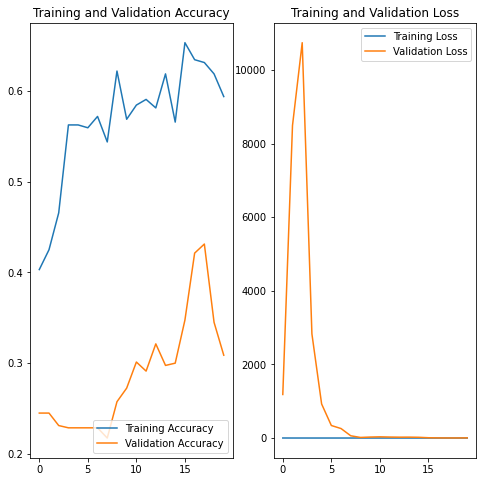

In [19]:
acc = detnet.history['accuracy']
val_acc = detnet.history['val_accuracy']

loss = detnet.history['loss']
val_loss = detnet.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Compiling the model using SGD optimizer

In [15]:
model.compile(optimizer='SGD', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
detnet = model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 10, epochs = 20)

Epoch 1/20
10/10 [==============================] - 13s 967ms/step - loss: 0.8660 - accuracy: 0.6963 - val_loss: 3.2343 - val_accuracy: 0.2988
Epoch 2/20
10/10 [==============================] - 8s 873ms/step - loss: 0.8081 - accuracy: 0.6720 - val_loss: 2.1776 - val_accuracy: 0.3675
Epoch 3/20
10/10 [==============================] - 8s 891ms/step - loss: 0.7413 - accuracy: 0.7014 - val_loss: 2.6158 - val_accuracy: 0.3200
Epoch 4/20
10/10 [==============================] - 8s 888ms/step - loss: 0.8988 - accuracy: 0.6703 - val_loss: 1.9588 - val_accuracy: 0.3600
Epoch 5/20
10/10 [==============================] - 8s 880ms/step - loss: 0.7750 - accuracy: 0.7258 - val_loss: 2.3285 - val_accuracy: 0.2988
Epoch 6/20
10/10 [==============================] - 8s 875ms/step - loss: 0.7537 - accuracy: 0.7327 - val_loss: 1.3104 - val_accuracy: 0.4950
Epoch 7/20
10/10 [==============================] - 8s 873ms/step - loss: 0.6888 - accuracy: 0.7611 - val_loss: 1.3574 - val_accuracy: 0.4663
Epoch

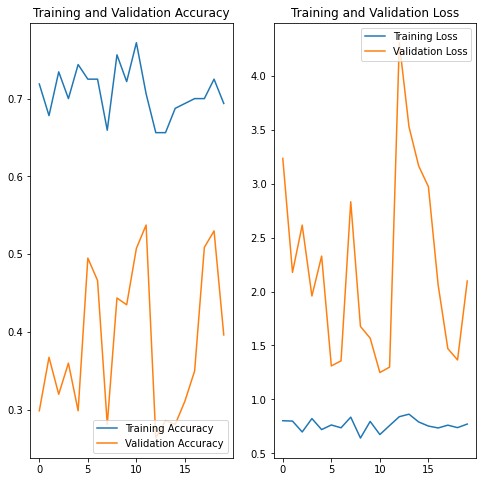

In [16]:
acc = detnet.history['accuracy']
val_acc = detnet.history['val_accuracy']

loss = detnet.history['loss']
val_loss = detnet.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()